##### Copyright 2019 The TensorFlow Authors and Geoffrey Fox 2020


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from cloudmesh.common.util import banner

import os
import sys
import socket
import pathlib

from cloudmesh.common.console import Console
from cloudmesh.common.Shell import Shell
from cloudmesh.common.dotdict import dotdict
from cloudmesh.common.Printer import Printer
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.gpu.gpu import Gpu
from pprint import pprint
import sys

from IPython.display import display
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tnrange
from tqdm import notebook
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
import gc
from csv import reader
from csv import writer
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta
from datetime import date
from datetime import datetime
from typing import Dict
from typing import Tuple
from typing import Optional
from typing import List
from typing import Union
from typing import Callable

import matplotlib
import matplotlib.patches as patches
# import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.path import Path
import matplotlib.dates as mdates
import scipy as sc
import scipy.linalg as solver
from matplotlib import colors
import enum
import pandas as pd
import abc
import json
import psutil

in_colab = 'google.colab' in sys.modules
in_rivanna = "hpc.virginia.edu" in socket.getfqdn()
in_nonstandard = not in_colab and not in_rivanna

if in_colab:
    # Avoids scroll-in-the-scroll in the entire Notebook
    #test
    from IPython.display import Javascript
    def resize_colab_cell():
      display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})'))
    get_ipython().events.register('pre_run_cell', resize_colab_cell)

    from google.colab import drive
    drive.mount('/content/gdrive')


gregor = True
config = dotdict()

In [3]:
# who am i

config.user = Shell.run('whoami')
config.user_id = Shell.run('id -u')
config.group_id = Shell.run('id -g')

print(Printer.attribute(config))


+-----------+-------+
| Attribute | Value |
+-----------+-------+
| group_id  | 1000  |
| user      | green |
| user_id   | 1000  |
+-----------+-------+


In [4]:
StopWatch.benchmark()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | focal                                                            |
| DISTRIB_DESCRIPTION | "Ubuntu 20.04.4 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 20.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

In [5]:
r = Gpu().system()

config.gpuname = r['product_name']
config.gpuvendor = r['vendor']

print (Printer.attribute(config))

+-----------+------------------------------------------+
| Attribute | Value                                    |
+-----------+------------------------------------------+
| gpuname   | NVIDIA GeForce RTX 3090                  |
| gpuvendor | ASUSTeK Computer Inc. Device [1043:87af] |
| group_id  | 1000                                     |
| user      | green                                    |
| user_id   | 1000                                     |
+-----------+------------------------------------------+


In [6]:
# Set Runname
RunName = 'EARTHQ-newTFTv29'
RunComment = ' TFT Dev on EarthQuakes --  2 weeks 3 months 6 months 1 year d_model 160  dropout 0.1 Location Based Validation BS 64 Simple 2 layers CUDA LSTM MSE corrected MHA Plot 28'

#
# StopWatch.benchmark(sysinfo=True)
# make sure we have free memory in it
# replace the following and if needed read from StopWatch
memory = StopWatch.get_sysinfo()["mem.available"]
print(f'Your runtime has {memory} of available RAM\n')

config.runname = RunName

Your runtime has 117.4 GiB of available RAM



# Initial System Code

In [7]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'

startpurple = '\033[35m'
startyellowbkg = '\033[43m'

banner("System information")
r = StopWatch.systeminfo()
print (r)


# ----------------------------------------------------------------------
# System information
# ----------------------------------------------------------------------

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | focal                                                            |
| DISTRIB_DESCRIPTION | "Ubuntu 20.04.4 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 20.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID        

In [8]:

banner("nvidia-smi")
gpu_info = Shell.run("nvidia-smi")
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
else:
  print(gpu_info)




# ----------------------------------------------------------------------
# nvidia-smi
# ----------------------------------------------------------------------

Sun Mar  6 12:10:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:0B:00.0  On |                  N/A |
| 53%   46C    P5    58W / 390W |   1441MiB / 24576MiB |     24%      Default |
|                               |                      |                  N/A |
+------

# Transformer model for science data based on original for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Science Data Parameters and Sizes

-------
Here is structure of science time series module. We will need several arrays that will need to be flattened at times. Note Python defaults to row major i.e. final index describes contiguous positions in memory


At highest level data is labeled by Time and Location

*   Ttot is total number of time steps
*   Tseq is length of each sequence in time steps
*   Num_Seq is number of sequences in time: Num_Seq = Ttot-Tseq + 1
*   Nloc is Number of locations. The locations could be a 1D list or have array structure such as an image.
*   Nsample is number of data samples Nloc * Num_Seq




Input data is at each location
*   Nprop time independent properties describing the location
*   Nforcing is number of time dependent forcing features INPUT at each time value


Output (predicted) data at each location and for each time sequence is
*   Npred predicted time dependent values defined at every time step
*   Recorded at Nforecast time values measured wrt final time value of sequence
*   ForecastDay is an array of length Nforecast defining how many days into future prediction is. Typically ForecastDay[0] = 1 and Nforecast is often 1
*   There is also a class of science problems that are more similar to classic Seq2Seq. Here Nforecast = Tseq and ForecastDay = [-Tseq+1 ... 0]
*   We also support Nwishful predictions of events in future such probability of an earthquake of magnitude 6 in next 3 years. These are defined by araays EventType and Timestart, TimeInterval of length Nwishful. EventType is user defined and Timestart, TimeInterval is measured in time steps
*   Any missing output values should be set to NaN and Loss function must ensure that these points are ignored in derivative calculation and value calculation

We have an input module that supports either LSTM or Transformer (multi-head attention) models

Example Problem AICov

*   Ttot = 114
*   Tseq = 9
*   Num_Seq = 106
*   Nloc = 110


*   Nprop = 35
*   Nforcing = 5 including infections, fatalities, plus 3 temporal position variables (last 3 not in current version)
 
 
*   Npred = 2 (predicted infections and fatalities). Could be 5 if predicted temporal position of output)
*   Nforecast= 15
*   ForecastDay = [1, 2, .......14, 15]
*   Nwishful = 0




















## Science Data Arrays

Typical Arrays


[ time, Location ] as Pandas array with label [name of time-dependent variable] as an array or just name of Pandas array

time labels rows indexed by datetime or the difference datetime - start

Non windowed data is stored with propert name as row index and location as column index
[ static property, Location]

Covid Input is
[Sequence number 0..Num_Seq-1 ] [ Location 0..Nloc-1 ] [position in time sequence Tseq]  [ Input Features]

Covid Output is 
[Sequence number Num_Seq ] [ Location Nloc ]  [ Output Features] 

Output Features are [ ipred = 0 ..Npred-1 ] [ iforecast = 0 ..Nforecast-1 ]

Input Features are static fields followed by if present by dynamic system fields (cos-theta sin-theta linear) chosen followed by cases, deaths. In fact this is user chosen as they set static and dynamic system properties to use

We will have various numpy and pandas arrays where we designate label

[Ttot] is all time values 

[Num_Seq]  is all sequences of window size ***Tseq***

We can select time values or sequences [Ttot-reason] [Num_Seq-reason] for a given "reason"

[Num_Seq][Tseq] is all time values in all sequences

[Nloc] is all locations while [Nloc-reason] is subset of locations for given "reason"

[Model1] is initial embedding of each data point

[Model1+TrPosEnc] is initial embedding of each data point with Transformer style positional encoding

[Nforcing] is time dependent input parameters and [Nprop] static properties while [ExPosEnc] are explicit positional (temporal) encoding.

[Nforcing+ExPosEnc+Nprop] are all possible inputs

[Npred] is predicted values with [Npred+ExPosEnc] as predictions plus encodings with actually used [Predvals] = [Npred+ExPosEnc-Selout] 

[Predtimes] = [Forecast time range] are times forecasted with "time range" separately defined



### Define Basic Control parameters

In [9]:
def wraptotext(textinput,size=None):
  if size is None:
    size = 120
  textlist = wrap(textinput,size)
  textresult = textlist[0]
  for itext in range(1,len(textlist)):
    textresult += '\n'+textlist[itext]
  return textresult

def timenow():
  now = datetime.now()
  return now.strftime("%m/%d/%Y, %H:%M:%S") + " UTC"

def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

NaN = np.float32("NaN")

ScaleProperties = False
ConvertDynamicPredictedQuantity = False
ConvertDynamicProperties = True
GenerateFutures = False
GenerateSequences = False
PredictionsfromInputs = False
RereadMay2020 = False
UseOLDCovariates = False
Dropearlydata = 0
NIHCovariates = False 
UseFutures = True
Usedaystart = False 
PopulationNorm = False
SymbolicWindows = False
Hydrology = False
Earthquake = False
EarthquakeImagePlots = False
AddSpecialstoSummedplots = False
UseRealDatesonplots = False
Dumpoutkeyplotsaspics = False
OutputNetworkPictures = False
NumpredbasicperTime = 2
NumpredFuturedperTime = 2
NumTimeSeriesCalculated = 0
Dailyunit = 1
TimeIntervalUnitName = 'Day'
InitialDate = datetime(2000,1,1)
NumberofTimeunits = 0
Num_Time =0
FinalDate = datetime(2000,1,1)
GlobalTrainingLoss = 0.0
GlobalValidationLoss = 0.0

# Type of Testing
LocationBasedValidation = False
LocationValidationFraction = 0.0
LocationTrainingfraction = 1.0
RestartLocationBasedValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
Plotsplitsize = -1 # if > 1 split time in plots

GarbageCollect = True
GarbageCollectionLimit = 0

current_time = timenow()
print(startbold + startred + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)

Earthquake = True


03/06/2022, 12:10:13 UTC EARTHQ-newTFTv29  TFT Dev on EarthQuakes --  2 weeks 3 months 6 months 1 year d_model 160  dropout 0.1 Location Based Validation BS 64 Simple 2 layers CUDA LSTM MSE corrected MHA Plot 28


## Define input structure

Read in data and set it up for Tensorflow with training and validation


Set train_examples, val_examples as science training and validatioon set.

The shuffling of Science Data needs some care. We have ***Tseq*** * size of {[Num_Seq][Nloc]} locations in each sample. In simplease case the last is just a decomposition over location; not over time. Let's Nloc-sel be number of locations per sample. It will be helpful if Nloc-sel is divisable by 2. 

Perhaps Nloc-sel = 2 6 or 10 is reasonable.

Then you shuffle locations every epoch and divide them into groups of size Nloc-sel with 50% overlap so you get locations

0 1 2 3 4 5; 

3 4 5 6 7 8; 

6 7 8 9 10 11 etc.

Every locations appears twice in an epoch (for each time value). You need to randomly add locations at end of sequence so it is divisiuble by Nloc-sel e.g add 4 random positions to the end if Nloc=110 and Nloc-sel = 6. Note last group of 6 has members 112 113 114 0 1 2

After spatial structure set up, randomly shuffle in Num_Seq where there is an argument to do all locations for a partcular time value together.

For validation, it is probably best to select validation location before chopping them into groups of size Nloc-sel

How one groups locations for inference is not clear. One idea is to take trained network and use it to find for each location which other locations have the most attention with it. Use those locations in  prediction

More general input. 
NaN allowed value

* Number time values
* Number locations
* Number driving values
* Number predicted values

For COVID driving same as predicted

* a) Clean up >=0 daily
* b) Normalize
* c) Add Futures
* d) Add time/location encoding


### Setup File Systems

In [10]:

if in_colab:
    # find the data
    COLABROOTDIR="/content/gdrive/My Drive/Colab Datasets"
elif in_rivanna:
    COLABROOTDIR=str(pathlib.Path("../data").resolve())
else:
    COLABROOTDIR=str(pathlib.Path("../data").resolve())

print (COLABROOTDIR)

if not os.path.exists(COLABROOTDIR):
    Console.error(f"Missing data directory: {COLABROOTDIR}")
    sys.exit(1)

os.environ["COLABROOTDIR"] = COLABROOTDIR
APPLDIR=f"{COLABROOTDIR}/EarthquakeDec2020"
CHECKPOINTDIR = f"{APPLDIR}/checkpoints/{RunName}dir/"
Shell.mkdir(CHECKPOINTDIR)
print(f'Checkpoint set up in directory {CHECKPOINTDIR}')

config.checkpointdir = CHECKPOINTDIR
config.appldir = APPLDIR
config.colabrootdir = COLABROOTDIR

print(Printer.attribute(config))


/home/green/Desktop/github/mlcommons/benchmarks/earthquake/data
Checkpoint set up in directory /home/green/Desktop/github/mlcommons/benchmarks/earthquake/data/EarthquakeDec2020/checkpoints/EARTHQ-newTFTv29dir/
+---------------+--------------------------------------------------------------------------------------------------------------------+
| Attribute     | Value                                                                                                              |
+---------------+--------------------------------------------------------------------------------------------------------------------+
| appldir       | /home/green/Desktop/github/mlcommons/benchmarks/earthquake/data/EarthquakeDec2020                                  |
| checkpointdir | /home/green/Desktop/github/mlcommons/benchmarks/earthquake/data/EarthquakeDec2020/checkpoints/EARTHQ-newTFTv29dir/ |
| colabrootdir  | /home/green/Desktop/github/mlcommons/benchmarks/earthquake/data                                  

### Space Filling Curves

In [11]:

def cal_gilbert2d(width: int, height: int) -> List[Tuple[int, int]]:
    coordinates: List[Tuple[int, int]] = []

    def sgn(x: int) -> int:
        return (x > 0) - (x < 0)

    def gilbert2d(x: int, y: int, ax: int, ay: int, bx: int, by: int):
        """
        Generalized Hilbert ('gilbert') space-filling curve for arbitrary-sized
        2D rectangular grids.
        """

        w = abs(ax + ay)
        h = abs(bx + by)

        (dax, day) = (sgn(ax), sgn(ay))  # unit major direction
        (dbx, dby) = (sgn(bx), sgn(by))  # unit orthogonal direction

        if h == 1:
            # trivial row fill
            for i in range(0, w):
                coordinates.append((x, y))
                (x, y) = (x + dax, y + day)
            return

        if w == 1:
            # trivial column fill
            for i in range(0, h):
                coordinates.append((x, y))
                (x, y) = (x + dbx, y + dby)
            return

        (ax2, ay2) = (ax // 2, ay // 2)
        (bx2, by2) = (bx // 2, by // 2)

        w2 = abs(ax2 + ay2)
        h2 = abs(bx2 + by2)

        if 2 * w > 3 * h:
            if (w2 % 2) and (w > 2):
                # prefer even steps
                (ax2, ay2) = (ax2 + dax, ay2 + day)

            # long case: split in two parts only
            gilbert2d(x, y, ax2, ay2, bx, by)
            gilbert2d(x + ax2, y + ay2, ax - ax2, ay - ay2, bx, by)

        else:
            if (h2 % 2) and (h > 2):
                # prefer even steps
                (bx2, by2) = (bx2 + dbx, by2 + dby)

            # standard case: one step up, one long horizontal, one step down
            gilbert2d(x, y, bx2, by2, ax2, ay2)
            gilbert2d(x + bx2, y + by2, ax, ay, bx - bx2, by - by2)
            gilbert2d(x + (ax - dax) + (bx2 - dbx), y + (ay - day) + (by2 - dby), -bx2, -by2, -(ax - ax2), -(ay - ay2))

    if width >= height:
        gilbert2d(0, 0, width, 0, 0, height)
    else:
        gilbert2d(0, 0, 0, height, width, 0)
    return coordinates

def lookup_color(unique_colors, color_value: float) -> int:
      ids = np.where(unique_colors == color_value)
      color_id = ids[0][0]
      return color_id

def plot_gilbert2d_space_filling(
    vertices: List[Tuple[int, int]],
    width: int,
    height: int,
    filling_color: Optional[np.ndarray] = None,
    color_map: str = "rainbow",
    figsize: Tuple[int, int] = (12, 8),
    linewidth: int = 1,
) -> None:

    fig, ax = plt.subplots(figsize=figsize)
    patch_list: List = []

    if filling_color is None:
        cmap = matplotlib.cm.get_cmap(color_map, len(vertices))
        for i in range(len(vertices) - 1):
            path = Path([vertices[i], vertices[i + 1]], [Path.MOVETO, Path.LINETO])
            patch = patches.PathPatch(path, fill=False, edgecolor=cmap(i), lw=linewidth)
            patch_list.append(patch)
        ax.set_xlim(-1, width)
        ax.set_ylim(-1, height)

    else:
        unique_colors = np.unique(filling_color)
#        np.random.shuffle(unique_colors)
        cmap = matplotlib.cm.get_cmap(color_map, len(unique_colors))

        for i in range(len(vertices) - 1):
            x, y = vertices[i]
            fi, fj = x, height - 1 - y
            color_value = filling_color[fj, fi]
            color_id = lookup_color(unique_colors, color_value)
            path = Path(
                [rescale_xy(x, y), rescale_xy(vertices[i + 1][0], vertices[i + 1][1])], [Path.MOVETO, Path.LINETO]
            )
            # path = Path([vertices[i], vertices[i + 1]], [Path.MOVETO, Path.LINETO])
            patch = patches.PathPatch(path, fill=False, edgecolor=cmap(color_id), lw=linewidth)
            patch_list.append(patch)
        ax.set_xlim(-120 - 0.1, width / 10 - 120)
        ax.set_ylim(32 - 0.1, height / 10 + 32)

    collection = matplotlib.collections.PatchCollection(patch_list, match_original=True)
    # collection.set_array()
    # plt.colorbar(collection)
    ax.add_collection(collection)
    ax.set_aspect("equal")
    plt.show()
    return 

def rescale_xy(x: int, y: int) -> Tuple[float, float]:
    return x / 10 - 120, y / 10 + 32

def remapfaults(InputFaultNumbers, Numxlocations, Numylocations, SpaceFillingCurve):
  TotalLocations = Numxlocations*Numylocations
  OutputFaultNumbers = np.full_like(InputFaultNumbers, -1, dtype=int)

  MaxOldNumber = np.amax(InputFaultNumbers)
  mapping = np.full(MaxOldNumber+1, -1,dtype=int)

  newlabel=-1
  for sfloc in range(0, TotalLocations):
    [x,y] = SpaceFillingCurve[sfloc]
    pixellocation = y*Numxlocations + x
    pixellocation1 = y*Numxlocations + x
    oldfaultnumber = InputFaultNumbers[pixellocation1]
    if mapping[oldfaultnumber] < 0:
      newlabel += 1
      mapping[oldfaultnumber] = newlabel
    OutputFaultNumbers[pixellocation] = mapping[oldfaultnumber]
  MinNewNumber = np.amin(OutputFaultNumbers)
  if MinNewNumber < 0:
    printexit('Incorrect Fault Mapping')
  print('new Fault Labels generated 0 through ' + str(newlabel))
  plot_gilbert2d_space_filling(SpaceFillingCurve,Numxlocations, Numylocations, filling_color = np.reshape(OutputFaultNumbers,(40,60)), color_map="gist_ncar")
  return OutputFaultNumbers

def annotate_faults_ndarray(pix_faults: np.ndarray, figsize=(10, 8), color_map="rainbow"):
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams.update({"font.size": 12})
    unique_colors = np.unique(pix_faults)
    np.random.shuffle(unique_colors)
    cmap = matplotlib.cm.get_cmap(color_map, len(unique_colors))

    fig, ax = plt.subplots(figsize=figsize)
    height, width = pix_faults.shape
    for j in range(height):
        for i in range(width):
            x, y = i / 10 - 120, (height - j - 1) / 10 + 32
            ax.annotate(str(pix_faults[j, i]), (x + 0.05, y + 0.05), ha="center", va="center")
            color_id = lookup_color(unique_colors, pix_faults[j, i])
            ax.add_patch(patches.Rectangle((x, y), 0.1, 0.1, color=cmap(color_id), alpha=0.5))
    ax.set_xlim(-120, width / 10 - 120)
    ax.set_ylim(32, height / 10 + 32)
    plt.show()



# CELL READ DATA

['/home/green/Desktop/github/mlcommons/benchmarks/earthquake/data/EarthquakeDec2020']


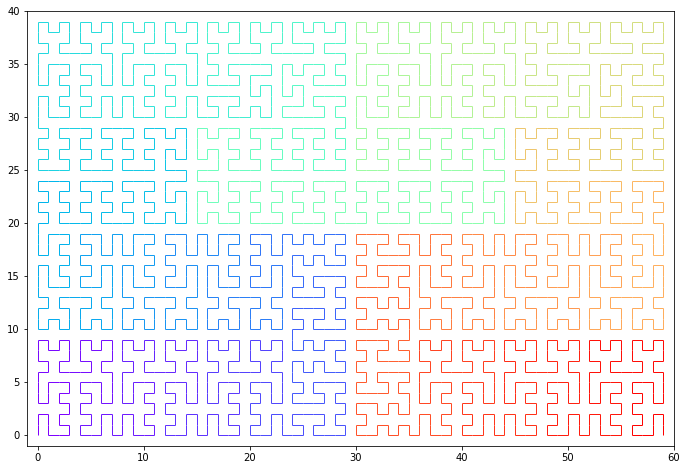

01/01/1950 To 31/12/2019 days 25567
 Pixels 2400 x dimension 60 y dimension 40
Read Magnitude data locations 2400 Time Steps 25567
Read Depth data locations 2400 Time Steps 25567
Read Multiplicity data locations 2400 Time Steps 25567
Read Rundle Multiplicity data locations 2400 Time Steps 25567
0 mag 7.5 Lat/Long -119.0 -119.0 1952-07-216km WNW of Grapevine, CA
1 mag 7.3 Lat/Long -116.44 -116.44 1992-06-28Landers, California Earthquake
2 mag 7.2 Lat/Long -115.3 -115.3 2010-04-0412km SW of Delta, B.C., MX
3 mag 7.1 Lat/Long -116.26 -116.26 1999-10-16Hector Mine, CA Earthquake
4 mag 7.1 Lat/Long -117.6 -117.6 2019-07-062019 Ridgecrest Earthquake Sequence
5 mag 6.7 Lat/Long -118.54 -118.54 1994-01-171km NNW of Reseda, CA
6 mag 6.6 Lat/Long -116.1 -116.1 1968-04-095km NNE of Ocotillo Wells, CA
7 mag 6.6 Lat/Long -115.85 -115.85 1987-11-2422km W of Westmorland, CA
8 mag 6.6 Lat/Long -118.37 -118.37 1971-02-0910km SSW of Agua Dulce, CA
9 mag 6.4 Lat/Long -116.08 -116.08 1954-03-1912km W of S

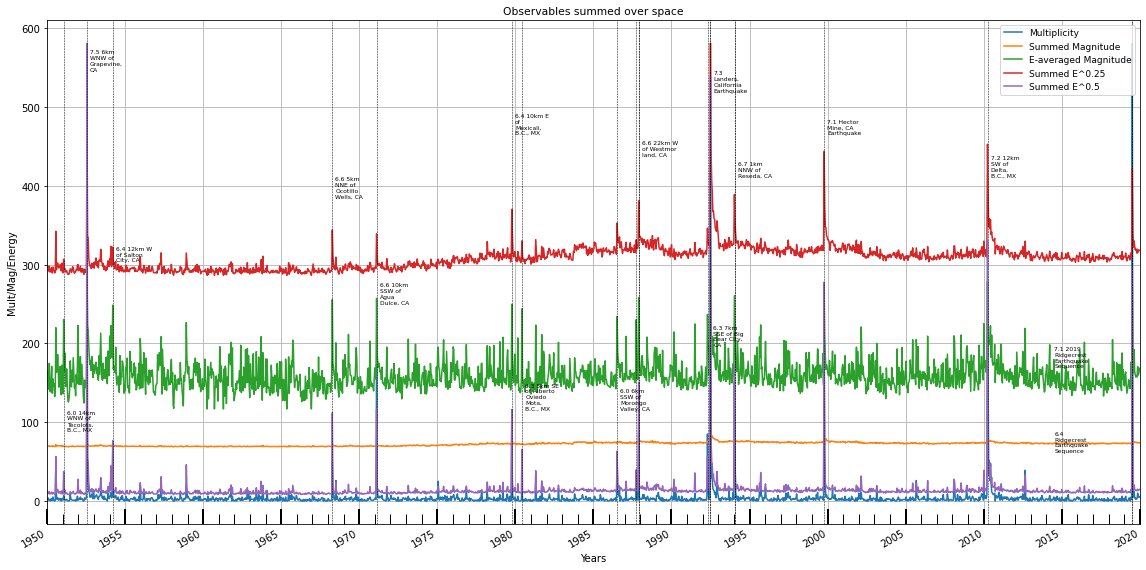

Read Fault Label data locations 2400
Number Fault Collections 36
new Fault Labels generated 0 through 35


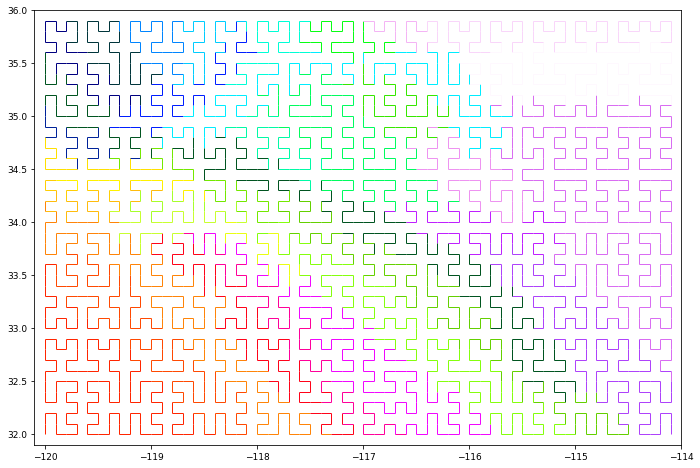

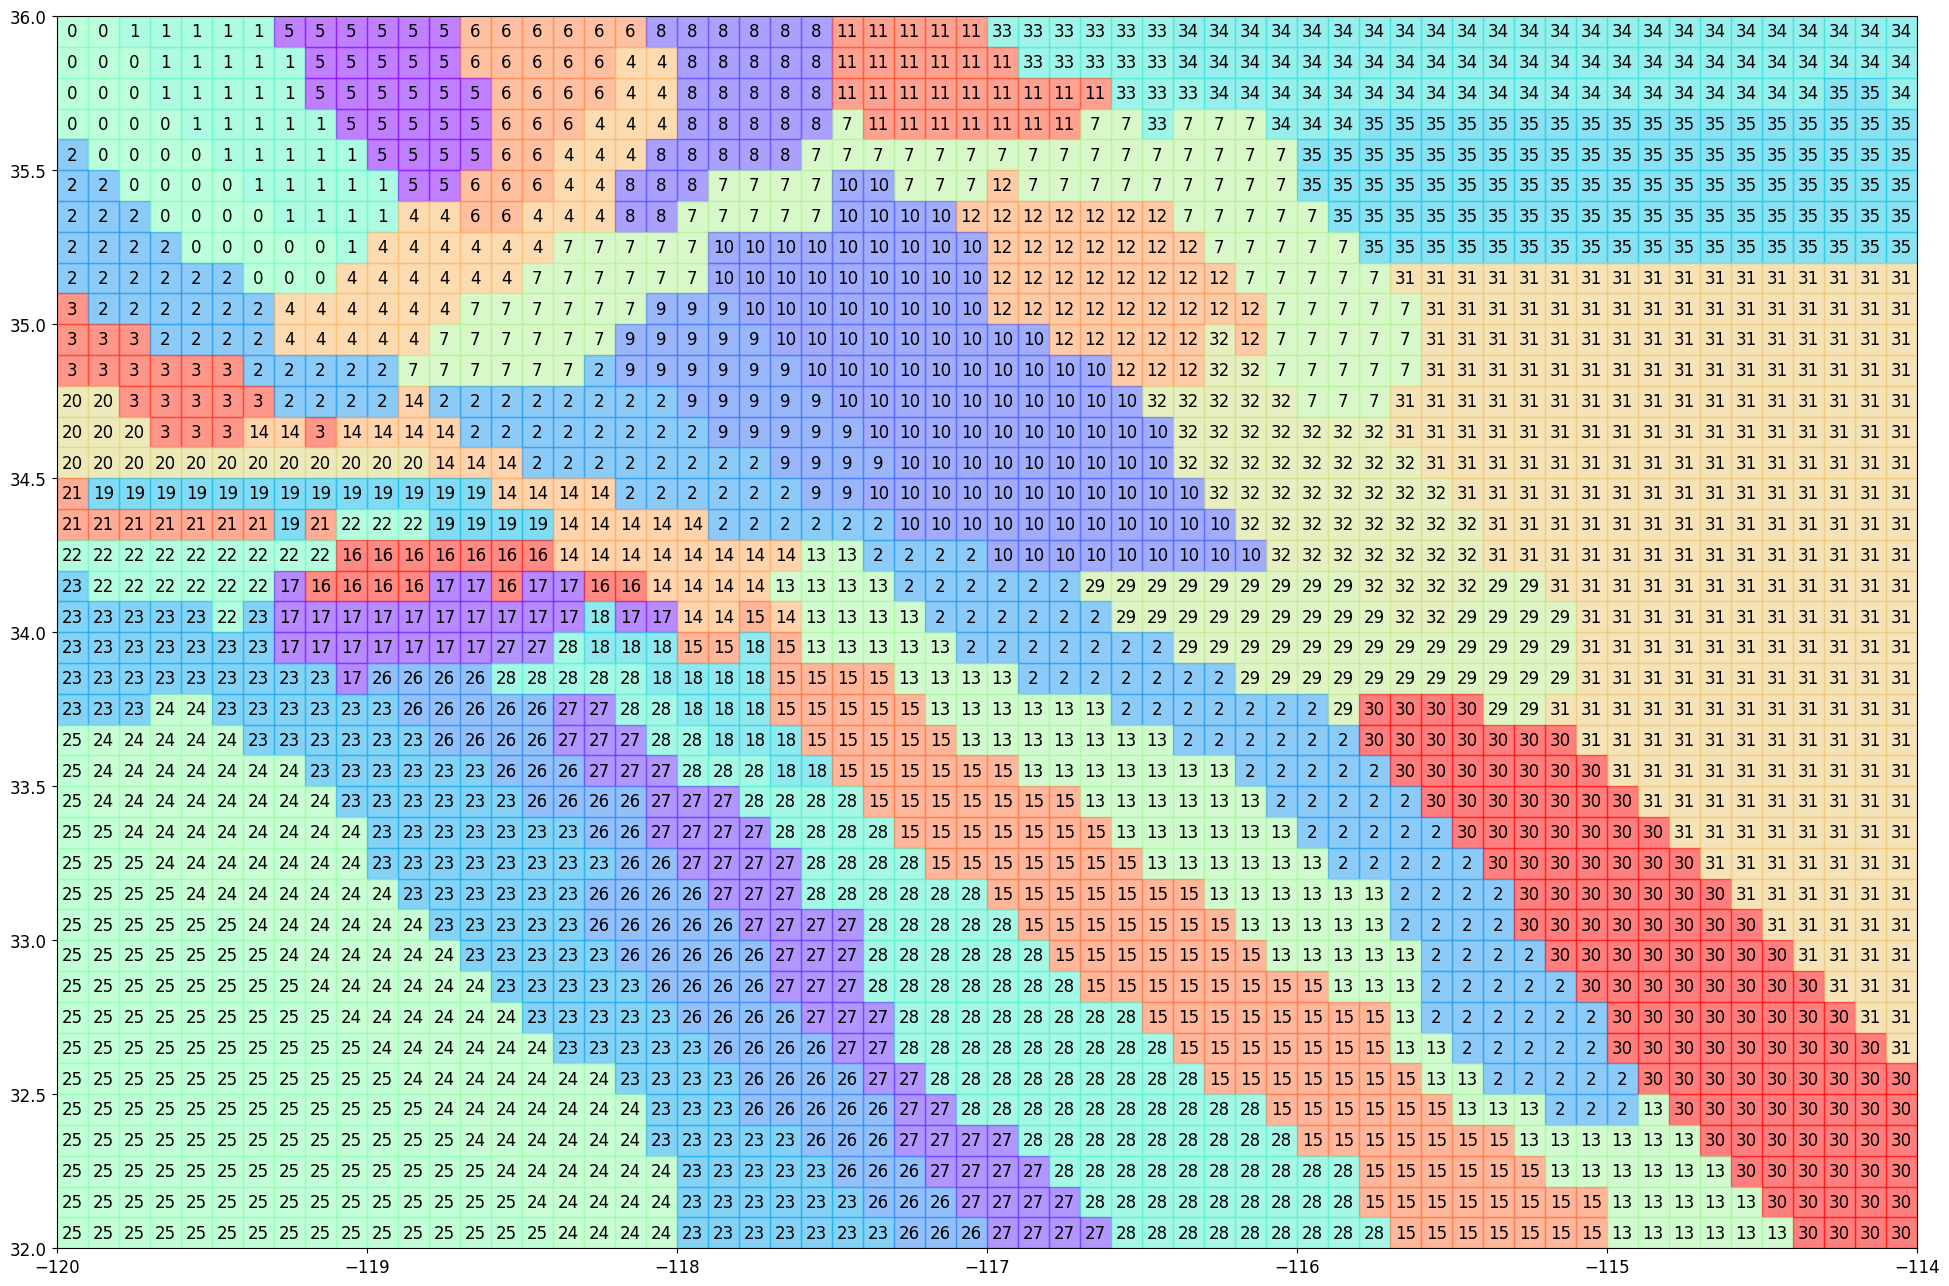

new Fault Labels generated 0 through 35


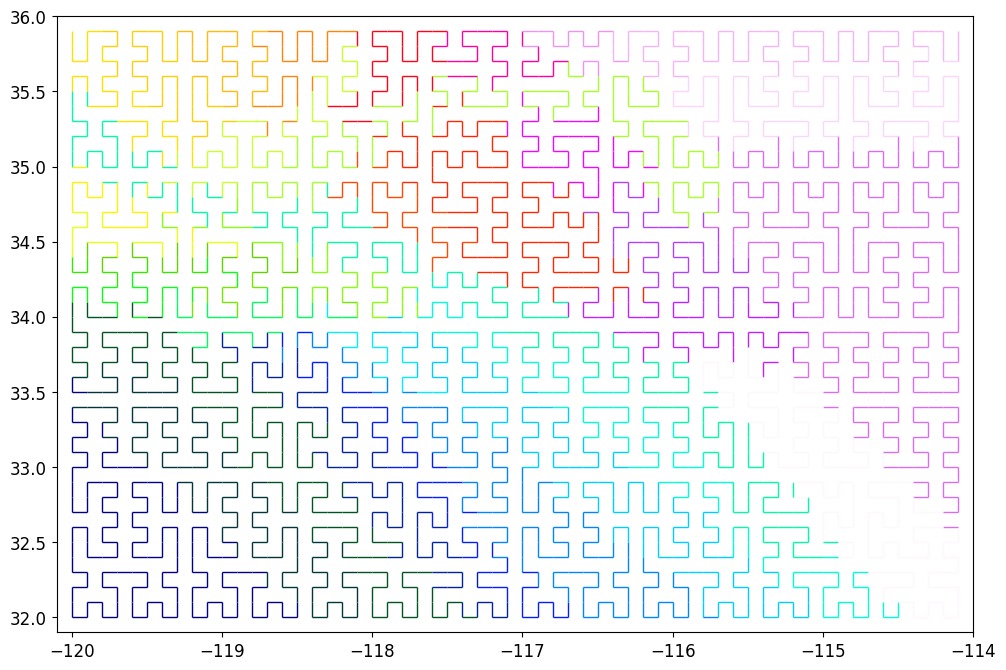

new Fault Labels generated 0 through 35


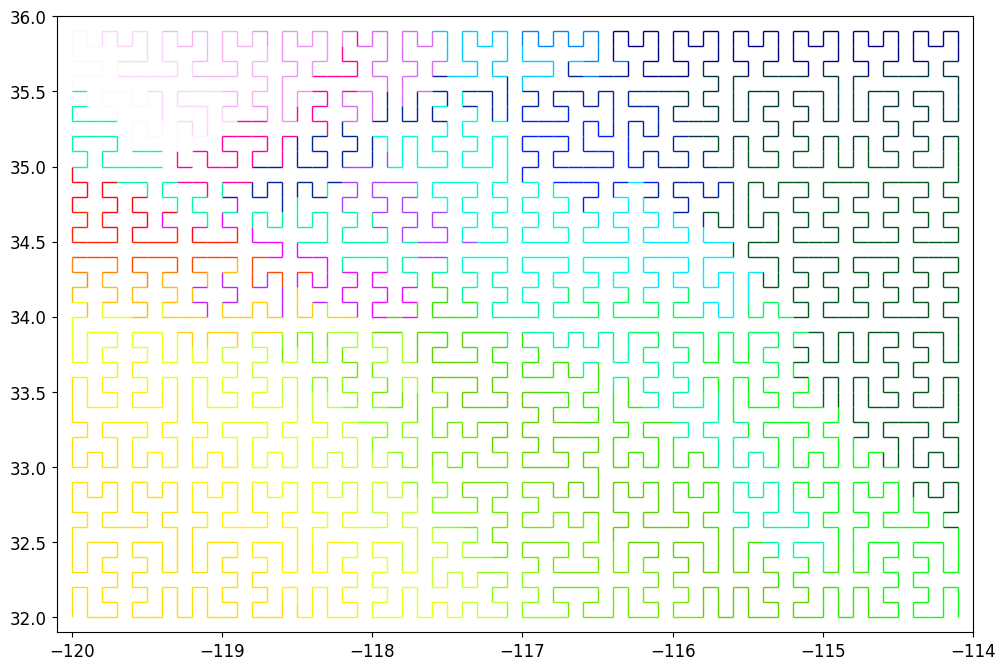

new Fault Labels generated 0 through 35


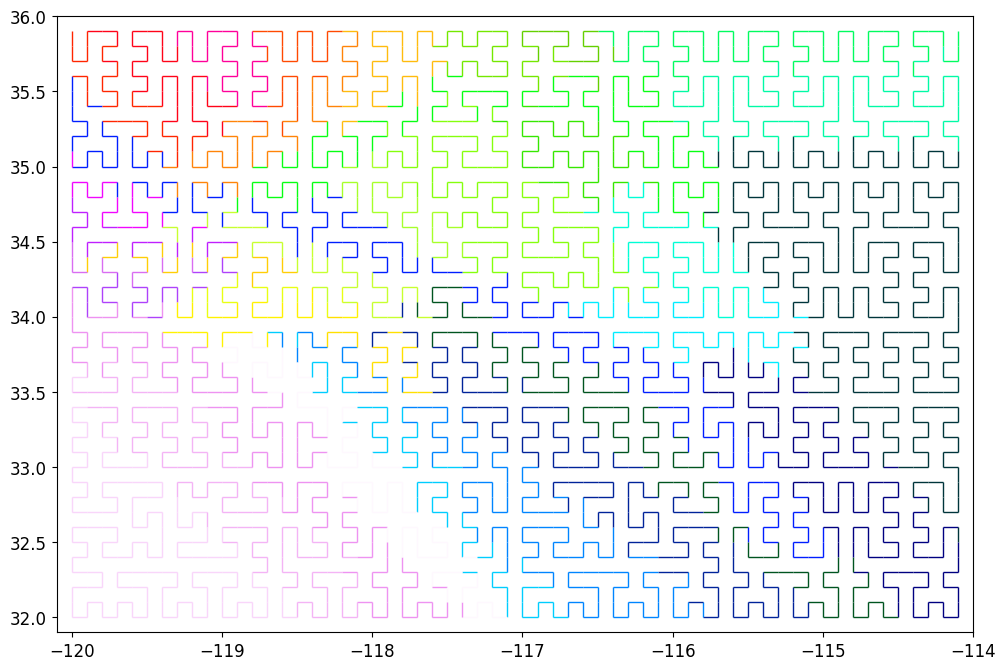

Earthquake 0 Mag 4 Weeks Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 10 E^0.25 4 Weeks Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 1 Mag 2 Month Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 11 E^0.25 2 Months Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 2 Mag 3 Months Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 12 E^0.25 3 Months Ahead 03/06/2022, 12:11:32 UTC EARTHQ-newTFTv29
Earthquake 3 Mag 6 Months Ahead 03/06/2022, 12:11:33 UTC EARTHQ-newTFTv29
Earthquake 13 E^0.25 6 Months Ahead 03/06/2022, 12:11:33 UTC EARTHQ-newTFTv29
Earthquake 4 Mag Year Ahead 03/06/2022, 12:11:34 UTC EARTHQ-newTFTv29
Earthquake 14 E^0.25 Year Ahead 03/06/2022, 12:11:34 UTC EARTHQ-newTFTv29
Earthquake 5 Mag 2 Years Ahead 03/06/2022, 12:11:35 UTC EARTHQ-newTFTv29
Earthquake 15 E^0.25 2 Years Ahead 03/06/2022, 12:11:35 UTC EARTHQ-newTFTv29
Earthquake 6 Mag 4 years Ahead 03/06/2022, 12:11:38 UTC EARTHQ-newTFTv29
Earthquake 16 E^0.25 4 years

In [12]:

def makeadateplot(plotfigure,plotpointer, Dateaxis=None, datemin=None, datemax=None, Yearly=True, majoraxis = 5):
  if not Yearly:
    sys.exit('Only yearly supported')
  plt.rcParams.update({'font.size': 9})
  years5 = mdates.YearLocator(majoraxis)   # every 5 years
  years_fmt = mdates.DateFormatter('%Y')
  plotpointer.xaxis.set_major_locator(years5)
  plotpointer.xaxis.set_major_formatter(years_fmt)
  if datemin is None:
    datemin = np.datetime64(Dateaxis[0], 'Y')
  if datemax is None:
    datemax = np.datetime64(Dateaxis[-1], 'Y') + np.timedelta64(1, 'Y')
  plotpointer.set_xlim(datemin, datemax)
  plotfigure.autofmt_xdate()
  return datemin, datemax

def makeasmalldateplot(figure,ax, Dateaxis):
  plt.rcParams.update({'font.size': 9})
  months = mdates.MonthLocator(interval=2)   # every month
  datemin = np.datetime64(Dateaxis[0], 'M')
  datemax = np.datetime64(Dateaxis[-1], 'M') + np.timedelta64(1, 'M')
  ax.set_xlim(datemin, datemax)

  months_fmt = mdates.DateFormatter('%y-%b')
  locator = mdates.AutoDateLocator()
  locator.intervald['MONTHLY'] = [2]
  formatter = mdates.ConciseDateFormatter(locator)
#  ax.xaxis.set_major_locator(locator)
#  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(months_fmt)

  figure.autofmt_xdate()
  return datemin, datemax

def Addfixedearthquakes(plotpointer,graphmin, graphmax, ylogscale = False, quakecolor = None, Dateplot = True, vetoquake = None):
  if vetoquake is None: # Vetoquake = True means do not plot this quake
    vetoquake = np.full(numberspecialeqs, False, dtype = bool)

  if quakecolor is None: # Color of plot
    quakecolor = 'black'
  Place =np.arange(numberspecialeqs, dtype =int)
  Place[8] = 11
  Place[10] = 3
  Place[12] = 16
  Place[7] = 4
  Place[2] = 5
  Place[4] = 14
  Place[11] = 18

  ymin, ymax = plotpointer.get_ylim() # Or work with transform=ax.transAxes

  for iquake in range(0,numberspecialeqs):
    if vetoquake[iquake]:
      continue

# This is the x position for the vertical line
    if Dateplot:
      x_line_annotation = Specialdate[iquake] # numpy date format
    else:
      x_line_annotation = Numericaldate[iquake] # Float where each interval 1 and start is 0
    if (x_line_annotation < graphmin) or (x_line_annotation > graphmax):
      continue

    # This is the x position for the label
    if Dateplot:
      x_text_annotation = x_line_annotation + np.timedelta64(5*Dailyunit,'D')
    else:
      x_text_annotation = x_line_annotation + 5.0
    # Draw a line at the position
    plotpointer.axvline(x=x_line_annotation, linestyle='dashed', alpha=1.0, linewidth = 0.5, color=quakecolor)
    # Draw a text
    if Specialuse[iquake]:
      ascii = str(round(Specialmags[iquake],1)) + '\n' + Specialeqname[iquake]
      if ylogscale:
        yminl = max(0.01*ymax,ymin)
        yminl = math.log(yminl,10)
        ymaxl = math.log(ymax,10)
        logyplot = yminl + (0.1 + 0.8*(float(Place[iquake])/float(numberspecialeqs-1)))*(ymaxl-yminl)
        yplot = pow(10, logyplot)
      else:
        yplot = ymax - (0.1 + 0.8*(float(Place[iquake])/float(numberspecialeqs-1)))*(ymax-ymin)
      if Dateplot:
        if x_text_annotation > graphmax - np.timedelta64(2000, 'D'):
          x_text_annotation = graphmax - np.timedelta64(2000, 'D')
      else:
        if x_text_annotation > graphmax - 100:
          x_text_annotation = graphmax - 100
#      print(str(yplot) + " " + str(ymin) + " " + str(ymax) + " " + str(x_text_annotation) + " " + str(x_line_annotation)) + " " + ascii
      plotpointer.text(x=x_text_annotation, y=yplot, s=wraptotext(ascii,size=10), alpha=1.0, color='black', fontsize = 6)


def quakesearch(iquake, iloc):
# see if top earthquake iquake llies near location iloc
# result = 0 NO; =1 YES Primary: locations match exactly; = -1 Secondary: locations near
# iloc is location before mapping
  xloc = iloc%60
  yloc = (iloc - xloc)/60
  if (xloc == Specialxpos[iquake]) and (yloc == Specialypos[iquake]):
    return 1
  if (abs(xloc - Specialxpos[iquake]) <= 1) and (abs(yloc - Specialypos[iquake]) <= 1):
    return -1
  return 0

# Read Earthquake Data
def log_sum_exp10(ns, sumaxis =0):
    max_v = np.max(ns, axis=None)
    ds = ns - max_v
    sum_of_exp = np.power(10, ds).sum(axis=sumaxis)
    return max_v + np.log10(sum_of_exp)

def log_energyweightedsum(nvalue, ns, sumaxis = 0):
    max_v = np.max(ns, axis=None)
    ds = ns - max_v
    ds = np.power(10, 1.5*ds)
    dvalue = (np.multiply(nvalue,ds)).sum(axis=sumaxis)
    ds  = ds.sum(axis=0)
    return np.divide(dvalue,ds)

# Set summed magnitude as log summed energy = 10^(1.5 magnitude)
def log_energy(mag, sumaxis =0):
    return log_sum_exp10(1.5 * mag, sumaxis = sumaxis) / 1.5

def AggregateEarthquakes(itime, DaysDelay, DaysinInterval, Nloc, Eqdata, Approach, weighting = None):
  if (itime + DaysinInterval + DaysDelay) > NumberofTimeunits:
    return np.full([Nloc],NaN,dtype = np.float32)
  if Approach == 0: # Magnitudes
    if MagnitudeMethod == 0:
      TotalMagnitude = log_energy(Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay])
    else:
      TotalMagnitude = Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay,:].sum(axis=0)
    return TotalMagnitude
  if Approach == 1: # Depth -- energy weighted
    WeightedResult = log_energyweightedsum(Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay],
                                        weighting[itime +DaysDelay:itime+DaysinInterval+DaysDelay])
    return WeightedResult
  if Approach == 2: # Multiplicity -- summed
    SimpleSum = Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay,:].sum(axis=0)
    return SimpleSum

def TransformMagnitude(mag):
  if MagnitudeMethod == 0:
    return mag
  if MagnitudeMethod == 1:
    return np.power(10, 0.375*(mag-3.29))
  return np.power(10, 0.75*(mag-3.29))

# Change Daily Unit
# Accumulate data in Dailyunit chunks.
# This changes data so it looks like daily data bu really collections of chunked data.
# For earthquakes, the aggregations uses energy averaging for depth and magnitude. It just adds for multiplicity
def GatherUpData(OldInputTimeSeries):
    Skipped = NumberofTimeunits%Dailyunit
    NewInitialDate = InitialDate + timedelta(days=Skipped)
    NewNum_Time = int(Num_Time/Dailyunit)
    NewFinalDate = NewInitialDate + Dailyunit * timedelta(days=NewNum_Time-1)
    print(' Daily Unit ' +str(Dailyunit) + ' number of ' + TimeIntervalUnitName + ' Units ' + str(NewNum_Time)+ ' ' +
         NewInitialDate.strftime("%d/%m/%Y") + ' To ' + NewFinalDate.strftime("%d/%m/%Y"))
    NewInputTimeSeries = np.empty([NewNum_Time,Nloc,NpropperTimeDynamicInput],dtype = np.float32)
    for itime in range(0,NewNum_Time):
      NewInputTimeSeries[itime,:,0] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc,
                                                           BasicInputTimeSeries[:,:,0], 0)
      NewInputTimeSeries[itime,:,1] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc,
                                                           BasicInputTimeSeries[:,:,1], 1,
                                                           weighting = BasicInputTimeSeries[:,:,0])
      NewInputTimeSeries[itime,:,2] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc,
                                                           BasicInputTimeSeries[:,:,2], 2)
      NewInputTimeSeries[itime,:,3] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc,
                                                           BasicInputTimeSeries[:,:,3], 2)
    return NewInputTimeSeries, NewNum_Time, NewNum_Time, NewInitialDate, NewFinalDate

# Daily Read in Version
if Earthquake:
  read1950 = True
  Eigenvectors = 2
  UseEarthquakeEigenSystems = False
  Dailyunit = 14
  addwobblingposition = False
  r = Shell.ls(config.appldir)
  print (r)
  if read1950:
    MagnitudeDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-log_eng.multi.csv'
    DepthDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-w_depth.multi.csv'
    MultiplicityDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-n_shock.multi.csv'
    RundleMultiplicityDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-n_shock-mag-3.29.multi.csv'
    NumberofTimeunits = 25567
    InitialDate = datetime(1950,1,1)
  else:
    MagnitudeDataFile = APPLDIR + '/SC_1990-2019.freq-D-10759x2400.csv'
    DepthDataFile = APPLDIR + '/SC_1990-2019.freq-D-w_depth-10759x2400.multi.csv'
    MultiplicityDataFile = APPLDIR + '/SC_1990-2019.freq-D-num_evts-10759x2400.csv'
    RundleMultiplicityDataFile = APPLDIR + '/SC_1990-2019.freq-D-10755x2400-n_shock-mag-3.29.multi.csv'

    NumberofTimeunits = 10759
    InitialDate = datetime(1990,1,1)
  Topearthquakesfile = APPLDIR + '/topearthquakes_20.csv'

  FaultLabelDataFile = APPLDIR + '/pix_faults_SmallJan21.csv'
  MagnitudeMethod = 0
  ReadFaultMethod = 2 # one set of x values for each input row
  Numberxpixels = 60
  Numberypixels = 40
  Numberpixels = Numberxpixels*Numberypixels
  Nloc = Numberpixels
  Nlocdimension = 2
  Nlocaxislengths = np.array((Numberxpixels,Numberypixels), ndmin = 1, dtype=int) # First row is top (north)
  vertices = cal_gilbert2d(Numberxpixels,Numberypixels)
#    print(vertices[0], vertices[1],vertices[2399], vertices[1198], vertices[1199],vertices[1200], vertices[1201])
  sfcurvelist = vertices
  plot_gilbert2d_space_filling(sfcurvelist, Numberxpixels, Numberypixels)

  Dropearlydata = 0

  FinalDate = InitialDate + timedelta(days=NumberofTimeunits-1)
  print(startbold + startred + InitialDate.strftime("%d/%m/%Y") + ' To ' + FinalDate.strftime("%d/%m/%Y")
    + ' days ' + str(NumberofTimeunits) + resetfonts)
  print( ' Pixels ' + str(Nloc) + ' x dimension '  + str(Nlocaxislengths[0]) + ' y dimension ' + str(Nlocaxislengths[1]) )

 # Set up location information
  Num_Time = NumberofTimeunits
  NFIPS = Numberpixels
  Locationname = [''] * NFIPS
  Locationstate = [' '] * NFIPS
  Locationpopulation = np.ones(NFIPS, dtype=int)
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  for iloc in range (0, Numberpixels):
    localfips = iloc
    xvalue = localfips%Nlocaxislengths[0]
    yvalue = np.floor(localfips/Nlocaxislengths[0])
    Stringfips = str(xvalue) + ',' + str(yvalue)
    Locationcolumns.append(Stringfips)
    Locationname[iloc] = Stringfips
    Locationfips[iloc] = localfips
    FIPSintegerlookup[localfips] = localfips
    FIPSstringlookup[Stringfips] = localfips

# TimeSeries 0 magnitude 1 depth 2 Multiplicity 3 Rundle Multiplicity
  NpropperTimeDynamicInput = 4
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,NpropperTimeDynamicInput],dtype = np.float32)
# StaticProps 0...NumFaultLabels-1 Fault Labels
  NumFaultLabels = 4
  BasicInputStaticProps = np.empty([Nloc,NumFaultLabels],dtype = np.float32)
  RawFaultData = np.empty(Nloc,dtype = int)

# Read in Magnitude Data into BasicInputTimeSeries
  with open(MagnitudeDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + MagnitudeDataFile)

      itime = 0
      for nextrow in csv_reader:
        if len(nextrow)!=Numberpixels + 1:
          printexit('EXIT: Incorrect row length Magnitude ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if itime != int(localtime):
          printexit('EXIT: Unexpected Time in Magnitude ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,0] = TransformMagnitude(float(nextrow[iloc + 1]))
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Magnitude Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Magnitude data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Magnitude data

# Read in Depth Data into BasicInputTimeSeries
  with open(DepthDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + DepthDataFile)

      itime = 0
      for nextrow in csv_reader:
        if len(nextrow)!=Numberpixels + 1:
          printexit('EXIT: Incorrect row length Depth ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if itime != int(localtime):
          printexit('EXIT: Unexpected Time in Depth ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Depth Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Depth data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Depth data

# Read in Multiplicity Data into BasicInputTimeSeries
  with open(MultiplicityDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + MultiplicityDataFile)

      itime = 0
      for nextrow in csv_reader:
        if len(nextrow)!=Numberpixels + 1:
          printexit('EXIT: Incorrect row length Multiplicity ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if itime != int(localtime):
          printexit('EXIT: Unexpected Time in Multiplicity ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,2] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Multiplicity Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Multiplicity data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Multiplicity data

# Read in Rundle Multiplicity Data into BasicInputTimeSeries
  with open(RundleMultiplicityDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + RundleMultiplicityDataFile)

      itime = 0
      for nextrow in csv_reader:
        if len(nextrow)!=Numberpixels + 1:
          printexit('EXIT: Incorrect row length Rundle Multiplicity ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if itime != int(localtime):
          printexit('EXIT: Unexpected Time in Rundle Multiplicity ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,3] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Rundle Multiplicity Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Rundle Multiplicity data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Rundle Multiplicity data

# Read in Top Earthquake Data
  numberspecialeqs = 20
  Specialuse = np.full(numberspecialeqs, True, dtype=bool)
  Specialuse[14] = False
  Specialuse[15] = False
  Specialuse[18] = False
  Specialuse[19] = False
  Specialmags = np.empty(numberspecialeqs, dtype=np.float32)
  Specialdepth = np.empty(numberspecialeqs, dtype=np.float32)
  Speciallong = np.empty(numberspecialeqs, dtype=np.float32)
  Speciallat = np.empty(numberspecialeqs, dtype=np.float32)
  Specialdate = np.empty(numberspecialeqs, dtype = 'datetime64[D]')
  Specialxpos = np.empty(numberspecialeqs, dtype=np.int32)
  Specialypos = np.empty(numberspecialeqs, dtype=np.int32)
  Specialeqname = []

  with open(Topearthquakesfile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Ftype = header[0]
    if Ftype != 'date':
      printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + Topearthquakesfile)

    iquake = 0
    for nextrow in csv_reader:
      if len(nextrow)!=6:
        printexit('EXIT: Incorrect row length Special Earthquakes ' + str(iquake) + ' ' +str(len(nextrow)))
      Specialdate[iquake] = nextrow[0]
      Speciallong[iquake] = nextrow[1]
      Speciallat[iquake] = nextrow[2]
      Specialmags[iquake] = nextrow[3]
      Specialdepth[iquake] = nextrow[4]
      Specialeqname.append(nextrow[5])
      ixpos = math.floor((Speciallong[iquake]+120.0)*10.0)
      ixpos = max(0,ixpos)
      ixpos = min(59,ixpos)
      iypos = math.floor((36.0-Speciallat[iquake])*10.0)
      iypos = max(0,iypos)
      iypos = min(39,iypos)
      Specialxpos[iquake] = ixpos
      Specialypos[iquake] = iypos
      iquake += 1

  for iquake in range(0,numberspecialeqs):
    line = str(iquake) + ' mag ' + str(round(Specialmags[iquake],1)) + ' Lat/Long '
    line += str(round(Speciallong[iquake],2)) + ' ' + str(round(Speciallong[iquake],2)) + ' ' + np.datetime_as_string(Specialdate[iquake])
    line += Specialeqname[iquake]
    print(line)

  # Possibly change Unit
  current_time = timenow()
  print(startbold + startred + current_time + ' Data read in ' + RunName + ' ' + RunComment + resetfonts)
  if Dailyunit != 1:
    if Dailyunit == 14:
      TimeIntervalUnitName = 'Fortnight'
    if Dailyunit == 28:
      TimeIntervalUnitName = 'LunarMonth'
    BasicInputTimeSeries, NumberofTimeunits, Num_Time, InitialDate, FinalDate = GatherUpData(BasicInputTimeSeries)
    current_time = timenow()
    print(startbold + startred + current_time + ' Data unit changed ' +RunName + ' ' + RunComment + resetfonts)
    Dateaxis = np.empty(Num_Time, dtype = 'datetime64[D]')
    Dateaxis[0] = np.datetime64(InitialDate).astype('datetime64[D]')
    for idate in range(1,Num_Time):
      Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
    for idate in range(0,Num_Time):
      Dateaxis[idate] = Dateaxis[idate] + np.timedelta64(int(Dailyunit/2),'D')
    print('Mid unit start time ' + np.datetime_as_string(Dateaxis[0]))

    Totalmag = np.zeros(Num_Time,dtype = np.float32)
    Totalefourthroot = np.zeros(Num_Time,dtype = np.float32)
    Totalesquareroot = np.zeros(Num_Time,dtype = np.float32)
    Totaleavgedmag = np.zeros(Num_Time,dtype = np.float32)
    Totalmult = np.zeros(Num_Time,dtype = np.float32)

    Totalmag[:] = BasicInputTimeSeries[:,:,0].sum(axis=1)
    Totaleavgedmag = log_energy(BasicInputTimeSeries[:,:,0], sumaxis=1)
    Totalmult[:] = BasicInputTimeSeries[:,:,3].sum(axis=1)
    MagnitudeMethod = 1
    Tempseries = TransformMagnitude(BasicInputTimeSeries[:,:,0])
    Totalefourthroot = Tempseries.sum(axis=1)
    MagnitudeMethod = 2
    Tempseries = TransformMagnitude(BasicInputTimeSeries[:,:,0])
    Totalesquareroot = Tempseries.sum(axis=1)
    MagnitudeMethod = 0

    basenorm = Totalmult.max(axis=0)
    magnorm = Totalmag.max(axis=0)
    eavgedmagnorm = Totaleavgedmag.max(axis=0)
    efourthrootnorm = Totalefourthroot.max(axis=0)
    esquarerootnorm = Totalesquareroot.max(axis=0)
    print('Maximum Mult ' + str(round(basenorm,2)) + ' Mag 0.15 ' + str(round(magnorm,2))
      + ' E-avg 0.5 ' + str(round(eavgedmagnorm,2)) + ' E^0.25 1.0 ' + str(round(efourthrootnorm,2))
      + ' E^0.5 1.0 ' + str(round(esquarerootnorm,2)) )
    Totalmag = np.multiply(Totalmag, 0.15*basenorm/magnorm)
    Totaleavgedmag = np.multiply(Totaleavgedmag, 0.5*basenorm/eavgedmagnorm)
    Totalefourthroot= np.multiply(Totalefourthroot, basenorm/efourthrootnorm)
    Totalesquareroot= np.multiply(Totalesquareroot, basenorm/esquarerootnorm)

    plt.rcParams["figure.figsize"] = [16,8]
    figure, ax = plt.subplots()
    datemin, datemax = makeadateplot(figure, ax, Dateaxis)
    ax.plot(Dateaxis, Totalmult, label='Multiplicity')
    ax.plot(Dateaxis, Totalmag, label='Summed Magnitude')
    ax.plot(Dateaxis, Totaleavgedmag, label='E-averaged Magnitude')
    ax.plot(Dateaxis, Totalefourthroot, label='Summed E^0.25')
    ax.plot(Dateaxis, Totalesquareroot, label='Summed E^0.5')
    ax.set_title('Observables summed over space')
    ax.set_xlabel("Years")
    ax.set_ylabel("Mult/Mag/Energy")
    ax.grid(True)
    ax.legend(loc='upper right')
    Addfixedearthquakes(ax, datemin, datemax)
    ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
    figure.tight_layout()
    plt.show()

  else:
    print(' Data unit is the day and input this way')
    Dateaxis = np.empty(Num_Time, dtype = 'datetime64[D]')
    Dateaxis[0] = np.datetime64(InitialDate).astype('datetime64[D]')
    for idate in range(1,Num_Time):
      Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
    for idate in range(0,Num_Time):
      Dateaxis[idate] = Dateaxis[idate] + np.timedelta64(int(Dailyunit/2),'D')
    print('Mid unit start time ' + np.datetime_as_string(Dateaxis[0]))

# Read in Fault Label Data into BasicInputStaticProps
# No header for data
  with open(FaultLabelDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)

      iloc = 0
      if ReadFaultMethod ==1:
        for nextrow in csv_reader:
          if len(nextrow)!=1:
            printexit('EXIT: Incorrect row length Fault Label Data ' + str(iloc) + ' ' + str(len(nextrow)))
          RawFaultData[iloc] = nextrow[0]
          iloc += 1
      else:
        for nextrow in csv_reader:
          if len(nextrow)!=Numberxpixels:
            printexit('EXIT: Incorrect row length Fault Label Data ' + str(iloc) + ' ' + str(len(nextrow)) + ' ' + str(Numberxpixels))
          for jloc in range(0, len(nextrow)):
            RawFaultData[iloc] = nextrow[jloc]
            iloc += 1

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths in Fault Label Data ' +str(iloc) + ' ' + str(Nloc))
  print('Read Fault Label data locations ' + str(Nloc))
# End Reading in Fault Label data

  if NumFaultLabels == 1:
    BasicInputStaticProps[:,0] = RawFaultData.astype(np.float32)
  else: # remap fault label more reasonably
    unique, counts = np.unique(RawFaultData,  return_counts=True)
    num = len(unique)
    print('Number Fault Collections ' + str(num))
#    for i in range(0,num):
#      print(str(unique[i]) + ' ' + str(counts[i]))

    BasicInputStaticProps[:,0] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist).astype(np.float32)
    pix_faults = np.reshape(BasicInputStaticProps[:,0],(40,60)).astype(int)
    annotate_faults_ndarray(pix_faults,figsize=(24, 16))
    sfcurvelist2 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist2.append([x,39-y])
    BasicInputStaticProps[:,1] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist2).astype(np.float32)
    sfcurvelist3 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist3.append([59-x,y])
    BasicInputStaticProps[:,2] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist3).astype(np.float32)
    sfcurvelist4 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist4.append([59-x,39-y])
    BasicInputStaticProps[:,3] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist4).astype(np.float32)

  NpropperTimeDynamicCalculated = 11
  NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated

  NpropperTimeStatic = NumFaultLabels
#  NumpredbasicperTime = NpropperTimeDynamic
  NumpredbasicperTime = 1 # Can be 1 upto NpropperTimeDynamic
  NumpredFuturedperTime = NumpredbasicperTime

# Setup Transformed Data
  MagnitudeMethodTransform = 1
  TransformName = 'E^0.25'

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
  InputPropertyNames = [' '] * NpropperTime

  DynamicNames = ['Magnitude Now',
                  'Depth Now',
                  'Multiplicity Now',
                  'Mult >3.29 Now',
                  'Mag 2/3 Month Back',
                  'Mag 1.5 Month Back',
                  'Mag 3 Months Back',
                  'Mag 6 Months Back',
                  'Mag Year Back',
                  TransformName + ' Now',
                  TransformName+' 2/3 Month Back',
                  TransformName+' 1.5 Month Back',
                  TransformName+' 3 Months Back',
                  TransformName+' 6 Months Back',
                  TransformName+' Year Back']
  if Dailyunit == 14:
    DynamicNames = ['Magnitude 2 weeks Now',
                    'Depth 2 weeks Now',
                    'Multiplicity 2 weeks Now',
                    'Mult >3.29 2 weeks Now',
                    'Mag 4 Weeks Back',
                    'Mag 2 Months Back',
                    'Mag 3 Months Back',
                    'Mag 6 Months Back',
                    'Mag Year Back',
                    TransformName+ ' 2 weeks Back',
                    TransformName+' 4 weeks Back',
                    TransformName+' 2 Months Back',
                    TransformName+' 3 Months Back',
                    TransformName+' 6 Months Back',
                    TransformName+' Year Back']
  Property_is_Intensive = np.full(NpropperTime, True, dtype = bool)

  for iprop in range(0, NpropperTimeStatic):
    InputPropertyNames[iprop] = 'Fault ' +str(iprop)
  for iprop in range(0, NpropperTimeDynamic):
    InputPropertyNames[iprop+NpropperTimeStatic] = DynamicNames[iprop]
  Num_Extensive = 0

  ScaleProperties = True
  GenerateFutures = False
  GenerateSequences = True
  PredictionsfromInputs = True
  ConvertDynamicPredictedQuantity = False
  AddSpecialstoSummedplots = True
  UseRealDatesonplots = True
  EarthquakeImagePlots = False
  UseFutures = False
  PopulationNorm = False
  OriginalNloc = Nloc
  MapLocation = False

# Add summed magnitudes as properties to use in prediction and Calculated Properties for some
# Calculated Properties are sums starting at given time and are set to NaN if necessary
  NumTimeSeriesCalculatedBasic = 9
  NumTimeSeriesCalculated = 2*NumTimeSeriesCalculatedBasic + 1
  NamespredCalculated = ['Mag 2/3 Month Ahead',
                         'Mag 1.5 Month Ahead',
                         'Mag 3 Months Ahead',
                         'Mag 6 Months Ahead',
                         'Mag Year Ahead Ahead',
                         'Mag 2 Years Ahead',
                         'Mag 4 years Ahead',
                         'Mag Skip 1, Year ahead',
                         'Mag 2 years 2 ahead',
                         TransformName+' Daily Now',
                         TransformName+' 2/3 Month Ahead',
                         TransformName+' 1.5 Month Ahead',
                         TransformName+' 3 Months Ahead',
                         TransformName+' 6 Months Ahead',
                         TransformName+' Year Ahead',
                         TransformName+' 2 Years Ahead',
                         TransformName+' 4 years Ahead',
                         TransformName+' Skip 1, Year ahead',
                         TransformName+' 2 years 2 ahead']
  Unitjumps = [ 23, 46, 92, 183, 365, 730, 1460, 365, 730]
  Unitdelays = [ 0, 0, 0, 0, 0, 0, 0, 365, 730]
  Plottingdelay = 1460
  if Dailyunit == 14:
    NumTimeSeriesCalculatedBasic = 9
    NumTimeSeriesCalculated = 2*NumTimeSeriesCalculatedBasic + 1
    NamespredCalculated = ['Mag 4 Weeks Ahead',
                           'Mag 2 Month Ahead',
                           'Mag 3 Months Ahead',
                           'Mag 6 Months Ahead',
                           'Mag Year Ahead',
                           'Mag 2 Years Ahead',
                           'Mag 4 years Ahead',
                           'Mag Skip 1, Year ahead',
                           'Mag 2 years 2 ahead',
                           TransformName+' 2 Weeks Now',
                           TransformName+' 4 Weeks Ahead',
                           TransformName+' 2 Months Ahead',
                           TransformName+' 3 Months Ahead',
                           TransformName+' 6 Months Ahead',
                           TransformName+' Year Ahead',
                           TransformName+' 2 Years Ahead',
                           TransformName+' 4 years Ahead',
                           TransformName+' Skip 1, Year ahead',
                           TransformName+' 2 years 2 ahead']
    Unitjumps = [ 2, 4, 7, 13, 26, 52, 104, 26, 52]
    Unitdelays = [ 0, 0, 0, 0, 0, 0, 0, 26, 52]
    Plottingdelay = 104

  NumpredbasicperTime  += NumTimeSeriesCalculated
  CalculatedTimeSeries = np.empty([Num_Time,Nloc,NumTimeSeriesCalculated],dtype = np.float32)
  for icalc in range (0, NumTimeSeriesCalculatedBasic):
    newicalc = icalc+1+NumTimeSeriesCalculatedBasic
    for itime in range(0,Num_Time):
      MagnitudeMethod = 0
      CalculatedTimeSeries[itime,:,icalc] = AggregateEarthquakes(itime,Unitdelays[icalc],Unitjumps[icalc], Nloc,
                                                               BasicInputTimeSeries[:,:,0], 0)
      MagnitudeMethod = MagnitudeMethodTransform
      CalculatedTimeSeries[itime,:,newicalc] = TransformMagnitude(CalculatedTimeSeries[itime,:,icalc])
      MagnitudeMethod = 0
    current_time = timenow()
    print(startbold + startred + 'Earthquake ' + str(icalc) + ' ' + NamespredCalculated[icalc] + ' ' + current_time + ' ' +RunName + resetfonts)
    print(startbold + startred + 'Earthquake ' + str(newicalc) + ' ' + NamespredCalculated[newicalc] + ' ' + current_time + ' ' +RunName + resetfonts)
  MagnitudeMethod = MagnitudeMethodTransform
  CalculatedTimeSeries[:,:,NumTimeSeriesCalculatedBasic] = TransformMagnitude(BasicInputTimeSeries[:,:,0])
  MagnitudeMethod = 0
  print(startbold + startred + 'Earthquake ' + str(NumTimeSeriesCalculatedBasic) + ' ' + NamespredCalculated[NumTimeSeriesCalculatedBasic] + ' ' + current_time + ' ' +RunName + resetfonts)

  for iprop in range(0,NumTimeSeriesCalculated):
    InputPropertyNames.append(NamespredCalculated[iprop])



### Earthquake Eigensystems

In [13]:
if UseEarthquakeEigenSystems:
    version = sc.version.version
    print(f'SciPy version {version}')

#x = np.array([[1,2.0],[2.0,0]])
#w, v = solver.eigh(x,  driver='evx')
#print(w)
#print(v)


### Multiplicity Data

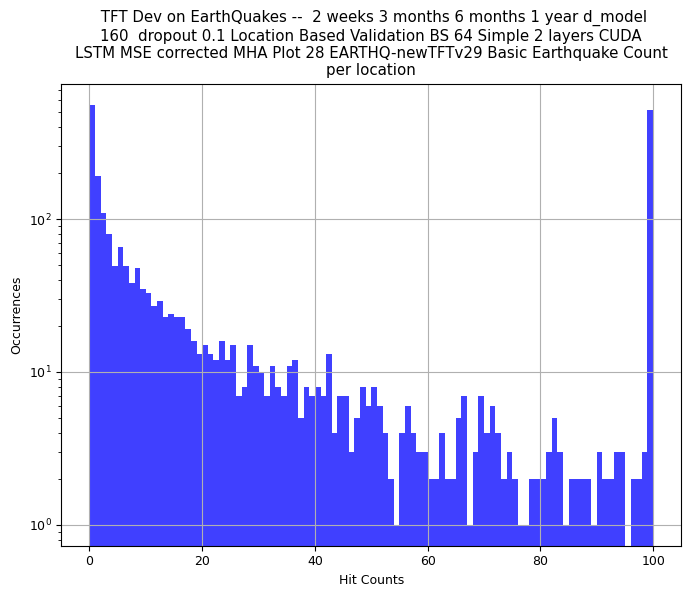

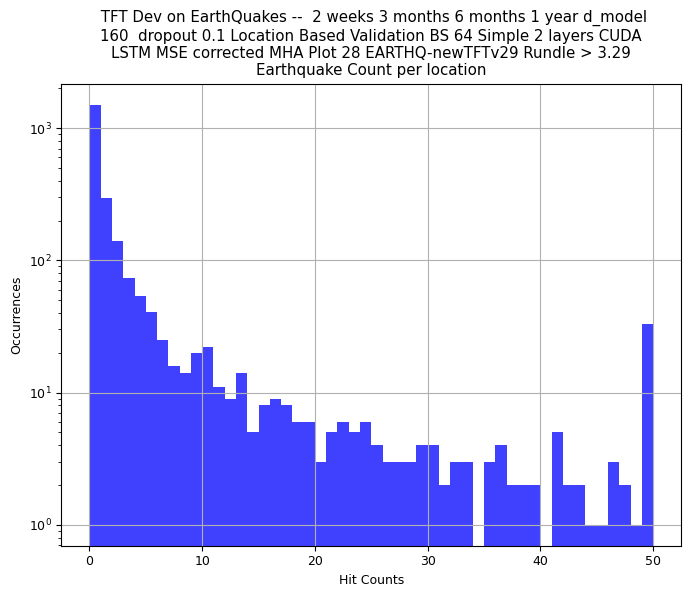

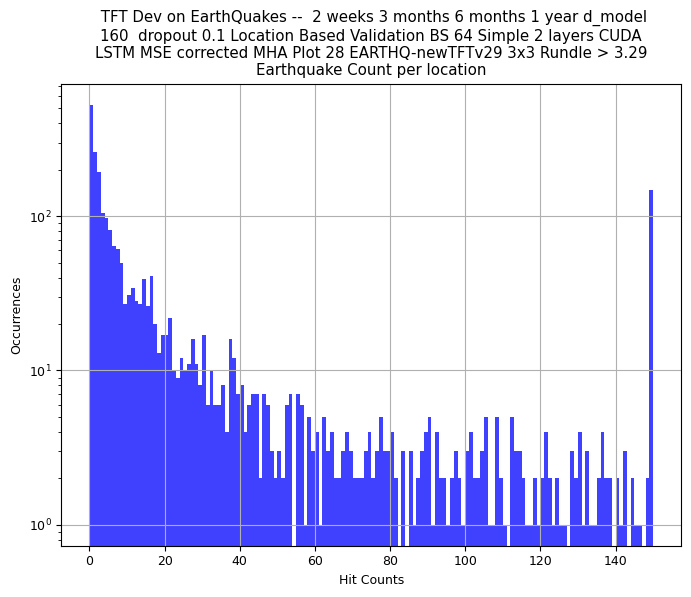

Total 500 Single location multiplicity cut 7.1 249 3x3 34.1 488


In [14]:
def histogrammultiplicity(Type, numbins, Data):
  hitcounts = np.zeros(Nloc, dtype=int)
  rawcounts = np.zeros(Nloc, dtype=int)

  for iloc in range(0,Nloc):
    rawcounts[iloc] = int(0.1+Data[:,iloc].sum(0))
    hitcounts[iloc] = int(min(numbins, rawcounts[iloc]))

  matplotlib.rcParams.update(matplotlib.rcParamsDefault)
  plt.rcParams.update({'font.size': 9})
  plt.rcParams["figure.figsize"] = [8,6]
  plt.hist(hitcounts, numbins,  facecolor='b', alpha=0.75, log=True)
  plt.title('\n'.join(wrap(RunComment + ' ' + RunName + ' ' + Type + ' Earthquake Count per location ',70)))
  plt.xlabel('Hit Counts')
  plt.ylabel('Occurrences')
  plt.grid(True)
  plt.show()
  return rawcounts

def threebythree(pixellocation,numxlocations,numylocations):
  indices = np.empty([3,3], dtype=int)
  
  y = int(0.1 + pixellocation/numxlocations)
  x = pixellocation - y*numxlocations
  bottomx = max(0,x-1)
  bottomx = min(bottomx,numxlocations-3)
  bottomy = max(0,y-1)
  bottomy = min(bottomy,numylocations-3)
  for ix in range(0,3):
    for iy in range(0,3):
      x= bottomx+ix
      y= bottomy+iy
      pixellocation = y*numxlocations + x
      indices[ix,iy] = pixellocation
  return indices

if Earthquake:
  MappedLocations = np.arange(0,Nloc, dtype=int)
  LookupLocations = np.arange(0,Nloc, dtype=int)
  MappedNloc = Nloc
  histogrammultiplicity('Basic', 100, BasicInputTimeSeries[:,:,2])
  nbins = 10
  if read1950:
    nbins= 50
  rawcounts1 = histogrammultiplicity('Rundle > 3.29', nbins, BasicInputTimeSeries[:,:,3])
  TempTimeSeries = np.zeros([Num_Time,Nloc],dtype = np.float32)
  for iloc in range (0,Nloc):
    indices = threebythree(iloc,60,40)
    for itime in range(0,Num_Time):
      sum3by3 = 0.0
      for ix in range(0,3):
        for iy in range(0,3):
          pixellocation = indices[ix,iy]
          sum3by3 += BasicInputTimeSeries[itime,pixellocation,3]
      TempTimeSeries[itime,iloc] = sum3by3
  nbins =40
  if read1950:
    nbins= 150
  rawcounts2 = histogrammultiplicity('3x3 Rundle > 3.29', nbins, TempTimeSeries)
#
# Define "Interesting Locations"
  if read1950:
    singleloccut = 25
    groupedloccut = 110
    singleloccut = 7.1
    groupedloccut = 34.1

#    groupedloccut = 1000000000
  else:
    singleloccut = 5.1
    groupedloccut = 24.9
  MappedLocations.fill(-1)
  MappedNloc = 0
  ct1 = 0
  ct2 = 0
  for iloc in range (0,Nloc):
    if rawcounts1[iloc] >= singleloccut:
      ct1 += 1
    if rawcounts2[iloc] >= groupedloccut:
      ct2 += 1
    if rawcounts1[iloc] < singleloccut and rawcounts2[iloc] < groupedloccut:
      continue
    MappedLocations[iloc] = MappedNloc
    MappedNloc += 1

  LookupLocations = None
  LookupLocations = np.empty(MappedNloc, dtype=int)

  for iloc in range (0,Nloc):
    jloc = MappedLocations[iloc]
    if jloc >= 0:
      LookupLocations[jloc] = iloc

  TempTimeSeries = None
  print('Total ' + str(MappedNloc) +
        ' Single location multiplicity cut ' + str(singleloccut) +
        ' ' + str(ct1) + ' 3x3 ' + str(groupedloccut) + ' ' + str(ct2))

  if UseEarthquakeEigenSystems:
    if Eigenvectors > 0:
      UseTopEigenTotal = 16
      UseTopEigenLocal = 0
      if Eigenvectors > 1:
        UseTopEigenLocal = 4
      Num_EigenProperties = UseTopEigenTotal + UseTopEigenLocal
      EigenTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      PsiTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      FiTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      EigenTimeSeries[:,:] = BasicInputTimeSeries[:,LookupLocations,3]
      StoreEigenvectors = np.zeros([Num_Time,MappedNloc,MappedNloc],dtype = np.float32)
      StoreEigencorrels = np.zeros([Num_Time,MappedNloc,MappedNloc],dtype = np.float32)
      StoreNormingfactor = np.zeros([Num_Time],dtype = np.float32)
      StoreNormingfactor1 = np.zeros([Num_Time],dtype = np.float32)
      StoreNormingfactor2 = np.zeros([Num_Time],dtype = np.float32)
      current_time = timenow()
      print(startbold + startred + 'Start Eigen Earthquake ' 
       + current_time + ' ' +RunName + resetfonts)
  
      for itime in range (0,Num_Time):
        imax = itime
        imin = max(0, imax-25)
        Result =  np.zeros(MappedNloc, dtype = np.float64)
        Result = AggregateEarthquakes(imin,0,imax-imin+1, MappedNloc, EigenTimeSeries[:,:], 2)
        PsiTimeSeries[itime,:] = Result
        FiTimeSeries[itime,:] = EigenTimeSeries[itime,:]
      
      current_time = timenow()
      print(startbold + startred + 'End Eigen Earthquake 1 ' 
       + current_time + ' ' +RunName + resetfonts)
      Eigenvals = np.zeros([Num_Time,MappedNloc], dtype = np.float32)
      Chi1 = np.zeros(Num_Time, dtype = np.float32)
      Chi2 = np.zeros(Num_Time, dtype = np.float32)
      Sumai = np.zeros(Num_Time, dtype = np.float32)
      Bestindex = np.zeros(Num_Time, dtype = int)
      Numbereigs = np.zeros(Num_Time, dtype = int)
      Besttrailingindex = np.zeros(Num_Time, dtype = int)

      Eig0coeff = np.zeros(Num_Time, dtype = np.float32)
      meanmethod = 0
      if meanmethod == 1:
        Meanovertime = np.empty(MappedNloc, dtype = np.float32)
        sigmaovertime = np.empty(MappedNloc, dtype = np.float32)
        Meanovertime = FiTimeSeries.mean(axis=0)
        Meanovertime = Meanovertime.reshape(1,MappedNloc)
        sigmaovertime = FiTimeSeries.std(axis=0)
        sigmaovertime = sigmaovertime.reshape(1,MappedNloc)
      countbad = 0
      OldActualNumberofLocationsUsed = -1
      for itime in range (25,Num_Time):
        LocationCounts = FiTimeSeries[0:itime,:].sum(axis=0)
        NumLocsToday = np.count_nonzero(LocationCounts)
        Nonzeromapping =  np.zeros(NumLocsToday, dtype = int)
        #gregor
        # Nonzeromapping =  np.zeros(NumLocsToday, dtype = int)
        ActualNumberofLocationsUsed = 0
        for ipos in range (0,MappedNloc):
          if LocationCounts[ipos] == 0:
            continue
          Nonzeromapping[ActualNumberofLocationsUsed] = ipos
          ActualNumberofLocationsUsed +=1
        if ActualNumberofLocationsUsed <= 1:
          print(str(itime) + ' Abandoned ' + str(ActualNumberofLocationsUsed))
          continue
        FiHatTimeSeries = np.empty([itime+1,ActualNumberofLocationsUsed], dtype = np.float32)
        if meanmethod == 1:
          FiHatTimeSeries[:,:] = np.divide(np.subtract(FiTimeSeries[0:(itime+1),Nonzeromapping],Meanovertime[0,Nonzeromapping]),
                                   sigmaovertime[0,Nonzeromapping])
        else:
          FiHatTimeSeries[:,:] = FiTimeSeries[0:(itime+1),Nonzeromapping]
#          FiHatTimeSeries[:,:] = PsiTimeSeries[0:(itime+1),Nonzeromapping]
        CorrelationMatrix = np.corrcoef(FiHatTimeSeries, rowvar =False)
        bad = np.count_nonzero(np.isnan(CorrelationMatrix))
        if bad > 0:
          countbad += 1
          continue
        evalues, evectors = solver.eigh(CorrelationMatrix)
        Newevector = evectors[:,ActualNumberofLocationsUsed-1] 
        Newevalue = evalues[ActualNumberofLocationsUsed-1]
        debug = False
        if debug:
          if OldActualNumberofLocationsUsed == ActualNumberofLocationsUsed:
            Mapdiff = np.where(np.not_equal(OldNonzeromapping,Nonzeromapping),1,0.).sum()
            if Mapdiff > 0: 
              print(str(itime) + ' Change in mapping ' + str(ActualNumberofLocationsUsed) + ' Change ' + str(Mapdiff))
            else:
              Corrdiff =  np.absolute(np.subtract(OldCorrelationMatrix,CorrelationMatrix)).sum()
              Corrorg = np.absolute(CorrelationMatrix).sum()
              yummy = CorrelationMatrix.dot(Oldevector)
              vTMv = yummy.dot(Oldevector)
              Doubleyummy = CorrelationMatrix.dot(Newevector)
              newvTMv = Doubleyummy.dot(Newevector)
              print(str(itime) + ' Change in correlation ' + str(ActualNumberofLocationsUsed) + ' Change '
              + str(Corrdiff) + ' original ' + str(Corrorg) + ' eval ' + str(Oldevalue) + ' new '
                + str(Newevalue) + ' vTMv ' + str(vTMv) + ' New ' + str(newvTMv))   

          else:
            print(str(itime) + ' Change in size ' + str(OldActualNumberofLocationsUsed) + ' ' +
                  str(ActualNumberofLocationsUsed))
        
        OldActualNumberofLocationsUsed = ActualNumberofLocationsUsed
        OldNonzeromapping = Nonzeromapping
        OldCorrelationMatrix = CorrelationMatrix
        Oldevector = Newevector
        Oldevalue = Newevalue
        
        normcoeff = 100.0/evalues.sum()
        evalues = np.multiply(evalues, normcoeff)
        Numbereigs[itime] = ActualNumberofLocationsUsed
 
        for ieig in range(0,ActualNumberofLocationsUsed):
          Eigenvals[itime, ieig] = evalues[ActualNumberofLocationsUsed-ieig-1]
        chival = 0.0
        sumaieig = 0.0
        Checkvector = np.zeros(ActualNumberofLocationsUsed,dtype = np.float32)
        largesteigcoeff = -1.0
        largestindex = -1

        Keepaisquared = np.zeros(ActualNumberofLocationsUsed, dtype=np.float32)
        for ieig in range(0,ActualNumberofLocationsUsed):
          aieig = 0.0
          backwards = ActualNumberofLocationsUsed-ieig-1
          for vectorindex in range(0,ActualNumberofLocationsUsed):
            StoreEigenvectors[itime,backwards,Nonzeromapping[vectorindex]] = evectors[vectorindex,ieig]
            aieig += evectors[vectorindex,ieig]*PsiTimeSeries[itime,Nonzeromapping[vectorindex]]
          for vectorindex in range(0,ActualNumberofLocationsUsed):
            Checkvector[vectorindex] += aieig*evectors[vectorindex, ieig]
          aieig *= aieig
          chival += aieig*evalues[ieig]
          sumaieig += aieig
          Keepaisquared[backwards] = aieig

        for ieig in range(0,ActualNumberofLocationsUsed): 
          backwards = ActualNumberofLocationsUsed-ieig-1 
          aieig = Keepaisquared[backwards]
          aieig = aieig/sumaieig
          if backwards == 0:
            Eig0coeff[itime] = aieig
          test = evalues[ieig]*aieig
          if test > largesteigcoeff:
            largesteigcoeff = test
            largestindex = backwards
        Bestindex[itime] = largestindex

        discrep = 0.0
        for vectorindex in range(0,ActualNumberofLocationsUsed):
          discrep += pow(Checkvector[vectorindex] - PsiTimeSeries[itime,Nonzeromapping[vectorindex]], 2)
        if discrep > 0.01:
          print('Eigendecomposition Failure ' + str(itime) + ' ' + str(discrep))
        Chi1[itime] = chival
        Chi2[itime] = chival/sumaieig
        Sumai[itime] = sumaieig

        largesteigcoeff = -1.0
        largestindex = -1
        sumaieig = 0.0
        Trailingtimeindex = itime-3
        if itime > 40:
          Trailinglimit = Numbereigs[Trailingtimeindex]
          KeepTrailingaisquared = np.zeros(Trailinglimit, dtype=np.float32)
          for ieig in range(0,Trailinglimit):
            aieig = 0.0
            for vectorindex in range(0,MappedNloc):
#              aieig += StoreEigenvectors[Trailingtimeindex,ieig,vectorindex]*PsiTimeSeries[itime,vectorindex]
              aieig += StoreEigenvectors[Trailingtimeindex,ieig,vectorindex]*StoreEigenvectors[itime,
                                                                                               Bestindex[itime],vectorindex]
            aieig *= aieig
            sumaieig += aieig
            KeepTrailingaisquared[ieig] = aieig

          for ieig in range(0,Trailinglimit): 
            aieig = KeepTrailingaisquared[ieig]
            aieig = aieig/sumaieig
            test = Eigenvals[Trailingtimeindex, ieig]*aieig
            if test > largesteigcoeff:
              largesteigcoeff = test
              largestindex = ieig
          Besttrailingindex[itime] = largestindex



        if itime >40: # Calculate eigenvector tracking
          Leader = StoreEigenvectors[itime,:,:]
          Trailer = StoreEigenvectors[itime-3,:,:]
          StoreEigencorrels[itime,:,:] = np.tensordot(Leader, Trailer, (1, (1)))
          StrippedDown = StoreEigencorrels[itime,Bestindex[itime],:]
          Normingfactor =  np.multiply(StrippedDown,StrippedDown).sum()
          Normingfactor1 =  np.multiply(StrippedDown[0:8],StrippedDown[0:8]).sum()
          Normingfactor2 =  np.multiply(StrippedDown[0:30],StrippedDown[0:30]).sum()
          StoreNormingfactor[itime] = Normingfactor
          StoreNormingfactor1[itime] = Normingfactor1
          StoreNormingfactor2[itime] = Normingfactor2

      averagesumai = Sumai.mean()
      Chi1 = np.divide(Chi1,averagesumai)
      print('Bad Correlation Matrices ' + str(countbad))
      print(startbold + startred + 'End Eigen Earthquake 2 ' 
       + current_time + ' ' +RunName + resetfonts)

    



In [15]:
def makeasmalldateplot(figure,ax, Dateaxis):
  plt.rcParams.update({'font.size': 9})
  months = mdates.MonthLocator(interval=2)   # every month
  datemin = np.datetime64(Dateaxis[0], 'M')
  datemax = np.datetime64(Dateaxis[-1], 'M') + np.timedelta64(1, 'M')
  ax.set_xlim(datemin, datemax)
  
  months_fmt = mdates.DateFormatter('%y-%b')
  locator = mdates.AutoDateLocator()
  locator.intervald['MONTHLY'] = [2]
  formatter = mdates.ConciseDateFormatter(locator)
#  ax.xaxis.set_major_locator(locator)
#  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(months_fmt)

  figure.autofmt_xdate()
  return datemin, datemax
  
def plotquakeregions(HalfSize,xaxisdates, SetofPlots, Commontitle, ylabel, SetofColors, Startx, ncols):
  numplotted = SetofPlots.shape[1]
  totusedquakes = 0
  for iquake in range(0,numberspecialeqs):
    x_line_index = Specialindex[iquake]
    if (x_line_index <= Startx) or (x_line_index >= Num_Time-1):
      continue 
    if Specialuse[iquake]:
      totusedquakes +=1
  nrows = math.ceil(totusedquakes/ncols)
  sortedquakes = np.argsort(Specialindex)

  jplot = 0
  kplot = -1
  for jquake in range(0,numberspecialeqs):
    iquake = sortedquakes[jquake]
    if not Specialuse[iquake]:
      continue
    x_line_annotation = Specialdate[iquake]
    x_line_index = Specialindex[iquake]
    if (x_line_index <= Startx) or (x_line_index >= Num_Time-1):
      continue 
    
    kplot +=1
    if kplot == ncols:
      
      plt.savefig(APPLDIR +'/Outputs/QRegions' + str(jplot) +RunName + '.png ',format='png')
      plt.show()
      kplot = 0
      jplot +=1
    if kplot == 0:
        plt.rcParams["figure.figsize"] = [16,6]
        figure, axs = plt.subplots(nrows=1, ncols=ncols, squeeze=False)

    beginplotindex = x_line_index - HalfSize
    beginplotindex = max(beginplotindex, Startx)
    endplotindex = x_line_index  + HalfSize
    endplotindex = min(endplotindex, Num_Time-1)

    eachplt = axs[0,kplot]
    ascii = ''      
    if Specialuse[iquake]:
      ascii = np.datetime_as_string(Specialdate[iquake]) + ' ' + str(round(Specialmags[iquake],1)) + ' ' + Specialeqname[iquake]
    eachplt.set_title(str(iquake) + ' ' + RunName + ' Best Eigenvalue (Black) Trailing (Red) \n' + ascii)
    datemin, datemax = makeasmalldateplot(figure, eachplt, xaxisdates[beginplotindex:endplotindex+1])
    for curves in range(0,numplotted):
      eachplt.plot(xaxisdates[beginplotindex:endplotindex+1], SetofPlots[beginplotindex:endplotindex+1,curves], 
                    'o', color=SetofColors[curves], markersize =1) 
    
    ymin, ymax = eachplt.get_ylim() 
    if ymax >= 79.9:
      ymax = 82
    eachplt.set_ylim(bottom=-1.0, top=max(ymax,20))
    eachplt.set_ylabel(ylabel)
    eachplt.set_xlabel('Time')
    eachplt.grid(True)
    eachplt.set_yscale("linear")
    eachplt.axvline(x=x_line_annotation, linestyle='dashed', alpha=1.0, linewidth = 2.0, color='red')
    for kquake in range(0,numberspecialeqs):
      if not Specialuse[kquake]:
        continue
      if kquake == iquake:
        continue
      anotherx_line_index = Specialindex[kquake]
      if (anotherx_line_index < beginplotindex) or (anotherx_line_index >= endplotindex):
        continue
      eachplt.axvline(x=Specialdate[kquake], linestyle='dashed', alpha=1.0, linewidth = 1.0, color='purple')
    eachplt.tick_params('x', direction = 'in', length=15, width=2, which='major')

 
  plt.savefig(APPLDIR +'/Outputs/QRegions' + str(jplot) +RunName + '.png ',format='png')
  plt.show()

EigenAnalysis = False
if Earthquake and EigenAnalysis:

  UseTopEigenTotal = 40
  FirstTopEigenTotal = 10
  PLTlabels = []
  for ieig in range(0,UseTopEigenTotal):
    PLTlabels.append('Eig-' + str(ieig))

  plt.rcParams["figure.figsize"] = [12,10]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,10]
  for ieig in range(0,FirstTopEigenTotal):
    ax.plot(Dateaxis[26:],np.maximum(Eigenvals[26:, ieig],0.1))
  
  ax.set_title(RunName + ' Multiplicity Eigenvalues')
  ax.set_ylabel('Eigenvalue')
  ax.set_xlabel('Time')
  ax.set_yscale("log")
  ax.grid(True)
  ax.legend(PLTlabels[0:FirstTopEigenTotal], loc='upper right')
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=True )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  plt.rcParams["figure.figsize"] = [12,10]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,10]
  for ieig in range(FirstTopEigenTotal,UseTopEigenTotal):
    ax.plot(Dateaxis[26:],np.maximum(Eigenvals[26:, ieig],0.1))
  
  ax.set_title(RunName + ' Multiplicity Eigenvalues')
  ax.set_ylabel('Eigenvalue')
  ax.set_xlabel('Time')
  ax.set_yscale("linear")
  ax.grid(True)
  ax.legend(PLTlabels[FirstTopEigenTotal:], loc='upper right')
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  ShowEigencorrels = False
  if ShowEigencorrels:
    for mastereig in range(0, UseTopEigenTotal):
      figure, ax = plt.subplots()
      plt.rcParams["figure.figsize"] = [12,8]
      datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
      for ieig in range(0,UseTopEigenTotal):
        alpha = 1.0
        width = 3
        if ieig == mastereig:
          alpha=0.5
          width = 1
        ax.plot(Dateaxis[26:],np.power(StoreEigencorrels[26:,mastereig,ieig],2), alpha=alpha, linewidth = width)
      ax.set_title(RunName + ' Eigenvalue ' + str(mastereig) + ' Current versus Past Total Correlation')
      ax.set_ylabel('Norm')
      ax.set_xlabel('Time')
      ax.grid(True)
      ax.legend(PLTlabels, loc='upper right')
      Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
      ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
      ax.xaxis.set_minor_locator(mdates.YearLocator(1))
      ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
      plt.show()

  
  # Gregor: creat functions for plots
  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor[26:], alpha=alpha, linewidth = width)
  ax.set_title(f'{RunName} Eigenvalue Full Norming Factor with Past')
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()


  # Gregor: creat functions for plots
  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor1[26:], alpha=alpha, linewidth = width)
  ax.set_title(f"{RunName} Eigenvalue First 8 Norming Factor with Past")
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  # Gregor: creat functions for plots
  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor2[26:], alpha=alpha, linewidth = width)
  ax.set_title(RunName + ' Eigenvalue First 30 Norming Factor with Past')
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  # Gregor: creat functions for plots
  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  ax.plot(Dateaxis[26:],Chi1[26:])

  ax.set_title(RunName + ' Correlations Normalized on average over time')
  ax.set_ylabel('Chi1')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  ax.plot(Dateaxis[26:],Chi2[26:])

  ax.set_title(RunName + ' Correlations Normalized at each time')
  ax.set_ylabel('Chi2')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  norm = np.amax(Chi1[26:])
  Maxeig = 80
 # ax.plot(Dateaxis[26:],Chi1[26:]*Maxeig/norm)
  ax.plot(Dateaxis[26:], 0.5 + np.minimum(Maxeig, Bestindex[26:]), 'o', color='black', markersize =1)
  ax.plot(Dateaxis[26:], np.minimum(Maxeig, Besttrailingindex[26:]), 'o', color='red', markersize =1)
  
  ax.set_title(RunName + ' Best Eigenvalue (Black) Trailing (Red)')
  ax.set_ylabel('Eig#')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  SetofPlots = np.empty([len(Bestindex),2], dtype=np.float32)
  SetofPlots[:,0] = 0.5 + np.minimum(Maxeig, Bestindex[:])
  SetofPlots[:,1] = np.minimum(Maxeig, Besttrailingindex[:])
  SetofColors = ['black',  'red']
  plotquakeregions(25, Dateaxis, SetofPlots,
              RunName + ' Best Eigenvalue (Black) Trailing (Red)', 'Eig#', SetofColors, 26,2)

  plt.rcParams["figure.figsize"] = [12,8]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  ax.plot(Dateaxis[26:], Eig0coeff[26:], 'o', color='black', markersize =2)
  ymin, ymax = ax.get_ylim() 
  ax.plot(Dateaxis[26:], Chi1[26:]*ymax/norm)
  
  ax.set_title(RunName + ' Fraction Largest Eigenvalue')
  ax.set_ylabel('Eig 0')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()


### End of Earthquake. Reset Timing

In [16]:
# Reset Start Date by a year so first entry has a 365 day sample ending at that day and so can be made an input as can all
# lower time intervals
# Do NOT include 2 year or 4 year in input stream
# So we reset start date by one year skipping first 364 daya except to calculate the first one year (and lower limit) observables
# Time indices go from 0 to NumberofTimeunits-1
# Sequence Indices go from Begin to Begin+Tseq-1 where Begin goes from 0 to NumberofTimeunits-1-Tseq
# So Num_Seq = Numberodays-Tseq and Begin has  Num_Seq values

if Earthquake:
  SkipTimeUnits = 364
  if Dailyunit == 14:
    SkipTimeUnits = 25
  Num_Time_old = NumberofTimeunits
  NumberofTimeunits = NumberofTimeunits - SkipTimeUnits
  Num_Time = NumberofTimeunits
  InitialDate = InitialDate  + timedelta(days=SkipTimeUnits*Dailyunit)
  FinalDate = InitialDate + timedelta(days=(NumberofTimeunits-1)*Dailyunit)
  print('Skip ' +str(SkipTimeUnits) + ' New dates: ' + InitialDate.strftime("%d/%m/%Y") + ' To '
   + FinalDate.strftime("%d/%m/%Y")+ ' days ' + str(NumberofTimeunits*Dailyunit))


  DynamicPropertyTimeSeries =  np.empty([Num_Time,Nloc,NpropperTimeDynamic],dtype = np.float32)
  CountNaN = np.zeros(NpropperTimeDynamic, dtype=int)

  # Skewtime makes certain propert ENDS at given cell and is the cell itself if size = DailyUnit
  SkewTime = [0] * NpropperTimeDynamicInput
  if Dailyunit == 1:
    SkewTime = SkewTime + [22,45,91,182,364,0,22,45,91,182,364]
  if Dailyunit == 14:
    SkewTime = SkewTime + [1, 3, 6, 12, 25,0,1, 3, 6, 12, 25]

  i = 0
  total = NumberofTimeunits * Nloc * NpropperTimeDynamic
  for itime in range(0,NumberofTimeunits):
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeDynamic):
        i = i + 1
        addtime = SkipTimeUnits - SkewTime[iprop]
        if iprop < NpropperTimeDynamicInput:
          # BUG HERE
          if i % 1000 == 0:
              print(itime+addtime,f"{i}/{total}", iloc,iprop)
          localval = BasicInputTimeSeries[itime+addtime,iloc,iprop]
        elif iprop < (NpropperTimeDynamic-5):
          localval = CalculatedTimeSeries[itime+addtime,iloc,iprop-NpropperTimeDynamicInput]
        else:
          localval = CalculatedTimeSeries[itime+addtime,iloc,iprop-NpropperTimeDynamicInput+4]
        if np.math.isnan(localval):
          localval = NaN
          CountNaN[iprop] +=1
        DynamicPropertyTimeSeries[itime,iloc,iprop] = localval
  print(startbold+startred+'Input NaN values ' + resetfonts)

  # Add E^0.25 Input Quantities
  MagnitudeMethod = MagnitudeMethodTransform
  jprop = 9 
  for iprop in range(0,9):
    line = ''
    if iprop == 0 or iprop > 3:
      DynamicPropertyTimeSeries[:,:,jprop] = TransformMagnitude(DynamicPropertyTimeSeries[:,:,iprop])
      jprop += 1
      line = ' New ' + str(jprop) + ' ' + InputPropertyNames[jprop+NpropperTimeStatic] + ' NaN ' + str(CountNaN[iprop]) 
    print(str(iprop) + ' ' + InputPropertyNames[iprop+NpropperTimeStatic] + ' NaN ' + str(CountNaN[iprop]) + line)
    
  NpropperTimeDynamic = jprop
  MagnitudeMethod = 0

  NewCalculatedTimeSeries =  np.empty([Num_Time,Nloc,NumTimeSeriesCalculated],dtype = np.float32)
#  NewCalculatedTimeSeries = CalculatedTimeSeries[SkipTimeUnits:Num_Time+SkipTimeUnits]
  NewCalculatedTimeSeries = TransformMagnitude(CalculatedTimeSeries[SkipTimeUnits:Num_Time+SkipTimeUnits])
  CalculatedTimeSeries = None
  CalculatedTimeSeries = NewCalculatedTimeSeries
  BasicInputTimeSeries = None
  if GarbageCollect:
    gc.collect()

  MagnitudeMethod = 0

  current_time = timenow()
  print(startbold + startred + 'Earthquake Setup ' + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)



Skip 25 New dates: 20/12/1950 To 18/12/2019 days 25214
Input NaN values 
0 Magnitude 2 weeks Now NaN 0 New 10 E^0.25 4 weeks Back NaN 0
1 Depth 2 weeks Now NaN 0
2 Multiplicity 2 weeks Now NaN 0
3 Mult >3.29 2 weeks Now NaN 0
4 Mag 4 Weeks Back NaN 0 New 11 E^0.25 2 Months Back NaN 0
5 Mag 2 Months Back NaN 0 New 12 E^0.25 3 Months Back NaN 0
6 Mag 3 Months Back NaN 0 New 13 E^0.25 6 Months Back NaN 0
7 Mag 6 Months Back NaN 0 New 14 E^0.25 Year Back NaN 0
8 Mag Year Back NaN 0 New 15 Mag 4 Weeks Ahead NaN 0
Earthquake Setup 03/06/2022, 12:12:33 UTC EARTHQ-newTFTv29  TFT Dev on EarthQuakes --  2 weeks 3 months 6 months 1 year d_model 160  dropout 0.1 Location Based Validation BS 64 Simple 2 layers CUDA LSTM MSE corrected MHA Plot 28


### Set Earthquake Execution Mode

In [17]:
if Earthquake:
  SymbolicWindows = True
  Tseq = 26
  if Dailyunit == 14:
    GenerateFutures = True
    UseFutures = True

### Plot Earthquake Images

Full Magnitude Ranges 0.11292288 37.928707


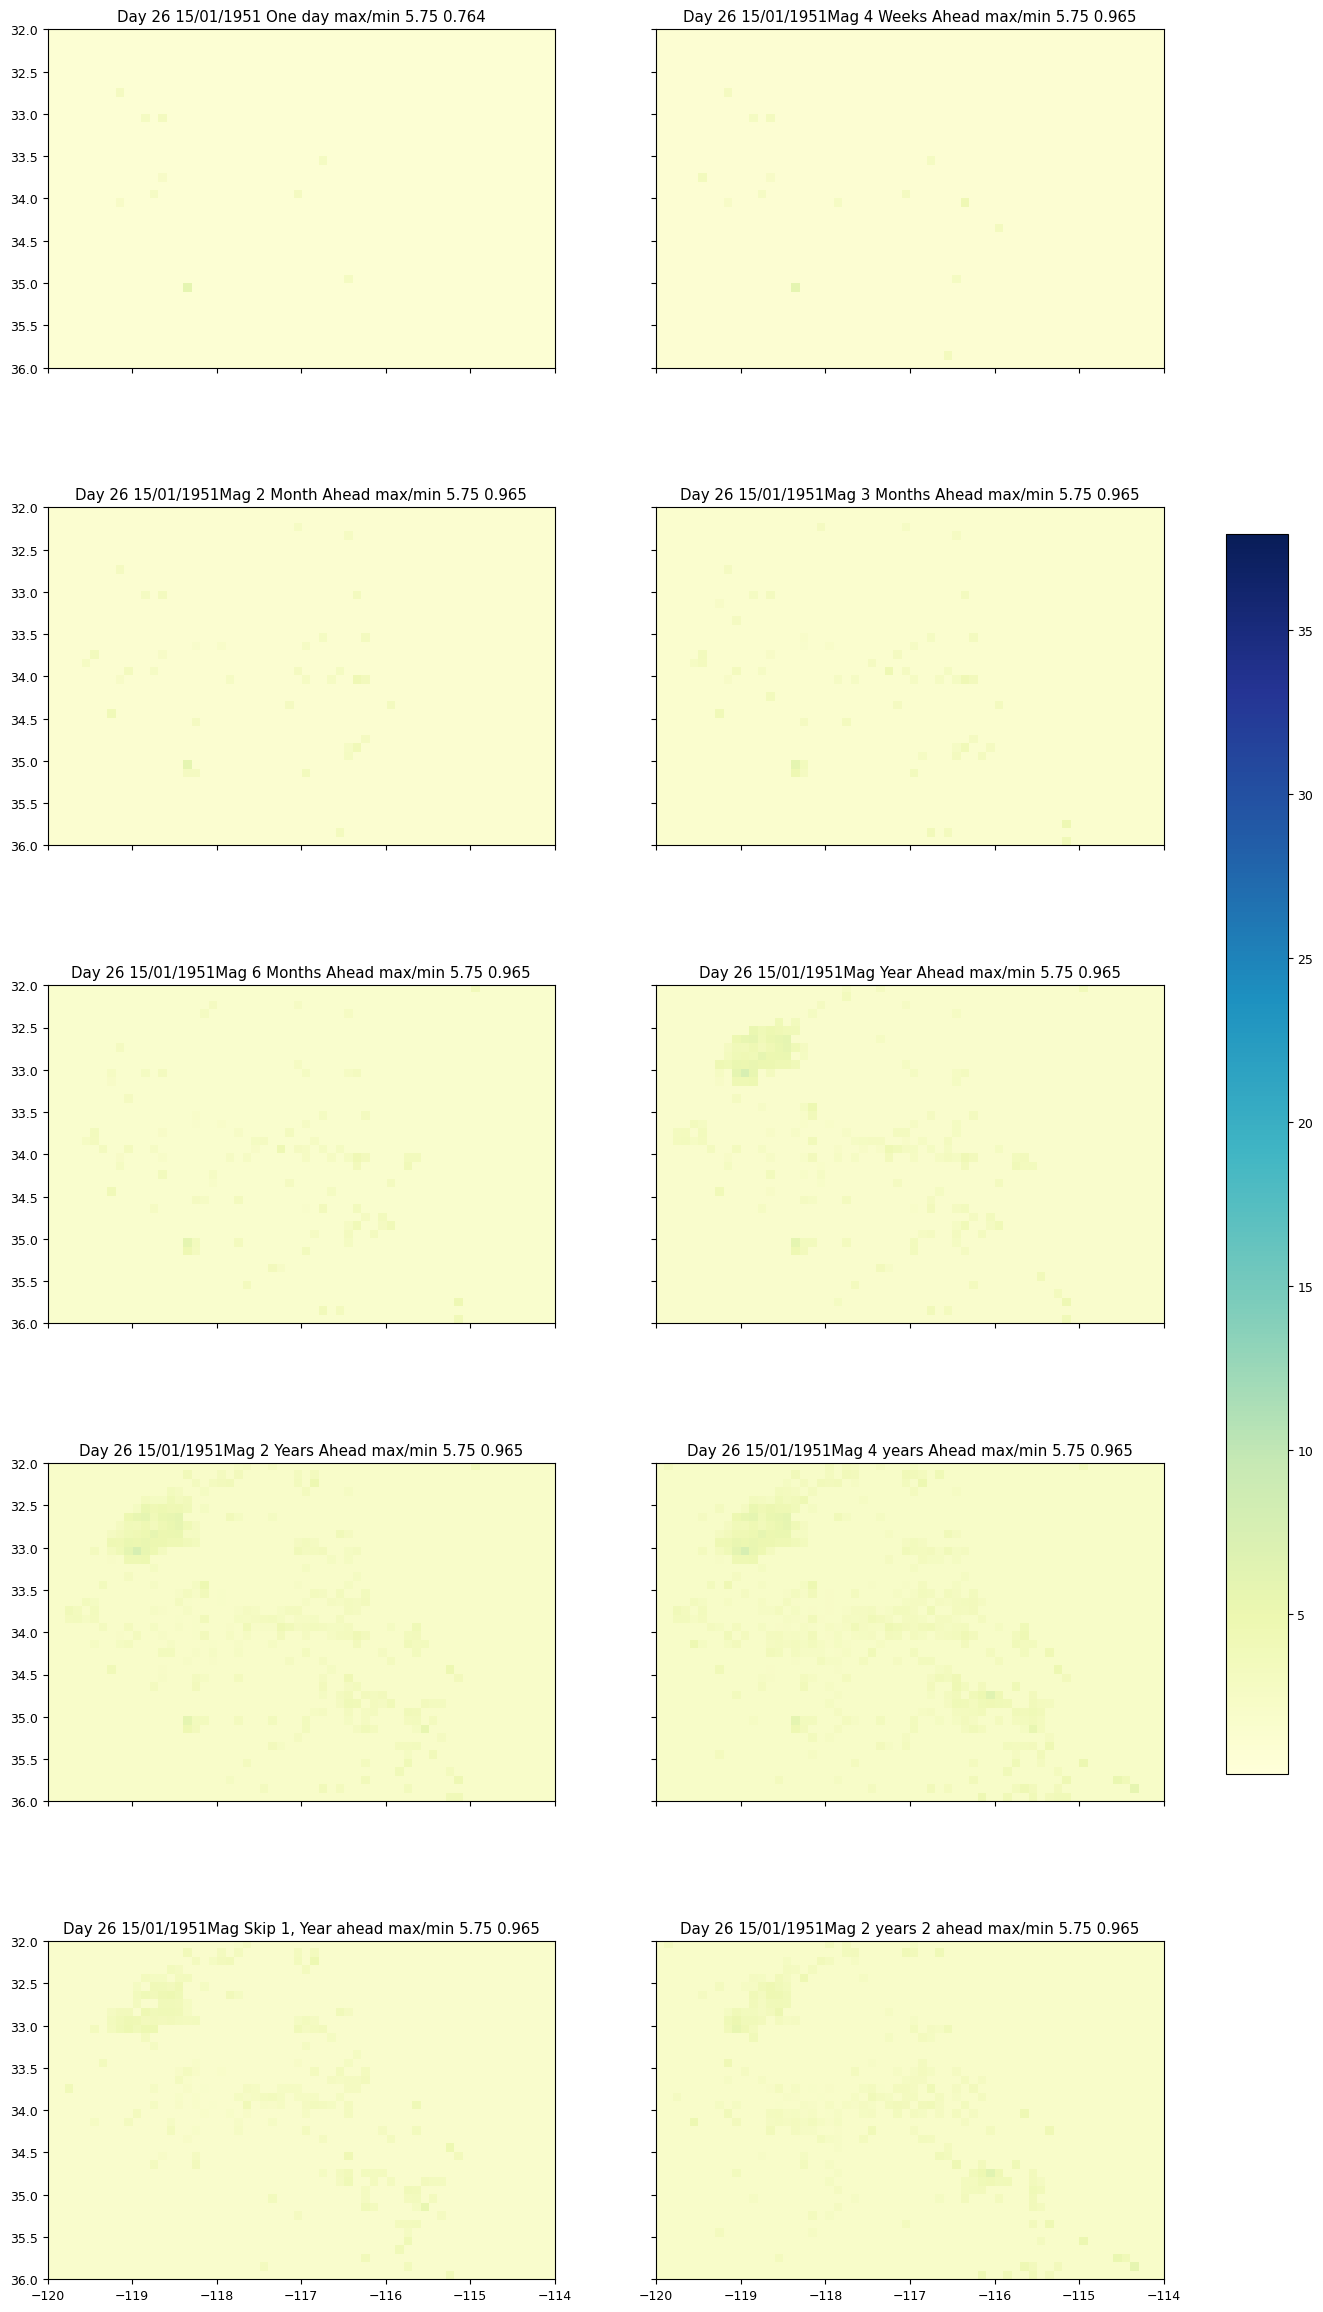

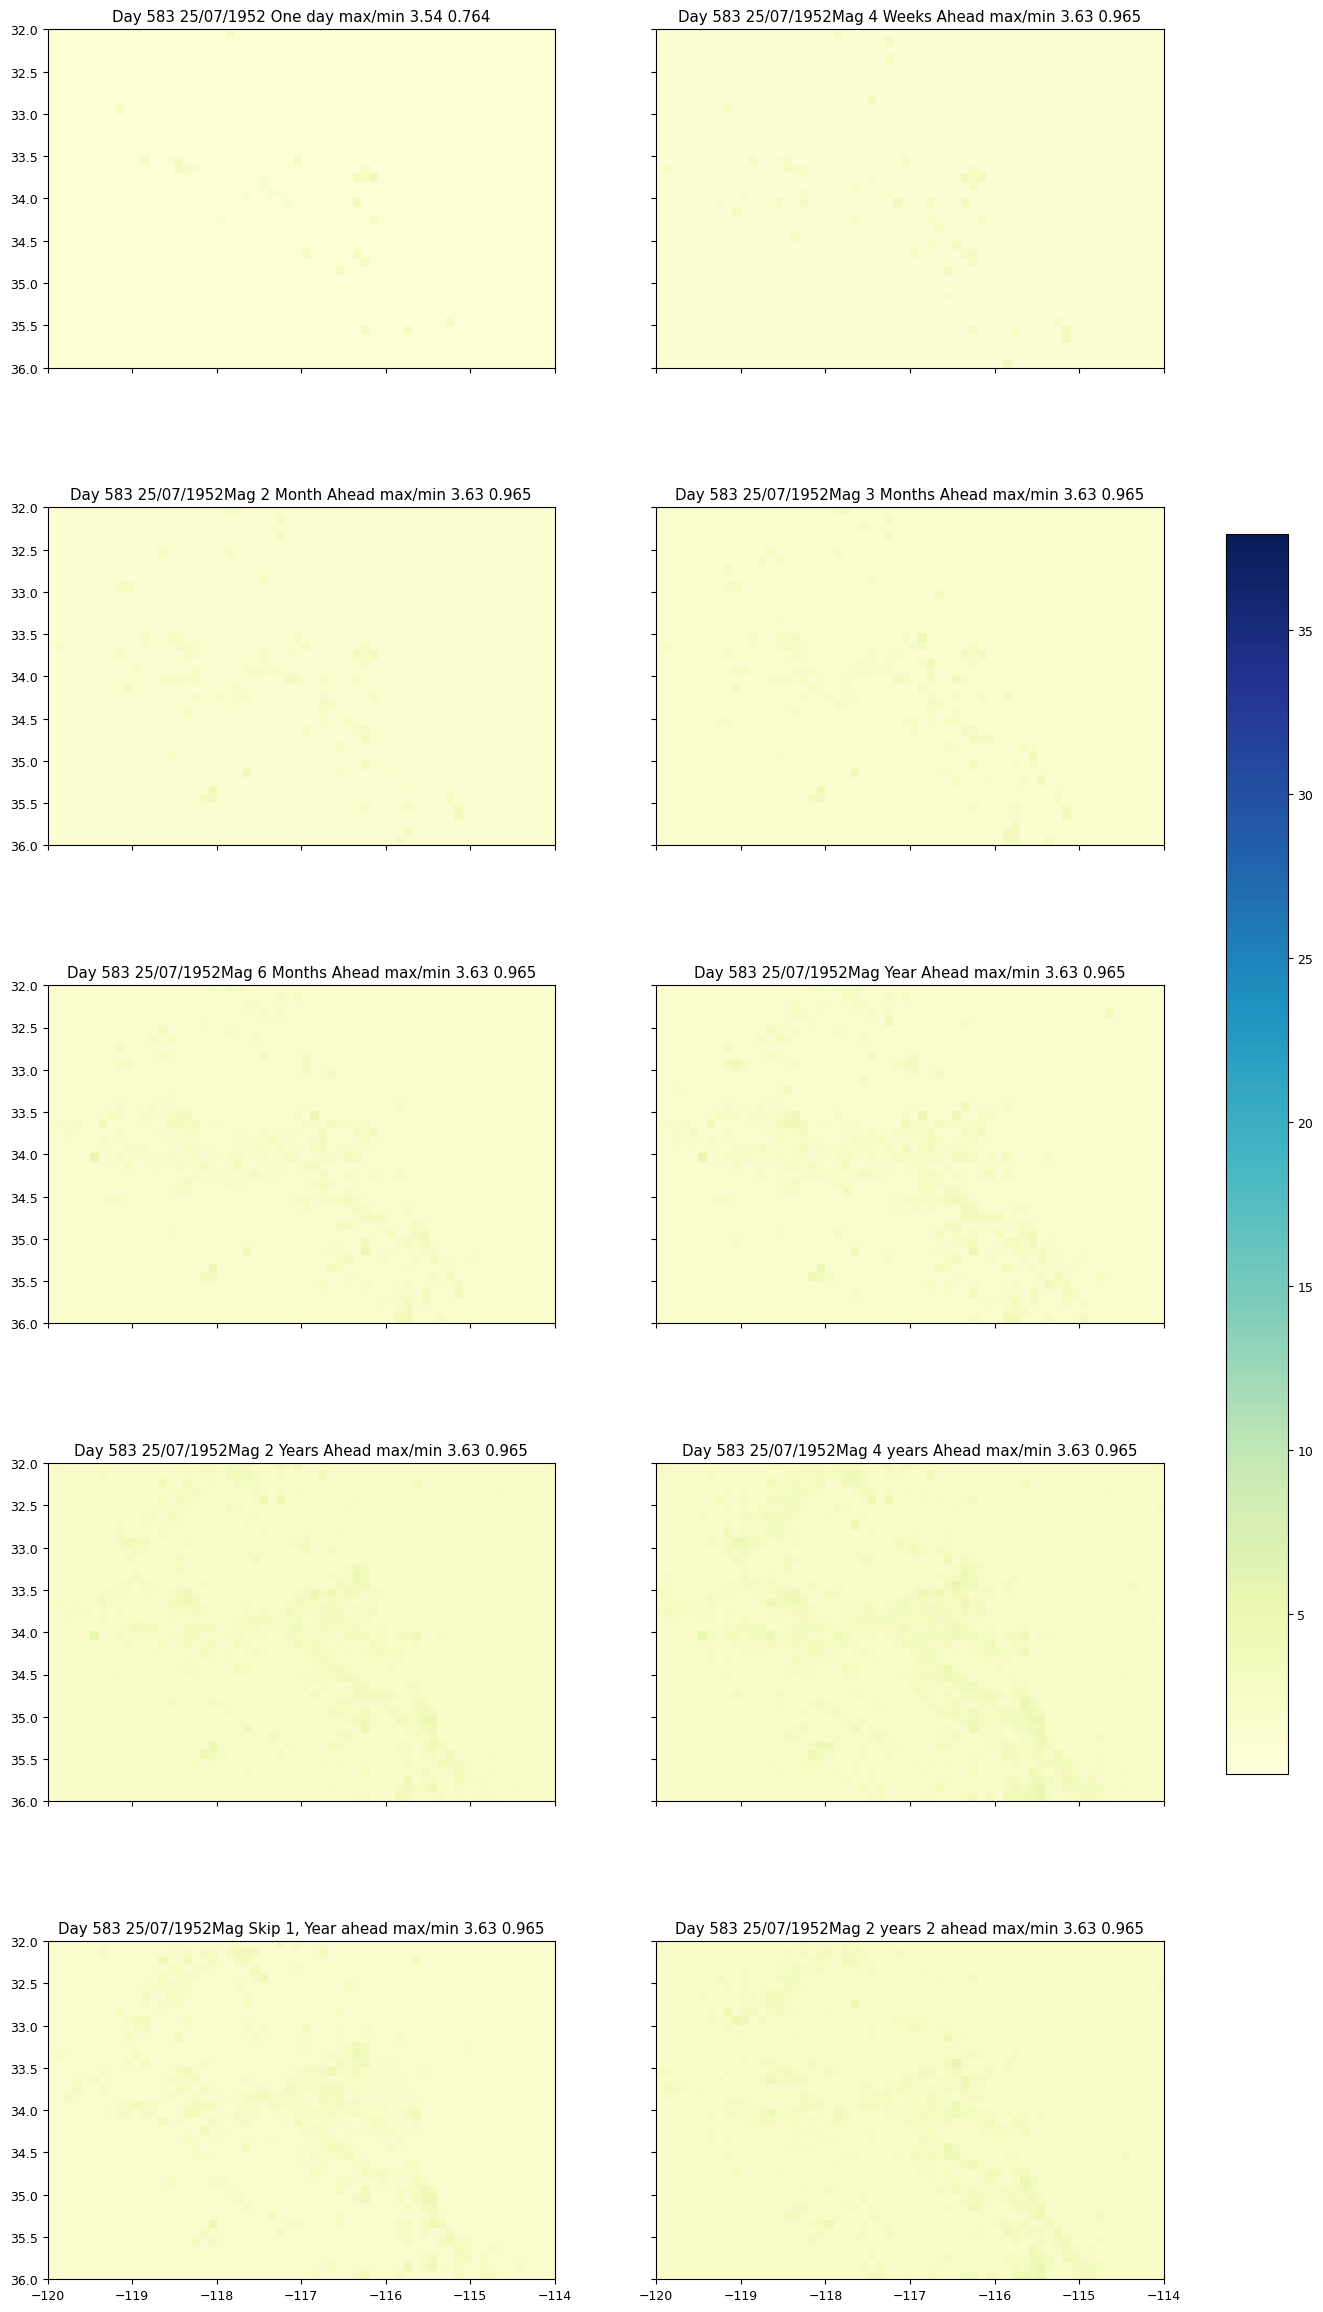

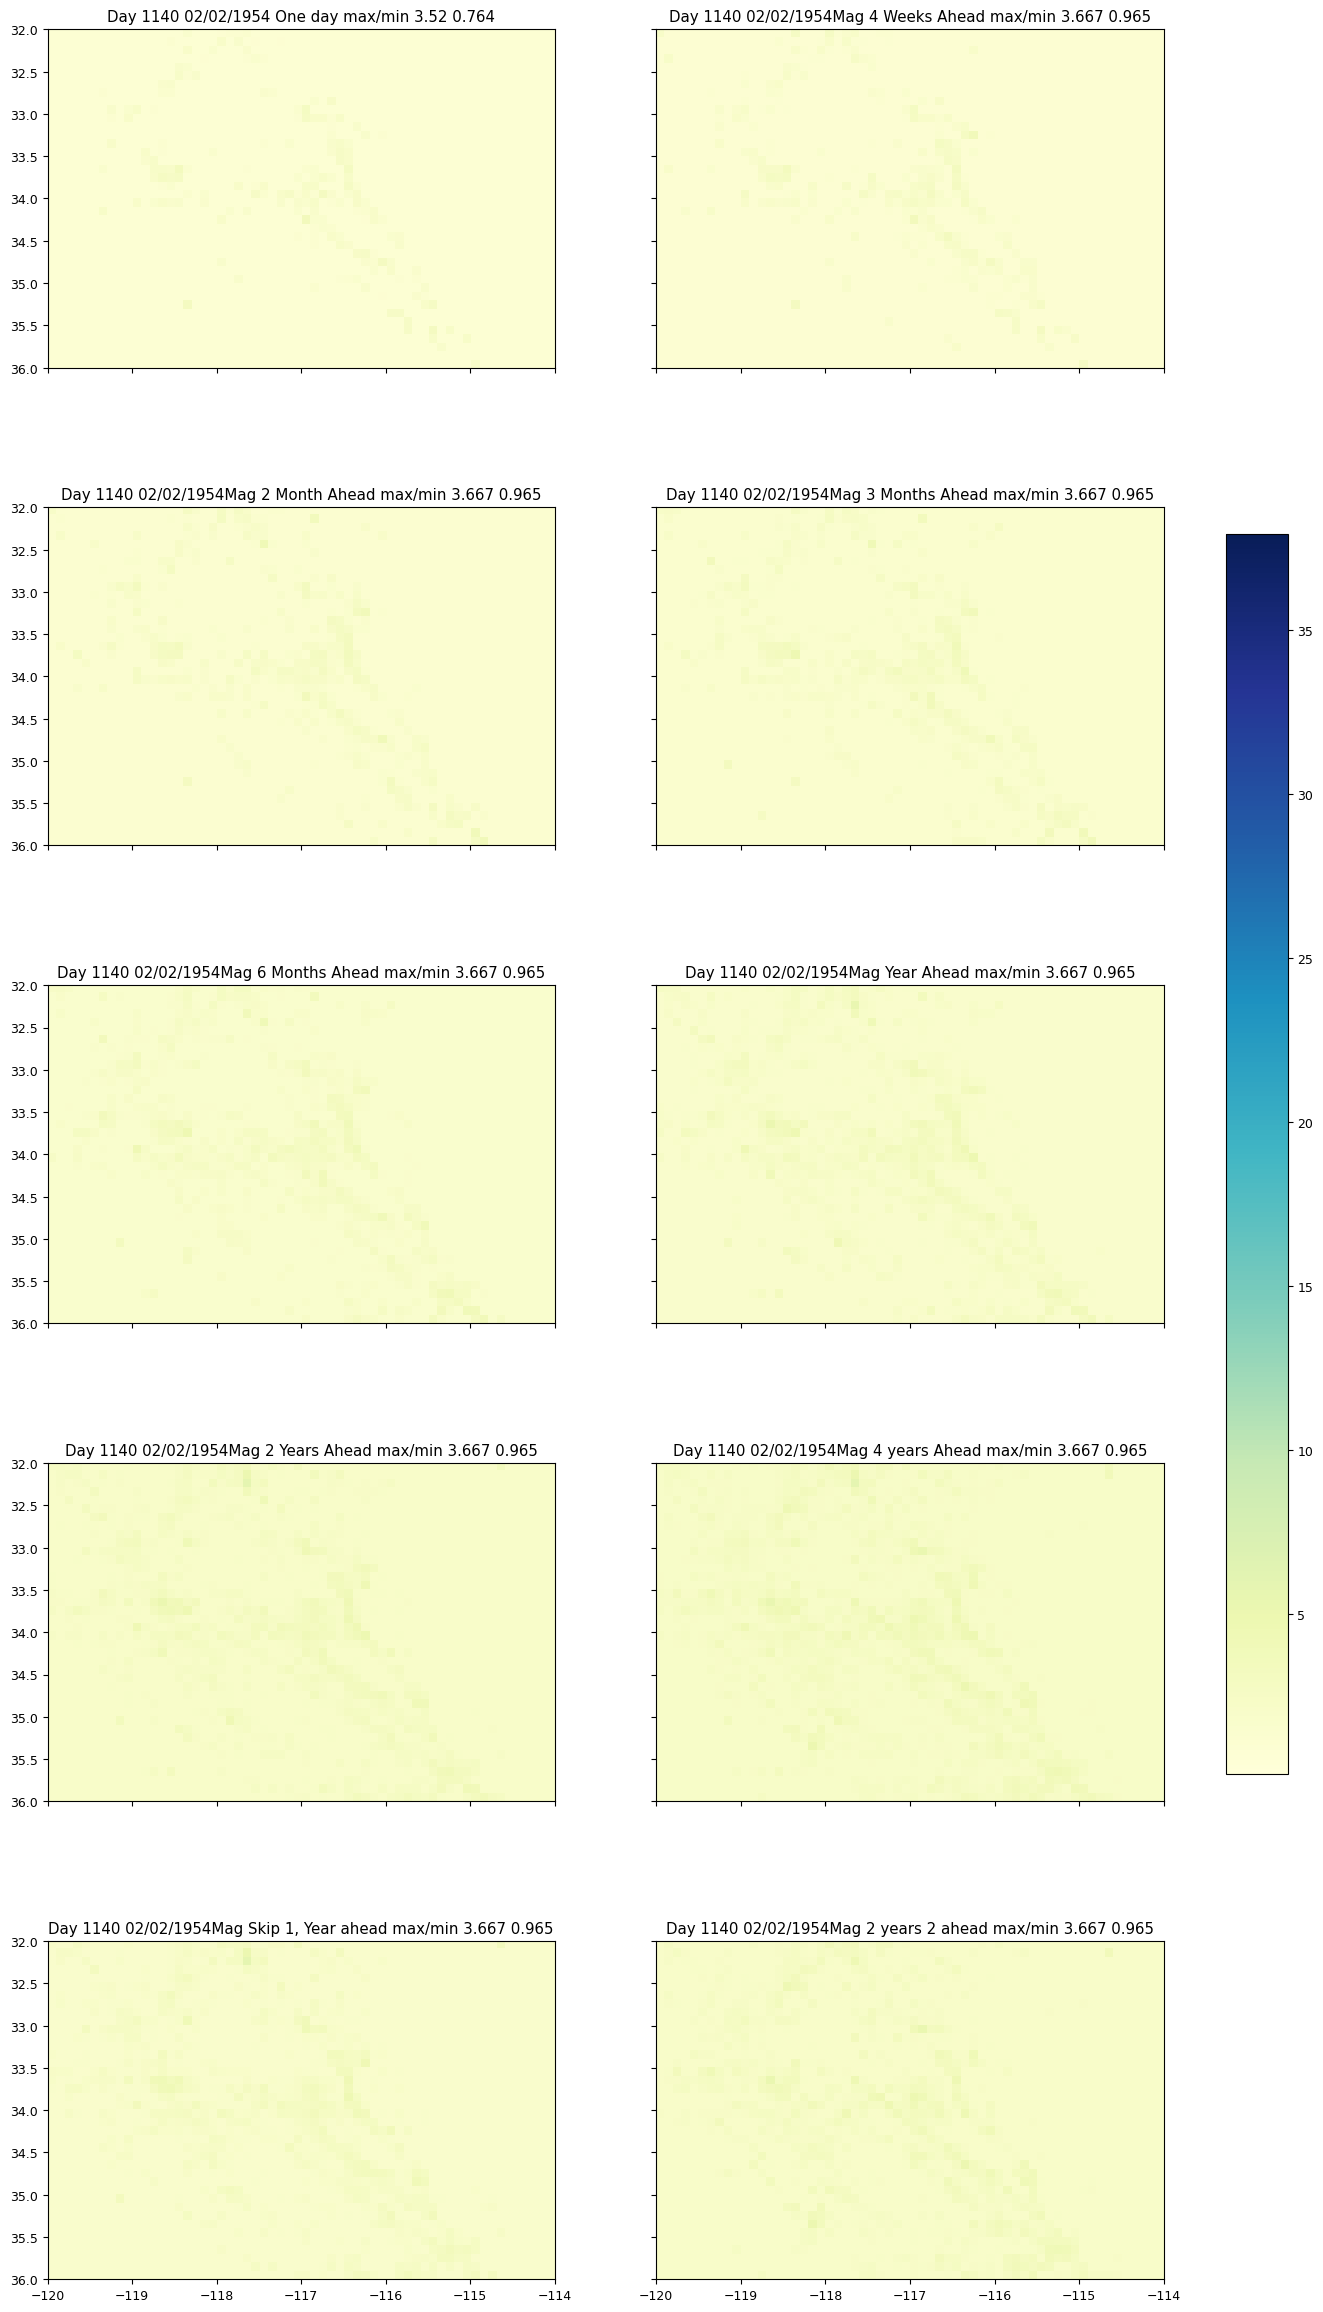

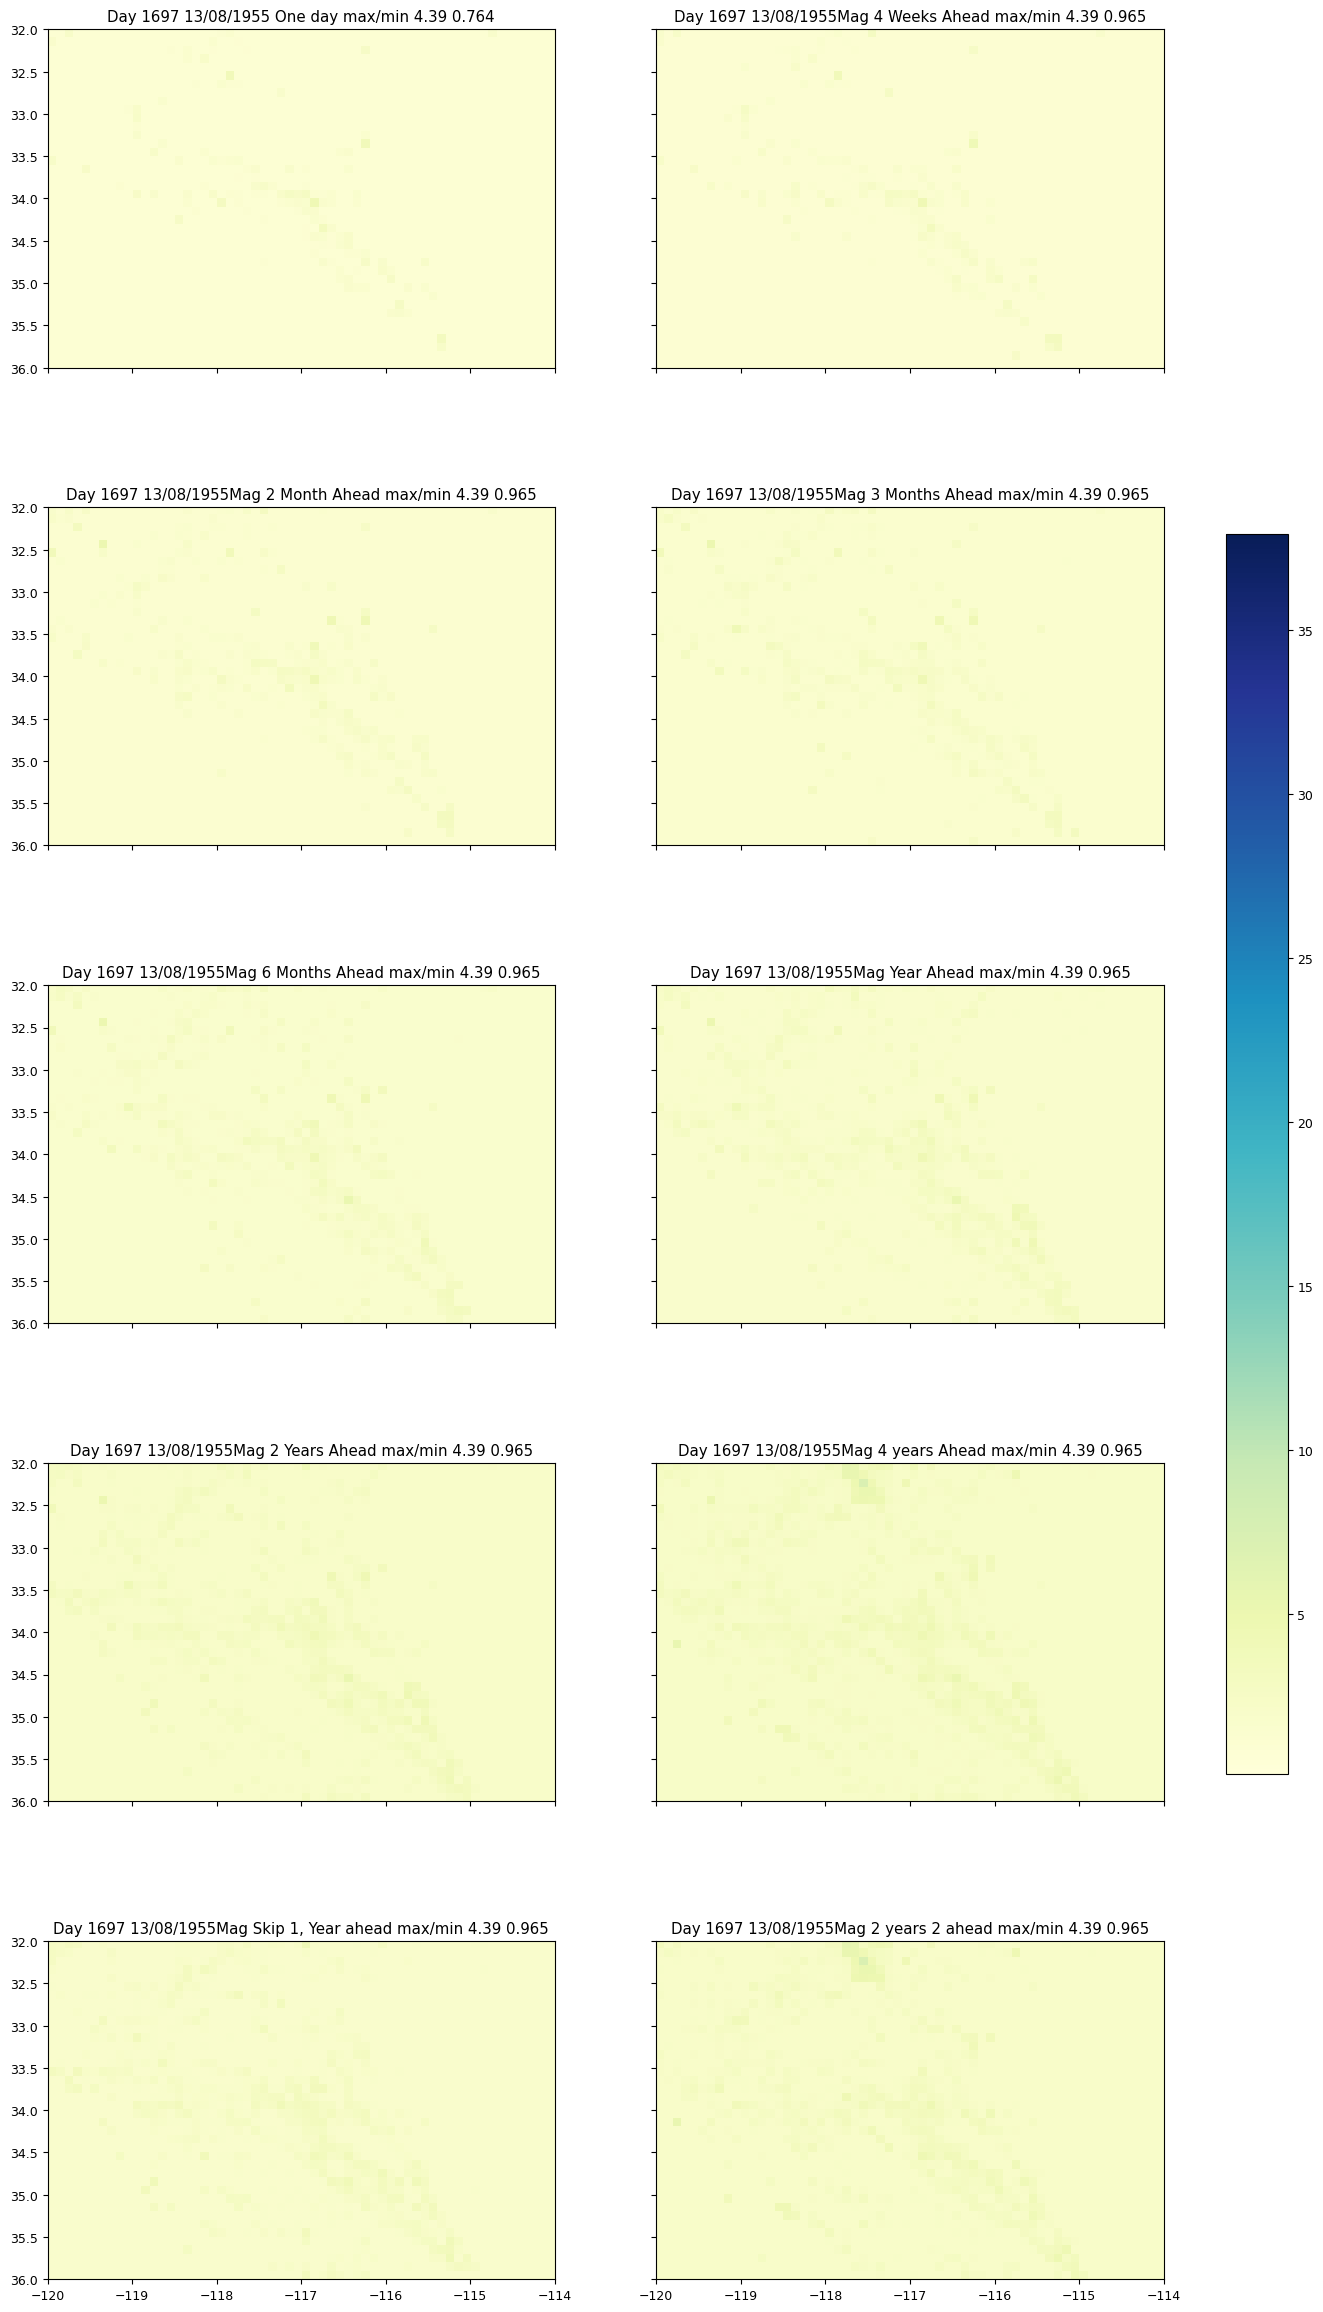

In [18]:
# Gregor: images are too faint


def plotimages(Array,Titles,nrows,ncols):
  usedcolormap = "YlGnBu"
  plt.rcParams["figure.figsize"] = [16,6*nrows]
  figure, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
  iplot=0
  images = []
  norm = colors.Normalize(vmin=fullmin, vmax=fullmax)
  for jplot in range(0,nrows):
    for kplot in range (0,ncols):
      eachplt = axs[jplot,kplot]
      if MapLocation:
        Plotit = np.zeros(OriginalNloc, dtype = np.float32)
        for jloc in range (0,Nloc):
          Plotit[LookupLocations[jloc]] = Array[iplot][jloc]
          TwoDArray = np.reshape(Plotit,(40,60))
      else:
        TwoDArray = np.reshape(Array[iplot],(40,60))
      extent = (-120,-114, 36,32)
      images.append(eachplt.imshow(TwoDArray, cmap=usedcolormap, norm=norm,extent=extent))
      eachplt.label_outer()
      eachplt.set_title(Titles[iplot])
      iplot +=1
  figure.colorbar(images[0], ax=axs, orientation='vertical', fraction=.05)
  plt.show()

if Earthquake:
# DynamicPropertyTimeSeries and CalculatedTimeSeries are dimensione by time 0 ...Num_Time-1
# DynamicPropertyTimeSeries holds values upto and including that time
# CalculatedTimeSeries holds values STARTING at that time
  fullmin = np.nanmin(CalculatedTimeSeries)
  fullmax = np.nanmax(CalculatedTimeSeries)
  fullmin = min(fullmin,np.nanmin(DynamicPropertyTimeSeries[:,:,0]))
  fullmax = max(fullmax,np.nanmax(DynamicPropertyTimeSeries[:,:,0]))
  print('Full Magnitude Ranges ' + str(fullmin) + ' ' + str(fullmax))
  Num_Seq = NumberofTimeunits-Tseq
  dayindexmax = Num_Seq-Plottingdelay
  Numdates = 4
  denom = 1.0/np.float64(Numdates-1)
  for plotdays in range(0,Numdates):
    dayindexvalue = math.floor(0.1 + (plotdays*dayindexmax)*denom)
    if dayindexvalue < 0:
      dayindexvalue = 0
    if dayindexvalue > dayindexmax:
      dayindexvalue = dayindexmax 
    dayindexvalue += Tseq
    InputImages =[]
    InputTitles =[]
    InputImages.append(DynamicPropertyTimeSeries[dayindexvalue,:,0])
    ActualDate = InitialDate + timedelta(days=dayindexvalue)
    localmax1 = DynamicPropertyTimeSeries[dayindexvalue,:,0].max()
    localmin1 = DynamicPropertyTimeSeries[dayindexvalue,:,0].min() 
    InputTitles.append('Day ' +str(dayindexvalue) + ' ' + ActualDate.strftime("%d/%m/%Y") + ' One day max/min '
     + str(round(localmax1,3)) + ' ' + str(round(localmin1,3))) 

    for localplot in range(0,NumTimeSeriesCalculated):
      localmax1 = CalculatedTimeSeries[dayindexvalue,:,0].max()
      localmin1 = CalculatedTimeSeries[dayindexvalue,:,0].min() 
      InputImages.append(CalculatedTimeSeries[dayindexvalue,:,localplot])
      InputTitles.append('Day ' +str(dayindexvalue) + ' ' + ActualDate.strftime("%d/%m/%Y") + NamespredCalculated[localplot] + ' max/min '
        + str(round(localmax1,3)) + ' ' + str(round(localmin1,3)))
    plotimages(InputImages,InputTitles,5,2)

### Read and setup NIH Covariates August 2020 and January, April 2021 Data

new collection of time dependent covariates (even if constant).

cases and deaths and location property from previous data


## Process Input Data  in various ways



### Set TFT Mode

In [19]:
UseTFTModel = True


### Convert Cumulative to Daily

In [20]:
# Gregor: DELETE

# Convert  cumulative to Daily. 
# Replace negative daily values by zero
# remove daily to sqrt(daily)  and Then normalize maximum to 1
if ConvertDynamicPredictedQuantity:
  NewBasicInputTimeSeries = np.empty_like(BasicInputTimeSeries, dtype=np.float32)
  Zeroversion = np.zeros_like(BasicInputTimeSeries, dtype=np.float32)
  Rolleddata = np.roll(BasicInputTimeSeries, 1, axis=0)
  Rolleddata[0,:,:] = Zeroversion[0,:,:]
  NewBasicInputTimeSeries = np.maximum(np.subtract(BasicInputTimeSeries,Rolleddata),Zeroversion)
  originalnumber = np.sum(BasicInputTimeSeries[NumberofTimeunits-1,:,:],axis=0)
  newnumber = np.sum(NewBasicInputTimeSeries,axis=(0,1))
  print('Original summed counts ' + str(originalnumber) + ' become ' + str(newnumber)+ ' Cases, Deaths')

  BasicInputTimeSeries = NewBasicInputTimeSeries


### Normalize All Static and Dynamic Properties

for Static Properties BasicInputStaticProps[Nloc,NpropperTimeStatic] converts to NormedInputStaticProps[Nloc,NpropperTimeStatic]

In [21]:
# Gregor: DELETE some portions of this to be reviewed

def SetTakeroot(x,n):
    if np.isnan(x):
      return NaN   
    if n == 3:
      return np.cbrt(x)
    elif n == 2:
      if x <= 0.0:
        return 0.0
      return np.sqrt(x) 
    return x 

def DynamicPropertyScaling(InputTimeSeries):
    Results = np.full(7, 0.0,dtype=np.float32)
    Results[1] = np.nanmax(InputTimeSeries, axis = (0,1))
    Results[0] = np.nanmin(InputTimeSeries, axis = (0,1))
    Results[3] = np.nanmean(InputTimeSeries, axis = (0,1))
    Results[4] = np.nanstd(InputTimeSeries, axis = (0,1))
    Results[2] = np.reciprocal(np.subtract(Results[1],Results[0]))
    Results[5] = np.multiply(Results[2],np.subtract(Results[3],Results[0]))
    Results[6] = np.multiply(Results[2],Results[4])
    return Results

NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated  
print(NpropperTimeStatic,NpropperTime,NumTimeSeriesCalculated, NpropperTimeMAX)
if ScaleProperties:
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=int)

# Scale data by roots if requested
  for iprop in range(0, NpropperTimeMAX):
    if QuantityTakeroot[iprop] >= 2:
      if iprop < NpropperTimeStatic:
        for iloc in range(0,Nloc):
          BasicInputStaticProps[iloc,iprop] = SetTakeroot(BasicInputStaticProps[iloc,iprop],QuantityTakeroot[iprop])
      elif iprop < NpropperTime:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic] = SetTakeroot(
                DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic],QuantityTakeroot[iprop])
      else:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            CalculatedTimeSeries[itime,iloc,iprop-NpropperTime] =SetTakeroot(
                CalculatedTimeSeries[itime,iloc,iprop-NpropperTime],QuantityTakeroot[iprop])

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  QuantityStatistics = np.zeros([NpropperTimeMAX,7], dtype=np.float32)
  if NpropperTimeStatic > 0:  
    print(BasicInputStaticProps.shape)
    max_value = np.amax(BasicInputStaticProps, axis = 0)
    min_value = np.amin(BasicInputStaticProps, axis = 0)
    mean_value = np.mean(BasicInputStaticProps, axis = 0)
    std_value = np.std(BasicInputStaticProps, axis = 0)
    normval = np.reciprocal(np.subtract(max_value,min_value))
    normed_mean = np.multiply(normval,np.subtract(mean_value,min_value))
    normed_std = np.multiply(normval,std_value)
    QuantityStatistics[0:NpropperTimeStatic,0] = min_value
    QuantityStatistics[0:NpropperTimeStatic,1] = max_value
    QuantityStatistics[0:NpropperTimeStatic,2] = normval
    QuantityStatistics[0:NpropperTimeStatic,3] = mean_value
    QuantityStatistics[0:NpropperTimeStatic,4] = std_value
    QuantityStatistics[0:NpropperTimeStatic,5] = normed_mean
    QuantityStatistics[0:NpropperTimeStatic,6] = normed_std

    NormedInputStaticProps =np.empty_like(BasicInputStaticProps)
    for iloc in range(0,Nloc):
      NormedInputStaticProps[iloc,:] = np.multiply((BasicInputStaticProps[iloc,:] - min_value[:]),normval[:])

  if (NpropperTimeDynamic > 0) or (NumTimeSeriesCalculated>0):
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      QuantityStatistics[iprop,:] = DynamicPropertyScaling(DynamicPropertyTimeSeries[:,:,iprop-NpropperTimeStatic])
    for iprop in range(0,NumTimeSeriesCalculated):
      QuantityStatistics[iprop+NpropperTime,:] = DynamicPropertyScaling(CalculatedTimeSeries[:,:,iprop]) 

    NormedDynamicPropertyTimeSeries = np.empty_like(DynamicPropertyTimeSeries)
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      NormedDynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic] = np.multiply((DynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
    
    if NumTimeSeriesCalculated > 0:
      NormedCalculatedTimeSeries = np.empty_like(CalculatedTimeSeries)
      for iprop in range(NpropperTime,NpropperTimeMAX):
        NormedCalculatedTimeSeries[:,:,iprop - NpropperTime] = np.multiply((CalculatedTimeSeries[:,:,iprop - NpropperTime]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
      CalculatedTimeSeries = None
  
    BasicInputStaticProps = None
    DynamicPropertyTimeSeries = None
    print(startbold + "Properties scaled" +resetfonts)

  line = 'Name   '
  for propval in range (0,7):
    line += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold +startpurple + line + resetfonts)
  for iprop in range(0,NpropperTimeMAX):
    if iprop == NpropperTimeStatic:
      print('\n')
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[iprop] + resetfonts  + ' Root ' + str(QuantityTakeroot[iprop])
    for propval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[iprop,propval],3))
    print(line)


4 19 19 38
(2400, 4)
Properties scaled

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    
0 Fault 0 Root 1 0.0 35.0 0.029 19.907 10.724 0.569 0.306
1 Fault 1 Root 1 0.0 35.0 0.029 16.798 12.233 0.48 0.35
2 Fault 2 Root 1 0.0 35.0 0.029 12.897 9.145 0.368 0.261
3 Fault 3 Root 1 0.0 35.0 0.029 13.528 12.019 0.387 0.343


4 Magnitude 2 weeks Now Root 1 0.764 7.501 0.148 0.804 0.241 0.006 0.036
5 Depth 2 weeks Now Root 1 -2.108 81.795 0.012 0.269 1.606 0.028 0.019
6 Multiplicity 2 weeks Now Root 1 0.0 3038.0 0.0 0.141 4.662 0.0 0.002
7 Mult >3.29 2 weeks Now Root 1 0.0 86.0 0.012 0.002 0.151 0.0 0.002
8 Mag 4 Weeks Back Root 1 0.965 7.501 0.153 1.022 0.279 0.009 0.043
9 Mag 2 Months Back Root 1 1.165 7.501 0.158 1.244 0.32 0.012 0.05
10 Mag 3 Months Back Root 1 1.327 7.501 0.162 1.428 0.354 0.016 0.057
11 Mag 6 Months Back Root 1 1.507 7.501 0.167 1.637 0.395 0.022 0.066
12 Mag Year Back Root 1 1.707 7.501 0.173 1.877 0.442 0.029 0.076
13 E^0.25 2 weeks Back Root 1 

### Set up Futures

-- currently at unit time level 

In [22]:
class Future:
    def __init__(self, name, daystart = 0, days =[], wgt=1.0, classweight = 1.0):
        self.name = name
        self.days = np.array(days)
        self.daystart = daystart
        self.wgts = np.full_like(self.days,wgt,dtype=float)
        self.size = len(self.days)
        self.classweight = classweight

LengthFutures = 0
Unit = "Day"
if Earthquake:
  Unit = "2wk"
if GenerateFutures: 

  Futures =[]
  daylimit = 14
  if Earthquake:
    daylimit = 25
  for ifuture in range(0,daylimit):
    xx = Future(Unit + '+' + str(ifuture+2), days=[ifuture+2])
    Futures.append(xx)
  LengthFutures = len(Futures)
  Futuresmaxday = 0
  Futuresmaxweek = 0
  for i in range(0,LengthFutures):
      j = len(Futures[i].days)
      if j == 1:
          Futuresmaxday = max(Futuresmaxday, Futures[i].days[0])
      else:
          Futuresmaxweek = max(Futuresmaxweek, Futures[i].days[j-1])
      Futures[i].daystart -= Dropearlydata
      if Futures[i].daystart < 0: Futures[i].daystart = 0
      if Earthquake:
        Futures[i].daystart = 0



### Set up mappings of locations

In next cell, we map locations for BEFORE location etc added

In cell after that we do same for sequences

In [23]:
OriginalNloc = Nloc
if Earthquake:
  MapLocation = True

  MappedDynamicPropertyTimeSeries =  np.empty([Num_Time,MappedNloc,NpropperTimeDynamic],dtype = np.float32)
  MappedNormedInputStaticProps = np.empty([MappedNloc,NpropperTimeStatic],dtype = np.float32)
  MappedCalculatedTimeSeries =  np.empty([Num_Time,MappedNloc,NumTimeSeriesCalculated],dtype = np.float32)
  
  print(LookupLocations)
  MappedDynamicPropertyTimeSeries[:,:,:] = NormedDynamicPropertyTimeSeries[:,LookupLocations,:]
  NormedDynamicPropertyTimeSeries = None
  NormedDynamicPropertyTimeSeries = MappedDynamicPropertyTimeSeries
  
  MappedCalculatedTimeSeries[:,:,:] = NormedCalculatedTimeSeries[:,LookupLocations,:]
  NormedCalculatedTimeSeries = None
  NormedCalculatedTimeSeries = MappedCalculatedTimeSeries

  MappedNormedInputStaticProps[:,:] = NormedInputStaticProps[LookupLocations,:]
  NormedInputStaticProps = None
  NormedInputStaticProps = MappedNormedInputStaticProps

  Nloc = MappedNloc
  if GarbageCollect:
    gc.collect()
  print('Number of locations reduced to ' + str(Nloc))

else:
  MappedLocations = np.arange(0,Nloc, dtype=int)
  LookupLocations = np.arange(0,Nloc, dtype=int)
  MappedNloc = Nloc


[  15   16   17   18   19   20   21   22   23   24   25   26   75   76
   77   78   79   80   81   82   83   84   85   86  138  139  140  141
  142  143  144  145  146  198  199  200  201  202  203  204  205  206
  207  252  253  254  255  256  257  263  264  265  266  267  311  312
  313  314  315  316  317  325  326  327  371  372  373  374  375  376
  430  431  432  433  434  435  436  487  488  489  490  491  492  493
  494  495  496  506  509  510  511  547  548  549  550  551  552  553
  554  555  569  570  571  572  607  608  609  610  611  612  613  629
  630  631  632  635  636  637  668  669  670  671  689  690  691  692
  695  696  697  753  754  755  756  757  758  812  813  814  815  816
  817  818  854  855  856  857  872  873  874  875  876  877  878  912
  913  914  915  916  917  930  931  932  933  934  935  936  937  938
  962  963  964  972  973  974  975  976  977  989  990  991  992  993
  994  995  996  997  998 1022 1023 1024 1032 1033 1034 1035 1036 1037
 1042 

###Property and Prediction  Data Structures

Two important Lists Properties and Predictions that are related

 * Data stored in series is for properties, the calculated value occuring at or ending that day
 * For predictions, the data is the calculated value from that date or later. 

 * We store data labelled by time so that
  * for inputs we use time 0 upto last value - 1 i.e. position [length of array - 1]
  * for outputs (predictions) with sequence Tseq, we use array locations [Tseq] to [length of array -1]
  * This implies Num_Seq = Num_Time - Tseq


**Properties**

Everything appears in Property list -- both input and output (predicted)
DynamicPropertyTimeSeries holds input property time series where value is value at that time using data before this time for aggregations
  * NpropperTimeStatic is the number of static properties -- typically read in or calculated from input information
  * NpropperTimeDynamicInput is total number of input time series
  * NpropperTimeDynamicCalculated is total number of calculated dynamic quantities  used in Time series analysis as input properties and/or output predictions
  * NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated ONLY includes input properties
  * NpropperTime = NpropperTimeStatic + NpropperTimeDynamic will not include futures and NOT include calculated predictions
  * InputPropertyNames is a list of size NpropperTime holding names
  * NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated has calculated predictions following input properties ignoring futures 
  * QuantityStatistics has 7 statistics used in normalizing for NpropperTimeMAX properties
  * Normalization takes NpropperTimeStatic static features in BasicInputStaticProps and stores in NormedInputStaticProps
  * Normalization takes NpropperTimeDynamicInput dynamic features in BasicInputTimeSeries and stores in NormedInputTimeSeries
  * Normalization takes NpropperTimeDynamicCalculated dynamic features in DynamicPropertyTimeSeries and stores in NormedDynamicPropertyTimeSeries

**Predictions**

 * NumpredbasicperTime can be 1 upto NpropperTimeDynamic and are part of dynamic input series. It includes input values that are to be predicted (these MUST be at start) plus NumTimeSeriesCalculated calculated series
 * NumpredFuturedperTime is <= NumpredbasicperTime and is the number of input dynamic series that are futured
 * NumTimeSeriesCalculated is number of calculated (not as futures) time series stored in CalculatedTimeSeries and names in NamespredCalculated
 * Typically NumpredbasicperTime = NumTimeSeriesCalculated + NumpredFuturedperTime (**Currently this is assumed**)
 * Normalization takes NumTimeSeriesCalculated calculated series in CalculatedTimeSeries and stores in NormedCalculatedTimeSeries
 * Predictions per Time are  NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
 * Predictions per sequence Npredperseq = NpredperTime



### Set Requested Properties Predictions Encodings

In [24]:
# FuturePred = -1 Means NO FUTURE >= 0 FUTURED
# BASIC EARTHQUAKE SET JUST LOG ENERGY AND MULTIPLICITY
if Earthquake:
  InputSource = ['Static','Static','Static','Static','Dynamic','Dynamic','Dynamic','Dynamic'
    ,'Dynamic','Dynamic','Dynamic','Dynamic','Dynamic']
  InputSourceNumber = [0,1,2,3,0,1,2,3,4,5,6,7,8]

  PredSource = ['Dynamic','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc']
  PredSourceNumber = [0,0,1,2,3,4,5,6,7,8]

  FuturedPred = [-1]*len(PredSource)

  # Earthquake Space-Time
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PropValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

  PredTypes =  ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PredValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

  if UseTFTModel:
    InputSource = ['Static','Static','Static','Static','Dynamic','Dynamic','Dynamic','Dynamic'
      ,'Dynamic','Dynamic','Dynamic','Dynamic','Dynamic']
    InputSourceNumber = [0,1,2,3,0,1,2,3,4,5,6,7,8]

    PredSource = ['Dynamic','Dynamic']
    PredSourceNumber = [0,7]

    PredTypes =[]
    PredValues = []
    FuturedPred = [1,1]

    #TFT2 1 year
    PredSource = ['Dynamic','Dynamic','Dynamic','Dynamic']
    PredSourceNumber = [0,6,7,8]
    FuturedPred = [1,1,1,1]


### Choose Input and Predicted Quantities

In [25]:
# Gregor: DELETE some portions of this, review and identify

if len(InputSource) != len(InputSourceNumber):
  printexit(' Inconsistent Source Lengths ' + str(len(InputSource)) + ' ' +str(len(InputSourceNumber)) )
if len(PredSource) != len(PredSourceNumber):
  printexit(' Inconsistent Prediction Lengths ' + str(len(PredSource)) + ' ' + str(len(PredSourceNumber)) )

# Executed by all even if GenerateFutures false except for direct Romeo data
if not UseFutures:
  LengthFutures = 0
print(startbold + "Number of Futures -- separate for each regular prediction " +str(LengthFutures) + resetfonts)
Usedaystart = False

if len(PredSource) > 0: # set up Predictions
  NumpredbasicperTime = len(PredSource)
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=int)
  NumpredFuturedperTime = 0
  NumpredfromInputsperTime = 0
  for ipred in range(0,len(PredSource)):
    if PredSource[ipred] == 'Dynamic':
      NumpredfromInputsperTime += 1
  countinputs = 0
  countcalcs = 0
  for ipred in range(0,len(PredSource)):
    if not(PredSource[ipred] == 'Dynamic' or PredSource[ipred] == 'Calc'):
      printexit('Illegal Prediction ' + str(ipred) + ' ' + PredSource[ipred])
    if PredSource[ipred] == 'Dynamic':
      countinputs += 1 
    else:
      countcalcs += 1
    if FuturedPred[ipred] >= 0:
      if LengthFutures > 0:
        FuturedPred[ipred] = NumpredFuturedperTime
        FuturedPointer[ipred] = NumpredFuturedperTime
        NumpredFuturedperTime += 1
      else:
        FuturedPred[ipred] = -1

else: # Set defaults
  NumpredfromInputsperTime = NumpredFuturedperTime
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=int)
  PredSource =[]
  PredSourceNumber = []
  FuturedPred =[]
  futurepos = 0
  for ipred in range(0,NumpredFuturedperTime): 
    PredSource.append('Dynamic')
    PredSourceNumber.append(ipred)
    futured = -1
    if LengthFutures > 0:
      futured = futurepos
      FuturedPointer[ipred] = futurepos
      futurepos += 1
    FuturedPred.append(futured)
  for ipred in range(0,NumTimeSeriesCalculated):
    PredSource.append('Calc')
    PredSourceNumber.append(ipred)
    FuturedPred.append(-1) 
  print('Number of Predictions ' + str(len(PredSource)))   


PropertyNameIndex = np.empty(NpropperTime, dtype = np.int32)
PropertyAverageValuesPointer = np.empty(NpropperTime, dtype = np.int32)
for iprop in range(0,NpropperTime):
  PropertyNameIndex[iprop] = iprop # names
  PropertyAverageValuesPointer[iprop] = iprop # normalizations

# Reset Source -- if OK as read don't set InputSource InputSourceNumber
# Reset NormedDynamicPropertyTimeSeries and NormedInputStaticProps
# Reset NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
if len(InputSource) > 0: # Reset Input Source
  NewNpropperTimeStatic = 0
  NewNpropperTimeDynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      NewNpropperTimeStatic += 1
    if InputSource[isource] == 'Dynamic':
      NewNpropperTimeDynamic += 1
  NewNormedDynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,NewNpropperTimeDynamic],dtype = np.float32)  
  NewNormedInputStaticProps = np.empty([Nloc,NewNpropperTimeStatic],dtype = np.float32)
  NewNpropperTime = NewNpropperTimeStatic + NewNpropperTimeDynamic
  NewPropertyNameIndex = np.empty(NewNpropperTime, dtype = np.int32)
  NewPropertyAverageValuesPointer = np.empty(NewNpropperTime, dtype = np.int32)
  countstatic = 0
  countdynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      OldstaticNumber = InputSourceNumber[isource]
      NewNormedInputStaticProps[:,countstatic] = NormedInputStaticProps[:,OldstaticNumber]
      NewPropertyNameIndex[countstatic] = PropertyNameIndex[OldstaticNumber]
      NewPropertyAverageValuesPointer[countstatic] = PropertyAverageValuesPointer[OldstaticNumber]
      countstatic += 1

    elif InputSource[isource] == 'Dynamic':
      OlddynamicNumber =InputSourceNumber[isource]
      NewNormedDynamicPropertyTimeSeries[:,:,countdynamic] = NormedDynamicPropertyTimeSeries[:,:,OlddynamicNumber]
      NewPropertyNameIndex[countdynamic+NewNpropperTimeStatic] = PropertyNameIndex[OlddynamicNumber+NpropperTimeStatic]
      NewPropertyAverageValuesPointer[countdynamic+NewNpropperTimeStatic] = PropertyAverageValuesPointer[OlddynamicNumber+NpropperTimeStatic]
      countdynamic += 1
    
    else:
     printexit('Illegal Property ' + str(isource) + ' ' + InputSource[isource]) 

else: # pretend data altered
  NewPropertyNameIndex = PropertyNameIndex
  NewPropertyAverageValuesPointer = PropertyAverageValuesPointer
  NewNpropperTime = NpropperTime
  NewNpropperTimeStatic = NpropperTimeStatic
  NewNpropperTimeDynamic = NpropperTimeDynamic

  NewNormedInputStaticProps = NormedInputStaticProps
  NewNormedDynamicPropertyTimeSeries = NormedDynamicPropertyTimeSeries



Number of Futures -- separate for each regular prediction 25


### Calculate Futures

Start Predictions

In [26]:
# Order of Predictions *****************************
# Basic "futured" Predictions from property dynamic arrays
# Additional predictions without futures and NOT in property arrays including Calculated time series
# LengthFutures predictions for first NumpredFuturedperTime predictions
# Special predictions (temporal, positional) added later
NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
Npredperseq = NpredperTime
Predictionbasicname = [' '] * NumpredbasicperTime
for ipred in range(0,NumpredbasicperTime):
  if PredSource[ipred] == 'Dynamic':
    Predictionbasicname[ipred] = InputPropertyNames[PredSourceNumber[ipred]+NpropperTimeStatic]
  else:
    Predictionbasicname[ipred]= NamespredCalculated[PredSourceNumber[ipred]]

TotalFutures = 0
if NumpredFuturedperTime <= 0:
  GenerateFutures = False
if GenerateFutures:
  TotalFutures = NumpredFuturedperTime * LengthFutures
print(startbold + 'Predictions Total ' + str(Npredperseq) + ' Basic ' + str(NumpredbasicperTime) + ' Of which futured are '
  + str(NumpredFuturedperTime) + ' Giving number explicit futures ' + str(TotalFutures) + resetfonts )
Predictionname = [' '] * Npredperseq
Predictionnametype = [' '] * Npredperseq
Predictionoldvalue = np.empty(Npredperseq, dtype=int)
Predictionnewvalue = np.empty(Npredperseq, dtype=int)
Predictionday = np.empty(Npredperseq, dtype=int)
PredictionAverageValuesPointer = np.empty(Npredperseq, dtype=int)
Predictionwgt = [1.0] * Npredperseq
for ipred in range(0,NumpredbasicperTime):
  Predictionnametype[ipred] = PredSource[ipred]
  Predictionoldvalue[ipred] = PredSourceNumber[ipred]
  Predictionnewvalue[ipred] = ipred
  if PredSource[ipred] == 'Dynamic':
    PredictionAverageValuesPointer[ipred] = NpropperTimeStatic + Predictionoldvalue[ipred]
  else:
    PredictionAverageValuesPointer[ipred] = NpropperTime + PredSourceNumber[ipred]
  Predictionwgt[ipred] = 1.0
  Predictionday[ipred] = 1
  extrastring =''
  Predictionname[ipred] = 'Next ' + Predictionbasicname[ipred]
  if FuturedPred[ipred] >= 0:
    extrastring = ' Explicit Futures Added '   
  print(str(ipred)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[ipred]) + ' ' + Predictionname[ipred]
      + ' Weight ' + str(round(Predictionwgt[ipred],3)) + ' Day ' + str(Predictionday[ipred]) + extrastring )

for ifuture in range(0,LengthFutures):
  for ipred in range(0,NumpredbasicperTime):
    if FuturedPred[ipred] >= 0:
      FuturedPosition = NumpredbasicperTime + NumpredFuturedperTime*ifuture + FuturedPred[ipred]
      Predictionname[FuturedPosition] = Predictionbasicname[ipred] + ' ' + Futures[ifuture].name
      Predictionday[FuturedPosition] = Futures[ifuture].days[0]
      Predictionwgt[FuturedPosition] = Futures[ifuture].classweight
      Predictionnametype[FuturedPosition] = Predictionnametype[ipred]
      Predictionoldvalue[FuturedPosition] = Predictionoldvalue[ipred]
      Predictionnewvalue[FuturedPosition] = Predictionnewvalue[ipred]
      PredictionAverageValuesPointer[FuturedPosition] = PredictionAverageValuesPointer[ipred]
      print(str(iprop)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[FuturedPosition]) + ' ' + 
        Predictionname[FuturedPosition] + ' Weight ' + str(round(Predictionwgt[FuturedPosition],3))
         + ' Day ' + str(Predictionday[FuturedPosition]) + ' This is Explicit Future ')

Predictionnamelookup = {}
print(startbold + '\nBasic Predicted Quantities' + resetfonts)
for ipred in range(0,Npredperseq):
  Predictionnamelookup[Predictionname[ipred]] = ipred

  iprop = Predictionnewvalue[ipred]
  line = startbold + startred + Predictionbasicname[iprop]
  line += ' Weight ' + str(round(Predictionwgt[ipred],4))
  if (iprop < NumpredFuturedperTime) or (iprop >= NumpredbasicperTime):
    line += ' Day= ' + str(Predictionday[ipred])
    line += ' Name ' + Predictionname[ipred]
  line += resetfonts
  jpred = PredictionAverageValuesPointer[ipred]
  line += ' Processing Root ' + str(QuantityTakeroot[jpred])
  for proppredval in range (0,7):
      line += ' ' + QuantityStatisticsNames[proppredval] + ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
  print(wraptotext(line,size=150))
  
  print(line)

  # Note that only Predictionwgt and Predictionname defined for later addons

Predictions Total 104 Basic 4 Of which futured are 4 Giving number explicit futures 100
0 Internal Property # 4 Next Magnitude 2 weeks Now Weight 1.0 Day 1 Explicit Futures Added 
1 Internal Property # 10 Next Mag 3 Months Back Weight 1.0 Day 1 Explicit Futures Added 
2 Internal Property # 11 Next Mag 6 Months Back Weight 1.0 Day 1 Explicit Futures Added 
3 Internal Property # 12 Next Mag Year Back Weight 1.0 Day 1 Explicit Futures Added 
18 Internal Property # 4 Magnitude 2 weeks Now 2wk+2 Weight 1.0 Day 2 This is Explicit Future 
18 Internal Property # 10 Mag 3 Months Back 2wk+2 Weight 1.0 Day 2 This is Explicit Future 
18 Internal Property # 11 Mag 6 Months Back 2wk+2 Weight 1.0 Day 2 This is Explicit Future 
18 Internal Property # 12 Mag Year Back 2wk+2 Weight 1.0 Day 2 This is Explicit Future 
18 Internal Property # 4 Magnitude 2 weeks Now 2wk+3 Weight 1.0 Day 3 This is Explicit Future 
18 Internal Property # 10 Mag 3 Months Back 2wk+3 Weight 1.0 Day 3 This is Explicit Future 
18 

### Set up Predictions 

first for time arrays; we will extend to sequences next. Sequences include the predictions for final time in sequence.

This is prediction for sequence ending one day before the labelling time index. So sequence must end one unit before last time value

Note this is  "pure forecast" which are of quantities used in driving data allowing us to iitialize prediction to input

NaN represents non existent data

In [27]:
if PredictionsfromInputs:
  InputPredictionsbyTime = np.zeros([Num_Time, Nloc, Npredperseq], dtype = np.float32)
  for ipred in range (0,NumpredbasicperTime):
    if Predictionnametype[ipred] == 'Dynamic':
      InputPredictionsbyTime[:,:,ipred] = NormedDynamicPropertyTimeSeries[:,:,Predictionoldvalue[ipred]]
    else:
      InputPredictionsbyTime[:,:,ipred] = NormedCalculatedTimeSeries[:,:,Predictionoldvalue[ipred]]

  # Add Futures based on Futured properties
  if LengthFutures > 0:
    NaNall = np.full([Nloc],NaN,dtype = np.float32)
    daystartveto = 0
    atendveto = 0
    allok = NumpredbasicperTime 
    for ifuture in range(0,LengthFutures):
      for itime in range(0,Num_Time):
        ActualTime = itime+Futures[ifuture].days[0]-1
        if ActualTime >= Num_Time:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall
          atendveto +=1
        elif Usedaystart and (itime < Futures[ifuture].daystart):
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall 
          daystartveto +=1     
        else:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              if Predictionnametype[ipred] == 'Dynamic':
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedDynamicPropertyTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
              else:
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedCalculatedTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
          allok += NumpredFuturedperTime
    print(startbold + 'Futures Added: Predictions set from inputs OK ' +str(allok) + 
          ' Veto at end ' + str(atendveto) +  ' Veto at start ' + str(daystartveto) + ' Times number of locations' + resetfonts)


 

Futures Added: Predictions set from inputs OK 178804 Veto at end 325 Veto at start 0 Times number of locations


### Clean-up Input quantities#################

In [28]:
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  ctprt = 0
  if y is None:
    return
  if len(y.shape) == 2:
    for i in range(0,y.shape[0]):
        for j in range(0,y.shape[1]):
            if np.math.isnan(y[i, j]):
                countNaN += 1
            else:
                countnotNaN += 1
  else:
    for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
        for k in range(0,y.shape[2]):
          if np.math.isnan(y[i, j, k]):
              countNaN += 1
              ctprt += 1
              print(str(i) + ' ' + str(j) + ' ' + str(k))
              if ctprt > 10:
                sys.exit(0)
          else:
              countnotNaN += 1

  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))

# Clean-up Input Source
if len(InputSource) > 0: 
  PropertyNameIndex = NewPropertyNameIndex
  NewPropertyNameIndex = None
  PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
  NewPropertyAverageValuesPointer = None

  NormedInputStaticProps = NewNormedInputStaticProps
  NewNormedInputStaticProps = None
  NormedDynamicPropertyTimeSeries = NewNormedDynamicPropertyTimeSeries
  NewNormedDynamicPropertyTimeSeries = None

  NpropperTime = NewNpropperTime
  NpropperTimeStatic = NewNpropperTimeStatic
  NpropperTimeDynamic = NewNpropperTimeDynamic

print('Static Properties')
if NpropperTimeStatic > 0 :
  checkNaN(NormedInputStaticProps)
else:
  print(' None Defined')
print('Dynamic Properties')

checkNaN(NormedDynamicPropertyTimeSeries)

Static Properties
 is NaN  0  percent  0.0  not NaN  2000
Dynamic Properties
 is NaN  0  percent  0.0  not NaN  8104500


###Setup Sequences and UseTFTModel

In [29]:
Num_SeqExtraUsed = Tseq-1
Num_Seq = Num_Time - Tseq
Num_SeqPred = Num_Seq
TSeqPred = Tseq
TFTExtraTimes = 0
Num_TimeTFT = Num_Time
if UseTFTModel:
  TFTExtraTimes = 1 + LengthFutures
  SymbolicWindows = True
  Num_SeqExtraUsed = Tseq # as last position needed in input
  Num_TimeTFT = Num_Time +TFTExtraTimes
  Num_SeqPred = Num_Seq
  TseqPred = Tseq

# If SymbolicWindows, sequences are not made but we use same array with that dimension (RawInputSeqDimension) set to 1
# reshape can get rid of this irrelevant dimension
# Predictions and Input Properties are associated with sequence number which is first time value used in sequence
# if SymbolicWindows false then sequences are labelled by sequence # and contain time values from sequence # to sequence# + Tseq-1
# if SymbolicWindows True then sequences are labelled by time # and contain one value. They are displaced by Tseq
# If TFT Inputs and Predictions do NOT differ by Tseq
# Num_SeqExtra extra positions in RawInputSequencesTOT for Symbolic windows True as need to store full window
# TFTExtraTimes are extra times
RawInputSeqDimension = Tseq
Num_SeqExtra = 0
if SymbolicWindows:
  RawInputSeqDimension = 1
  Num_SeqExtra =  Num_SeqExtraUsed


###Generate Sequences from Time labelled data 
given Tseq set above

In [30]:
if GenerateSequences:
  UseProperties = np.full(NpropperTime, True, dtype=bool)

  Npropperseq = 0
  IndexintoPropertyArrays = np.empty(NpropperTime, dtype = int)
  for iprop in range(0,NpropperTime):
    if UseProperties[iprop]:
      IndexintoPropertyArrays[Npropperseq] = iprop
      Npropperseq +=1
  RawInputSequences = np.zeros([Num_Seq + Num_SeqExtra, Nloc, RawInputSeqDimension, Npropperseq], dtype =np.float32)
  RawInputPredictions = np.zeros([Num_SeqPred, Nloc, Npredperseq], dtype =np.float32)

  locationarray = np.empty(Nloc, dtype=np.float32)
  for iseq in range(0,Num_Seq  + Num_SeqExtra):
    for windowposition in range(0,RawInputSeqDimension):
      itime = iseq + windowposition
      for usedproperty  in range (0,Npropperseq):
        iprop = IndexintoPropertyArrays[usedproperty]
        if iprop>=NpropperTimeStatic:
          jprop =iprop-NpropperTimeStatic
          locationarray = NormedDynamicPropertyTimeSeries[itime,:,jprop]
        else:
          locationarray = NormedInputStaticProps[:,iprop]
        RawInputSequences[iseq,:,windowposition,usedproperty] = locationarray
    if iseq < Num_SeqPred:
      RawInputPredictions[iseq,:,:] = InputPredictionsbyTime[iseq+TseqPred,:,:]
  print(startbold + 'Sequences set from Time values Num Seq ' + str(Num_SeqPred) + ' Time ' +str(Num_Time) + resetfonts)  

NormedInputTimeSeries = None
NormedDynamicPropertyTimeSeries = None
if GarbageCollect:
  gc.collect()

GlobalTimeMask = np.empty([1,1,1,Tseq,Tseq],dtype =np.float32)

Sequences set from Time values Num Seq 1775 Time 1801


### Define Possible Temporal and Spatial Positional Encodings

In [31]:
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def P2TimeEncoding(numtofind):
  P2 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P2[i] = 0.5*(3*x*x-1)
  return P2

def P3TimeEncoding(numtofind):
  P3 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P3[i] = 0.5*(5*x*x-3)*x
  return P3

def P4TimeEncoding(numtofind):
  P4 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P4[i] = 0.125*(35*x*x*x*x - 30*x*x + 3)
  return P4

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def ReturnEncoding(numtofind,Typeindex, Typevalue):
  Dummy = costheta = np.empty(0, dtype=float)
  if Typeindex == 1:
    return LinearoverLocationEncoding, Dummy, ('LinearSpace',0.,1.0,0.5,0.2887), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 2:
    if Dailyunit == 1:
      return CosWeeklytimeEncoding, SinWeeklytimeEncoding, ('CosWeekly',-1.0, 1.0, 0.,0.7071), ('SinWeekly',-1.0, 1.0, 0.,0.7071)
    else:
      return Dummy, Dummy, ('Dummy',0.,0.,0.,0.), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 3:
    return CosAnnualtimeEncoding, SinAnnualtimeEncoding, ('CosAnnual',-1.0, 1.0, 0.,0.7071), ('SinAnnual',-1.0, 1.0, 0.,0.7071)
  if Typeindex == 4:
    if Typevalue == 0:
      ConstArray = np.full(numtofind,0.5, dtype = float)
      return ConstArray, Dummy, ('Constant',0.5,0.5,0.5,0.0), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 1:
      return LinearovertimeEncoding, Dummy, ('LinearTime',0., 1.0, 0.5,0.2887), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 2:
      return P2TimeEncoding(numtofind), Dummy, ('P2-Time',-1.0, 1.0, 0.,0.4472), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 3:
      return P3TimeEncoding(numtofind), Dummy, ('P3-Time',-1.0, 1.0, 0.,0.3780), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 4:
      return P4TimeEncoding(numtofind), Dummy, ('P4-Time',-1.0, 1.0, 0.,0.3333), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 5:
      costheta = np.empty(numtofind, dtype=float)
      sintheta = np.empty(numtofind, dtype=float)
      j = 0
      for i in range(0,numtofind):
        theta = float(j)*2.0*math.pi/Typevalue
        costheta[i] = math.cos(theta)
        sintheta[i] = math.sin(theta)
        j += 1
        if j >= Typevalue:
          j = 0
      return costheta, sintheta,('Cos '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071), ('Sin '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071)

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
print("Total number of Time Units " + str(NumberofTimeunits) + ' ' + TimeIntervalUnitName)
if NumberofTimeunits != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of Time Units " + str(Num_Seq + Tseq))

Dateslist = []
for i in range(0,NumberofTimeunits + TFTExtraTimes):
  Dateslist.append(InitialDate+timedelta(days=i*Dailyunit))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)

if Dailyunit == 1:
  CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)


# Encodings

# linearlocationposition
# Supported Time Dependent Probes that can be in properties and/or predictions
# Special
# Annual
# Weekly
# 
# Top Down
# TD0 Constant at 0.5
# TD1 Linear from 0 to 1
# TD2 P2(x) where x goes from -1 to 1 as time goes from start to end
# 
# Bottom Up
# n-way Cos and sin theta where n = 4 7 8 16 24 32

EncodingTypes = {'Spatial':1, 'Weekly':2,'Annual':3,'TopDown':4,'BottomUp':5}

PropIndex =[]
PropNameMeanStd = []
PropMeanStd = []
PropArray = []
PropPosition = []

PredIndex =[]
PredNameMeanStd = []
PredArray = []
PredPosition = []

Numberpropaddons = 0
propposition = Npropperseq
Numberpredaddons = 0
predposition = Npredperseq

numprop = len(PropTypes)
if numprop != len(PropValues):
  printexit('Error in property addons ' + str(numprop) + ' ' + str(len(PropValues)))
for newpropinlist in range(0,numprop):
  Typeindex = EncodingTypes[PropTypes[newpropinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PropValues[newpropinlist])
  if c[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(c)
    InputPropertyNames.append(c[0])
    PropArray.append(a)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(a[ipr],4)) + ' '
#    print('c'+line)
  if d[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(d)
    InputPropertyNames.append(d[0])
    PropArray.append(b)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(b[ipr],4)) + ' '
#    print('d'+line)

numpred = len(PredTypes)
if numpred != len(PredValues):
  printexit('Error in prediction addons ' + str(numpred) + ' ' + str(len(PredValues)))
for newpredinlist in range(0,numpred):
  Typeindex = EncodingTypes[PredTypes[newpredinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PredValues[newpredinlist])
  if c[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(c)
    PredArray.append(a)
    Predictionname.append(c[0])
    Predictionnamelookup[c] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)
  if d[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(d)
    PredArray.append(b)
    Predictionname.append(d[0])
    Predictionnamelookup[d[0]] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)

Total number of Time Units 1801 Fortnight


### Add in Temporal and Spatial Encoding

In [32]:
def SetNewAverages(InputList): # name min max mean std
  results = np.empty(7, dtype = np.float32)
  results[0] = InputList[1]
  results[1] = InputList[2]
  results[2] = 1.0
  results[3] = InputList[3]
  results[4] = InputList[4]
  results[5] = InputList[3]
  results[6] = InputList[4]
  return results


NpropperseqTOT = Npropperseq + Numberpropaddons

# These include both Property and Prediction Variables
NpropperTimeMAX =len(QuantityTakeroot)
NewNpropperTimeMAX = NpropperTimeMAX + Numberpropaddons + Numberpredaddons  
NewQuantityStatistics = np.zeros([NewNpropperTimeMAX,7], dtype=np.float32)
NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=int) # All new ones aare 1 and are set here
NewQuantityStatistics[0:NpropperTimeMAX,:] = QuantityStatistics[0:NpropperTimeMAX,:]
NewQuantityTakeroot[0:NpropperTimeMAX] = QuantityTakeroot[0:NpropperTimeMAX]

# Lookup for property names
NewPropertyNameIndex = np.empty(NpropperseqTOT, dtype = np.int32)
NumberofNames = len(InputPropertyNames)-Numberpropaddons
NewPropertyNameIndex[0:Npropperseq] = PropertyNameIndex[0:Npropperseq]

NewPropertyAverageValuesPointer = np.empty(NpropperseqTOT, dtype = np.int32)
NewPropertyAverageValuesPointer[0:Npropperseq] = PropertyAverageValuesPointer[0:Npropperseq]

for propaddons in range(0,Numberpropaddons):
  NewPropertyNameIndex[Npropperseq+propaddons] = NumberofNames + propaddons
  NewPropertyAverageValuesPointer[Npropperseq+propaddons] = NpropperTimeMAX + propaddons
  NewQuantityStatistics[NpropperTimeMAX + propaddons,:] = SetNewAverages(PropNameMeanStd[propaddons])

# Set extra Predictions metadata for Sequences
NpredperseqTOT = Npredperseq + Numberpredaddons

NewPredictionAverageValuesPointer = np.empty(NpredperseqTOT, dtype = np.int32)
NewPredictionAverageValuesPointer[0:Npredperseq] = PredictionAverageValuesPointer[0:Npredperseq]

for predaddons in range(0,Numberpredaddons):
  NewPredictionAverageValuesPointer[Npredperseq +predaddons] = NpropperTimeMAX + +Numberpropaddons + predaddons
  NewQuantityStatistics[NpropperTimeMAX + Numberpropaddons + predaddons,:] = SetNewAverages(PredNameMeanStd[predaddons])

RawInputSequencesTOT = np.empty([Num_Seq  + Num_SeqExtra + TFTExtraTimes, Nloc, RawInputSeqDimension, NpropperseqTOT], dtype =np.float32)
flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0
print('Total storage ' +str(round(flsize,0)) + ' Bytes')

for i in range(0,Num_Seq  + Num_SeqExtra):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = RawInputSequences[i,:,:,iprop]
for i in range(Num_Seq  + Num_SeqExtra,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = NaN

for i in range(0,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
    for k in range(0,RawInputSeqDimension):
      for iprop in range(0, Numberpropaddons):
        if PropIndex[iprop] == 1:
          continue
        RawInputSequencesTOT[i,:,k,PropPosition[iprop]] = PropArray[iprop][i+k]

for iprop in range(0, Numberpropaddons):
  if PropIndex[iprop] == 1:
    for j in range(0,Nloc):       
        RawInputSequencesTOT[:,j,:,PropPosition[iprop]] = PropArray[iprop][j]

# Set extra Predictions for Sequences
RawInputPredictionsTOT = np.empty([Num_SeqPred + TFTExtraTimes, Nloc, NpredperseqTOT], dtype =np.float32)

for i in range(0,Num_SeqPred):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = RawInputPredictions[i,:,ipred]
for i in range(Num_SeqPred, Num_SeqPred + TFTExtraTimes):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = NaN

for i in range(0,Num_SeqPred + TFTExtraTimes):
  for ipred in range(0, Numberpredaddons):
    if PredIndex[ipred] == 1:
      continue
    actualarray = PredArray[ipred]
    RawInputPredictionsTOT[i,:,PredPosition[ipred]] = actualarray[i+TseqPred]

for ipred in range(0, Numberpredaddons):
  if PredIndex[ipred] == 1:
    for j in range(0,Nloc):
      RawInputPredictionsTOT[:,j,PredPosition[ipred]] = PredArray[ipred][j]

PropertyNameIndex  = None
PropertyNameIndex = NewPropertyNameIndex
QuantityStatistics = None
QuantityStatistics = NewQuantityStatistics
QuantityTakeroot = None
QuantityTakeroot = NewQuantityTakeroot
PropertyAverageValuesPointer = None
PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
PredictionAverageValuesPointer = None
PredictionAverageValuesPointer = NewPredictionAverageValuesPointer

print('Time and Space encoding added to input and predictions')

if SymbolicWindows:
  SymbolicInputSequencesTOT = np.empty([Num_Seq, Nloc], dtype =np.int32) # This is sequences
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):
      SymbolicInputSequencesTOT[iseq,iloc] = np.left_shift(iseq,16) + iloc
  ReshapedSequencesTOT = np.transpose(RawInputSequencesTOT,(1,0,3,2))
  ReshapedSequencesTOT = np.reshape(ReshapedSequencesTOT,(Nloc,Num_Seq  + Num_SeqExtra + TFTExtraTimes,NpropperseqTOT))

# To calculate masks (identical to Symbolic windows)
SpacetimeforMask = np.empty([Num_Seq, Nloc], dtype =np.int32)
for iseq in range(0,Num_Seq):
  for iloc in range(0,Nloc):
    SpacetimeforMask[iseq,iloc] = np.left_shift(iseq,16) + iloc
    
print(PropertyNameIndex)
print(InputPropertyNames)
for iprop in range(0,NpropperseqTOT):
  line = 'Property ' + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  jprop = PropertyAverageValuesPointer[iprop]
  line += ' Processing Root ' + str(QuantityTakeroot[jprop])
  for proppredval in range (0,7):
      line += ' ' + QuantityStatisticsNames[proppredval] + ' ' + str(round(QuantityStatistics[jprop,proppredval],3))
  print(wraptotext(line,size=150))

for ipred in range(0,NpredperseqTOT):
  line = 'Prediction ' + str(ipred) + ' ' + Predictionname[ipred] + ' ' + str(round(Predictionwgt[ipred],3))
  jpred = PredictionAverageValuesPointer[ipred]
  line += ' Processing Root ' + str(QuantityTakeroot[jpred])
  for proppredval in range (0,7):
      line += ' ' + QuantityStatisticsNames[proppredval] + ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
  print(wraptotext(line,size=150))



RawInputPredictions = None
RawInputSequences = None
if SymbolicWindows:
  RawInputSequencesTOT = None
if GarbageCollect:
  gc.collect()


Total storage 97254000.0 Bytes


/tmp/ipykernel_26295/3847755599.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0


Time and Space encoding added to input and predictions
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 38 39 40 41 42 43 44 45 46 47 48
 49 50 51]
['Fault 0', 'Fault 1', 'Fault 2', 'Fault 3', 'Magnitude 2 weeks Now', 'Depth 2 weeks Now', 'Multiplicity 2 weeks Now', 'Mult >3.29 2 weeks Now', 'Mag 4 Weeks Back', 'Mag 2 Months Back', 'Mag 3 Months Back', 'Mag 6 Months Back', 'Mag Year Back', 'E^0.25 2 weeks Back', 'E^0.25 4 weeks Back', 'E^0.25 2 Months Back', 'E^0.25 3 Months Back', 'E^0.25 6 Months Back', 'E^0.25 Year Back', 'Mag 4 Weeks Ahead', 'Mag 2 Month Ahead', 'Mag 3 Months Ahead', 'Mag 6 Months Ahead', 'Mag Year Ahead', 'Mag 2 Years Ahead', 'Mag 4 years Ahead', 'Mag Skip 1, Year ahead', 'Mag 2 years 2 ahead', 'E^0.25 2 Weeks Now', 'E^0.25 4 Weeks Ahead', 'E^0.25 2 Months Ahead', 'E^0.25 3 Months Ahead', 'E^0.25 6 Months Ahead', 'E^0.25 Year Ahead', 'E^0.25 2 Years Ahead', 'E^0.25 4 years Ahead', 'E^0.25 Skip 1, Year ahead', 'E^0.25 2 years 2 ahead', 'LinearSpace', 'Constant', 'LinearTime

###Set up NNSE and Plots including Futures

In [33]:
#Set up NNSE Normalized Nash Sutcliffe Efficiency
CalculateNNSE = np.full(NpredperseqTOT, False, dtype = bool)
PlotPredictions  = np.full(NpredperseqTOT, False, dtype = bool)

for ipred in range(0,NpredperseqTOT):
  CalculateNNSE[ipred] = True
  PlotPredictions[ipred] = True

## Location Based Validation

In [34]:
LocationBasedValidation = False
LocationValidationFraction = 0.0
RestartLocationBasedValidation = False
RestartRunName = RunName
if Earthquake: 
  LocationBasedValidation = True
  LocationValidationFraction = 0.2
  RestartLocationBasedValidation = True
  RestartRunName = 'EARTHQN-Transformer3'
FullSetValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
if not LocationBasedValidation:
  SeparateValandTrainingPlots = False
  LocationValidationFraction = 0.0
NlocValplusTraining = Nloc
ListofTrainingLocs = np.arange(Nloc, dtype = np.int32)
ListofValidationLocs = np.full(Nloc, -1, dtype = np.int32)
MappingtoTraining = np.arange(Nloc, dtype = np.int32)
MappingtoValidation = np.full(Nloc, -1, dtype = np.int32)
TrainingNloc = Nloc
ValidationNloc = 0
if LocationBasedValidation:
  if RestartLocationBasedValidation:
      InputFileName = APPLDIR + '/Validation' + RestartRunName
      with open(InputFileName, 'r', newline='') as inputfile:
        Myreader = reader(inputfile, delimiter=',')
        header = next(Myreader)
        LocationValidationFraction = np.float32(header[0])
        TrainingNloc = np.int32(header[1])
        ValidationNloc = np.int32(header[2])     

        ListofTrainingLocs = np.empty(TrainingNloc, dtype = np.int32)
        ListofValidationLocs = np.empty(ValidationNloc,  dtype = np.int32)
        nextrow = next(Myreader)
        for iloc in range(0, TrainingNloc):
          ListofTrainingLocs[iloc] = np.int32(nextrow[iloc])
        nextrow = next(Myreader)
        for iloc in range(0, ValidationNloc):
          ListofValidationLocs[iloc] = np.int32(nextrow[iloc])

      LocationTrainingfraction = 1.0 - LocationValidationFraction
      if TrainingNloc + ValidationNloc != Nloc:
        printexit('EXIT: Inconsistent location counts for Location Validation ' +str(Nloc)
          + ' ' + str(TrainingNloc) + ' ' + str(ValidationNloc))
      print(' Validation restarted Fraction ' +str(round(LocationValidationFraction,4)) + ' ' + RestartRunName)

  else:
    LocationTrainingfraction = 1.0 - LocationValidationFraction
    TrainingNloc = math.ceil(LocationTrainingfraction*Nloc)
    ValidationNloc = Nloc - TrainingNloc
    np.random.shuffle(ListofTrainingLocs)
    ListofValidationLocs = ListofTrainingLocs[TrainingNloc:Nloc]
    ListofTrainingLocs = ListofTrainingLocs[0:TrainingNloc]

  for iloc in range(0,TrainingNloc):
    jloc = ListofTrainingLocs[iloc]
    MappingtoTraining[jloc] = iloc
    MappingtoValidation[jloc] = -1
  for iloc in range(0,ValidationNloc):
    jloc = ListofValidationLocs[iloc]
    MappingtoValidation[jloc] = iloc
    MappingtoTraining[jloc] = -1
  if ValidationNloc <= 0:
    SeparateValandTrainingPlots = False

  if not RestartLocationBasedValidation:
    OutputFileName = APPLDIR + '/Validation' + RunName
    with open(OutputFileName, 'w', newline='') as outputfile:
      Mywriter = writer(outputfile, delimiter=',')
      Mywriter.writerow([LocationValidationFraction, TrainingNloc, ValidationNloc] )
      Mywriter.writerow(ListofTrainingLocs)
      Mywriter.writerow(ListofValidationLocs)

  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc))
  if ValidationNloc <=0:
    LocationBasedValidation = False


if Earthquake:
  StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
  dayrange = np.timedelta64(Dailyunit,'D')
  Numericaldate = np.empty(numberspecialeqs, dtype=np.float32)
  PrimaryTrainingList = []
  SecondaryTrainingList = []
  PrimaryValidationList = []
  SecondaryValidationList = []
  for iquake in range(0,numberspecialeqs):
    Numericaldate[iquake] = max(0,math.floor((Specialdate[iquake] - StartDate)/dayrange))
    Trainingsecondary = False
    Validationsecondary = False
    for jloc in range(0,Nloc):
      iloc = LookupLocations[jloc] # original location
      result = quakesearch(iquake, iloc)
      if result == 0:
        continue
      kloc = MappingtoTraining[jloc]
      if result == 1: # Primary
        if kloc >= 0:
          PrimaryTrainingList.append(iquake)
          Trainingsecondary = True
        else:
          PrimaryValidationList.append(iquake)
          Validationsecondary = True
      else: # Secondary
        if kloc >= 0:
          if Trainingsecondary:
            continue
          Trainingsecondary = True
          SecondaryTrainingList.append(iquake)
        else:
          if Validationsecondary:
            continue
          Validationsecondary = True
          SecondaryValidationList.append(iquake) 
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    jloc = MappedLocations[iloc]
    kloc = -2
    if jloc >= 0:
      kloc = LookupLocations[jloc]
    line = str(iquake) + " " + str(Trainingsecondary) + " " + str(Validationsecondary) + " "
    line += str(iloc) + " " + str(jloc) + " " + str(kloc) + " " + str(round(Specialmags[iquake],1)) + ' ' + Specialeqname[iquake]
    print(line)      

    PrimaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = bool)
    SecondaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = bool)
    PrimaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = bool)
    SecondaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = bool)

  for jquake in PrimaryTrainingList:
    PrimaryTrainingvetoquake[jquake] = False
  for jquake in PrimaryValidationList:
    PrimaryValidationvetoquake[jquake] = False
  for jquake in SecondaryTrainingList:
    if not PrimaryTrainingvetoquake[jquake]:
      continue
    SecondaryTrainingvetoquake[jquake] = False
  for jquake in SecondaryValidationList:
    if not PrimaryValidationvetoquake[jquake]:
      continue
    SecondaryValidationvetoquake[jquake] = False

  for iquake in range(0,numberspecialeqs):
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    line = str(iquake) + " Loc " + str(iloc) + " " + str(MappedLocations[iloc]) + " Date " + str(Specialdate[iquake]) + " " + str(Numericaldate[iquake]) 
    line +=  " " + str(PrimaryTrainingvetoquake[iquake]) + " " + str(SecondaryTrainingvetoquake[iquake])
    line +=  " Val " + str(PrimaryValidationvetoquake[iquake]) + " " + str(SecondaryValidationvetoquake[iquake])
    print(line)

 Validation restarted Fraction 0.2 EARTHQN-Transformer3
Training Locations 400 Validation Locations 100
0 True True 610 107 610 7.5 6km WNW of Grapevine, CA
1 True False 1055 208 1055 7.3 Landers, California Earthquake
2 True True 2267 466 2267 7.2 12km SW of Delta, B.C., MX
3 True True 817 140 817 7.1 Hector Mine, CA Earthquake
4 True False 144 30 144 7.1 2019 Ridgecrest Earthquake Sequence
5 True True 1034 192 1034 6.7 1km NNW of Reseda, CA
6 True True 1718 360 1718 6.6 5km NNE of Ocotillo Wells, CA
7 True True 1781 378 1781 6.6 22km W of Westmorland, CA
8 True True 916 157 916 6.6 10km SSW of Agua Dulce, CA
9 True True 1659 349 1659 6.4 12km W of Salton City, CA
10 True True 2026 429 2026 6.4 10km E of Mexicali, B.C., MX
11 True False 144 30 144 6.4 Ridgecrest Earthquake Sequence
12 True True 2328 482 2328 6.3 5km SE of Alberto Oviedo Mota, B.C., MX
13 True True 1051 204 1051 6.3 7km SSE of Big Bear City, CA
14 True True 1782 379 1782 6.2 17km WNW of Westmorland, CA
15 True True 123

## LSTM Control Parameters EDIT

In [35]:
CustomLoss = 1         
UseClassweights = True

PredictionTraining = False

# Gregor: MODIFY
if (not Hydrology) and (not Earthquake) and (NpredperseqTOT <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
TFTTransformerepochs = 10
LSTMbatch_size = TrainingNloc
LSTMbatch_size = min(LSTMbatch_size, TrainingNloc)

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMSkipInitial = False
LSTMverbose = 0
AnyOldValidation = 0.0
if LocationBasedValidation:
  AnyOldValidation = LocationBasedValidation
LSTMvalidationfrac = AnyOldValidation

## Important Parameters defining Transformer project EDIT

In [36]:
ActivateAttention = False
DoubleQKV = False
TimeShufflingOnly = False
Transformerbatch_size = 1
Transformervalidationfrac = 0.0
UsedTransformervalidationfrac = 0.0
Transformerepochs = 200
Transformeroptimizer ='adam'
Transformerverbose = 0
TransformerOnlyFullAttention = True
d_model =64
d_Attention = 2 * d_model
if TransformerOnlyFullAttention:
  d_Attention = d_model
d_qk = d_model
d_intermediateqk = 2 * d_model
num_heads = 2
num_Encoderlayers = 2
EncoderDropout= 0.1
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_merge = d_model
d_ffn = 4*d_model
MaskingOption = 0
PeriodicInputTemporalEncoding = 7 # natural for COVID
LinearInputTemporalEncoding = -1 # natural for COVID
TransformerInputTemporalEncoding = 10000
UseTransformerInputTemporalEncoding = False

## General Control Parameters

In [37]:
OuterBatchDimension = Num_Seq * TrainingNloc
IndividualPlots = False
Plotrealnumbers = False
PlotsOnlyinTestFIPS = True
ListofTestFIPS = ['36061','53033','17031','6037']

if Earthquake:
  ListofTestFIPS = ['','']
  Plotrealnumbers = True

StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
dayrange = np.timedelta64(Dailyunit,'D')
CutoffDate = np.datetime64('1989-01-01')
NumericalCutoff = math.floor((CutoffDate - StartDate)/dayrange)
print('Start ' + str(StartDate) + ' Cutoff ' + str(CutoffDate) + " sequence index " + str(NumericalCutoff))

TimeCutLabel = [' All Time ',' Start ',' End ']

Start 1951-12-26 Cutoff 1989-01-01 sequence index 965


In [38]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Training Sequences in Location and Time ", str(OuterBatchDimension))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Number of internal properties per sequence adding in explicit space-time encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

Size of sequence window Tseq  26
Number of Sequences in time Num_Seq  1775
Number of locations Nloc  500
Number of Training Sequences in Location and Time  710000
Number of internal properties per sequence including static or dynamic Npropperseq  13
Number of internal properties per sequence adding in explicit space-time encoding  27
Total number of predictions per sequence NpredperseqTOT  104


## Useful Time series utilities

### DLprediction

Prediction and Visualization LSTM+Transformer

In [39]:

def DLprediction(Xin, yin, DLmodel, modelflag, LabelFit =''):
  # modelflag = 0 LSTM = 1 Transformer
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
    current_time = timenow()
    print(startbold + startred + current_time + ' ' + RunName + " DLPrediction " +RunComment + resetfonts)

    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT,3], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT,3], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    closs = 0.0
    dloss = 0.0
    eloss = 0.0
    floss = 0.0
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]

    global tensorsw
    tensorsw = tf.convert_to_tensor(sw, np.float32)
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    samplebar = notebook.trange(Num_Seq,  desc='Predict loop', unit  = 'sequences')
    countingcalls = 0

    for iseq in range(0, Num_Seq):
      StopWatch.start('label1')
      if SymbolicWindows:
        if modelflag == 2:
          InputVector = np.empty((Nloc,2), dtype = int)
          for iloc in range (0,Nloc):
            InputVector[iloc,0] = iloc
            InputVector[iloc,1] = iseq
        else:
          InputVector = Xin[:,iseq:iseq+Tseq,:]
      else:
        InputVector = Xin[iseq]
      Time = None
      if modelflag == 0:
        InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
      elif modelflag == 1:
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
        BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
        Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
      StopWatch.stop('label1')
      Ctime1 += StopWatch.get('label1', digits=4)
      
      StopWatch.start('label2')
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time)
      StopWatch.stop('label2')
      Ctime2 += StopWatch.get('label2', digits=4)
      StopWatch.start('label3')
      PredictedVector = np.reshape(PredictedVector,(Nloc,NpredperseqTOT))
      TrueVector = yin[iseq]
      functionval = numpycustom_lossGCF1(TrueVector,PredictedVector,sw)
      closs += functionval
      PredictedVector_t = tf.convert_to_tensor(PredictedVector)
      yin_t = tf.convert_to_tensor(TrueVector)
      dloss += weightedcustom_lossGCF1(yin_t,PredictedVector_t,tensorsw)
      eloss += custom_lossGCF1spec(yin_t,PredictedVector_t) 
      OutputLoss = 0.0
      FitPredictions[iseq] = PredictedVector
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = PredictedVector[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if math.isnan(yy[i]):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = ((yy[i]-yyhat[i])**2)
          mse = mse1*sw[iloc,i]
          if i < Npredperseq:
            floss += mse
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              ObsVbytimeandclass [iseq,i,1] += abs(yy[i])
              Predbytimeandclass [iseq,i,1] += abs(yyhat[i])
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              ObsVbytimeandclass [iseq,i,2] += abs(yy[i])
              Predbytimeandclass [iseq,i,2] += abs(yyhat[i])
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0
          ObsVbytimeandclass [iseq,i,0] += abs(yy[i])
          Predbytimeandclass [iseq,i,0] += abs(yyhat[i])
        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1
        OutputLoss += sum1
      StopWatch.stop('label3')
      Ctime3 += StopWatch.get('label3', digits=4)
      OutputLoss /= Nloc
      countingcalls += 1
      samplebar.update(1)
      samplebar.set_postfix( Call = countingcalls, TotalLoss = OutputLoss)

    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    weightedrmse1 /= (Num_Seq * Nloc)
    floss /= (Num_Seq * Nloc)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
    dloss = dloss.numpy()
    eloss = eloss.numpy()
    closs /= Num_Seq
    dloss /= Num_Seq
    eloss /= Num_Seq

    current_time = timenow()
    line1 = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line1 = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL
    print( startbold + startred + current_time + ' DLPrediction Averages' + ' ' + RunName + ' ' + RunComment +  resetfonts)
    line = LabelFit + ' ' + RunName + ' Weighted sum over predicted values ' + str(round(weightedrmse1,6))
    line += ' No Encoding Preds ' + str(round(floss,6)) + line1
    line += ' from loss function ' + str(round(closs,6)) + ' TF version ' + str(round(dloss,6)) + ' TFspec version ' + str(round(eloss,6))  
    print(wraptotext(line))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)), 70 )
    print(' Unwgt Count no NaN ',totalcount, ' Unwgt Count with NaN ',overcount, ' Number Sequences ', Nloc*Num_Seq)

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.divide(RMSEbyclass,countbyclass) # NO SQRT
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []

    line1 = '\nErrors by Prediction Components -- class weights not included except in final Loss components\n Name Count without NaN, '
    line2 = 'sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value), abs(sum(abs(value)-abs(pred)))/sum(abs(pred)'
    print(wraptotext(startbold + startred + line1 + line2 + resetfonts))
    countbasic = 0
    
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' AVG MSE '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = np.divide(RMSETRAINbyclass[i],countTRAINbyclass[i])
        RVAL = np.full(3,0.0, dtype =np.float32)
        if countVALbyclass[i,0] > 0:
          RVAL = np.divide(RMSEVALbyclass[i],countVALbyclass[i])
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
  
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0)) + ' IndE^2/IndObs^2 '
       + str(round(100.0*RMSEbyclass2[i],2)) + '% IndE/IndObs ' + str(round(100.0*RelEbyclass[i],2)) + '% summedErr/SummedObs ' + str(round(100.0*SummedEbyclass[i,0],2)) + '%' +line ) )
      Trainline = 'AVG MSE F=' + str(round(RTRAIN[0],6)) + ' S=' + str(round(RTRAIN[1],6))  + ' E=' + str(round(RTRAIN[2],6)) + ' TOTAL summedErr/SummedObs ' + str(round(100.0*SummedEbyclass[i,1],2)) + '%'
      Valline = 'AVG MSE F=' + str(round(RVAL[0],6)) + ' S=' + str(round(RVAL[1],6)) + ' E=' + str(round(RVAL[2],6)) + ' TOTAL summedErr/SummedObs ' + str(round(100.0*SummedEbyclass[i,2],2)) + '%'
      extracomments.append([Trainline, Valline] )
      countbasic += 1
      if countbasic == NumpredbasicperTime:
        countbasic = 0
        print(' ')

# Don't use DLPrediction for Transformer Plots. Wait for DL2B,D,E
    if modelflag == 1:
      return FitPredictions
    
    FindNNSE(yin, FitPredictions)
    print('\n Next plots come from DLPrediction')
    PredictedQuantity = -NumpredbasicperTime
    for ifuture in range (0,1+LengthFutures):
      increment = NumpredbasicperTime
      if ifuture > 1:
        increment = NumpredFuturedperTime
      PredictedQuantity += increment
      if not PlotPredictions[PredictedQuantity]:
        continue
      Dumpplot = False
      if PredictedQuantity ==0:
        Dumpplot = True
      Location_summed_plot(ifuture, yin, FitPredictions, extracomments = extracomments, Dumpplot = Dumpplot)  

    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)

    if Earthquake and EarthquakeImagePlots:
      ProduceSpatialQuakePlot(yin, FitPredictions)

# Call DLprediction2F here if modelflag=0
    DLprediction2F(Xin, yin, DLmodel, modelflag)

    return FitPredictions   

### Spatial Earthquake Plots

In [40]:
def ProduceSpatialQuakePlot(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Spatial Earthquake Plots ' + RunName + ' ' + RunComment + resetfonts)
  dayindexmax = Num_Seq-Plottingdelay
  Numdates = 4
  denom = 1.0/np.float64(Numdates-1)
  for plotdays in range(0,Numdates):
    dayindexvalue = math.floor(0.1 + (plotdays*dayindexmax)*denom)
    if dayindexvalue < 0:
      dayindexvalue = 0
    if dayindexvalue > dayindexmax:
      dayindexvalue = dayindexmax 
    FixedTimeSpatialQuakePlot(dayindexvalue,Observations, FitPredictions)

def EQrenorm(casesdeath,value):
  if Plotrealnumbers:
    predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
    newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
    rootflag = QuantityTakeroot[predaveragevaluespointer]
    if rootflag == 2:
      newvalue = newvalue**2
    if rootflag == 3:
      newvalue = newvalue**3
  else:
    newvalue=value
  return newvalue

def FixedTimeSpatialQuakePlot(PlotTime,Observations, FitPredictions):
  Actualday  = InitialDate + timedelta(days=(PlotTime+Tseq))
  print(startbold + startred + ' Spatial Earthquake Plots ' + Actualday.strftime("%d/%m/%Y") + ' ' + RunName + ' ' + RunComment + resetfonts)
  NlocationsPlotted = Nloc
  real = np.zeros([NumpredbasicperTime,NlocationsPlotted])
  predict = np.zeros([NumpredbasicperTime,NlocationsPlotted])
  print('Ranges for Prediction numbers/names/property pointer')
  for PredictedQuantity in range(0,NumpredbasicperTime):
    for iloc in range(0,NlocationsPlotted):
        real[PredictedQuantity,iloc] = EQrenorm(PredictedQuantity,Observations[PlotTime, iloc, PredictedQuantity])
        predict[PredictedQuantity,iloc] = EQrenorm(PredictedQuantity,FitPredictions[PlotTime, iloc, PredictedQuantity])
    localmax1 = real[PredictedQuantity].max()
    localmin1 = real[PredictedQuantity].min() 
    localmax2 = predict[PredictedQuantity].max()
    localmin2 = predict[PredictedQuantity].min() 
    predaveragevaluespointer = PredictionAverageValuesPointer[PredictedQuantity]
    expectedmax = QuantityStatistics[predaveragevaluespointer,1]
    expectedmin = QuantityStatistics[predaveragevaluespointer,0]
    print(' Real max/min ' + str(round(localmax1,3)) + ' ' + str(round(localmin1,3))
      + ' Predicted max/min ' + str(round(localmax2,3)) + ' ' + str(round(localmin2,3))
      + ' Overall max/min ' + str(round(expectedmax,3)) + ' ' + str(round(expectedmin,3))
      + str(PredictedQuantity) + ' ' + Predictionbasicname[PredictedQuantity] + str(predaveragevaluespointer))

  InputImages =[]
  InputTitles =[]
  for PredictedQuantity in range(0,NumpredbasicperTime):
    InputImages.append(real[PredictedQuantity])
    InputTitles.append(Actualday.strftime("%d/%m/%Y") + ' Observed ' + Predictionbasicname[PredictedQuantity])
    InputImages.append(predict[PredictedQuantity])
    InputTitles.append(Actualday.strftime("%d/%m/%Y") + ' Predicted ' + Predictionbasicname[PredictedQuantity])
  plotimages(InputImages,InputTitles,NumpredbasicperTime,2)
 

###Organize Location v Time Plots

In [41]:
def ProduceIndividualPlots(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Individual Plots ' + RunName + ' ' + RunComment + resetfonts)
# Find Best and Worst Locations
  fips_b, fips_w = bestandworst(Observations, FitPredictions)
  if Hydrology or Earthquake:
    plot_by_fips(fips_b, Observations, FitPredictions)
    plot_by_fips(fips_w, Observations, FitPredictions)
  else:
    plot_by_fips(6037, Observations, FitPredictions)
    plot_by_fips(36061, Observations, FitPredictions)
    plot_by_fips(17031, Observations, FitPredictions)
    plot_by_fips(53033, Observations, FitPredictions)
    if (fips_b!=6037) and (fips_b!=36061) and (fips_b!=17031) and (fips_b!=53033):
        plot_by_fips(fips_b, Observations, FitPredictions)
    if (fips_w!=6037) and (fips_w!=36061) and (fips_w!=17031) and (fips_w!=53033):
        plot_by_fips(fips_w, Observations, FitPredictions)

  # Plot top 10 largest cities
    sortedcities = np.flip(np.argsort(Locationpopulation))
    for pickout in range (0,10):
      Locationindex = sortedcities[pickout]
      fips = Locationfips[Locationindex]
      if not(Hydrology or Earthquake):
        if fips == 6037 or fips == 36061 or fips == 17031 or fips == 53033:
          continue
      if fips == fips_b or fips == fips_w:
        continue
      plot_by_fips(fips, Observations, FitPredictions)
      
  if LengthFutures > 1:
      plot_by_futureindex(2, Observations, FitPredictions)
  if LengthFutures > 6:
      plot_by_futureindex(7, Observations, FitPredictions)
  if LengthFutures > 11:
      plot_by_futureindex(12, Observations, FitPredictions)
  return

def bestandworst(Observations, FitPredictions):
    current_time = timenow()
    print(startbold +  startred + current_time + ' ' + RunName + " Best and Worst " +RunComment + resetfonts)

    keepabserrorvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    keepRMSEvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    testabserrorvalues = np.zeros(Nloc, dtype=np.float64)
    testRMSEvalues = np.zeros(Nloc, dtype=np.float64)

    real = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64)
    predictsmall = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64) 
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
 
  
    for icity in range(0,Nloc):
      validcounts = np.zeros([NumpredbasicperTime], dtype=np.float64) 
      RMSE = np.zeros([NumpredbasicperTime], dtype=np.float64)
      for PredictedQuantity in range(0,NumpredbasicperTime):
        for itime in range (0,Num_Seq):
          if not math.isnan(Observations[itime, icity, PredictedQuantity]):
            real[PredictedQuantity,itime] = Observations[itime, icity, PredictedQuantity]
            predictsmall[PredictedQuantity,itime] = FitPredictions[itime, icity, PredictedQuantity]
            validcounts[PredictedQuantity] += 1.0
            RMSE[PredictedQuantity] += (Observations[itime, icity, PredictedQuantity]-FitPredictions[itime, icity, PredictedQuantity])**2
        c_error_props[PredictedQuantity] = cumulative_error(predictsmall[PredictedQuantity], real[PredictedQuantity]) # abs(error) as percentage
        keepabserrorvalues[icity,PredictedQuantity] = c_error_props[PredictedQuantity]
        keepRMSEvalues[icity,PredictedQuantity] = RMSE[PredictedQuantity] *100. / validcounts[PredictedQuantity]

      testabserror = 0.0
      testRMSE = 0.0
      for PredictedQuantity in range(0,NumpredbasicperTime):
         testabserror += c_error_props[PredictedQuantity]
         testRMSE += keepRMSEvalues[icity,PredictedQuantity]
      testabserrorvalues[icity] = testabserror
      testRMSEvalues[icity] = testRMSE
    
    sortingindex = np.argsort(testabserrorvalues)
    bestindex = sortingindex[0]
    worstindex = sortingindex[Nloc-1]
    fips_b = Locationfips[bestindex]
    fips_w = Locationfips[worstindex]

    current_time = timenow()
    print( startbold + "\n" + current_time + " Best " + str(fips_b) + " " + Locationname[bestindex] + " " + Locationstate[bestindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[bestindex],2)) + ' RMSE ' + str(round(testRMSEvalues[bestindex],2)) + resetfonts)
     
    for topcities in range(0,10):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] + " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for topcities in range(0,9):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)

    print( startbold + "\n" + current_time + " Worst " + str(fips_w) + " " + Locationname[worstindex] + " " + Locationstate[worstindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[worstindex],2)) + ' RMSE ' + str(round(testRMSEvalues[worstindex],2)) + resetfonts)
 
    for badcities in range(Nloc-1,Nloc-11,-1):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for badcities in range(0,9):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)
 
    return fips_b,fips_w  

### Summed & By Location Plots

In [42]:
def setValTrainlabel(iValTrain):

  if SeparateValandTrainingPlots:
    if iValTrain == 0:
      Overalllabel = 'Training ' 
      if GlobalTrainingLoss > 0.0001:
        Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
    if iValTrain == 1:
      Overalllabel = 'Validation '
      if GlobalValidationLoss > 0.0001:
        Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
  else:
    Overalllabel = 'Full ' + str(round(GlobalLoss,5)) + ' '
  Overalllabel += RunName + ' '
  return Overalllabel

def Location_summed_plot(selectedfuture, Observations, FitPredictions,  fill=True, otherlabs= [], otherfits=[], extracomments = None, Dumpplot = False):
    #  plot sum over locations

    current_time = timenow()
    print(wraptotext(startbold + startred + current_time + ' Location_summed_plot ' + RunName + ' ' + RunComment + resetfonts))
    otherlen = len(otherlabs)
    basiclength = Num_Seq
    predictlength = LengthFutures
    if (not UseFutures) or (selectedfuture > 0):
        predictlength = 0
    totallength = basiclength + predictlength
    if extracomments is None:
      extracomments = []
      for PredictedQuantity in range(0,NpredperseqTOT):
        extracomments.append([' ',''])

    NumberValTrainLoops = 1
    if SeparateValandTrainingPlots:
      NumberValTrainLoops = 2

    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    selectednumplots = NumpredFuturedperTime
    if selectedfuture == 0:
      selectedfield = 0    
      selectednumplots = NumpredbasicperTime
    ActualQuantity = np.arange(selectednumplots,dtype=np.int32)
    if selectedfuture > 0:
      for ipred in range(0,NumpredbasicperTime):
        ifuture = FuturedPointer[ipred]
        if ifuture >= 0:
          ActualQuantity[ifuture] = ipred

    real = np.zeros([selectednumplots,NumberValTrainLoops,basiclength])
    predictsmall = np.zeros([selectednumplots,NumberValTrainLoops,basiclength])
    predict = np.zeros([selectednumplots,NumberValTrainLoops,totallength])
    if otherlen!=0:
      otherpredict = np.zeros([otherlen,selectednumplots,NumberValTrainLoops, totallength])  

      
    for PlottedIndex in range(0,selectednumplots):
      PredictedPos = PlottedIndex+selectedfield
      ActualObservable = ActualQuantity[PlottedIndex]
      for iValTrain in range(0,NumberValTrainLoops):

        for iloc in range(0,Nloc):
          if SeparateValandTrainingPlots:
            if iValTrain == 0:
              if MappingtoTraining[iloc] < 0:
                continue
            if iValTrain == 1:
              if MappingtoTraining[iloc] >= 0:
                continue
          for itime in range (0,Num_Seq):
            if np.math.isnan(Observations[itime, iloc, PredictedPos]):
              real[PlottedIndex,iValTrain,itime] += FitPredictions[itime, iloc, PredictedPos]
            else:
              real[PlottedIndex,iValTrain,itime] += Observations[itime, iloc, PredictedPos]
            predict[PlottedIndex,iValTrain,itime] += FitPredictions[itime, iloc, PredictedPos]
            for others in range (0,otherlen):
              otherpredict[others,PlottedIndex,iValTrain,itime] += FitPredictions[itime, iloc, PredictedPos] + otherfits[others,itime, iloc, PredictedPos]
          if selectedfuture == 0:
            if FuturedPointer[PlottedIndex] >= 0:
              for ifuture in range(selectedfuture,LengthFutures):
                jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
                predict[PlottedIndex,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, 
                                        FuturedPointer[PlottedIndex] + jfuture] 
                for others in range (0,otherlen):
                  otherpredict[others,PlottedIndex,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, PlottedIndex + jfuture] + otherfits[others, itime, iloc, PlottedIndex + jfuture]
        for itime in range(0,basiclength):
            predictsmall[PlottedIndex,iValTrain,itime] = predict[PlottedIndex,iValTrain,itime]
          
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((selectednumplots*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PlottedIndex = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        if iValTrain == 0:
          PlottedIndex +=1
          if PlottedIndex > (selectednumplots-1):
            PlottedIndex = selectednumplots-1          
        Overalllabel = setValTrainlabel(iValTrain)
        PredictedPos = PlottedIndex+selectedfield
        ActualObservable = ActualQuantity[PlottedIndex]

        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        
        Overalllabel = 'Full '
        if SeparateValandTrainingPlots:
          if iValTrain == 0:
            Overalllabel = 'Training ' 
            if GlobalTrainingLoss > 0.0001:
              Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
          if iValTrain == 1:
            Overalllabel = 'Validation '
            if GlobalValidationLoss > 0.0001:
              Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
        else:
          Overalllabel += RunName + ' ' + str(round(GlobalLoss,5)) + ' '

        maxplot = np.float32(totallength)
        if UseRealDatesonplots:
          StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + math.floor(Dailyunit/2),'D')
          EndDate = StartDate + np.timedelta64(totallength*Dailyunit)
          datemin, datemax = makeadateplot(figure,eachplt, datemin=StartDate, datemax=EndDate)
          Dateplot = True
          Dateaxis = np.empty(totallength, dtype = 'datetime64[D]')
          Dateaxis[0] = StartDate
          for idate in range(1,totallength):
            Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
        else:
          Dateplot = False
          datemin = 0.0
          datemax = maxplot

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[PlottedIndex,iValTrain,itime])
          sumerror += error[PlottedIndex,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        if UseRealDatesonplots:
          eachplt.plot(Dateaxis[0:real.shape[-1]],real[PlottedIndex,iValTrain,:], label=f'real')
          eachplt.plot(Dateaxis,predict[PlottedIndex,iValTrain,:], label='prediction')            
          eachplt.plot(Dateaxis[0:error.shape[-1]],error[PlottedIndex,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(Dateaxis[0:otherpredict.shape[-1]],otherpredict[others,PlottedIndex,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(Dateaxis[0:predictsmall.shape[-1]], predictsmall[PlottedIndex,iValTrain,:], 
                                 real[PlottedIndex,iValTrain,:], alpha=0.1, color="grey")
            eachplt.fill_between(Dateaxis[0:error.shape[-1]], error[PlottedIndex,iValTrain,:], alpha=0.05, color="red")

        else:
          eachplt.plot(real[PlottedIndex,iValTrain,:], label=f'real')
          eachplt.plot(predict[PlottedIndex,iValTrain,:], label='prediction')
          eachplt.plot(error[PlottedIndex,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(otherpredict[others,PlottedIndex,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(xsmall, predictsmall[PlottedIndex,iValTrain,:], real[PlottedIndex,iValTrain,:], 
                                 alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[PlottedIndex,iValTrain,:], alpha=0.05, color="red")

        
        if Earthquake and AddSpecialstoSummedplots:
          if NumberValTrainLoops == 2:
            if iValTrain == 0:
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryTrainingvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryTrainingvetoquake)
            else:
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryValidationvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryValidationvetoquake)
          else:
            vetoquake = np.full(numberspecialeqs,False, dtype = bool)
            Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot,
                                vetoquake = vetoquake)
          
        extrastring = Overalllabel + current_time + ' ' + RunName + " " 
        extrastring += f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[ActualObservable]}, "
        yaxislabel = Predictionbasicname[ActualObservable]
        if selectedfuture > 0:
          yaxislabel = Predictionname[PredictedPos]
          extrastring += " FUTURE " + yaxislabel
          newyaxislabel = yaxislabel.replace("Months","Months\n")
          newyaxislabel = newyaxislabel.replace("weeks","weeks\n")
          newyaxislabel = newyaxislabel.replace("year","year\n")
          eachplt.text(0.05,0.75,"FUTURE \n" + newyaxislabel,transform=eachplt.transAxes, color="red",fontsize=14, fontweight='bold')
        extrastring += extracomments[PredictedPos][iValTrain]
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        if Dateplot:
          eachplt.set_xlabel('Years')
        else:
          eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(yaxislabel, color="red",fontweight='bold')
        eachplt.grid(False)
        eachplt.legend()
      figure.tight_layout()
      if Dumpplot and Dumpoutkeyplotsaspics:
        VT = 'Both'
        if NumberValTrainLoops == 1:
          VT='Full'
        plt.savefig(APPLDIR +'/Outputs/DLResults' + VT + str(PredictedPos) +RunName + '.png ',format='png')
      plt.show()

# Produce more detailed plots in time
# ONLY done for first quantity
    splitsize = Plotsplitsize
    if splitsize <= 1:
      return
    Numpoints = math.floor((Num_Seq+0.001)/splitsize)
    extraone = Num_Seq%Numpoints

    neededrows = math.floor((splitsize*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PlottedIndex = 0
    iseqnew = 0
    counttimes = 0
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        Overalllabel = setValTrainlabel(iValTrain)
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0

        if iValTrain == 0:
          iseqold = iseqnew
          iseqnew = iseqold + Numpoints
          if counttimes < extraone:
            iseqnew +=1
          counttimes += 1
        for itime in range(iseqold,iseqnew):
          sumreal += abs(real[PlottedIndex,iValTrain,itime])
          sumerror += error[PlottedIndex,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(xsmall[iseqold:iseqnew],predict[PlottedIndex,iValTrain,iseqold:iseqnew], label='prediction')
        eachplt.plot(xsmall[iseqold:iseqnew],real[PlottedIndex,iValTrain,iseqold:iseqnew], label=f'real')
        eachplt.plot(xsmall[iseqold:iseqnew],error[PlottedIndex,iValTrain,iseqold:iseqnew], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall[iseqold:iseqnew], predictsmall[PlottedIndex,iValTrain,iseqold:iseqnew], real[PlottedIndex,iseqold:iseqnew], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall[iseqold:iseqnew], error[PlottedIndex,iValTrain,iseqold:iseqnew], alpha=0.05, color="red")

        extrastring = Overalllabel + current_time + ' ' + RunName + " " + f"Range={iseqold}, {iseqnew} Rel Error {c_error} Location Summed Results {Predictionbasicname[PredictedPos]}, "
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedPos])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()

def normalizeforplot(casesdeath,Locationindex,value):

    if np.math.isnan(value):
      return value
    if Plotrealnumbers:
      predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
      newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
      rootflag = QuantityTakeroot[predaveragevaluespointer]
      if rootflag == 2:
        newvalue = newvalue**2
      if rootflag == 3:
        newvalue = newvalue**3
    else:
      newvalue = value
    if PopulationNorm:
      newvalue *= Locationpopulation[Locationindex]
    return newvalue

# PLOT individual city data
def plot_by_fips(fips, Observations, FitPredictions, dots=True, fill=True):
    Locationindex = FIPSintegerlookup[fips]
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by location ' + str(Locationindex) + ' ' + str(fips) + ' ' + Locationname[Locationindex] + ' ' +RunName + ' ' + RunComment + resetfonts)

    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([NumpredbasicperTime,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,basiclength])
    predict = np.zeros([NumpredbasicperTime,totallength]) 

    for PredictedQuantity in range(0,NumpredbasicperTime):
      for itime in range (0,Num_Seq):
        if np.math.isnan(Observations[itime, Locationindex, PredictedQuantity]):
          Observations[itime, Locationindex, PredictedQuantity] = FitPredictions[itime, Locationindex, PredictedQuantity]
        else:
          real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])
      if FuturedPointer[PredictedQuantity] >= 0:
        for ifuture in range(0,LengthFutures):
          jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
          predict[PredictedQuantity,Num_Seq+ifuture] += normalizeforplot(PredictedQuantity,Locationindex, 
                                          FitPredictions[itime, Locationindex, FuturedPointer[PredictedQuantity] + jfuture])
      for itime in range(0,basiclength):
          predictsmall[PredictedQuantity,itime] = predict[PredictedQuantity,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)
        RMSEstring = ''
        if not Plotrealnumbers:
          sumRMSE = 0.0
          count = 0.0
          for itime in range(0,Num_Seq):
            sumRMSE += (real[iplot,itime] - predict[iplot,itime])**2
            count += 1.0
          RMSE_error = round(100.0*sumRMSE/count,4)
          RMSEstring = ' RMSE ' + str(RMSE_error)

        x = list(range(0, totallength))
        if dots:
            eachplt.scatter(x, predict[iplot])
            eachplt.scatter(xsmall, real[iplot])

        eachplt.plot(predict[iplot], label=f'{fips} prediction')
        eachplt.plot(real[iplot], label=f'{fips} real')
        eachplt.plot(error[iplot], label=f'{fips} error', color="red")
        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot], real[iplot], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot], alpha=0.05, color="red")

        name = Locationname[Locationindex]
        if Plotrealnumbers:
            name = "Actual Numbers " + name
        stringpopulation = " "
        if not Hydrology:
          stringpopulation = " Population " +str(Locationpopulation[Locationindex])

        titlestring = current_time + ' ' + RunName + f" {name}, Label={fips}" + stringpopulation + f" Length={Num_Seq}, Abs Rel Error={c_error}%" + RMSEstring + ' ' + RunName
        eachplt.set_title('\n'.join(wrap(titlestring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()

      figure.tight_layout()
      plt.show();


def cumulative_error(real,predicted):
  error = np.absolute(real-predicted).sum()
  basevalue = np.absolute(real).sum()
  return 100.0*error/basevalue

# Plot summed results by Prediction Type
# selectedfuture one more than usual future index
def plot_by_futureindex(selectedfuture, Observations, FitPredictions, fill=True, extrastring=''):
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by Future Index ' + str(selectedfuture) + ' ' + RunName + ' ' + RunComment + resetfonts)

    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    if selectedfuture == 0:
      selectedfield = 0
    real = np.zeros([NumpredFuturedperTime,Num_Seq])
    predictsmall = np.zeros([NumpredFuturedperTime,Num_Seq])
    validdata = 0

    for PredictedQuantity in range(0,NumpredFuturedperTime):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          real[PredictedQuantity,itime] += Observations[itime, iloc, selectedfield+PredictedQuantity]
          predictsmall[PredictedQuantity,itime] += FitPredictions[itime, iloc, selectedfield+PredictedQuantity]
      for itime in range (0,Num_Seq):
        if np.math.isnan(real[PredictedQuantity,itime]):
            real[PredictedQuantity,itime] = predictsmall[PredictedQuantity,itime]
        else:
            if PredictedQuantity == 0:
              validdata += 1    

    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredFuturedperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(predictsmall[iplot,:], label='prediction')
        eachplt.plot(real[iplot,:], label=f'real')
        eachplt.plot(error[iplot,:], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")
        errorstring= " Error % " + str(c_error)
        printstring = current_time + " Future Index " + str(selectedfuture) + " " + RunName 
        printstring += " " + f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[iplot]}, " + errorstring + " " + extrastring
        eachplt.set_title('\n'.join(wrap(printstring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()


### Calculate NNSE


In [43]:
# Calculate NNSE
# Sum (Obsevations - Mean)^2 / [Sum (Obsevations - Mean)^2 + Sum(Observations-Predictions)^2]
def FindNNSE(Observations, FitPredictions, Label=''):

  NNSEList = np.empty(NpredperseqTOT, dtype = int)
  NumberNNSEcalc = 0
  for ipred in range(0,NpredperseqTOT):
    if CalculateNNSE[ipred]:
      NNSEList[NumberNNSEcalc] = ipred
      NumberNNSEcalc +=1
  if NumberNNSEcalc == 0:
    return
  StoreNNSE = np.zeros([Nloc,NumberNNSEcalc], dtype = np.float64)
  basiclength = Num_Seq

  current_time = timenow()
  print(wraptotext(startbold + startred + current_time + ' Calculate NNSE ' + Label + ' ' +RunName + ' ' + RunComment + resetfonts))
  for NNSEpredindex in range(0,NumberNNSEcalc):
    PredictedQuantity = NNSEList[NNSEpredindex]
    averageNNSE = 0.0
    averageNNSETraining = 0.0
    averageNNSEValidation = 0.0
    line = ''
    for Locationindex in range(0, Nloc):
      QTObssq = 0.0
      QTDiffsq = 0.0
      QTObssum = 0.0
      for itime in range (0,Num_Seq):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        real = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        predict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        QTObssq += real**2
        QTDiffsq += (real-predict)**2
        QTObssum += real
      Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
      StoreNNSE[Locationindex,NNSEpredindex] =  Obsmeasure / (Obsmeasure +QTDiffsq )
      if MappingtoTraining[Locationindex] >= 0:
        averageNNSETraining += StoreNNSE[Locationindex,NNSEpredindex]
      if MappingtoValidation[Locationindex] >= 0:
        averageNNSEValidation += StoreNNSE[Locationindex,NNSEpredindex]
      averageNNSE += StoreNNSE[Locationindex,NNSEpredindex]
      line += str(round(StoreNNSE[Locationindex,NNSEpredindex],3)) + ' '
    
    if ValidationNloc > 0:
      averageNNSEValidation = averageNNSEValidation / ValidationNloc
    averageNNSETraining = averageNNSETraining / TrainingNloc
    averageNNSE = averageNNSE / Nloc

# Location Summed    
    QTObssq = 0.0
    QTDiffsq = 0.0
    QTObssum = 0.0
    QTObssqT = 0.0
    QTDiffsqT = 0.0
    QTObssumT = 0.0
    QTObssqV = 0.0
    QTDiffsqV = 0.0
    QTObssumV = 0.0
    for itime in range (0,Num_Seq):
      real = 0.0
      predict = 0.0
      realT = 0.0
      predictT = 0.0
      realV = 0.0
      predictV = 0.0
      for Locationindex in range(0, Nloc):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        localreal = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        localpredict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        real += localreal
        predict += localpredict
        if MappingtoTraining[Locationindex] >= 0:
          realT += localreal
          predictT += localpredict
        if MappingtoValidation[Locationindex] >= 0:
          realV  += localreal
          predictV += localpredict

      QTObssq += real**2
      QTDiffsq += (real-predict)**2
      QTObssum += real
      QTObssqT += realT**2
      QTDiffsqT += (realT-predictT)**2
      QTObssumT += realT
      QTObssqV += realV**2
      QTDiffsqV += (realV-predictV)**2
      QTObssumV += realV
    Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
    SummedNNSE =  Obsmeasure / (Obsmeasure +QTDiffsq )
    ObsmeasureT = QTObssqT - (QTObssumT**2 / Num_Seq )
    SummedNNSET =  ObsmeasureT / (ObsmeasureT +QTDiffsqT )
    ObsmeasureV = QTObssqV - (QTObssumV**2 / Num_Seq )
    if ValidationNloc > 0:
      SummedNNSEV =  ObsmeasureV / (ObsmeasureV +QTDiffsqV )
    else:
      SummedNNSEV =  0.0

    line = ''
    if PredictedQuantity >= NumpredbasicperTime:
      line = startred + 'Future ' + resetfonts
    print(wraptotext(line + 'NNSE ' + startbold + Label + ' ' + str(PredictedQuantity) + ' ' + Predictionname[PredictedQuantity] + startred + ' Averaged ' +
          str(round(averageNNSE,3)) + resetfonts + ' Training ' + str(round(averageNNSETraining,3)) +
          ' Validation ' + str(round(averageNNSEValidation,3)) + startred + startbold + ' Summed ' +  
          str(round(SummedNNSE,3)) + resetfonts + ' Training ' + str(round(SummedNNSET,3)) +
          ' Validation ' + str(round(SummedNNSEV,3)), size=200))


In [44]:
def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def numpycustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = np.isnan(y_actual)
    y_actual = y_actual[np.logical_not(flagGCF)]
    y_pred = y_pred[np.logical_not(flagGCF)]
    sw = sample_weight[np.logical_not(flagGCF)]
    tensordiff = np.sum(np.multiply(np.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff


### Custom Loss Functions

In [45]:
def custom_lossGCF1(y_actual,y_pred):
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.math.square(y_actual-y_pred))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

@tf.autograph.experimental.do_not_convert
def custom_lossGCF1spec(y_actual,y_pred):
    global tensorsw
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = tensorsw[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def custom_lossGCF1A(y_actual,y_pred):
    print(np.shape(y_actual), np.shape(y_pred))
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)

# Basic TF does NOT supply sample_weight
def custom_lossGCF1B(y_actual,y_pred,sample_weight=None):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

### Utility: Shuffle, Finalize


In [46]:
def SetSpacetime(BasicTimes):
  global GlobalTimeMask
  Time = None
  if (MaskingOption == 0) or (not GlobalSpacetime):
    return Time
  NumTOTAL = BasicTimes.shape[1]
  BasicTimes = BasicTimes.astype(np.int16)
  BasicTimes = np.reshape(BasicTimes,(BasicTimes.shape[0],NumTOTAL,1))
  addons = np.arange(0,Tseq,dtype =np.int16)
  addons = np.reshape(addons,(1,1,Tseq))
  Time = BasicTimes+addons
  Time = np.reshape(Time,(BasicTimes.shape[0], NumTOTAL*Tseq))
  BasicPureTime = np.arange(0,Tseq,dtype =np.int16) 
  BasicPureTime = np.reshape(BasicPureTime,(Tseq,1))
  GlobalTimeMask = tf.where( (BasicPureTime-np.transpose(BasicPureTime))>0, 0.0,1.0)
  GlobalTimeMask = np.reshape(GlobalTimeMask,(1,1,1,Tseq,Tseq))
  return Time

def shuffleDLinput(Xin,yin,AuxiliaryArray=None, Spacetime=None):
 # Auxiliary array could be weight or location/time tracker
 # These are per batch so sorted axis is first
  
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)

  Xinternal = list()
  yinternal = list()
  if AuxiliaryArray is not None:
    AuxiliaryArrayinternal = list()
  if Spacetime is not None:
    Spacetimeinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
    if AuxiliaryArray is not None:
      AuxiliaryArrayinternal.append(AuxiliaryArray[i])
    if Spacetime is not None:
      Spacetimeinternal.append(Spacetime[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  if (AuxiliaryArray is None) and (Spacetime is None):
    return X, y
  if (AuxiliaryArray is not None) and (Spacetime is None):
    AA = np.array(AuxiliaryArrayinternal)
    return X,y,AA
  if (AuxiliaryArray is None) and (Spacetime is not None):
    St = np.array(Spacetimeinternal)
    return X,y,St
  AA = np.array(AuxiliaryArrayinternal)
  St = np.array(Spacetimeinternal)
  return X,y,AA,St

# Simple Plot of Loss from history
def finalizeDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, X_in, y_in, modelflag, LabelFit =''):

# Ouput Loss v Epoch
  histlen = len(recordtrainloss)
  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Setup TFT  
  if modelflag == 2:
    global SkipDL2F, IncreaseNloc_sample, DecreaseNloc_sample
    SkipDL2F = True
    IncreaseNloc_sample = 1
    DecreaseNloc_sample = 1
    TFToutput_map = TFTpredict(TFTmodel,TFTtest_datacollection)
    VisualizeTFT(TFTmodel, TFToutput_map)
  else:
    FitPredictions = DLprediction(X_in, y_in,ActualModel,modelflag, LabelFit = LabelFit)
    for debugfips in ListofTestFIPS:
      if debugfips != '': 
        debugfipsoutput(debugfips, FitPredictions, X_in, y_in)
  return

def debugfipsoutput(debugfips, FitPredictions, Xin, Observations):

  print(startbold + startred + 'debugfipsoutput for ' + str(debugfips) + RunName + ' ' + RunComment +resetfonts)
# Set Location Number in Arrays
  LocationNumber = FIPSstringlookup[debugfips]

  # Sequences to look at
  Seqcount = 5
  Seqnumber =  np.empty(Seqcount, dtype = int)
  Seqnumber[0] = 0
  Seqnumber[1] = int(Num_Seq/4)-1
  Seqnumber[2] = int(Num_Seq/2)-1
  Seqnumber[3] = int((3*Num_Seq)/4) -1
  Seqnumber[4] = Num_Seq-1

  # Window Positions to look at
  Wincount = 5
  Winnumber = np.empty(Wincount, dtype = int)
  Winnumber[0] = 0
  Winnumber[1] = int(Tseq/4)-1
  Winnumber[2] = int(Tseq/2)-1
  Winnumber[3] = int((3*Tseq)/4) -1
  Winnumber[4] = Tseq-1

  if SymbolicWindows:
    InputSequences = np.empty([Seqcount,Wincount, NpropperseqTOT], dtype=np.float32)
    for jseq in range(0,Seqcount):
      iseq = Seqnumber[jseq]
      for jwindow in range(0,Wincount):
        window = Winnumber[jwindow]
        InputSequences[jseq,jwindow] = Xin[LocationNumber,iseq+jseq]
  else:
    InputSequences = Xin 

  # Location Info
 
  print('\n' + startbold + startred + debugfips + ' # ' + str(LocationNumber) + ' ' +
        Locationname[LocationNumber] + ' ' + Locationstate[LocationNumber] + ' Pop '
        + str(Locationpopulation[LocationNumber]) + resetfonts)
  plot_by_fips(int(debugfips), Observations, FitPredictions)
 
  if PlotsOnlyinTestFIPS:
    return
    
  # Print Input Data to Test
  # Static Properties
  print(startbold + startred + 'Static Properties ' + debugfips + ' ' +
         Locationname[LocationNumber] + resetfonts)
  line = ''
  for iprop in range(0,NpropperTimeStatic):
    if SymbolicWindows:
      val = InputSequences[0,0,iprop]
    else:
      val = InputSequences[0,LocationNumber,0,iprop]
    line += startbold + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts + ' ' + str(round(val,3)) + ' '
  print('\n'.join(wrap(line,200)))

 # Dynamic Properties
  for iprop in range(NpropperTimeStatic, NpropperTime):
    print('\n')
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + InputPropertyNames[PropertyNameIndex[iprop]] + ' W= '+str(window) +resetfonts
      for jseq in range(0,Seqcount):
        iseq = Seqnumber[jseq]
        line += startbold + startred + ' ' + str(iseq) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        line +=   ' ' + str(round(val,3))
      print('\n'.join(wrap(line,200)))
  

  # Total Input
  print('\n')
  line = startbold + 'Props: ' + resetfonts 
  for iprop in range(0,NpropperseqTOT):
    if iprop%5 == 0:
      line += startbold + startred + ' ' + str(iprop) + ')' + resetfonts     
    line += ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  print('\n'.join(wrap(line,200)))
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + 'Input: All in Seq ' + str(iseq) + ' W= ' + str(window) + resetfonts
      for iprop in range(0,NpropperseqTOT):
        if iprop%5 == 0:
          line += startbold + startred + ' ' + str(iprop) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        result = str(round(val,3))
        line += ' ' + result
      print('\n'.join(wrap(line,200)))

  # Total Prediction
  print('\n')
  line = startbold + 'Preds: ' + resetfonts 
  for ipred in range(0,NpredperseqTOT):
    if ipred%5 == 0:
      line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
    line += ' ' + Predictionname[ipred]
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    line = startbold + 'Preds: All in Seq ' + str(iseq) + resetfonts
    for ipred in range(0,NpredperseqTOT):
      fred = Observations[iseq,LocationNumber,ipred]
      if np.math.isnan(fred):
        result = 'NaN'
      else:
        result = str(round(fred,3))
      if ipred%5 == 0:
          line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
      line += ' ' + result
    print('\n'.join(wrap(line,200)))   





### DLPrediction2E printloss ?DEL

In [47]:

def printloss(name,mean,var,SampleSize, lineend =''):
  mean /= SampleSize
  var /= SampleSize
  std = math.sqrt(var - mean**2)
  print(name + ' Mean ' + str(round(mean,5)) + ' Std Deviation ' + str(round(std,7)) + ' ' + lineend)
  
def DLprediction2E(Xin, yin, DLmodel, modelflag):
  # Form restricted Attention separately over Training and Validation

  if not LocationBasedValidation:
    return
  if UsedTransformervalidationfrac < 0.001 or ValidationNloc <= 0:
    return
  if SkipDL2E:
    return
  if GarbageCollect:
    gc.collect()

  SampleSize = 1
  FitRanges_PartialAtt = np.zeros([Num_Seq, Nloc, NpredperseqTOT,5], dtype =np.float32)
  FRanges = np.full(NpredperseqTOT, 1.0, dtype = np.float32)
  # 0 count 1 mean 2 Standard Deviation 3 Min 4 Max

  print(wraptotext(startbold+startred+ 'DLPrediction2E Partial Attention ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  global FullSetValidation
  saveFullSetValidation = FullSetValidation
  FullSetValidation = False
  X_predict, y_predict, Spacetime_predict, X_val, y_val, Spacetime_val = setSeparateDLinput(1, Spacetime = True)
  FullSetValidation = saveFullSetValidation

  Nloc_sample = TrainingNloc
  OuterBatchDimension = Num_Seq
  d_sample = Tseq * TrainingNloc
  max_d_sample = d_sample
  UsedValidationNloc = ValidationNloc

  if SymbolicWindows:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, Nloc_sample))
  else:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, d_sample, NpropperseqTOT))
  y_Transformertraining = np.reshape(y_predict, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
  Spacetime_Transformertraining = np.reshape(Spacetime_predict, (OuterBatchDimension, Nloc_sample))

  if SymbolicWindows:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc))
  else:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc*Tseq, NpropperseqTOT))
  y_Transformerval = np.reshape(y_val, (OuterBatchDimension, UsedValidationNloc, NpredperseqTOT))
  Spacetime_Transformerval = np.reshape(Spacetime_val, (OuterBatchDimension, UsedValidationNloc))

  if UseClassweights:     
    sw_Transformertraining = np.empty_like(y_predict, dtype=np.float32)
    for i in range(0,sw_Transformertraining.shape[0]):
      for j in range(0,sw_Transformertraining.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformertraining[i,j,k] = Predictionwgt[k]
    sw_Transformerval = np.empty_like(y_val, dtype=np.float32)
    for i in range(0,sw_Transformerval.shape[0]):
      for jloc in range(0,sw_Transformerval.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformerval[i,jloc,k] = Predictionwgt[k]  
  else:
    sw_Transformertraining = []
    sw_Transformerval = []

  if SymbolicWindows:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1))
  else:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc,Tseq, NpropperseqTOT))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformertrainingflat1 = np.reshape(y_Transformertraining, (-1,NpredperseqTOT) )
  Spacetime_Transformertrainingflat1 = np.reshape(Spacetime_Transformertraining,(-1))   
  if UseClassweights: 
    sw_Transformertrainingflat1 = np.reshape(sw_Transformertraining, (-1,NpredperseqTOT) )
  if SymbolicWindows:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1))
  else:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc,Tseq, NpropperseqTOT))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformervalflat1 = np.reshape(y_Transformerval, (-1,NpredperseqTOT) )
  Spacetime_Transformervalflat1 = np.reshape(Spacetime_Transformerval,(-1))
  if UseClassweights: 
    sw_Transformervalflat1 = np.reshape(sw_Transformerval, (-1,NpredperseqTOT) )

  meanvalue2 = 0.0
  meanvalue3 = 0.0
  meanvalue4 = 0.0
  variance2= 0.0
  variance3= 0.0
  variance4= 0.0

# START LOOP OVER SAMPLES
  samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
  epochsize = 2*OuterBatchDimension
  if IncreaseNloc_sample > 1:
    epochsize = int(epochsize/IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    epochsize = int(epochsize*DecreaseNloc_sample)
  bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')
  for shuffling in range (0,SampleSize):
    if GarbageCollect:
      gc.collect()

# TRAINING SET
    if TimeShufflingOnly:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertraining, 
            y_Transformertraining, sw_Transformertraining, Spacetime = Spacetime_Transformertraining)
    else:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertrainingflat1, 
            y_Transformertrainingflat1, sw_Transformertrainingflat1, Spacetime = Spacetime_Transformertrainingflat1)  

    Nloc_sample = TrainingNloc
    OuterBatchDimension = Num_Seq       
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample

    if SymbolicWindows:
      X_train = np.reshape(X_train, (OuterBatchDimension, Nloc_sample))
    else:
      X_train = np.reshape(X_train, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_train = np.reshape(y_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_train = np.reshape(sw_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT)) 
    Spacetime_train = np.reshape(Spacetime_train, (OuterBatchDimension, Nloc_sample))

    quan3 = 0.0
    quan4 = 0.0
    losspercallVl = 0.0
    losspercallTr = 0.0
    TotalTr = 0.0
    TotalVl = 0.0
    for Trainingindex in range(0, OuterBatchDimension):
      if GarbageCollect:
        gc.collect()
      X_trainlocal = X_train[Trainingindex] 
      if SymbolicWindows:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0]])
      else:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0],X_trainlocal.shape[1]])
      
      Numinbatch = X_trainlocal.shape[0]
      NuminAttention = X_trainlocal.shape[1]
      NumTOTAL = Numinbatch*NuminAttention 
      # SymbolicWindows X_train is indexed by Batch index, Location List for Attention. Missing 1(replace by Window), 1 (replace by properties)
      if SymbolicWindows:         
        X_trainlocal = np.reshape(X_trainlocal,NumTOTAL)
        iseqarray = np.right_shift(X_trainlocal,16)
        ilocarray = np.bitwise_and(X_trainlocal, 0b1111111111111111)
        X_train_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_train_withSeq = np.array(X_train_withSeq)
        X_train_withSeq = np.reshape(X_train_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = None
        if modelflag==1: 
          Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_train_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_trainlocal = Spacetime_train[Trainingindex]
        iseqarray = np.right_shift(Spacetime_trainlocal,16)
        ilocarray = np.bitwise_and(Spacetime_trainlocal, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_trainlocal, training = PredictionTraining, Time=Time )
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = y_train[Trainingindex]
      TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
      sw_trainlocal = sw_train[Trainingindex] 
      sw_trainlocal = np.reshape(sw_trainlocal,[1,sw_trainlocal.shape[0],sw_trainlocal.shape[1]])
      losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_trainlocal)
      quan3 += losspercallTr
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if FitRanges_PartialAtt [SeqLocal, LocLocal, 0, 0] < 0.1:
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)

      fudge = 1.0/(1+Trainingindex)
      TotalTr = quan3 *fudge
      bbar.set_postfix(TotalTr = TotalTr, Tr = losspercallTr)
      bbar.update(Transformerbatch_size)
# END Training Batch Loop
    TotalTr= quan3/OuterBatchDimension

# VALIDATION SET
    Nloc_sample = UsedValidationNloc
    OuterBatchDimension = Num_Seq  
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample        

    if TimeShufflingOnly:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformerval, y_Transformerval, sw_Transformerval, Spacetime_Transformerval)
    else:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformervalflat1, y_Transformervalflat1, sw_Transformervalflat1, Spacetime_Transformervalflat1)
      if SymbolicWindows:
        X_val = np.reshape(X_val, (OuterBatchDimension, Nloc_sample))
      else:
        X_val = np.reshape(X_val, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_val = np.reshape(y_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_val = np.reshape(sw_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    Spacetime_val = np.reshape(Spacetime_val, (OuterBatchDimension, Nloc_sample))

# START VALIDATION Batch Loop
    for Validationindex in range(0,OuterBatchDimension):
      X_valbatch = X_val[Validationindex]
      y_valbatch = y_val[Validationindex]
      sw_valbatch = sw_val[Validationindex]
      Spacetime_valbatch = Spacetime_val[Validationindex]
      if SymbolicWindows:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0]])
      else:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0],X_valbatch.shape[1]])
      y_valbatch = np.reshape(y_valbatch,[1,y_valbatch.shape[0],y_valbatch.shape[1]])
      sw_valbatch = np.reshape(sw_valbatch,[1,sw_valbatch.shape[0],sw_valbatch.shape[1]])
      Numinbatch = X_valbatch.shape[0]
      NuminAttention = X_valbatch.shape[1]
      NumTOTAL = Numinbatch*NuminAttention

      if SymbolicWindows:          
        X_valbatch = np.reshape(X_valbatch,NumTOTAL)
        iseqarray = np.right_shift(X_valbatch,16)
        ilocarray = np.bitwise_and(X_valbatch, 0b1111111111111111)
        X_valbatch_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_valbatch_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_valbatch_withSeq = np.array(X_valbatch_withSeq)
        X_valbatch_withSeq = np.reshape(X_valbatch_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_valbatch = np.reshape(Spacetime_valbatch,-1)
        iseqarray = np.right_shift(Spacetime_valbatch,16)
        ilocarray = np.bitwise_and(Spacetime_valbatch, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch, training = PredictionTraining, Time=Time )        
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = np.reshape(y_valbatch,(1,Nloc_sample,NpredperseqTOT))
      sw_valbatch = np.reshape(sw_valbatch,(1,Nloc_sample,NpredperseqTOT))

      losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_valbatch)
      quan4 += losspercallVl
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if FitRanges_PartialAtt [SeqLocal, LocLocal, 0, 0] < 0.1:
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)
      TotalVl = quan4/(1+Validationindex)
      losspercall = (TotalTr*TrainingNloc+TotalVl*ValidationNloc)/Nloc
      bbar.update(Transformerbatch_size)
      bbar.set_postfix(Loss = losspercall, TotalTr = TotalTr, TotalVl= TotalVl, Vl = losspercallVl)
# END VALIDATION BATCH LOOP

# Processing at the end of Sampling Loop
    fudge = 1.0/OuterBatchDimension
    quan2 = (quan3*TrainingNloc + quan4*ValidationNloc)/Nloc
    quan2 *= fudge
    meanvalue2 += quan2
    variance2 += quan2**2
    if LocationBasedValidation:
      quan3 *= fudge
      quan4 *= fudge
      meanvalue3 += quan3
      meanvalue4 += quan4 
      variance3 += quan3**2
      variance4 += quan4**2       
    samplebar.update(1)
    if LocationBasedValidation:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
    else:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
    bbar.reset()
# End Shuffling loop

  printloss(' Full Loss ',meanvalue2,variance2,SampleSize)
  printloss(' Training Loss ',meanvalue3,variance3,SampleSize)
  printloss(' Validation Loss ',meanvalue4,variance4,SampleSize)
  global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
  GlobalLoss = meanvalue2
  GlobalTrainingLoss = meanvalue3
  GlobalValidationLoss = meanvalue4

  FitRanges_PartialAtt[:,:,:,1] = np.divide(FitRanges_PartialAtt[:,:,:,1],FitRanges_PartialAtt[:,:,:,0])
  FitRanges_PartialAtt[:,:,:,2] = np.sqrt(np.maximum(np.divide(FitRanges_PartialAtt[:,:,:,2],FitRanges_PartialAtt[:,:,:,0]) -
                                np.square(FitRanges_PartialAtt[:,:,:,1]), 0.0)) 
  FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):    
      FitPredictions[iseq,iloc,:] = FitRanges_PartialAtt[iseq,iloc,:,1]
  DLprediction3(yin, FitPredictions, ' Separate Attention mean values')
  FindNNSE(yin, FitPredictions, Label='Separate Attention' )
    
  print(startbold+startred+ 'END DLPrediction2E ' +current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


### DLPrediction2F Sensitivity

In [48]:
def DLprediction2F(Xin, yin, DLmodel, modelflag):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  if SkipDL2F:
    return
  if GarbageCollect:
    gc.collect()
  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample
  SensitivityAnalyze = np.full((NpropperseqTOT), False, dtype = bool)
  SensitivityChange = np.zeros ((NpropperseqTOT), dtype = np.float32)
  SensitvitybyPrediction = False

  something = 0
  SensitivityList = []
  for iprop in range(0,NpropperseqTOT):
    if SensitivityAnalyze[iprop]:
      something +=1
      SensitivityList.append(iprop)
  if something == 0:
    return
  ScaleProperty = 0.99
  SampleSize = 1


  SensitivityFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT, 1 + something], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  current_time = timenow()
  print(wraptotext(startbold+startred+ 'DLPrediction2F ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  sw = np.empty_like(yin, dtype=np.float32)
  for i in range(0,sw.shape[0]):
    for j in range(0,sw.shape[1]):
      for k in range(0,NpredperseqTOT):
        sw[i,j,k] = Predictionwgt[k] 
  labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
  for iseq in range(0, Num_Seq):
    for iloc in range(0,Nloc):
      labelarray[iseq,iloc,0] = iseq
      labelarray[iseq,iloc,1] = iloc

  Totaltodo = Num_Seq*Nloc
  Nloc_sample = Nloc # default

  if IncreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

  if Totaltodo%Nloc_sample != 0:
    printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
  d_sample = Tseq * Nloc_sample        
  max_d_sample = d_sample
  OuterBatchDimension = int(Totaltodo/Nloc_sample)
  print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

  print(startbold+startred+ 'Sensitivity using Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts)
  for Sensitivities in range(0,1+something):
    if Sensitivities == 0: # BASIC unmodified run
      iprop = -1
      print(startbold+startred+ 'Basic Predictions' + resetfonts)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = ReshapedSequencesTOT # NOT used if modelflag == 2
        if modelflag == 2:
          DLmodel.MakeMapping()
      else:
        Xinmodified = Xin
    else:
      iprop = SensitivityList[Sensitivities-1]
      maxminplace = PropertyNameIndex[iprop]
      lastline = ''
      if iprop < Npropperseq:
        lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      print(startbold+startred+ 'Property ' + str(iprop) + ' ' + InputPropertyNames[maxminplace] + resetfonts + lastline)
      if SymbolicWindows:
        if modelflag == 2:
          DLmodel.SetupProperty(iprop)
          DLmodel.ScaleProperty(ScaleProperty)
          DLmodel.MakeMapping()
        else:
          ReshapedSequencesTOTmodified = np.copy(ReshapedSequencesTOT)
          ReshapedSequencesTOTmodified[:,:,iprop] = ScaleProperty * ReshapedSequencesTOTmodified[:,:,iprop]
      else:
        Xinmodified = np.copy(Xin)
        Xinmodified[:,:,:,iprop] = ScaleProperty*Xinmodified[:,:,:,iprop]
    CountFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    meanvalue2 = 0.0
    meanvalue3 = 0.0
    meanvalue4 = 0.0
    variance2= 0.0
    variance3= 0.0
    variance4= 0.0

    samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
    bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')
    for shuffling in range (0,SampleSize):
      if GarbageCollect:
        gc.collect()
      yuse = yin
      labeluse = labelarray
      y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
      labelarray2 = np.reshape(labeluse, (-1,2))

      if SymbolicWindows:
        # Xin X2 X3 not used rather ReshapedSequencesTOT
        labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        ReshapedSequencesTOTuse = ReshapedSequencesTOTmodified
      else:
        Xuse = Xinmodified
        X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
        X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
        X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
        
      y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
      sw = np.reshape(sw, (-1, Nloc_sample, NpredperseqTOT))
      labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

      quan2 = 0.0
      quan3 = 0.0
      quan4 = 0.0
      for Batchindex in range(0, OuterBatchDimension):
        if GarbageCollect:
          gc.collect()

        if SymbolicWindows:
          if modelflag == 2: # Note first index of InputVector Location, Second is sequence number; labelarray3 is opposite
            InputVector = np.empty((Nloc_sample,2), dtype = np.int32)
            for iloc_sample in range(0,Nloc_sample):
              InputVector[iloc_sample,0] = labelarray3[Batchindex, iloc_sample,1]
              InputVector[iloc_sample,1] = labelarray3[Batchindex, iloc_sample,0]
          else:
            X3local = list()
            for iloc_sample in range(0,Nloc_sample):
              LocLocal = labelarray3[Batchindex, iloc_sample,1]
              SeqLocal = labelarray3[Batchindex, iloc_sample,0]
              X3local.append(ReshapedSequencesTOTuse[LocLocal,SeqLocal:SeqLocal+Tseq])
            InputVector = np.array(X3local)
        else:
          InputVector = X3[Batchindex]

        Labelsused = labelarray3[Batchindex]
        Time = None
        if modelflag == 0:
          InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
        elif modelflag == 1:
          Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
          InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
        PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
        PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

        swbatched = sw[Batchindex,:,:]
        if LocationBasedValidation:
          swT = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          swV = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          for iloc_sample in range(0,Nloc_sample):
            fudgeT = Nloc/TrainingNloc
            fudgeV = Nloc/ValidationNloc
            iloc = Labelsused[iloc_sample,1]
            if MappingtoTraining[iloc] >= 0:
              swT[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeT
            else:
              swV[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeV
        TrueVector = y3[Batchindex]
        TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
        swbatched = np.reshape(swbatched,(1,Nloc_sample,NpredperseqTOT))

        losspercall = numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
        quan2 += losspercall
        bbar.update(1)
        if LocationBasedValidation:
          losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
          quan3 += losspercallTr
          losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,swV)
          quan4 += losspercallVl
        
        for iloc_sample in range(0,Nloc_sample):
          LocLocal = Labelsused[iloc_sample,1]
          SeqLocal = Labelsused[iloc_sample,0]
          yyhat = PredictedVector[0,iloc_sample]
          CountFitPredictions [SeqLocal,LocLocal,:] += FRanges
          SensitivityFitPredictions [SeqLocal,LocLocal,:,Sensitivities] += yyhat

        fudge = 1.0/(1.0 + Batchindex)
        mean2 = quan2 * fudge 
        if LocationBasedValidation:
          mean3 = quan3 * fudge
          mean4 = quan4 * fudge
          bbar.set_postfix(AvLoss = mean2, AvTr = mean3, AvVl = mean4, Loss = losspercall, Tr = losspercallTr, Vl = losspercallVl)
        else:
          bbar.set_postfix(Loss = losspercall, AvLoss = mean2 ) 

  # Processing at the end of Sampling Loop
      fudge = 1.0/OuterBatchDimension
      quan2 *= fudge
      quan3 *= fudge
      quan4 *= fudge
      meanvalue2 += quan2
      variance2 += quan2**2
      variance3 += quan3**2
      variance4 += quan4**2
      if LocationBasedValidation:
        meanvalue3 += quan3
        meanvalue4 += quan4        
      samplebar.update(1)
      if LocationBasedValidation:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
      else:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
      bbar.reset()
  # End Shuffling loop

    if Sensitivities == 0:
      iprop = -1
      lineend = startbold+startred+ 'Basic Predictions' + resetfonts
    else:
      iprop = SensitivityList[Sensitivities-1]
      nameplace = PropertyNameIndex[iprop]
      maxminplace = PropertyAverageValuesPointer[iprop]
      lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      lineend= startbold+startred + 'Property ' + str(iprop) + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline
      if modelflag == 2:
        DLmodel.ResetProperty()

    meanvalue2 /= SampleSize 

    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    printloss(' Full Loss ',meanvalue2,variance2,SampleSize, lineend = lineend)
    meanvalue2 /= SampleSize
    GlobalLoss = meanvalue2
    GlobalTrainingLoss = 0.0
    GlobalValidationLoss = 0.0
    
    if LocationBasedValidation:
      printloss(' Training Loss ',meanvalue3,variance3,SampleSize, lineend = lineend)
      printloss(' Validation Loss ',meanvalue4,variance4,SampleSize, lineend = lineend)
      meanvalue3 /= SampleSize
      meanvalue4 /= SampleSize
      GlobalTrainingLoss = meanvalue3
      GlobalValidationLoss = meanvalue4
    
    label = 'Sensitivity ' +str(Sensitivities)
    Location_summed_plot(0, yin, SensitivityFitPredictions[:,:,:,Sensitivities] , extracomments = [label,label], Dumpplot = False)

# Sequence Location Predictions
    SensitivityFitPredictions[:,:,:,Sensitivities] = np.divide(SensitivityFitPredictions[:,:,:,Sensitivities],CountFitPredictions[:,:,:])
    if Sensitivities == 0:
      Goldstandard = np.sum(np.abs(SensitivityFitPredictions[:,:,:,Sensitivities]), axis =(0,1))
      TotalGS = np.sum(Goldstandard)
      continue
    Change = np.sum(np.abs(np.subtract(SensitivityFitPredictions[:,:,:,Sensitivities],SensitivityFitPredictions[:,:,:,0])), axis =(0,1))
    TotalChange = np.sum(Change)
    SensitivityChange[iprop] = TotalChange
    print(str(round(TotalChange,5)) +  ' GS ' + str(round(TotalGS,5)) + ' ' +lineend)
    if SensitvitybyPrediction:
      for ipred in range(0,NpredperseqTOT):
        print(str(round(Change[ipred],5)) +  ' GS ' + str(round(Goldstandard[ipred],5)) 
        + ' ' + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)))
    
  print(startbold+startred+ '\nSummarize Changes Total ' + str(round(TotalGS,5))+ ' Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts )
  for Sensitivities in range(1,1+something):
    iprop = SensitivityList[Sensitivities-1]
    nameplace = PropertyNameIndex[iprop]
    maxminplace = PropertyAverageValuesPointer[iprop]
    
 
    lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
    lastline += ' Normed Std ' +str(round(QuantityStatistics[maxminplace,6],4))
    TotalChange = SensitivityChange[iprop] 
    NormedChange = TotalChange/((1-ScaleProperty)*TotalGS)
    stdmeanratio = 0.0
    stdchangeratio = 0.0   
    if np.abs(QuantityStatistics[maxminplace,5]) > 0.0001:
      stdmeanratio = QuantityStatistics[maxminplace,6]/QuantityStatistics[maxminplace,5]
    if np.abs(QuantityStatistics[maxminplace,6]) > 0.0001:
      stdchangeratio = NormedChange/QuantityStatistics[maxminplace,6]

    lratios =  ' Normed Change '+ str(round(NormedChange,5)) + ' /std ' + str(round(stdchangeratio,5))
    lratios += ' Std/Mean ' + str(round(stdmeanratio,5))
    print(str(iprop) + ' Change '+ str(round(TotalChange,2)) + startbold + lratios
          + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline)

  current_time = timenow()  
  print(startbold+startred+ '\nEND DLPrediction2F ' + current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


# TFT Model

##Set up TFT

###Data and Input Types

In [49]:
# Type defintions


class DataTypes(enum.IntEnum):
  """Defines numerical types of each column."""
  REAL_VALUED = 0
  CATEGORICAL = 1
  DATE = 2
  NULL = -1
  STRING = 3
  BOOL = 4

class InputTypes(enum.IntEnum):
  """Defines input types of each column."""
  TARGET = 0 # Known before and after t for training
  OBSERVED_INPUT = 1 # Known upto time t
  KNOWN_INPUT = 2 # Known at all times
  STATIC_INPUT = 3 # By definition known at all times
  ID = 4  # Single column used as an entity identifier
  TIME = 5  # Single column exclusively used as a time index
  NULL = -1

def checkdfNaN(label, AttributeSpec, y):
  countNaN = 0
  countnotNaN = 0
  if y is None:
    return
  names = y.columns.tolist()
  count = np.zeros(y.shape[1])
  for j in range(0,y.shape[1]):
    colname = names[j]
    if AttributeSpec.loc[colname,'DataTypes'] != DataTypes.REAL_VALUED:
      continue
    for i in range(0,y.shape[0]):
          if np.math.isnan(y.iloc[i, j]):
              countNaN += 1
              count[j] += 1
          else:
              countnotNaN += 1


  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(label + ' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))
  for j in range(0,y.shape[1]):
    if count[j] == 0:
      continue
    print(names[j] + ' has NaN ' + str(count[j]))

###Convert FFFFWNPF to TFT

In [50]:

  
if UseTFTModel:
# Pick Values setting InputType
# Currently ONLY pick from properties BUT
# If PropPick = 0 (target) then these should be selected as predictions in FFFFWNPF and futured of length LengthFutures

# Set Prediction Property mappings and calculations

# PredictionTFTAction -2 a Future -1 Ignore 0 Futured Basic Prediction, 1 Nonfutured Simple Sum, 2 Nonfutured Energy Averaged Earthquake
# CalculatedPredmaptoRaw is Raw Prediction on which Calculated Prediction based
# PredictionCalcLength is >1 if Action=1,2 and says action based on this number of consequitive predictions
# PredictionTFTnamemapping if a non trivial string it is that returned by TFT in output map; if ' ' it isd a special extra prediction

  PredictionTFTnamemapping =np.full(NpredperseqTOT,' ',dtype=object)
  PredictionTFTAction = np.full(NpredperseqTOT, -1, dtype = np.int32)
  for ipred in range(0,NpredperseqTOT):
    if ipred >= NumpredbasicperTime:
      PredictionTFTAction[ipred] = -2
    elif  FuturedPointer[ipred] >= 0:
      PredictionTFTAction[ipred] = 0
      # Default is -1 


  CalculatedPredmaptoRaw = np.full(NpredperseqTOT, -1, dtype = np.int32)
  PredictionCalcLength = np.full(NpredperseqTOT, 1, dtype = np.int32)
  
# TFT Pick flags
# 0 Target and observed input
# 1 Observed Input NOT predicted
# 2 Known Input
# 3 Static Observed Input
#
# Data Types 0 Float or Integer converted to Float

  # Assuming Special non futured 6 months forward prediction defined but NOT directly predicted by TFT
  PropPick = [3,3,3,3,0,1,1,1,1,1,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
  PropDataType = [0] * NpropperseqTOT


# Dataframe is overall label (real starting at 0), Location Name, Time Input Properties, Predicted Properties Nloc times Num_Time values
# Row major order in Location-Time Space
  Totalsize = (Num_Time + TFTExtraTimes) * Nloc
  RawLabel = np.arange(0, Totalsize, dtype =np.float32)
  LocationLabel = []
  FFFFWNPFUniqueLabel = []
  RawTime = np.empty([Nloc,Num_Time + TFTExtraTimes], dtype = np.float32)
  RawTrain = np.full([Nloc,Num_Time + TFTExtraTimes], True, dtype = bool)
  RawVal = np.full([Nloc,Num_Time + TFTExtraTimes], True, dtype = bool)
#  print('Times ' + str(Num_Time) + ' ' + str(TFTExtraTimes))
  ierror = 0
  for ilocation in range(0,Nloc):
#   locname = Locationstate[LookupLocations[ilocation]] + ' ' + Locationname[LookupLocations[ilocation]] 
    locname = Locationname[LookupLocations[ilocation]]  + ' ' + Locationstate[LookupLocations[ilocation]]
    if locname == "":
      printexit('Illegal null location name ' + str(ilocation))
    for idupe in range(0,len(FFFFWNPFUniqueLabel)):
      if locname == FFFFWNPFUniqueLabel[idupe]:
        print(' Duplicate location name ' + str(ilocation) + ' ' + str(idupe) + ' ' + locname)
        ierror += 1
    FFFFWNPFUniqueLabel.append(locname)
#    print(str(ilocation) + ' ' +locname)
    for jtime in range(0,Num_Time + TFTExtraTimes):
      RawTime[ilocation,jtime] = np.float32(jtime)
      LocationLabel.append(locname)
      if LocationBasedValidation:
        if MappingtoTraining[ilocation] >= 0:
          RawTrain[ilocation,jtime] = True
        else:
          RawTrain[ilocation,jtime] = False
        if MappingtoValidation[ilocation] >= 0:
          RawVal[ilocation,jtime] = True
        else:
          RawVal[ilocation,jtime] = False

  if ierror > 0:
    printexit(" Duplicate Names " + str(ierror))

  RawTime = np.reshape(RawTime,-1)
  RawTrain = np.reshape(RawTrain,-1)
  RawVal = np.reshape(RawVal,-1)
  TFTdf1 = pd.DataFrame(RawLabel, columns=['RawLabel'])
  if LocationBasedValidation:
    TFTdf2 = pd.DataFrame(RawTrain, columns=['TrainingSet'])
    TFTdf3 = pd.DataFrame(RawVal, columns=['ValidationSet'])
    TFTdf4 = pd.DataFrame(LocationLabel, columns=['Location'])
    TFTdf5 = pd.DataFrame(RawTime, columns=['Time from Start'])
    TFTdfTotal = pd.concat([TFTdf1,TFTdf2,TFTdf3,TFTdf4,TFTdf5], axis=1)
  else:
    TFTdf2 = pd.DataFrame(LocationLabel, columns=['Location'])
    TFTdf3 = pd.DataFrame(RawTime, columns=['Time from Start'])
    TFTdfTotal = pd.concat([TFTdf1,TFTdf2,TFTdf3], axis=1)
  TFTdfTotalSpec = pd.DataFrame([['RawLabel', DataTypes.REAL_VALUED, InputTypes.NULL]], columns=['AttributeName', 'DataTypes', 'InputTypes'])
  if LocationBasedValidation:
    TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = ['TrainingSet', DataTypes.BOOL, InputTypes.NULL]
    TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = ['ValidationSet', DataTypes.BOOL, InputTypes.NULL]
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = ['Location', DataTypes.STRING, InputTypes.ID]
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)]  = ['Time from Start', DataTypes.REAL_VALUED, InputTypes.TIME] 
  

  ColumnsProp=[]
  for iprop in range(0,NpropperseqTOT):
    line = str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]]  
    jprop = PropertyAverageValuesPointer[iprop]
    if QuantityTakeroot[jprop] > 1:
      line += ' Root ' + str(QuantityTakeroot[jprop])
    ColumnsProp.append(line)

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  TFTInputSequences = np.reshape(ReshapedSequencesTOT,(-1,NpropperseqTOT))
  TFTPropertyChoice = np.full(NpropperseqTOT, -1, dtype = np.int32)
  TFTNumberTargets = 0
  for iprop in range(0,NpropperseqTOT):
    if PropPick[iprop] >= 0:
      if PropPick[iprop] == 0:
        TFTNumberTargets += 1
      nextcol = TFTInputSequences[:,iprop]
      dftemp = pd.DataFrame(nextcol, columns=[ColumnsProp[iprop]])
      TFTdfTotal = pd.concat([TFTdfTotal,dftemp], axis=1)
      jprop = TFTdfTotal.columns.get_loc(ColumnsProp[iprop])
      print('Property column ' + str(jprop) + ' ' + ColumnsProp[iprop])
      TFTPropertyChoice[iprop] = jprop
      TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = [ColumnsProp[iprop], PropDataType[iprop], PropPick[iprop]]
  FFFFWNPFNumberTargets = TFTNumberTargets

  ReshapedPredictionsTOT = np.transpose(RawInputPredictionsTOT,(1,0,2))

  TFTdfTotalSpec = TFTdfTotalSpec.set_index('AttributeName', drop= False)
  TFTdfTotalshape = TFTdfTotal.shape
  TFTdfTotalcols = TFTdfTotal.columns
  print(TFTdfTotalshape)
  print(TFTdfTotalcols)
  pd.set_option('display.max_rows', 100)
  display(TFTdfTotalSpec)


  print('Prediction mapping')

  ifuture = 0
  itarget = 0
  for ipred in range(0,NpredperseqTOT):
    predstatus = PredictionTFTAction[ipred]
    if (predstatus == -1) or (predstatus > 0):
      PredictionTFTnamemapping[ipred] = ' ' 
      text = 'NOT PREDICTED DIRECTLY'  
    elif (predstatus == -2) or (predstatus == 0):
      text = f't+{ifuture}-Obs{itarget}'
      PredictionTFTnamemapping[ipred] = text
      itarget += 1
      if itarget >= TFTNumberTargets:
        itarget = 0
        ifuture += 1
    fp = -2
    if ipred < NumpredbasicperTime:
      fp = FuturedPointer[ipred]
    line = startbold + startpurple + str(ipred) + ' ' + Predictionname[ipred] + ' ' + text + resetfonts + ' Futured ' +str(fp) + ' '
    line += 'Action ' + str(predstatus) + ' Property ' + str(CalculatedPredmaptoRaw[ipred]) + ' Length ' + str(PredictionCalcLength[ipred])
    jpred = PredictionAverageValuesPointer[ipred]
    line += ' Processing Root ' + str(QuantityTakeroot[jpred])
    for proppredval in range (0,7):
      line += ' ' + QuantityStatisticsNames[proppredval] + ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
    print(wraptotext(line,size=150))

# Rescaling done by that appropriate for properties and predictions
  TFTdfTotalSpecshape = TFTdfTotalSpec.shape
  TFTcolumn_definition = []
  for i in range(0,TFTdfTotalSpecshape[0]):
    TFTcolumn_definition.append((TFTdfTotalSpec.iloc[i,0],TFTdfTotalSpec.iloc[i,1],TFTdfTotalSpec.iloc[i,2]))
  print(TFTcolumn_definition)
  print(TFTdfTotalSpec.columns)
  print(TFTdfTotalSpec.index)

# Set Futures to be calculated
  PlotFutures = np.full(1+LengthFutures,False, dtype=bool)
  PlotFutures[0] = True
  PlotFutures[6] = True
  PlotFutures[12] = True
  PlotFutures[25] = True
  PredictedQuantity = -NumpredbasicperTime
  for ifuture in range (0,1+LengthFutures):
    increment = NumpredbasicperTime
    if ifuture > 1:
      increment = NumpredFuturedperTime
    PredictedQuantity += increment
    for j in range(0,increment):
      PlotPredictions[PredictedQuantity+j] = PlotFutures[ifuture]
      CalculateNNSE[PredictedQuantity+j] = PlotFutures[ifuture]




Property column 5 0 Fault 0
Property column 6 1 Fault 1
Property column 7 2 Fault 2
Property column 8 3 Fault 3
Property column 9 4 Magnitude 2 weeks Now
Property column 10 5 Depth 2 weeks Now
Property column 11 6 Multiplicity 2 weeks Now
Property column 12 7 Mult >3.29 2 weeks Now
Property column 13 8 Mag 4 Weeks Back
Property column 14 9 Mag 2 Months Back
Property column 15 10 Mag 3 Months Back
Property column 16 11 Mag 6 Months Back
Property column 17 12 Mag Year Back
Property column 18 13 LinearSpace
Property column 19 14 Constant
Property column 20 15 LinearTime
Property column 21 16 P2-Time
Property column 22 17 P3-Time
Property column 23 18 P4-Time
Property column 24 19 Cos 8 Len
Property column 25 20 Sin 8 Len
Property column 26 21 Cos 16 Len
Property column 27 22 Sin 16 Len
Property column 28 23 Cos 32 Len
Property column 29 24 Sin 32 Len
Property column 30 25 Cos 64 Len
Property column 31 26 Sin 64 Len
(913500, 32)
Index(['RawLabel', 'TrainingSet', 'ValidationSet', 'Location'

,AttributeName,DataTypes,InputTypes
AttributeName,,,
RawLabel,RawLabel,0,-1
TrainingSet,TrainingSet,4,-1
ValidationSet,ValidationSet,4,-1
Location,Location,3,4
Time from Start,Time from Start,0,5
0 Fault 0,0 Fault 0,0,3
1 Fault 1,1 Fault 1,0,3
2 Fault 2,2 Fault 2,0,3
3 Fault 3,3 Fault 3,0,3


Prediction mapping
0 Next Magnitude 2 weeks Now t+0-Obs0 Futured 0 Action 0 Property -1 Length 1 Processing Root 1 Min 0.764 Max 7.501 Norm 0.148 Mean 0.804
Std 0.241 Normed Mean 0.006 Normed Std 0.036
1 Next Mag 3 Months Back t+0-Obs1 Futured 1 Action 0 Property -1 Length 1 Processing Root 1 Min 1.327 Max 7.501 Norm 0.162 Mean 1.428 Std
0.354 Normed Mean 0.016 Normed Std 0.057
2 Next Mag 6 Months Back t+0-Obs2 Futured 2 Action 0 Property -1 Length 1 Processing Root 1 Min 1.507 Max 7.501 Norm 0.167 Mean 1.637 Std
0.395 Normed Mean 0.022 Normed Std 0.066
3 Next Mag Year Back t+0-Obs3 Futured 3 Action 0 Property -1 Length 1 Processing Root 1 Min 1.707 Max 7.501 Norm 0.173 Mean 1.877 Std
0.442 Normed Mean 0.029 Normed Std 0.076
4 Magnitude 2 weeks Now 2wk+2 t+1-Obs0 Futured -2 Action -2 Property -1 Length 1 Processing Root 1 Min 0.764 Max 7.501 Norm 0.148 Mean
0.804 Std 0.241 Normed Mean 0.006 Normed Std 0.036
5 Mag 3 Months Back 2wk+2 t+1-Obs1 Futured -2 Action -2 Property -1 Length 1 Pr

###TFT Setup

In [51]:
if gregor:
    DLAnalysisOnly = False
    DLRestorefromcheckpoint = False
    DLinputRunName = RunName
    DLinputCheckpointpostfix = ''
    TFTTransformerepochs = 66
    TFTTransformerepochs = 20 # just temporarily
    # set transformer epochs to lower values for faster runs
    # set them to 60 for now I set them to 20 so we get faster run

if False:
    DLAnalysisOnly = True
    DLRestorefromcheckpoint = True
    DLinputRunName = RunName
    DLinputRunName = 'EARTHQ-newTFTv28'
    DLinputCheckpointpostfix = '-67'
    TFTTransformerepochs = 40

TFTdropout_rate = 0.1
TFTTransformerbatch_size = 64
TFTd_model = 160
TFTTransformertestvalbatch_size = max(128,TFTTransformerbatch_size)
TFThidden_layer_size = TFTd_model

number_LSTMnodes = TFTd_model
LSTMactivationvalue = 'tanh'
LSTMrecurrent_activation = 'sigmoid'
LSTMdropout1 = 0.0
LSTMrecurrent_dropout1 = 0.0

TFTLSTMEncoderInitialMLP = 0
TFTLSTMDecoderInitialMLP = 0
TFTLSTMEncoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMDecoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMEncoderdropout1 = LSTMdropout1
TFTLSTMDecoderdropout1 = LSTMdropout1
TFTLSTMEncoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMDecoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMEncoderactivationvalue = LSTMactivationvalue
TFTLSTMDecoderactivationvalue = LSTMactivationvalue
TFTLSTMEncoderSecondLayer = True
TFTLSTMDecoderSecondLayer = True
TFTLSTMEncoderThirdLayer = False
TFTLSTMDecoderThirdLayer = False
TFTLSTMEncoderFinalMLP = 0
TFTLSTMDecoderFinalMLP = 0

TFTnum_heads = 4
TFTnum_AttentionLayers = 2

# For default TFT
TFTuseCUDALSTM = True
TFTdefaultLSTM = False
if TFTdefaultLSTM:
  TFTuseCUDALSTM = True
  TFTLSTMEncoderFinalMLP = 0
  TFTLSTMDecoderFinalMLP = 0
  TFTLSTMEncoderrecurrent_dropout1 = 0.0
  TFTLSTMDecoderrecurrent_dropout1 = 0.0
  TFTLSTMEncoderdropout1 = 0.0
  TFTLSTMDecoderdropout1 = 0.0
  TFTLSTMEncoderSecondLayer = False
  TFTLSTMDecoderSecondLayer = False

TFTFutures = 0
TFTFutures = 1 + LengthFutures
if TFTFutures == 0:
  printexit('No TFT Futures defined')

TFTSingleQuantity = True
TFTLossFlag = 11
HuberLosscut = 0.01

if TFTSingleQuantity:
  TFTQuantiles =[1.0]
  TFTQuantilenames = ['MSE']
  TFTPrimaryQuantileIndex = 0
else:
  TFTQuantiles = [0.1,0.5,0.9]
  TFTQuantilenames = ['p10','p50','p90']
  TFTPrimaryQuantileIndex = 1 
if TFTLossFlag == 11:
  TFTQuantilenames = ['MAE']
if TFTLossFlag == 12:
  TFTQuantilenames = ['Huber']
TFTfixed_params = {
        'total_time_steps': Tseq + TFTFutures,
        'num_encoder_steps': Tseq,
        'num_epochs': TFTTransformerepochs,
        'early_stopping_patience': 60,
        'multiprocessing_workers': 12,
        'optimizer': 'adam',
        'lossflag': TFTLossFlag,
        'HuberLosscut': HuberLosscut,
        'AnalysisOnly': DLAnalysisOnly,
        'inputRunName': DLinputRunName,
        'Restorefromcheckpoint': DLRestorefromcheckpoint,
        'inputCheckpointpostfix': DLinputCheckpointpostfix,
        'maxibatch_size': TFTTransformertestvalbatch_size,
        'TFTuseCUDALSTM':TFTuseCUDALSTM,
        'TFTdefaultLSTM':TFTdefaultLSTM,
}

TFTmodel_params = {
        'dropout_rate': TFTdropout_rate,
        'hidden_layer_size': TFTd_model,
        'learning_rate': 0.0000005,
        'minibatch_size': TFTTransformerbatch_size,
        'max_gradient_norm': 0.01,
        'num_heads': TFTnum_heads,
        'stack_size': TFTnum_AttentionLayers,
}

TFTSymbolicWindows = False
TFTFinalGatingOption = 1
TFTMultivariate = True

TFTuse_testing_mode = False

###Base Formatter

In [52]:


class GenericDataFormatter(abc.ABC):
  """Abstract base class for all data formatters.

  User can implement the abstract methods below to perform dataset-specific
  manipulations.

  """

  @abc.abstractmethod
  def set_scalers(self, df):
    """Calibrates scalers using the data supplied."""
    raise NotImplementedError()

  @abc.abstractmethod
  def transform_inputs(self, df):
    """Performs feature transformation."""
    raise NotImplementedError()

  @abc.abstractmethod
  def format_predictions(self, df):
    """Reverts any normalisation to give predictions in original scale."""
    raise NotImplementedError()

  @abc.abstractmethod
  def split_data(self, df):
    """Performs the default train, validation and test splits."""
    raise NotImplementedError()

  @property
  @abc.abstractmethod
  def _column_definition(self):
    """Defines order, input type and data type of each column."""
    raise NotImplementedError()

  @abc.abstractmethod
  def get_fixed_params(self):
    """Defines the fixed parameters used by the model for training.

    Requires the following keys:
      'total_time_steps': Defines the total number of time steps used by TFT
      'num_encoder_steps': Determines length of LSTM encoder (i.e. history)
      'num_epochs': Maximum number of epochs for training
      'early_stopping_patience': Early stopping param for keras
      'multiprocessing_workers': # of cpus for data processing


    Returns:
      A dictionary of fixed parameters, e.g.:

      fixed_params = {
          'total_time_steps': 252 + 5,
          'num_encoder_steps': 252,
          'num_epochs': 100,
          'early_stopping_patience': 5,
          'multiprocessing_workers': 5,
      }
    """
    raise NotImplementedError

  # Shared functions across data-formatters
  @property
  def num_classes_per_cat_input(self):
    """Returns number of categories per relevant input.

    This is seqeuently required for keras embedding layers.
    """
    return self._num_classes_per_cat_input

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    return -1, -1

  def get_column_definition(self):
    """"Returns formatted column definition in order expected by the TFT."""

    column_definition = self._column_definition

    # Sanity checks first.
    # Ensure only one ID and time column exist
    def _check_single_column(input_type):

      length = len([tup for tup in column_definition if tup[2] == input_type])

      if length != 1:
        raise ValueError(f'Illegal number of inputs ({length}) of type {input_type}')

    _check_single_column(InputTypes.ID)
    _check_single_column(InputTypes.TIME)

    identifier = [tup for tup in column_definition if tup[2] == InputTypes.ID]
    time = [tup for tup in column_definition if tup[2] == InputTypes.TIME]
    real_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.REAL_VALUED and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
    categorical_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.CATEGORICAL and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    return identifier + time + real_inputs + categorical_inputs
#  XXX Looks important in reordering

  def _get_input_columns(self):
    """Returns names of all input columns."""
    return [
        tup[0]
        for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

  def _get_tft_input_indices(self):
    """Returns the relevant indexes and input sizes required by TFT."""

    # Functions
    def _extract_tuples_from_data_type(data_type, defn):
      return [
          tup for tup in defn if tup[1] == data_type and
          tup[2] not in {InputTypes.ID, InputTypes.TIME}
      ]

    def _get_locations(input_types, defn):
      return [i for i, tup in enumerate(defn) if tup[2] in input_types]

    # Start extraction
    column_definition = [
        tup for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    categorical_inputs = _extract_tuples_from_data_type(DataTypes.CATEGORICAL,
                                                        column_definition)
    real_inputs = _extract_tuples_from_data_type(DataTypes.REAL_VALUED,
                                                 column_definition)

    locations = {
        'input_size':
            len(self._get_input_columns()),
        'output_size':
            len(_get_locations({InputTypes.TARGET}, column_definition)),
        'category_counts':
            self.num_classes_per_cat_input,
        'input_obs_loc':
            _get_locations({InputTypes.TARGET}, column_definition),
        'static_input_loc':
            _get_locations({InputTypes.STATIC_INPUT}, column_definition),
        'known_regular_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           real_inputs),
        'known_categorical_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           categorical_inputs),
    }
    return locations

  def get_experiment_params(self):
    """Returns fixed model parameters for experiments."""

    required_keys = [
        'total_time_steps', 'num_encoder_steps', 'num_epochs',
        'early_stopping_patience', 'multiprocessing_workers'
    ]

    fixed_params = self.get_fixed_params()

    for k in required_keys:
      if k not in fixed_params:
        raise ValueError(f'Field {k} missing from fixed parameter definitions!')

    fixed_params['column_definition'] = self.get_column_definition()

    fixed_params.update(self._get_tft_input_indices())

    return fixed_params

###TFT FFFFWNPF Formatter

In [53]:
# Custom formatting functions for FFFFWNPF datasets.

#GenericDataFormatter = data_formatters.base.GenericDataFormatter
#DataTypes = data_formatters.base.DataTypes
#InputTypes = data_formatters.base.InputTypes


class FFFFWNPFFormatter(GenericDataFormatter):
  """
  Defines and formats data for the Covid April 21 dataset.
  Attributes:
    column_definition: Defines input and data type of column used in the
      experiment.
    identifiers: Entity identifiers used in experiments.
  """

  _column_definition = TFTcolumn_definition

  def __init__(self):
    """Initialises formatter."""

    self.identifiers = None
    self._real_scalers = None
    self._cat_scalers = None
    self._target_scaler = None
    self._num_classes_per_cat_input = []
    self._time_steps = self.get_fixed_params()['total_time_steps']

  def split_data(self, df, valid_boundary=-1, test_boundary=-1):
    """Splits data frame into training-validation-test data frames.

    This also calibrates scaling object, and transforms data for each split.

    Args:
      df: Source data frame to split.
      valid_boundary: Starting time for validation data
      test_boundary: Starting time for test data

    Returns:
      Tuple of transformed (train, valid, test) data.
    """

    print('Formatting train-valid-test splits.')

    if LocationBasedValidation:
      index = df['TrainingSet']
      train = df[index == True]
      index = df['ValidationSet']
      valid = df[index == True]
      index = train['Time from Start']
      train = train[index<(Num_Time-0.5)]
      index = valid['Time from Start']
      valid = valid[index<(Num_Time-0.5)]
      if test_boundary == -1:
        test = df
#      train.drop('TrainingSet', axis=1, inplace=True)
#      train.drop('ValidationSet', axis=1, inplace=True)
#     valid.drop('TrainingSet', axis=1, inplace=True)
#     valid.drop('ValidationSet', axis=1, inplace=True)
    else:
      index = df['Time from Start']
      train = df[index<(Num_Time-0.5)]
      valid = df[index<(Num_Time-0.5)]
      if test_boundary == -1:
        test = df

    if valid_boundary > 0:
      train = df.loc[index < valid_boundary]
      if test_boundary > 0:
        valid = df.loc[(index >= valid_boundary - 7) & (index < test_boundary)]
      else:
        valid = df.loc[(index >= valid_boundary - 7)]
    if test_boundary > 0:
      test = df.loc[index >= test_boundary - 7]

    self.set_scalers(train)

    Trainshape = train.shape
    Traincols = train.columns
    print(' Train Shape ' + str(Trainshape))
    print(Traincols)
    Validshape = valid.shape
    Validcols = valid.columns
    print(' Validation Shape ' + str(Validshape))
    print(Validcols)
    if test_boundary >= -1:
      return (self.transform_inputs(data) for data in [train, valid, test])
    else:
      return [train, valid]

  def set_scalers(self, df):
    """Calibrates scalers using the data supplied.

    Args:
      df: Data to use to calibrate scalers.
    """
    print('Setting scalers with training data...')

    column_definitions = self.get_column_definition()
#    print(column_definitions)
#    print(InputTypes.TARGET)
    id_column = myTFTTools.utilsget_single_col_by_input_type(InputTypes.ID,
                                                   column_definitions, TFTMultivariate)
    target_column = myTFTTools.utilsget_single_col_by_input_type(InputTypes.TARGET,
                                                       column_definitions, TFTMultivariate)

    # Format real scalers
    real_inputs = myTFTTools.extract_cols_from_data_type(
        DataTypes.REAL_VALUED, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    # Initialise scaler caches
    self._real_scalers = {}
    self._target_scaler = {}
    identifiers = []
    for identifier, sliced in df.groupby(id_column):

      data = sliced[real_inputs].values
      if TFTMultivariate == True:
        targets = sliced[target_column].values
      else:
        targets = sliced[target_column].values
#      self._real_scalers[identifier] = sklearn.preprocessing.StandardScaler().fit(data)

#      self._target_scaler[identifier] = sklearn.preprocessing.StandardScaler().fit(targets)
      identifiers.append(identifier)

    # Format categorical scalers
    categorical_inputs = myTFTTools.extract_cols_from_data_type(
        DataTypes.CATEGORICAL, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    categorical_scalers = {}
    num_classes = []

    # Set categorical scaler outputs
    self._cat_scalers = categorical_scalers
    self._num_classes_per_cat_input = num_classes

    # Extract identifiers in case required
    self.identifiers = identifiers

  def transform_inputs(self, df):
    """Performs feature transformations.

    This includes both feature engineering, preprocessing and normalisation.

    Args:
      df: Data frame to transform.

    Returns:
      Transformed data frame.

    """

    return df

  def format_predictions(self, predictions):
    """Reverts any normalisation to give predictions in original scale.

    Args:
      predictions: Dataframe of model predictions.

    Returns:
      Data frame of unnormalised predictions.
    """

    return predictions

  # Default params
  def get_fixed_params(self):
    """Returns fixed model parameters for experiments."""

    fixed_params = TFTfixed_params

    return fixed_params

  def get_default_model_params(self):
    """Returns default optimised model parameters."""

    model_params = TFTmodel_params

    return model_params

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    numtrain = TFTdfTotalshape[0]
    numvalid = TFTdfTotalshape[0]
    return numtrain, numvalid

###Set TFT Parameter Dictionary

In [54]:
def setTFTparameters(data_formatter):
# Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  
  params["model_folder"] = TFTmodel_folder
  params['optimizer'] = Transformeroptimizer
  fixed_params["quantiles"] = TFTQuantiles
  fixed_params["quantilenames"] = TFTQuantilenames
  fixed_params["quantileindex"] = TFTPrimaryQuantileIndex
  fixed_params["TFTLSTMEncoderFinalMLP"] = TFTLSTMEncoderFinalMLP
  fixed_params["TFTLSTMDecoderFinalMLP"] = TFTLSTMDecoderFinalMLP
  fixed_params["TFTLSTMEncoderrecurrent_dropout1"] = TFTLSTMEncoderrecurrent_dropout1
  fixed_params["TFTLSTMDecoderrecurrent_dropout1"] = TFTLSTMDecoderrecurrent_dropout1
  fixed_params["TFTLSTMEncoderdropout1"] = TFTLSTMEncoderdropout1
  fixed_params["TFTLSTMDecoderdropout1"] = TFTLSTMDecoderdropout1
  fixed_params["TFTLSTMEncoderSecondLayer"] = TFTLSTMEncoderSecondLayer
  fixed_params["TFTLSTMDecoderSecondLayer"] = TFTLSTMDecoderSecondLayer
  fixed_params["TFTLSTMEncoderThirdLayer"] = TFTLSTMEncoderThirdLayer
  fixed_params["TFTLSTMDecoderThirdLayer"] = TFTLSTMDecoderThirdLayer
  fixed_params["TFTLSTMEncoderrecurrent_activation"] = TFTLSTMEncoderrecurrent_activation
  fixed_params["TFTLSTMDecoderrecurrent_activation"] = TFTLSTMDecoderrecurrent_activation
  fixed_params["TFTLSTMEncoderactivationvalue"] = TFTLSTMEncoderactivationvalue
  fixed_params["TFTLSTMDecoderactivationvalue"] = TFTLSTMDecoderactivationvalue
  fixed_params["TFTLSTMEncoderInitialMLP"] = TFTLSTMEncoderInitialMLP
  fixed_params["TFTLSTMDecoderInitialMLP"] = TFTLSTMDecoderInitialMLP
  fixed_params['number_LSTMnodes'] = number_LSTMnodes
  fixed_params["TFTOption1"] = 1
  fixed_params["TFTOption2"] = 0
  fixed_params['TFTMultivariate'] = TFTMultivariate

  fixed_params['TFTFinalGatingOption'] = TFTFinalGatingOption
  fixed_params['TFTSymbolicWindows'] = TFTSymbolicWindows
  fixed_params['name'] = 'TemporalFusionTransformer'
  fixed_params['nameFFF'] = TFTexperimentname
  fixed_params['runname'] = TFTRunName
  fixed_params['runcomment'] = TFTRunComment
  fixed_params['data_formatter'] = data_formatter
  fixed_params['Validation'] = LocationBasedValidation

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if TFTuse_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
#    train_samples, valid_samples = 100, 10 is applied later

# Load all parameters -- fixed and model
  for k in fixed_params:
    params[k] = fixed_params[k]

  return params
  

###TFTTools

In [55]:
class TFTTools(object):
  def __init__(self, params, **kwargs):
# Args: params: Parameters to define TFT

    self.name = params['name']
    self.experimentname = params['nameFFF']
    self.runname = params['runname']
    self.runcomment = params['runcomment'] 
    self.data_formatter = params['data_formatter']
    self.lossflag = params['lossflag']
    self.HuberLosscut = params['HuberLosscut']
    self.optimizer = params['optimizer']
    self.validation = params['Validation']
    self.AnalysisOnly = params['AnalysisOnly']
    self.Restorefromcheckpoint = params['Restorefromcheckpoint']
    self.inputRunName = params['inputRunName']
    self.inputCheckpointpostfix = params['inputCheckpointpostfix']

    # Data parameters
    self.time_steps = int(params['total_time_steps'])
    self.input_size = int(params['input_size'])
    self.output_size = int(params['output_size'])
    self.category_counts = json.loads(str(params['category_counts']))
    self.n_multiprocessing_workers = int(params['multiprocessing_workers'])

    # Relevant indices for TFT
    self._input_obs_loc = json.loads(str(params['input_obs_loc']))
    self._static_input_loc = json.loads(str(params['static_input_loc']))
    self._known_regular_input_idx = json.loads(
        str(params['known_regular_inputs']))
    self._known_categorical_input_idx = json.loads(
        str(params['known_categorical_inputs']))

    self.column_definition = params['column_definition']

    # Network params
    # self.quantiles = [0.1, 0.5, 0.9]
    self.quantiles = params['quantiles']
    self.NumberQuantiles = len(self.quantiles)
    self.Quantilenames = params['quantilenames']
    self.PrimaryQuantileIndex = int(params['quantileindex'])
    self.useMSE = False
    if self.NumberQuantiles == 1 and self.Quantilenames[0] == 'MSE':
        self.useMSE = True
    self.TFTOption1 = params['TFTOption1']
    self.TFTOption2 = params['TFTOption2']
    self.TFTMultivariate = params['TFTMultivariate']
    
    self.TFTuseCUDALSTM = params['TFTuseCUDALSTM']
    self.TFTdefaultLSTM = params['TFTdefaultLSTM']
    self.number_LSTMnodes = params['number_LSTMnodes']
    self.TFTLSTMEncoderInitialMLP = params["TFTLSTMEncoderInitialMLP"]
    self.TFTLSTMDecoderInitialMLP = params["TFTLSTMDecoderInitialMLP"]
    self.TFTLSTMEncoderFinalMLP = params['TFTLSTMEncoderFinalMLP']
    self.TFTLSTMDecoderFinalMLP = params['TFTLSTMDecoderFinalMLP']
    self.TFTLSTMEncoderrecurrent_dropout1 = params["TFTLSTMEncoderrecurrent_dropout1"]
    self.TFTLSTMDecoderrecurrent_dropout1 = params["TFTLSTMDecoderrecurrent_dropout1"]
    self.TFTLSTMEncoderdropout1 = params["TFTLSTMEncoderdropout1"]
    self.TFTLSTMDecoderdropout1 = params["TFTLSTMDecoderdropout1"]
    self.TFTLSTMEncoderrecurrent_activation = params["TFTLSTMEncoderrecurrent_activation"]
    self.TFTLSTMDecoderrecurrent_activation = params["TFTLSTMDecoderrecurrent_activation"]
    self.TFTLSTMEncoderactivationvalue = params["TFTLSTMEncoderactivationvalue"]
    self.TFTLSTMDecoderactivationvalue = params["TFTLSTMDecoderactivationvalue"]
    self.TFTLSTMEncoderSecondLayer = params["TFTLSTMEncoderSecondLayer"]
    self.TFTLSTMDecoderSecondLayer = params["TFTLSTMDecoderSecondLayer"]
    self.TFTLSTMEncoderThirdLayer = params["TFTLSTMEncoderThirdLayer"]
    self.TFTLSTMDecoderThirdLayer = params["TFTLSTMDecoderThirdLayer"]
    self.TFTFinalGatingOption = params['TFTFinalGatingOption']
    self.TFTSymbolicWindows = params['TFTSymbolicWindows']

    self.FinalLoopSize = 1
    if (self.output_size == 1) and (self.NumberQuantiles == 1):
        self.TFTFinalGatingOption = 0
    if self.TFTFinalGatingOption > 0:
        self.TFTLSTMFinalMLP = 0
        self.FinalLoopSize = self.output_size * self.NumberQuantiles

    self.hidden_layer_size = int(params['hidden_layer_size'])
    self.dropout_rate = float(params['dropout_rate'])
    self.max_gradient_norm = float(params['max_gradient_norm'])
    self.learning_rate = float(params['learning_rate'])
    self.minibatch_size = int(params['minibatch_size'])
    self.maxibatch_size = int(params['maxibatch_size'])
    self.num_epochs = int(params['num_epochs'])
    self.early_stopping_patience = int(params['early_stopping_patience'])

    self.num_encoder_steps = int(params['num_encoder_steps'])
    self.num_stacks = int(params['stack_size'])
    self.num_heads = int(params['num_heads'])

    # Serialisation options
# XXX
#    self._temp_folder = os.path.join(params['model_folder'], 'tmp')
#    self.reset_temp_folder()

    # Extra components to store Tensorflow nodes for attention computations
# XXX
#    self._input_placeholder = None
#    self._attention_components = None
#    self._prediction_parts = None

    self.TFTSeq = 0
    self.TFTNloc = 0
    self.UniqueLocations = []

  def utilsget_single_col_by_input_type(self, input_type, column_definition, TFTMultivariate):
    """Returns name of single or multiple column.

    Args:
      input_type: Input type of column to extract
      column_definition: Column definition list for experiment
    """

    columnname = [tup[0] for tup in column_definition if tup[2] == input_type]

# allow multiple targets
    if TFTMultivariate and (input_type == 0):
      return columnname
    else:
      if len(columnname) != 1:
        printexit(f'Invalid number of columns for Type {input_type}')
      return columnname[0]

  def _get_single_col_by_type(self, input_type):
      return self.utilsget_single_col_by_input_type(input_type, self.column_definition, self.TFTMultivariate)

  def extract_cols_from_data_type(self, data_type, column_definition,
                                  excluded_input_types):
    """Extracts the names of columns that correspond to a define data_type.

    Args:
      data_type: DataType of columns to extract.
      column_definition: Column definition to use.
      excluded_input_types: Set of input types to exclude

    Returns:
      List of names for columns with data type specified.
    """
    return [
        tup[0]
        for tup in column_definition
        if tup[1] == data_type and tup[2] not in excluded_input_types
    ]


# Quantile Loss functions.
  def tensorflow_quantile_loss(self, y, y_pred, quantile):
    """Computes quantile loss for tensorflow.

    Standard quantile loss as defined in the "Training Procedure" section of
    the main TFT paper

    Args:
      y: Targets
      y_pred: Predictions
      quantile: Quantile to use for loss calculations (between 0 & 1)

    Returns:
      Tensor for quantile loss.
    """

    # Checks quantile
    if quantile < 0 or quantile > 1:
      printexit(f'Illegal quantile value={quantile}! Values should be between 0 and 1.')

    prediction_underflow = y - y_pred
    q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
        1. - quantile) * tf.maximum(-prediction_underflow, 0.)

    return tf.reduce_sum(q_loss, axis=-1)

  def PrintTitle(self, extrawords):
    current_time = timenow()
    line = self.name + ' ' + self.experimentname + ' ' + self.runname + ' ' + self.runcomment
    beginwords = ''
    if extrawords != '':
      beginwords = extrawords + ' '
    print(wraptotext(startbold + startred + beginwords + current_time + ' '  + line + resetfonts))

    ram_gb = StopWatch.get_sysinfo()["mem.available"]

    print(f'Your runtime has {ram_gb} gigabytes of available RAM\n')

### Setup  Classic TFT

In [56]:


'''
%cd "/content/gdrive/MyDrive/Colab Datasets/TFToriginal/"
%ls
%cd TFTCode/
TFTexperimentname= "FFFFWNPF"
output_folder = "../TFTData" # Please don't change this path
Rootmodel_folder = os.path.join(output_folder, 'saved_models', TFTexperimentname)
TFTmodel_folder = os.path.join(Rootmodel_folder, "fixed" + RunName)
'''
TFTexperimentname= "FFFFWNPF"
TFTmodel_folder="Notused"
TFTRunName = RunName
TFTRunComment = RunComment

if TFTexperimentname == 'FFFFWNPF':
  formatter = FFFFWNPFFormatter()

# Save data frames
# TFTdfTotalSpec.to_csv('TFTdfTotalSpec.csv')
# TFTdfTotal.to_csv('TFTdfTotal.csv')
else:
  import expt_settings.configs
  ExperimentConfig = expt_settings.configs.ExperimentConfig
  config = ExperimentConfig(name, output_folder)
  formatter = config.make_data_formatter()

TFTparams = setTFTparameters(formatter)
myTFTTools = TFTTools(TFTparams)

myTFTTools.PrintTitle('Start TFT')
for k in TFTparams:
  print('# {} = {}'.format(k, TFTparams[k]))


Start TFT 03/06/2022, 12:12:47 UTC TemporalFusionTransformer FFFFWNPF EARTHQ-newTFTv29  TFT Dev on EarthQuakes
--  2 weeks 3 months 6 months 1 year d_model 160  dropout 0.1 Location Based Validation BS 64 Simple 2 layers CUDA LSTM
MSE corrected MHA Plot 28
Your runtime has 115.0 GiB gigabytes of available RAM

# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 5e-07
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4
# stack_size = 2
# model_folder = Notused
# optimizer = adam
# total_time_steps = 52
# num_encoder_steps = 26
# num_epochs = 20
# early_stopping_patience = 60
# multiprocessing_workers = 12
# lossflag = 11
# HuberLosscut = 0.01
# AnalysisOnly = False
# inputRunName = EARTHQ-newTFTv29
# Restorefromcheckpoint = False
# inputCheckpointpostfix = 
# maxibatch_size = 128
# TFTuseCUDALSTM = True
# TFTdefaultLSTM = False
# column_definition = [('Location', 3, 4), ('Time from Start', 0, 5), ('RawLabel', 0, -1), ('0 Fault 0', 0, 3), ('1 Fault 1', 0, 3), ('

###Read TFT Data

In [ ]:
class TFTDataCache(object):
  """Caches data for the TFT.
  This is a class and has no instances so uses cls not self 
  It just sets and uses a dictionary to record batched data locations"""

  _data_cache = {}

  @classmethod
  def update(cls, data,  key):
    """Updates cached data.

    Args:
      data: Source to update
      key: Key to dictionary location
    """
    cls._data_cache[key] = data

  @classmethod
  def get(cls, key):
    """Returns data stored at key location."""
    return cls._data_cache[key]

  @classmethod
  def contains(cls, key):
    """Retuns boolean indicating whether key is present in cache."""

    return key in cls._data_cache

class TFTdatasetup(object):

  def __init__(self, **kwargs): 
    super(TFTdatasetup, self).__init__(**kwargs) 

    self.TFTNloc = 0

# XXX TFTNloc bad
    if myTFTTools.TFTSymbolicWindows:
    # Set up Symbolic maps allowing location order to differ (due to possible sorting in TFT)
        id_col = myTFTTools._get_single_col_by_type(InputTypes.ID)
        time_col = myTFTTools._get_single_col_by_type(InputTypes.TIME)
        target_col = myTFTTools._get_single_col_by_type(InputTypes.TARGET)
        input_cols = [
             tup[0]
             for tup in myTFTTools.column_definition
             if tup[2] not in {InputTypes.ID, InputTypes.TIME}
        ]


        self.UniqueLocations = TFTdfTotal[id_col].unique()
        self.TFTNloc = len(self.UniqueLocations)
        self.LocationLookup ={}
        for i,locationname in enumerate(self.UniqueLocations):
            self.LocationLookup[locationname] = i # maps name to TFT master location number


        self.TFTnum_entries = 0 # Number of time values per location
        for identifier, df in TFTdfTotal.groupby(id_col):
            localnum_entries = len(df)
            if self.TFTnum_entries == 0:
                self.TFTnum_entries = localnum_entries
            else:
                if self.TFTnum_entries != localnum_entries:
                    printexit('Incorrect length in time for ' + identifier + ' ' + str(localnum_entries))
        self.Lookupinputs = np.zeros((self.TFTNloc, self.TFTnum_entries, myTFTTools.input_size))
        for identifier, df in TFTdfTotal.groupby(id_col):
            location = self.LocationLookup[identifier]
            self.Lookupinputs[location,:,:] = df[input_cols].to_numpy(dtype=np.float32,copy=True)

  def __call__(self, data, Dataset_key, num_samples=-1):
    """Batches Dataset for training, Validation.
    Testing not Batched

    Args:
      data: Data to batch 
      Dataset_key: Key used for cache
      num_samples: Maximum number of samples to extract (-1 to use all data)
    """
    max_samples = num_samples
    if max_samples < 0:
      max_samples = data.shape[0]
    sampleddata = self._sampled_data(data, Dataset_key, max_samples=max_samples)
    TFTDataCache.update(sampleddata, Dataset_key)

    print(f'Cached data "{Dataset_key}" updated')
    return sampleddata

  def _sampled_data(self, data, Dataset_key, max_samples):
    """Samples segments into a compatible format.

    Args:
      data: Sources data to sample and batch
      max_samples: Maximum number of samples in batch

    Returns:
      Dictionary of batched data with the maximum samples specified.
    """

    if (max_samples < 1) and (max_samples != -1):
      raise ValueError(f'Illegal number of samples specified! samples={max_samples}')

    id_col = myTFTTools._get_single_col_by_type(InputTypes.ID)
    time_col = myTFTTools._get_single_col_by_type(InputTypes.TIME)

    #data.sort_values(by=[id_col, time_col], inplace=True)  # gives warning message

    print('Getting legal sampling locations.')
    valid_sampling_locations = []
    split_data_map = {}
    self.TFTSeq = 0

    for identifier, df in data.groupby(id_col):
      self.TFTnum_entries = len(df)
      self.TFTSeq = max(self.TFTSeq, self.TFTnum_entries-myTFTTools.time_steps+1)
      if self.TFTnum_entries >= myTFTTools.time_steps:
        valid_sampling_locations += [
            (identifier, myTFTTools.time_steps + i)
            for i in range(self.TFTnum_entries - myTFTTools.time_steps + 1)
        ]
      split_data_map[identifier] = df
    print(Dataset_key + ' max samples ' + str(max_samples) + ' actual ' + str(len(valid_sampling_locations)))

    actual_samples = min(max_samples, len(valid_sampling_locations))
    if 0 < max_samples < len(valid_sampling_locations):
        print(f'Extracting {max_samples} samples...')
        ranges = [
            valid_sampling_locations[i] for i in np.random.choice(
                len(valid_sampling_locations), max_samples, replace=False)
        ]
    else:
        print('Max samples={} exceeds # available segments={}'.format(
            max_samples, len(valid_sampling_locations)))
        ranges = valid_sampling_locations

    id_col = myTFTTools._get_single_col_by_type(InputTypes.ID)
    time_col = myTFTTools._get_single_col_by_type(InputTypes.TIME)
    target_col = myTFTTools._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in myTFTTools.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    if myTFTTools.TFTSymbolicWindows:

        inputs = np.zeros((actual_samples), dtype = np.int32)
        outputs = np.zeros((actual_samples, myTFTTools.time_steps, myTFTTools.output_size))
        time = np.empty((actual_samples, myTFTTools.time_steps, 1), dtype=object)
        identifiers = np.empty((actual_samples, myTFTTools.time_steps, 1), dtype=object)


        oldlocationnumber = -1
        storedlocation = np.zeros(self.TFTNloc, dtype = np.int32)
        for i, tup in enumerate(ranges):
          identifier, start_idx = tup
          newlocationnumber = self.LocationLookup[identifier]
          if newlocationnumber != oldlocationnumber:
              oldlocationnumber = newlocationnumber
              if storedlocation[newlocationnumber] == 0:
                  storedlocation[newlocationnumber] = 1
          sliced = split_data_map[identifier].iloc[start_idx -
                                                   myTFTTools.time_steps:start_idx]
#          inputs[i, :, :] = sliced[input_cols]
          inputs[i] = np.left_shift(start_idx,16) + newlocationnumber
#         Sequence runs from start_idx - myTFTTools.time_steps to start_idx i.e. start_idx is label of FINAL time step in position start_idx - 1
          if myTFTTools.TFTMultivariate:
              outputs[i, :, :] = sliced[target_col]
          else:
              outputs[i, :, :] = sliced[[target_col]]
          time[i, :, 0] = sliced[time_col]
          identifiers[i, :, 0] = sliced[id_col]
        inputs = inputs.reshape(-1,1,1)
        sampled_data = {
            'inputs': inputs,
            'outputs': outputs[:, myTFTTools.num_encoder_steps:, :],
            'active_entries': np.ones_like(outputs[:, self.num_encoder_steps:, :]),
            'time': time,
            'identifier': identifiers
        }

    else:
        inputs = np.zeros((actual_samples, myTFTTools.time_steps, myTFTTools.input_size), dtype=np.float32)
        outputs = np.zeros((actual_samples, myTFTTools.time_steps, myTFTTools.output_size), dtype=np.float32)
        time = np.empty((actual_samples, myTFTTools.time_steps, 1), dtype=object)
        identifiers = np.empty((actual_samples, myTFTTools.time_steps, 1), dtype=object)

        for i, tup in enumerate(ranges):
            identifier, start_idx = tup
            sliced = split_data_map[identifier].iloc[start_idx -
                                                     myTFTTools.time_steps:start_idx]
            inputs[i, :, :] = sliced[input_cols]
            if myTFTTools.TFTMultivariate:
                outputs[i, :, :] = sliced[target_col]
            else:
                outputs[i, :, :] = sliced[[target_col]]
            time[i, :, 0] = sliced[time_col]
            identifiers[i, :, 0] = sliced[id_col]

        sampled_data = {
            'inputs': inputs,
            'outputs': outputs[:, myTFTTools.num_encoder_steps:, :],
            'active_entries': np.ones_like(outputs[:, myTFTTools.num_encoder_steps:, :], dtype=np.float32),
            'time': time,
            'identifier': identifiers
        }

    return sampled_data

def dothedatasetup():

  myTFTTools.PrintTitle("Loading & splitting data...")

  if myTFTTools.experimentname == 'FFFFWNPF':
    raw_data = TFTdfTotal
  else:  
    printexit('Currently only FFFWNPF supported')
#    raw_data = pd.read_csv(TFTdfTotal, index_col=0)

# XXX don't use test Could simplify 
  train, valid, test = myTFTTools.data_formatter.split_data(raw_data, test_boundary = -1)
  train_samples, valid_samples = myTFTTools.data_formatter.get_num_samples_for_calibration()
  test_samples = -1
  if TFTuse_testing_mode:
    train_samples, valid_samples,test_samples = 100, 10, 100

  myTFTReader = TFTdatasetup() 
  train_data = myTFTReader(train, "train", num_samples=train_samples)
  val_data = None
  if valid_samples > 0:
    val_data = myTFTReader(valid, "valid", num_samples=valid_samples)
  test_data = myTFTReader(test, "test", num_samples=test_samples)
  return train_data, val_data, test_data

TFTtrain_datacollection, TFTval_datacollection, TFTtest_datacollection = dothedatasetup()
TFToutput_map = None # holder for final output

Loading & splitting data... 03/06/2022, 12:12:47 UTC TemporalFusionTransformer FFFFWNPF EARTHQ-newTFTv29  TFT
Dev on EarthQuakes --  2 weeks 3 months 6 months 1 year d_model 160  dropout 0.1 Location Based Validation BS 64 Simple
2 layers CUDA LSTM MSE corrected MHA Plot 28
Your runtime has 115.0 GiB gigabytes of available RAM

Formatting train-valid-test splits.
Setting scalers with training data...
 Train Shape (720400, 32)
Index(['RawLabel', 'TrainingSet', 'ValidationSet', 'Location',
       'Time from Start', '0 Fault 0', '1 Fault 1', '2 Fault 2', '3 Fault 3',
       '4 Magnitude 2 weeks Now', '5 Depth 2 weeks Now',
       '6 Multiplicity 2 weeks Now', '7 Mult >3.29 2 weeks Now',
       '8 Mag 4 Weeks Back', '9 Mag 2 Months Back', '10 Mag 3 Months Back',
       '11 Mag 6 Months Back', '12 Mag Year Back', '13 LinearSpace',
       '14 Constant', '15 LinearTime', '16 P2-Time', '17 P3-Time',
       '18 P4-Time', '19 Cos 8 Len', '20 Sin 8 Len', '21 Cos 16 Len',
       '22 Sin 16 Len', '

##Predict TFT 

In [ ]:
class TFTSaveandInterpret:

  def __init__(self, currentTFTmodel, currentoutput_map, ReshapedPredictionsTOT):
# output_map is a dictionary pointing to dataframes
# output_map["targets"]) targets are called outputs on input
# output_map["p10"] is   p10 quantile forecast
# output_map["p50"] is   p10 quantile forecast
# output_map["p90"] is   p10 quantile forecast
#  Labelled by last real time in sequence (t-1) which starts at time Tseq-1 going up to Num_Time-1

# order of Dataframe columns is 'forecast_time', 'identifier', 
#'t+0-Obs0', 't+0-Obs1', 't+1-Obs0', 't+1-Obs1', 't+2-Obs0', 't+2-Obs1', 't+3-Obs0', 't+3-Obs1', 
#'t+4-Obs0', 't+4-Obs1', 't+5-Obs0', 't+5-Obs1', 't+6-Obs0', 't+6-Obs1', 't+7-Obs0', 't+7-Obs1', 
#'t+8-Obs0', 't+8-Obs1', 't+9-Obs0', 't+9-Obs1', 't+10-Obs0', 't+10-Obs1', 't+11-Obs0', 't+11-Obs1', 
#'t+12-Obs0', 't+12-Obs1', 't+13-Obs0', 't+13-Obs1', 't+14-Obs0', 't+14-Obs1''

# First time is FFFFWNPF Sequence # + Tseq-1
# Rows of data frame are ilocation*(Num_Seq+1) + FFFFWNPF Sequence #
# ilocation runs from 0 ... Nloc-1 in same order in both TFT and FFFFWNPF

    self.ScaledProperty = -1
    self.Scaled = False
    self.savedcolumn = []
    self.currentoutput_map = currentoutput_map
    self.currentTFTmodel = currentTFTmodel
    Sizes = self.currentoutput_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].shape
    self.Numx = Sizes[0]
    self.Numy = Sizes[1]
    self.Num_Seq1 = 1 + Num_Seq
    self.MaxTFTSeq = self.Num_Seq1-1
    expectednumx = self.Num_Seq1*Nloc
    if expectednumx != self.Numx:
      printexit(' Wrong sizes of TFT compared to FFFFWNPF ' + str(expectednumx) + ' ' + str(self.Numx))
    self.ReshapedPredictionsTOT = ReshapedPredictionsTOT
    return

  def setFFFFmapping(self):
    self.FFFFWNPFresults = np.zeros((self.Numx, NpredperseqTOT,3), dtype=np.float32)

    mapFFFFtoTFT = np.empty(Nloc, dtype = np.int32)
    TFTLoc = self.currentoutput_map[TFTQuantilenames[TFTPrimaryQuantileIndex]]['identifier'].unique()
    FFFFWNPFLocLookup = {}
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      FFFFWNPFLocLookup[locname] = i
    TFTLocLookup = {}
    for i,locname in enumerate(TFTLoc):
      TFTLocLookup[locname] = i
      if FFFFWNPFLocLookup[locname] is None:
        printexit('Missing TFT Location '+locname)
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      j = TFTLocLookup[locname] 
      if j is None:
        printexit('Missing FFFFWNPF Location '+ locname)
      mapFFFFtoTFT[i] = j


    indexposition = np.empty(NpredperseqTOT, dtype=int)
    output_mapcolumns = self.currentoutput_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].columns
    numcols = len(output_mapcolumns)
    for ipred in range(0, NpredperseqTOT):
      predstatus = PredictionTFTAction[ipred]
      if predstatus > 0:
        indexposition[ipred]= -1
        continue
      label = PredictionTFTnamemapping[ipred]
      if label == ' ':
        indexposition[ipred]=ipred
      else:
        findpos = -1
        for i in range(0,numcols):
          if label == output_mapcolumns[i]:
            findpos = i
        if findpos < 0:
          printexit('Missing Output ' +str(ipred) + ' ' +label)    
        indexposition[ipred] = findpos

    for iquantile in range(0,myTFTTools.NumberQuantiles):
      for ilocation in range(0,Nloc):
        for seqnumber in range(0,self.Num_Seq1):
          
          for ipred in range(0,NpredperseqTOT):
            predstatus = PredictionTFTAction[ipred]
            if predstatus > 0:
              continue
            label = PredictionTFTnamemapping[ipred]
            if label == ' ': # NOT calculated by TFT
              if seqnumber >= Num_Seq:
                value = 0.0
              else:
                value = self.ReshapedPredictionsTOT[ilocation, seqnumber, ipred]

            else:
              ActualTFTSeq = seqnumber
              if ActualTFTSeq <= self.MaxTFTSeq:
                ipos = indexposition[ipred]
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + ActualTFTSeq
                value = self.currentoutput_map[TFTQuantilenames[iquantile]].iloc[dfindex,ipos] 
              else:
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + self.MaxTFTSeq
                ifuture = int(ipred/FFFFWNPFNumberTargets)
                jfuture = ActualTFTSeq - self.MaxTFTSeq + ifuture
                if jfuture <= LengthFutures:
                    jpred = ipred + (jfuture-ifuture)*FFFFWNPFNumberTargets
                    value = self.currentoutput_map[TFTQuantilenames[iquantile]].iloc[dfindex,indexposition[jpred]]
                else:
                  value = 0.0
            
            FFFFdfindex = self.Num_Seq1*ilocation + seqnumber
            self.FFFFWNPFresults[FFFFdfindex,ipred,iquantile] = value   

          # Set Calculated Quantities as previous ipred loop has set base values
          for ipred in range(0,NpredperseqTOT):
            predstatus = PredictionTFTAction[ipred]
            if predstatus <= 0:
              continue
            Basedonprediction = CalculatedPredmaptoRaw[ipred] 
            predaveragevaluespointer = PredictionAverageValuesPointer[Basedonprediction]
            rootflag = QuantityTakeroot[predaveragevaluespointer]
            rawdata = np.empty(PredictionCalcLength[ipred],dtype =np.float32)  
            ActualTFTSeq = seqnumber

            if ActualTFTSeq <= self.MaxTFTSeq:
              for ifuture in range(0,PredictionCalcLength[ipred]):
                if ifuture == 0:
                  kpred = Basedonprediction
                else:
                  jfuture = NumpredbasicperTime + NumpredFuturedperTime*(ifuture-1)
                  kpred = jfuture + FuturedPointer[Basedonprediction]
                if predstatus == 3:
                  newvalue = self.ReshapedPredictionsTOT[ilocation, ActualTFTSeq, kpred]/ QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
                else:
                  kpos = indexposition[kpred]
                  dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + ActualTFTSeq
                  newvalue = self.currentoutput_map[TFTQuantilenames[iquantile]].iloc[dfindex,kpos] / QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]

                if rootflag == 2:
                    newvalue = newvalue**2
                if rootflag == 3:
                    newvalue = newvalue**3
                rawdata[ifuture] = newvalue
              
              # Form collective quantity
              if predstatus == 1:
                value = rawdata.sum()
              elif predstatus >= 2:
                value = log_energy(rawdata, sumaxis=0)
              else:
                value = 0.0
              value = SetTakeroot(value,QuantityTakeroot[ipred])
              actualpredaveragevaluespointer = PredictionAverageValuesPointer[ipred]
              value = (value-QuantityStatistics[actualpredaveragevaluespointer,0])*QuantityStatistics[actualpredaveragevaluespointer,2]

            else:  # Sequence out of range
              value = 0.0
            
            FFFFdfindex = self.Num_Seq1*ilocation + seqnumber
            self.FFFFWNPFresults[FFFFdfindex,ipred,iquantile] = value
    return

  # Default returns the median (50% quantile)
  def __call__(self, InputVector, Time= None, training = False, Quantile = None):
    lenvector = InputVector.shape[0]
    result = np.empty((lenvector,NpredperseqTOT), dtype=np.float32)
    if Quantile is None:
      Quantile = TFTPrimaryQuantileIndex
    for ivector in range(0,lenvector):
      dfindex = self.Num_Seq1*InputVector[ivector,0] + InputVector[ivector,1]
      result[ivector,:] = self.FFFFWNPFresults[dfindex, :, Quantile]

    return result

  def CheckProperty(self, iprop):
  # Return true if property defined for TFT
  # set ScaledProperty to be column to be changed
    if (iprop < 0) or (iprop >= NpropperseqTOT):
      return False
    jprop = TFTPropertyChoice[iprop]
    if jprop >= 0:
      return True
    return False
  
  def SetupProperty(self, iprop):
    if self.Scaled:
      self.ResetProperty()    
    if (iprop < 0) or (iprop >= NpropperseqTOT):
      return False
    jprop = TFTPropertyChoice[iprop]
    if jprop >= 0:
      self.ScaledProperty = jprop
      self.savedcolumn = TFTdfTotal.iloc[:,jprop].copy()
      return True
    return False
  
  def ScaleProperty(self, ScalingFactor):
    jprop = self.ScaledProperty
    TFTdfTotal.iloc[:,jprop] = ScalingFactor*self.savedcolumn
    self.Scaled = True
    return

  def ResetProperty(self):
    jprop = self.ScaledProperty
    if jprop >= 0:
      TFTdfTotal.iloc[:,jprop] = self.savedcolumn
    self.Scaled = False
    self.ScaledProperty = -1
    return

# XXX Check MakeMapping
  def MakeMapping(self):
    best_params = TFTopt_manager.get_best_params()
    TFTmodelnew = ModelClass(best_params, TFTdfTotal = TFTdfTotal, use_cudnn=use_tensorflow_with_gpu)
    TFTmodelnew.load(TFTopt_manager.hyperparam_folder)
    self.currentoutput_map = TFTmodelnew.predict(TFTdfTotal, return_targets=False)
    self.setFFFFmapping()
    return

###Visualize TFT

Called from finalizeDL

In [ ]:
def VisualizeTFT(TFTmodel, output_map):
  MyFFFFWNPFLink = TFTSaveandInterpret(TFTmodel, output_map, ReshapedPredictionsTOT)
  MyFFFFWNPFLink.setFFFFmapping()
  modelflag = 2
  FitPredictions = DLprediction(ReshapedSequencesTOT, RawInputPredictionsTOT, MyFFFFWNPFLink, modelflag, LabelFit ='TFT')
  # Input Predictions RawInputPredictionsTOT for DLPrediction are ordered Sequence #, Location but
  # Input Predictions ReshapedPredictionsTOT for TFTSaveandInterpret are ordered Location, Sequence#
  # Note TFT maximum Sequence # is one larger than FFFFWNPF

##TFT Routines

### GLUplusskip: Gated Linear unit plus add and norm with Skip

In [ ]:
# GLU with time distribution  optional
# Dropout on input dropout_rate
# Linear layer with hidden_layer_size and activation
# Linear layer with hidden_layer_size and sigmoid
# Follow with an add and norm
class GLUplusskip(tf.keras.layers.Layer):

  def __init__(self, hidden_layer_size,
                    dropout_rate=None,
                    use_time_distributed=True,
                    activation=None,
                    GLUname = 'Default',
                      **kwargs):
    """Applies a Gated Linear Unit (GLU) to an input.
    Follow with an add and norm

    Args:
      hidden_layer_size: Dimension of GLU
      dropout_rate: Dropout rate to apply if any
      use_time_distributed: Whether to apply across time (index 1)
      activation: Activation function to apply to the linear feature transform if necessary

    Returns:
      Tuple of tensors for: (GLU output, gate)
    """
    super(GLUplusskip, self).__init__(**kwargs)
    self.Gatehidden_layer_size = hidden_layer_size
    self.Gatedropout_rate = dropout_rate
    self.Gateuse_time_distributed = use_time_distributed
    self.Gateactivation = activation

    if self.Gatedropout_rate is not None:
      n1 = 'GLUSkip' + 'dropout' + GLUname
      self.FirstDropout = tf.keras.layers.Dropout(self.Gatedropout_rate, name = n1)

    n3 = 'GLUSkip' + 'DenseAct1' + GLUname
    n5 = 'GLUSkip' + 'DenseAct2' + GLUname
    if self.Gateuse_time_distributed:
      n2 = 'GLUSkip' + 'TD1' + GLUname   
      self.Gateactivation_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.Gatehidden_layer_size, activation=self.Gateactivation, name=n3), name=n2)
      n4 = 'GLUSkip' + 'TD2' + GLUname
      self.Gategated_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.Gatehidden_layer_size, activation='sigmoid', name=n5), name=n4)
    else:
      self.Gateactivation_layer = tf.keras.layers.Dense(self.Gatehidden_layer_size, activation=self.Gateactivation, name=n3)
      self.Gategated_layer = tf.keras.layers.Dense(self.Gatehidden_layer_size, activation='sigmoid', name=n5)

    n6 = 'GLUSkip' + 'Mul' + GLUname
    self.GateMultiply = tf.keras.layers.Multiply(name = n6)

    n7 = 'GLUSkip'+ 'Add' + GLUname 
    n8 = 'GLUSkip' + 'Norm' + GLUname
    self.GateAdd = tf.keras.layers.Add(name = n7)
    self.GateNormalization = tf.keras.layers.LayerNormalization(name = n8)

  #EAGER@tf.function
  def call(self, Gateinput, Skipinput, training=None):
  # Args:
  # Gateinput: Input to gating layer
  # Skipinput: Input to add and norm

    if self.Gatedropout_rate is not None:
      x = self.FirstDropout(Gateinput)
    else:
      x = Gateinput

    activation_layer = self.Gateactivation_layer(x)
    gated_layer = self.Gategated_layer(x)

  # Formal end of GLU
    GLUoutput = self.GateMultiply([activation_layer, gated_layer])

  # Applies skip connection followed by layer normalisation to get GluSkip.
    GLUSkipoutput = self.GateAdd([Skipinput,GLUoutput])
    GLUSkipoutput = self.GateNormalization(GLUSkipoutput)

    return GLUSkipoutput,gated_layer

###Linear Layer (Dense)

In [ ]:
# Layer utility functions.
# Single layer size activation with bias and time distribution  optional

def TFTlinear_layer(size,
                 activation=None,
                 use_time_distributed=False,
                 use_bias=True,
                 LLname = 'Default'):
  """Returns simple Keras linear layer.

    Args:
      size: Output size
      activation: Activation function to apply if required
      use_time_distributed: Whether to apply layer across time
      use_bias: Whether bias should be included in layer
  """
  n1 = 'LL'+'Dense'+LLname
  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias,name=n1)
  if use_time_distributed:
    n2 = 'LL'+'TD'+LLname
    linear = tf.keras.layers.TimeDistributed(linear,name=n2)
  return linear

###Apply MLP

In [ ]:
class apply_mlp(tf.keras.layers.Layer):

  def __init__(self, hidden_layer_size, output_size, output_activation=None, hidden_activation='tanh', use_time_distributed=False, MLPname='Default', **kwargs):
    """Applies simple feed-forward network to an input.

    Args:
        hidden_layer_size: Hidden state size
      output_size: Output size of MLP
      output_activation: Activation function to apply on output
      hidden_activation: Activation function to apply on input
      use_time_distributed: Whether to apply across time

    Returns:
      Tensor for MLP outputs.
    """
    super(apply_mlp, self).__init__(**kwargs)
    self.MLPhidden_layer_size = hidden_layer_size
    self.MLPoutput_size = output_size
    self.MLPoutput_activation = output_activation
    self.MLPhidden_activation = hidden_activation
    self.MLPuse_time_distributed = use_time_distributed
    n1 = 'MLPDense1' + MLPname
    n2 = 'MLPDense2' + MLPname
    if self.MLPuse_time_distributed:
      n3 = 'MLPTD1' + MLPname
      n4 = 'MLPTD2' + MLPname
      MLPFirstLayer = tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.MLPhidden_layer_size, activation=self.MLPhidden_activation, name = n1), name = n3)
      MLPSecondLayer = tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.MLPoutput_size, activation=self.MLPoutput_activation, name = n2),name = n4)
    else:
      MLPFirstLayer = tf.keras.layers.Dense(self.MLPhidden_layer_size, activation=self.MLPhidden_activation, name = n1)
      MLPSecondLayer = tf.keras.layers.Dense(self.MLPoutput_size, activation=self.MLPoutput_activation, name = n2)

  #EAGER@tf.function
  def call(self, inputs):
  #    inputs: MLP inputs

    hidden = MLPFirstLayer(inputs)
    return MLPSecondLayer(hidden)

###GRN Gated Residual Network

In [ ]:
# GRN Gated Residual Network
class GRN(tf.keras.layers.Layer):
  
  def __init__(self, hidden_layer_size, output_size=None, dropout_rate=None,
               use_additionalcontext = False, use_time_distributed=True, GRNname='Default', **kwargs):
    """Applies the gated residual network (GRN) as defined in paper.

    Args:
      hidden_layer_size: Internal state size
      output_size: Size of output layer
      dropout_rate: Dropout rate if dropout is applied
      use_time_distributed: Whether to apply network across time dimension
    Returns:
      Tuple of tensors for: (GRN output, GLU gate)
    """

    super(GRN, self).__init__(**kwargs)
    self.GRNhidden_layer_size = hidden_layer_size
    self.GRNoutput_size = output_size
    if self.GRNoutput_size is None:
      self.GRNusedoutput_size = self.GRNhidden_layer_size
    else:
      self.GRNusedoutput_size = self.GRNoutput_size

    self.GRNdropout_rate = dropout_rate
    self.GRNuse_time_distributed = use_time_distributed
    self.use_additionalcontext = use_additionalcontext

    if self.GRNoutput_size is not None:
      n1 = 'GRN'+'Dense4' + GRNname
      if self.GRNuse_time_distributed:
        n2 = 'GRN'+'TD4' + GRNname
        self.GRNDense4 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.GRNusedoutput_size,name=n1),name=n2)
      else:
        self.GRNDense4 = tf.keras.layers.Dense(self.GRNusedoutput_size,name=n1)

    n3 = 'GRNDense1' + GRNname
    self.GRNDense1 = TFTlinear_layer(
      self.GRNhidden_layer_size,
      activation=None,
      use_time_distributed=self.GRNuse_time_distributed,
      LLname=n3)
    
    if self.use_additionalcontext:
      n4 = 'GRNDense2' + GRNname
      self.GRNDense2= TFTlinear_layer(
        self.GRNhidden_layer_size,
        activation=None,
        use_time_distributed=self.GRNuse_time_distributed,
        use_bias=False,
        LLname=n4)
    
    n5 = 'GRNAct' + GRNname
    self.GRNActivation = tf.keras.layers.Activation('elu',name=n5)

    n6 = 'GRNDense3' + GRNname
    self.GRNDense3 = TFTlinear_layer(
      self.GRNhidden_layer_size,
      activation=None,
      use_time_distributed=self.GRNuse_time_distributed,
      LLname =n6)

    n7 = 'GRNGLU' + GRNname  
    self.GRNGLUplusskip = GLUplusskip(hidden_layer_size = self.GRNusedoutput_size, dropout_rate=self.GRNdropout_rate, 
      use_time_distributed= self.GRNuse_time_distributed, GLUname=n7)

  #EAGER@tf.function
  def call(self, x, additional_context=None, return_gate=False, training=None):
    """Args:
        x: Network inputs
        additional_context: Additional context vector to use if relevant
        return_gate: Whether to return GLU gate for diagnostic purposes
    """

    # Setup skip connection of given size
    if self.GRNoutput_size is None:
      skip = x
    else:
      skip = self.GRNDense4(x)

    # Apply feedforward network
    hidden = self.GRNDense1(x)
    if additional_context is not None:
      if not self.use_additionalcontext:
        printexit('Inconsistent context in GRN')
      hidden = hidden + self.GRNDense2(additional_context)
    else:
      if self.use_additionalcontext:
        printexit('Inconsistent context in GRN')
    hidden = self.GRNActivation(hidden)
    hidden = self.GRNDense3(hidden)

    gating_layer, gate = self.GRNGLUplusskip(hidden,skip)
    if return_gate:
      return gating_layer, gate
    else:
      return gating_layer

###Process Static Variables

In [ ]:
# Process Static inputs in TFT Style
# TFTScaledStaticInputs[Location,0...NumTrueStaticVariables]

class ProcessStaticInput(tf.keras.layers.Layer):
  
  def __init__(self, hidden_layer_size, dropout_rate, num_staticproperties, **kwargs):
    super(ProcessStaticInput, self).__init__(**kwargs)
    self.hidden_layer_size = hidden_layer_size
    self.num_staticproperties = num_staticproperties
    self.dropout_rate = dropout_rate

    n4 = 'ProcStaticFlat'
    self.Flatten = tf.keras.layers.Flatten(name=n4)
    n5 = 'ProcStaticG1'
    n7 = 'ProcStaticSoftmax'
    n8 = 'ProcStaticMul'
    self.StaticInputGRN1 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, 
      output_size=self.num_staticproperties, use_time_distributed=False, GRNname=n5)
    
    self.StaticInputGRN2 = []
    for i in range(0,self.num_staticproperties):
      n6 = 'ProcStaticG2-'+str(i)
      self.StaticInputGRN2.append(GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, 
          use_time_distributed=False, GRNname = n6))
    self.StaticInputsoftmax = tf.keras.layers.Activation('softmax', name= n7)
    self.StaticMultiply = tf.keras.layers.Multiply(name = n8)

  #EAGER@tf.function
  def call(self, static_inputs, training=None):

# Embed Static Inputs
    num_static = static_inputs.shape[1] 
    if num_static != self.num_staticproperties:
      printexit('Incorrect number of static variables')
    if num_static == 0:
      return None, None

# static_inputs is [Batch, Static variable, TFTd_model] converted to
# flatten is [Batch, Static variable*TFTd_model]
    flatten = self.Flatten(static_inputs)

    # Nonlinear transformation with gated residual network.
    mlp_outputs = self.StaticInputGRN1(flatten)
    sparse_weights = self.StaticInputsoftmax(mlp_outputs)
    sparse_weights = tf.expand_dims(sparse_weights, axis=-1)

    trans_emb_list = []
    for i in range(num_static):
      e = self.StaticInputGRN2[i](static_inputs[:,i:i+1,:])
      trans_emb_list.append(e)
    transformed_embedding = tf.concat(trans_emb_list, axis=1)

    combined = self.StaticMultiply([sparse_weights, transformed_embedding])
    static_encoder = tf.math.reduce_sum(combined, axis=1)
    
    return static_encoder, sparse_weights



###Process Dynamic Variables

In [ ]:
# Process Initial Dynamic inputs in TFT Style
# ScaledDynamicInputs[Location, time_steps,0...NumDynamicVariables]

class ProcessDynamicInput(tf.keras.layers.Layer):
  
  def __init__(self, hidden_layer_size, dropout_rate, NumDynamicVariables, PDIname='Default', **kwargs):
    super(ProcessDynamicInput, self).__init__(**kwargs)

    self.hidden_layer_size = hidden_layer_size
    self.NumDynamicVariables = NumDynamicVariables
    self.dropout_rate = dropout_rate

    n6 = PDIname + 'ProcDynG1'
    n8 = PDIname + 'ProcDynSoftmax'
    n9 = PDIname + 'ProcDynMul'
    self.DynamicVariablesGRN1 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate,
      output_size=self.NumDynamicVariables, use_additionalcontext = True, use_time_distributed=True, GRNname = n6)
    self.DynamicVariablesGRN2 = []
    for i in range(0,self.NumDynamicVariables):
      n7 = PDIname + 'ProcDynG2-'+str(i)
      self.DynamicVariablesGRN2.append(GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, 
        use_additionalcontext = False, use_time_distributed=True, name = n7))
    self.DynamicVariablessoftmax = tf.keras.layers.Activation('softmax', name = n8)
    self.DynamicVariablesMultiply = tf.keras.layers.Multiply(name = n9)

  #EAGER@tf.function
  def call(self, dynamic_variables, static_context_variable_selection=None, training=None):

# Add time window index to static context
    if static_context_variable_selection is None:
      self.expanded_static_context = None
    else:
      self.expanded_static_context = tf.expand_dims(static_context_variable_selection, axis=1)

# Test Dynamic Variables
    num_dynamic = dynamic_variables.shape[-1] 
    if num_dynamic != self.NumDynamicVariables:
      printexit('Incorrect number of Dynamic Inputs ' + str(num_dynamic) + ' ' + str(self.NumDynamicVariables))
    if num_dynamic == 0:
      return None, None, None

# dynamic_variables is [Batch, Time window index, Dynamic variable, TFTd_model] converted to
# flatten is [Batch, Time window index, Dynamic variable,*TFTd_model]
    _,time_steps,embedding_dimension,num_inputs = dynamic_variables.get_shape().as_list()
    flatten = tf.reshape(dynamic_variables, [-1,time_steps,embedding_dimension * num_inputs])

# Nonlinear transformation with gated residual network.
    mlp_outputs, static_gate = self.DynamicVariablesGRN1(flatten, additional_context=self.expanded_static_context, return_gate=True)
    sparse_weights = self.DynamicVariablessoftmax(mlp_outputs)
    sparse_weights = tf.expand_dims(sparse_weights, axis=2)

    trans_emb_list = []
    for i in range(num_dynamic):
      e = self.DynamicVariablesGRN2[i](dynamic_variables[Ellipsis,i], additional_context=None)
      trans_emb_list.append(e)
    transformed_embedding = tf.stack(trans_emb_list, axis=-1)

    combined = self.DynamicVariablesMultiply([sparse_weights, transformed_embedding])
    temporal_ctx = tf.math.reduce_sum(combined, axis=-1)

    return temporal_ctx, sparse_weights, static_gate



###TFT LSTM

In [ ]:

class TFTLSTMLayer(tf.keras.Model):
# Class for TFT Encoder multiple layer LSTM with possible FCN at start and end
# All parameters defined externally

  def __init__(self,  TFTLSTMSecondLayer, TFTLSTMThirdLayer, 
               TFTLSTMInitialMLP, TFTLSTMFinalMLP, 
               TFTnumber_LSTMnodes, TFTLSTMd_model, 
               TFTLSTMactivationvalue, TFTLSTMrecurrent_activation,
               TFTLSTMdropout1, TFTLSTMrecurrent_dropout1,
               TFTreturn_state, LSTMname='Default', **kwargs):
    super(TFTLSTMLayer, self).__init__(**kwargs)


    self.TFTLSTMSecondLayer = TFTLSTMSecondLayer
    self.TFTLSTMThirdLayer = TFTLSTMThirdLayer
    self.TFTLSTMInitialMLP = TFTLSTMInitialMLP
    self.TFTLSTMFinalMLP = TFTLSTMFinalMLP
    self.TFTLSTMd_model = TFTLSTMd_model
    self.TFTnumber_LSTMnodes = TFTnumber_LSTMnodes
    self.TFTLSTMactivationvalue = TFTLSTMactivationvalue
    self.TFTLSTMdropout1 = TFTLSTMdropout1
    self.TFTLSTMrecurrent_dropout1 = TFTLSTMrecurrent_dropout1
    self.TFTLSTMrecurrent_activation = TFTLSTMrecurrent_activation
  
    self.TFTLSTMreturn_state = TFTreturn_state
    self.first_return_state = self.TFTLSTMreturn_state
    if self.TFTLSTMSecondLayer:
      self.first_return_state = True
    self.second_return_state = self.TFTLSTMreturn_state
    if self.TFTLSTMThirdLayer:
      self.second_return_state = True
    self.third_return_state = self.TFTLSTMreturn_state

    if self.TFTLSTMInitialMLP > 0:
      n1= LSTMname +'LSTMDense1'
      self.dense_1 = tf.keras.layers.Dense(self.TFTLSTMInitialMLP, activation=self.TFTLSTMactivationvalue, name =n1)
    n2= LSTMname +'LSTMLayer1'

    if myTFTTools.TFTuseCUDALSTM:
        self.LSTM_1 = tf.compat.v1.keras.layers.CuDNNLSTM(
          self.TFTnumber_LSTMnodes,
          return_sequences=True,
          return_state=self.first_return_state,
          stateful=False, name=n2)
    else:
      self.LSTM_1 =tf.keras.layers.LSTM(self.TFTnumber_LSTMnodes, recurrent_dropout= self.TFTLSTMrecurrent_dropout1, dropout = self.TFTLSTMdropout1,
                    return_state = self.first_return_state, activation= self.TFTLSTMactivationvalue , return_sequences=True, 
                    recurrent_activation= self.TFTLSTMrecurrent_activation, name=n2)

    if self.TFTLSTMSecondLayer:
      n3= LSTMname +'LSTMLayer2'
      if myTFTTools.TFTuseCUDALSTM:
        self.LSTM_2 = tf.compat.v1.keras.layers.CuDNNLSTM(
          self.TFTnumber_LSTMnodes,
          return_sequences=True,
          return_state=self.second_return_state,
          stateful=False, name=n3)
      else:
        self.LSTM_2 =tf.keras.layers.LSTM(self.TFTnumber_LSTMnodes, recurrent_dropout= self.TFTLSTMrecurrent_dropout1, dropout = self.TFTLSTMdropout1,
          return_state = self.second_return_state, activation= self.TFTLSTMactivationvalue , return_sequences=True, 
          recurrent_activation= self.TFTLSTMrecurrent_activation, name=n3)
    if self.TFTLSTMThirdLayer:
      n4= LSTMname +'LSTMLayer3'
      if myTFTTools.TFTuseCUDALSTM:
        self.LSTM_3 = tf.compat.v1.keras.layers.CuDNNLSTM(
          self.TFTnumber_LSTMnodes,
          return_sequences=True,
          return_state=self.third_return_state,
          stateful=False, name=n4)
      else:
        self.LSTM_3 =tf.keras.layers.LSTM(self.TFTnumber_LSTMnodes, recurrent_dropout= self.TFTLSTMrecurrent_dropout1, dropout = self.TFTLSTMdropout1,
          return_state = self.third_return_state, activation= self.TFTLSTMactivationvalue , 
          return_sequences=True, recurrent_activation= self.TFTLSTMrecurrent_activation, name=n4)
    if self.TFTLSTMFinalMLP > 0:
      n5= LSTMname +'LSTMDense2'
      n6= LSTMname +'LSTMDense3'
      self.dense_2 = tf.keras.layers.Dense(self.TFTLSTMFinalMLP, activation=self.TFTLSTMactivationvalue, name=n5)
      self.dense_f = tf.keras.layers.Dense(self.TFTLSTMd_model, name= n6)

  #EAGER@tf.function
  def call(self, inputs, initial_state = None, training=None):
    if initial_state is None:
      printexit(' Missing context in LSTM ALL')
    if initial_state[0] is None:
      printexit(' Missing context in LSTM h')
    if initial_state[1] is None:
      printexit(' Missing context in LSTM c')
    returnstate_h = None
    returnstate_c = None
    if self.TFTLSTMInitialMLP > 0:
      Runningdata = self.dense_1(inputs)
    else:
      Runningdata = inputs

    if self.first_return_state:
      Runningdata, returnstate_h, returnstate_c = self.LSTM_1(inputs, training=training, initial_state=initial_state)
      if returnstate_h is None:
        printexit('Missing context in LSTM returnstate_h')
      if returnstate_c is None:
        printexit('Missing context in LSTM returnstate_c')
    else:
      Runningdata = self.LSTM_1(inputs, training=training, initial_state=initial_state)

    if self.TFTLSTMSecondLayer:
      initial_statehc2 = None
      if self.first_return_state:
        initial_statehc2 = [returnstate_h, returnstate_c]
      if self.second_return_state:
        Runningdata, returnstate_h, returnstate_c = self.LSTM_2(Runningdata, training=training, initial_state=initial_statehc2)
        if returnstate_h is None:
          printexit('Missing context in LSTM returnstate_h2')
        if returnstate_c is None:
          printexit('Missing context in LSTM returnstate_c2')
      else:
        Runningdata = self.LSTM_2(Runningdata, training=training, initial_state=initial_statehc2)
    if self.TFTLSTMThirdLayer:
      initial_statehc3 = None
      if self.first_return_state:
        initial_statehc3 = [returnstate_h, returnstate_c]
      if self.third_return_state:
        Runningdata, returnstate_h, returnstate_c  = self.LSTM_3(Runningdata, training=training, initial_state=initial_statehc3)
      else:
        Runningdata = self.LSTM_3(Runningdata, training=training, initial_state=initial_statehc3)

    if self.TFTLSTMFinalMLP > 0:
      Runningdata = self.dense_2(Runningdata)
      Outputdata = self.dense_f(Runningdata)
    else:
      Outputdata = Runningdata

    if self.TFTLSTMreturn_state:
      return Outputdata, returnstate_h, returnstate_c
    else:
      return Outputdata

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

###TFT Multihead Temporal Attention

In [ ]:
# Attention Components.
#EAGER@tf.function
def TFTget_decoder_mask(self_attn_inputs):
  """Returns causal mask to apply for self-attention layer.

  Args:
    self_attn_inputs: Inputs to self attention layer to determine mask shape
  """
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]
  mask = tf.math.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask

In [ ]:
class TFTScaledDotProductAttention(tf.keras.Model):
  """Defines scaled dot product attention layer for TFT

  Attributes:
    dropout: Dropout rate to use
    activation: Normalisation function for scaled dot product attention (e.g.
      softmax by default)
  """


  def __init__(self, attn_dropout=0.0, SPDAname='Default', **kwargs):
    super(TFTScaledDotProductAttention, self).__init__(**kwargs)
    n1 = SPDAname + 'SPDADropout'
    n2 = SPDAname + 'SPDASoftmax'
    n3 = SPDAname + 'SPDAAdd'
    self.dropoutlayer = tf.keras.layers.Dropout(attn_dropout, name= n1)
    self.activationlayer =  tf.keras.layers.Activation('softmax', name= n2)
    self.addlayer = tf.keras.layers.Add(name=n3)

  #EAGER@tf.function
  def call(self, q, k, v, mask):
    """Applies scaled dot product attention.

    Args:
      q: Queries
      k: Keys
      v: Values
      mask: Masking if required -- sets softmax to very large value

    Returns:
      Tuple of (layer outputs, attention weights)
    """
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1], axes=[2, 2]) / temper)(
        [q, k])  # shape=(batch, q, k)
    if mask is not None:
      mmask = tf.keras.layers.Lambda(lambda x: (-1e+9) * (1. - tf.cast(x, 'float32')))( mask)  # setting to infinity
      attn = self.addlayer([attn, mmask])
    attn = self.activationlayer(attn)
    attn = self.dropoutlayer(attn)
    output = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1]))([attn, v])
    return output, attn

In [ ]:
class TFTInterpretableMultiHeadAttention(tf.keras.Model):
  """Defines interpretable multi-head attention layer for time only.

  Attributes:
    n_head: Number of heads
    d_k: Key/query dimensionality per head
    d_v: Value dimensionality
    dropout: Dropout rate to apply
    qs_layers: List of queries across heads
    ks_layers: List of keys across heads
    vs_layers: List of values across heads
    attention: Scaled dot product attention layer
    w_o: Output weight matrix to project internal state to the original TFT
      state size
  """

  #EAGER@tf.function
  def __init__(self, n_head, d_model, dropout, MHAname ='Default', **kwargs):
    super(TFTInterpretableMultiHeadAttention, self).__init__(**kwargs)
    """Initialises layer.

    Args:
      n_head: Number of heads
      d_model: TFT state dimensionality
      dropout: Dropout discard rate
    """

    self.n_head = n_head
    self.d_k = self.d_v  = d_model // n_head
    self.d_model = d_model
    self.dropout = dropout

    self.qs_layers = []
    self.ks_layers = []
    self.vs_layers = []

    # Use same value layer to facilitate interp
    n3= MHAname + 'MHAV'
    vs_layer = tf.keras.layers.Dense(self.d_v, use_bias=False,name= n3)

    self.Dropoutlayer1 =[]
    for i_head in range(n_head):
      n1= MHAname + 'MHAQ' + str(i)
      n2= MHAname + 'MHAK' + str(i)
      self.qs_layers.append(tf.keras.layers.Dense(self.d_k, use_bias=False, name = n1))
      self.ks_layers.append(tf.keras.layers.Dense(self.d_k, use_bias=False, name = n2))
      self.vs_layers.append(vs_layer)  # use same vs_layer
      n4= MHAname + 'Dropout1-' + str(i)
      self.Dropoutlayer1.append(tf.keras.layers.Dropout(self.dropout, name = n4))

    self.attention = TFTScaledDotProductAttention(SPDAname = MHAname)

    n5= MHAname + 'Dropout2'
    n6= MHAname + 'w_olayer'
    self.Dropoutlayer2 = tf.keras.layers.Dropout(self.dropout, name = n5)
    self.w_olayer = tf.keras.layers.Dense(d_model, use_bias=False, name = n6)

  #EAGER@tf.function
  def call(self, q, k, v, mask=None):
    """Applies interpretable multihead attention.

    Using T to denote the number of past + future time steps fed into the transformer.

    Args:
      q: Query tensor of shape=(?, T, d_model)
      k: Key of shape=(?, T, d_model)
      v: Values of shape=(?, T, d_model)
      mask: Masking if required with shape=(?, T, T)

    Returns:
      Tuple of (layer outputs, attention weights)
    """

    heads = []
    attns = []
    for i in range(self.n_head):
      qs = self.qs_layers[i](q)
      ks = self.ks_layers[i](k)
      vs = self.vs_layers[i](v)
      head, attn = self.attention(qs, ks, vs, mask)
      head_dropout = self.Dropoutlayer1[i](head)
      heads.append(head_dropout)
      attns.append(attn)

    head = tf.stack(heads) if self.n_head > 1 else heads[0]
    attn = tf.stack(attns)

    outputs = tf.math.reduce_mean(head, axis=0) if self.n_head > 1 else head
    outputs = self.w_olayer(outputs)
    outputs = self.Dropoutlayer2(outputs)  # output dropout

    return outputs, attn

###TFTFullNetwork

In [ ]:
class TFTFullNetwork(tf.keras.Model):
  
  def __init__(self,  **kwargs):
    super(TFTFullNetwork, self).__init__(**kwargs)

# XXX check TFTSeq TFTNloc UniqueLocations
    self.TFTSeq = 0
    self.TFTNloc = 0
    self.UniqueLocations = []
    self.hidden_layer_size = myTFTTools.hidden_layer_size
    self.dropout_rate = myTFTTools.dropout_rate
    self.num_heads = myTFTTools.num_heads

# New parameters in this TFT version
    self.num_static = len(myTFTTools._static_input_loc)
    self.num_categorical_variables = len(myTFTTools.category_counts)
    self.NumDynamicHistoryVariables = myTFTTools.input_size  - self.num_static # Note Future (targets) are also in history
    self.num_regular_variables = myTFTTools.input_size - self.num_categorical_variables

    self.NumDynamicFutureVariables  = 0
    for i in myTFTTools._known_regular_input_idx:
      if i not in myTFTTools._static_input_loc:
        self.NumDynamicFutureVariables += 1
    for i in myTFTTools._known_categorical_input_idx:
      if i + self.num_regular_variables not in myTFTTools._static_input_loc:
        self.NumDynamicFutureVariables += 1    

# Embed Categorical Variables
    self.CatVariablesembeddings = []
    for i in range(0,self.num_categorical_variables):
      numcat = self.category_counts[i]
      n1 = 'CatEmbed-'+str(i)
      n2 = n1 + 'Input ' + str(numcat)
      n3 = n1 + 'Map'
      n1 = n1 +'Seq'
      embedding = tf.keras.Sequential([
          tf.keras.layers.InputLayer([myTFTTools.time_steps],name=n2),
          tf.keras.layers.Embedding(
              numcat,
              self.hidden_layer_size,
              input_length=myTFTTools.time_steps,
              dtype=tf.float32,name=n3)
      ],name=n1)
      self.CatVariablesembeddings.append(embedding)

# Embed Static Variables
    numstatic = 0
    self.StaticInitialembeddings = []
    for i in range(self.num_regular_variables):
      if i in myTFTTools._static_input_loc:
        n1 = 'StaticRegEmbed-'+str(numstatic)
        embedding = tf.keras.layers.Dense(self.hidden_layer_size, name=n1)
        self.StaticInitialembeddings.append(embedding)
        numstatic += 1

# Embed Targets _input_obs_loc - also included as part of Observed inputs
    self.convert_obs_inputs = []
    num_obs_inputs = 0
    for i in myTFTTools._input_obs_loc:
        n1 = 'OBSINPEmbed-Dense-'+str(num_obs_inputs)
        n2 = 'OBSINPEmbed-Time-'+str(num_obs_inputs)
        embedding = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_layer_size,name=n1), name=n2)
        num_obs_inputs += 1
        self.convert_obs_inputs.append(embedding)

# Embed unknown_inputs which are elsewhere called observed inputs
    self.convert_unknown_inputs = []
    num_unknown_inputs = 0
    for i in range(self.num_regular_variables):
      if i not in myTFTTools._known_regular_input_idx and i not in myTFTTools._input_obs_loc:
        n1 = 'UNKINPEmbed-Dense-'+str(num_unknown_inputs)
        n2 = 'UNKINPEmbed-Time-'+str(num_unknown_inputs)
        embedding = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_layer_size,name=n1), name=n2)
        num_unknown_inputs += 1
        self.convert_unknown_inputs.append(embedding)
                                     
# Embed Known Inputs
    self.convert_known_regular_inputs = []
    num_known_regular_inputs = 0
    for i in myTFTTools._known_regular_input_idx:
      if i not in myTFTTools._static_input_loc:
        n1 = 'KnownINPEmbed-Dense-'+str(num_known_regular_inputs)
        n2 = 'KnownINPEmbed-Time-'+str(num_known_regular_inputs)
        embedding = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_layer_size,name=n1), name=n2)
        num_known_regular_inputs += 1
        self.convert_known_regular_inputs.append(embedding)

# Select Input Static Variables
    self.ControlProcessStaticInput = ProcessStaticInput(self.hidden_layer_size,self.dropout_rate, self.num_static)

    self.StaticGRN1 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_time_distributed=False, GRNname = 'Control1')
    self.StaticGRN2 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_time_distributed=False, GRNname = 'Control2')
    self.StaticGRN3 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_time_distributed=False, GRNname = 'Control3')
    self.StaticGRN4 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_time_distributed=False, GRNname = 'Control4')
                          
# Select Input Dynamic Variables
    self.ControlProcessDynamicInput1 = ProcessDynamicInput(self.hidden_layer_size, self.dropout_rate, 
               self.NumDynamicHistoryVariables, PDIname='Control1') 
    
    if myTFTTools.TFTdefaultLSTM:
      self.TFTLSTMEncoder = tf.compat.v1.keras.layers.CuDNNLSTM(
              self.hidden_layer_size,
              return_sequences=True,
              return_state=True,
              stateful=False,
          )
      self.TFTLSTMDecoder = tf.compat.v1.keras.layers.CuDNNLSTM(
              self.hidden_layer_size,
              return_sequences=True,
              return_state=False,
              stateful=False,
          )
    else:
      self.TFTLSTMEncoder = TFTLSTMLayer( myTFTTools.TFTLSTMEncoderSecondLayer, myTFTTools.TFTLSTMEncoderThirdLayer, 
                myTFTTools.TFTLSTMEncoderInitialMLP, myTFTTools.TFTLSTMEncoderFinalMLP, 
                myTFTTools.number_LSTMnodes, self.hidden_layer_size, 
                myTFTTools.TFTLSTMEncoderactivationvalue, myTFTTools.TFTLSTMEncoderrecurrent_activation,
                myTFTTools.TFTLSTMEncoderdropout1, myTFTTools.TFTLSTMEncoderrecurrent_dropout1, TFTreturn_state = True, LSTMname='ControlEncoder')
      self.TFTLSTMDecoder = TFTLSTMLayer(myTFTTools.TFTLSTMDecoderSecondLayer, myTFTTools.TFTLSTMDecoderThirdLayer, 
                myTFTTools.TFTLSTMDecoderInitialMLP, myTFTTools.TFTLSTMDecoderFinalMLP, 
                myTFTTools.number_LSTMnodes, self.hidden_layer_size, 
                myTFTTools.TFTLSTMDecoderactivationvalue, myTFTTools.TFTLSTMDecoderrecurrent_activation,
                myTFTTools.TFTLSTMDecoderdropout1, myTFTTools.TFTLSTMDecoderrecurrent_dropout1, TFTreturn_state = False, LSTMname='ControlDecoder')

    self.TFTFullLSTMGLUplusskip = GLUplusskip(self.hidden_layer_size, self.dropout_rate, activation=None, 
                                              use_time_distributed=True, GLUname='ControlLSTM')
    self.TemporalGRN5 = GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_additionalcontext = True,
                            use_time_distributed=True, GRNname = 'Control5')

    self.ControlProcessDynamicInput2 = ProcessDynamicInput(self.hidden_layer_size, self.dropout_rate, 
                                                              self.NumDynamicFutureVariables, PDIname='Control2')
    

# Decoder self attention
    self.TFTself_attn_layer = TFTInterpretableMultiHeadAttention(
        self.num_heads, self.hidden_layer_size, self.dropout_rate)
    
# Set up for final prediction
    self.FinalGLUplusskip2 = []
    self.FinalGLUplusskip3 = []
    self.FinalGRN6 = []
    for FinalGatingLoop in range(0, myTFTTools.FinalLoopSize):   
      self.FinalGLUplusskip2.append(GLUplusskip(self.hidden_layer_size, self.dropout_rate, activation=None, 
                                          use_time_distributed=True, GLUname='ControlFinal2-'+str(FinalGatingLoop)))
      self.FinalGLUplusskip3.append(GLUplusskip(self.hidden_layer_size, self.dropout_rate, activation=None, 
                                          use_time_distributed=True, GLUname='ControlFinal3-'+str(FinalGatingLoop)))
      self.FinalGRN6.append(GRN(self.hidden_layer_size, dropout_rate=self.dropout_rate, use_time_distributed=True, GRNname = 'Control6-'+str(FinalGatingLoop)))


# Final Processing
    if myTFTTools.TFTLSTMFinalMLP > 0:
      self.FinalApplyMLP = apply_mlp(myTFTTools.TFTLSTMFinalMLP,  output_size = myTFTTools.output_size * myTFTTools.NumberQuantiles,
            output_activation = None, hidden_activation = 'selu',
            use_time_distributed = True, MLPname='Predict')
           

    else:
      if myTFTTools.FinalLoopSize == 1:
        n1 = 'FinalTD'
        n2 = 'FinalDense'
        self.FinalLayer =  tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(myTFTTools.output_size * myTFTTools.NumberQuantiles, name = n2), name =n1)
      else:
        self.FinalStack =[]
        localloopsize = myTFTTools.output_size * myTFTTools.NumberQuantiles
        for localloop in range(0,localloopsize):
            self.FinalStack.append(tf.keras.layers.Dense(1))

# Called with each batch as input
  #EAGER@tf.function
  def call(self, all_inputs,  ignoredtime, ignoredidentifiers, training=None):
# ignoredtime, ignoredidentifiers not used
          
    time_steps = myTFTTools.time_steps
    combined_input_size = myTFTTools.input_size
    encoder_steps = myTFTTools.num_encoder_steps          

# Sanity checks on inputs
    for InputIndex in myTFTTools._known_regular_input_idx:
      if InputIndex in myTFTTools._input_obs_loc:
        printexit('Observation cannot be known a priori!' + str(InputIndex))
    for InputIndex in myTFTTools._input_obs_loc:
      if InputIndex in myTFTTools._static_input_loc:
        printexit('Observation cannot be static!' + str(InputIndex))

    Sizefrominputs = all_inputs.get_shape().as_list()[-1]
    if Sizefrominputs != myTFTTools.input_size:
      raise printexit(f'Illegal number of inputs! Inputs observed={Sizefrominputs}, expected={myTFTTools.input_size}')

    regular_inputs, categorical_inputs = all_inputs[:, :, :self.num_regular_variables], all_inputs[:, :, self.num_regular_variables:]

# Embed categories of all categorical variables -- static and Dynamic
# categorical variables MUST be at end and reordering done in preprocessing (definition of train valid test)
# XXX add reordering
    categoricalembedded_inputs = []
    for i in range(0,self.num_categorical_variables):
      categoricalembedded_inputs.append( CatVariablesembeddings[i](categorical_inputs[Ellipsis, i]) )

# Complete Static Variables -- whether categorical or regular -- they are essentially thought of as known inputs
    if myTFTTools._static_input_loc:
      static_inputs = []
      numstatic = 0
      for i in range(self.num_regular_variables):
        if i in myTFTTools._static_input_loc:
          static_inputs.append(self.StaticInitialembeddings[numstatic](regular_inputs[:, 0, i:i + 1]) )
          numstatic += 1
      static_inputs = static_inputs + [self.categoricalembedded_inputs[i][:, 0, :]
             for i in range(self.num_categorical_variables)
             if i + self.num_regular_variables in myTFTTools._static_input_loc]
      static_inputs = tf.stack(static_inputs, axis=1)
    else:
      static_inputs = None

# Targets misleadingly labelled obs_inputs. They are used as targets to predict and as observed inputs
    obs_inputs = []
    num_obs_inputs = 0
    for i in myTFTTools._input_obs_loc:
      e = self.convert_obs_inputs[num_obs_inputs](regular_inputs[Ellipsis, i:i + 1])
      num_obs_inputs += 1
      obs_inputs.append(e)
    obs_inputs = tf.stack(obs_inputs, axis=-1)

# Categorical Unknown inputs. Unknown + Target is complete Observed InputCategory 
    categorical_unknown_inputs = []
    for i in range(self.num_categorical_variables):
      if i not in myTFTTools._known_categorical_input_idx and i + self.num_regular_variables not in myTFTTools._input_obs_loc:
        e = self.categoricalembedded_inputs[i]
        categorical_unknown_inputs.append(e)

# Regular Unknown inputs 
    unknown_inputs = []
    num_unknown_inputs = 0
    for i in range(self.num_regular_variables):
      if i not in myTFTTools._known_regular_input_idx and i not in myTFTTools._input_obs_loc:
        e = self.convert_unknown_inputs[num_unknown_inputs](regular_inputs[Ellipsis, i:i + 1])
        num_unknown_inputs += 1
        unknown_inputs.append(e)

# Add in categorical_unknown_inputs into unknown_inputs
    if unknown_inputs + categorical_unknown_inputs:
      unknown_inputs = tf.stack(unknown_inputs + categorical_unknown_inputs, axis=-1)
    else:
      unknown_inputs = None

# A priori known inputs
    known_regular_inputs = []
    num_known_regular_inputs = 0
    for i in myTFTTools._known_regular_input_idx:
      if i not in myTFTTools._static_input_loc:
        e = self.convert_known_regular_inputs[num_known_regular_inputs](regular_inputs[Ellipsis, i:i + 1])
        num_known_regular_inputs += 1
        known_regular_inputs.append(e)

    known_categorical_inputs = []
    for i in myTFTTools._known_categorical_input_idx:
      if i + self.num_regular_variables not in myTFTTools._static_input_loc:
        e = categoricalembedded_inputs[i]
        known_categorical_inputs.append(e)

    known_combined_layer = tf.stack(known_regular_inputs + known_categorical_inputs, axis=-1)

 #  Now we know unknown_inputs, known_combined_layer, obs_inputs, static_inputs

# Identify known and observed historical_inputs.
    if unknown_inputs is not None:
      historical_inputs = tf.concat([
          unknown_inputs[:, :encoder_steps, :],
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ], axis=-1)
    else:
      historical_inputs = tf.concat([
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ], axis=-1)

# Identify known future inputs.
    future_inputs = known_combined_layer[:, encoder_steps:, :]

# Process Static Variables
    static_encoder, static_weights = self.ControlProcessStaticInput(static_inputs)
    static_context_variable_selection = self.StaticGRN1(static_encoder)
    static_context_enrichment = self.StaticGRN2(static_encoder)
    static_context_state_h = self.StaticGRN3(static_encoder)
    static_context_state_c = self.StaticGRN4(static_encoder)
# End set up of static variables

    historical_features, historical_flags, _ = self.ControlProcessDynamicInput1(historical_inputs, 
                static_context_variable_selection = static_context_variable_selection)
    
    history_lstm, state_h, state_c = self.TFTLSTMEncoder(historical_features, initial_state = [static_context_state_h, static_context_state_c])
    
    input_embeddings = historical_features
    lstm_layer = history_lstm 

    future_features, future_flags, _ = self.ControlProcessDynamicInput2(future_inputs, static_context_variable_selection = static_context_variable_selection)
    
    future_lstm = self.TFTLSTMDecoder(future_features, initial_state= [state_h, state_c])
    input_embeddings = tf.concat([historical_features, future_features], axis=1)
    lstm_layer = tf.concat([history_lstm, future_lstm], axis=1)

    temporal_feature_layer, _ = self.TFTFullLSTMGLUplusskip(lstm_layer, input_embeddings)
    expanded_static_context = tf.expand_dims(static_context_enrichment, axis=1) # Add fake time axis
    enriched = self.TemporalGRN5(temporal_feature_layer, additional_context=expanded_static_context, return_gate=False)

# Calculate attention
# mask does not use "time" as implicit in order of entries in window
    mask = TFTget_decoder_mask(enriched)
    x, self_att = self.TFTself_attn_layer(enriched, enriched, enriched, mask=mask)

    if myTFTTools.FinalLoopSize > 1:
        StackLayers = []

    for FinalGatingLoop in range(0, myTFTTools.FinalLoopSize):
      x, _ = self.FinalGLUplusskip2[FinalGatingLoop](x,enriched)

      # Nonlinear processing on outputs
      decoder = self.FinalGRN6[FinalGatingLoop](x)

      # Final skip connection
      transformer_layer, _ = self.FinalGLUplusskip3[FinalGatingLoop](decoder, temporal_feature_layer)
      
      if myTFTTools.FinalLoopSize > 1:
            StackLayers.append(transformer_layer)
# End Loop over FinalGatingLoop

    if myTFTTools.FinalLoopSize > 1:
      transformer_layer = tf.stack(StackLayers, axis=-1)

    # Attention components for explainability IGNORED
    attention_components = {
        # Temporal attention weights
        'decoder_self_attn': self_att,
        # Static variable selection weights
        'static_flags': static_weights[Ellipsis, 0],
        # Variable selection weights of past inputs
        'historical_flags': historical_flags[Ellipsis, 0, :],
        # Variable selection weights of future inputs
        'future_flags': future_flags[Ellipsis, 0, :]
    }
    self._attention_components = attention_components

    # Original split procerssing here and did
    # return transformer_layer, all_inputs, attention_components

    if myTFTTools.TFTLSTMFinalMLP > 0:
      outputs = self.FinalApplyMLP(transformer_layer[Ellipsis, encoder_steps:, :])

    else:
      if myTFTTools.FinalLoopSize == 1:
        outputs = self.FinalLayer(transformer_layer[Ellipsis, encoder_steps:, :])
      else:
        outputstack =[]
        localloopsize = myTFTTools.output_size * myTFTTools.NumberQuantiles
        for localloop in range(0,localloopsize):
          localoutput = self.FinalStack[localloop](transformer_layer[Ellipsis, encoder_steps:, :, localloop])
          outputstack.append(localoutput)
        outputs = tf.stack(outputstack, axis=-2)
        outputs = tf.squeeze(outputs, axis=-1)

    return outputs 


##TFT Run & Output

### General Utilities

In [ ]:

def get_model_summary(model):  
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def setDLinput(Spacetime = True):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  if SymbolicWindows:
    X_predict = SymbolicInputSequencesTOT.reshape(OuterBatchDimension,1,1)
  else:
    X_predict = RawInputSequencesTOT.reshape(OuterBatchDimension,Tseq,NpropperseqTOT)
  y_predict = RawInputPredictionsTOT.reshape(OuterBatchDimension,NpredperseqTOT)
  if Spacetime:
     SpacetimeforMask_predict =  SpacetimeforMask.reshape(OuterBatchDimension,1,1).copy()
     return X_predict, y_predict, SpacetimeforMask_predict
  return X_predict, y_predict

def setSeparateDLinput(model, Spacetime = False):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  # model = 0 LSTM =1 transformer
  if model == 0: 
    Spacetime = False
  X_val = None
  y_val = None
  Spacetime_val = None
  Spacetime_train = None
  if SymbolicWindows:
    InputSequences = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
    for iloc in range(0,TrainingNloc):   
      InputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofTrainingLocs[iloc]]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,1,1)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = X_train.copy()

    if LocationValidationFraction > 0.001:
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,iloc]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofValidationLocs[iloc]]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,1,1)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = X_val.copy()

  else: # Symbolic Windows false Calculate Training
    InputSequences = np.empty([Num_Seq, TrainingNloc,Tseq,NpropperseqTOT], dtype = np.float32)
    for iloc in range(0,TrainingNloc): 
      InputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofTrainingLocs[iloc],:,:]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,Tseq,NpropperseqTOT)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
      for iloc in range(0,TrainingNloc):   
        Spacetime_train[:,iloc] = SpacetimeforMask[:,ListofTrainingLocs[iloc]]

    if LocationValidationFraction > 0.001: # Symbolic Windows false Calculate Validation
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc,Tseq,NpropperseqTOT], dtype = np.float32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,iloc,:,:]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofValidationLocs[iloc],:,:]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,Tseq,NpropperseqTOT)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
        if FullSetValidation:
          for iloc in range(0,Nloc):
            Spacetime_val[:,iloc] = SpacetimeforMask[:,iloc]
        else:
          for iloc in range(0,ValidationNloc):   
            Spacetime_val[:,iloc] = SpacetimeforMask[:,ListofValidationLocs[iloc]]
  
  # Calculate training predictions 
  InputPredictions = np.empty([Num_Seq, TrainingNloc,NpredperseqTOT], dtype = np.float32)
  for iloc in range(0,TrainingNloc):
    InputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofTrainingLocs[iloc],:]
  if model == 0:
    y_train = InputPredictions.reshape(OuterBatchDimension,NpredperseqTOT)
  else:
    y_train = InputPredictions

  # Calculate validation predictions 
  if LocationValidationFraction > 0.001:
    ValInputPredictions = np.empty([Num_Seq, UsedValidationNloc,NpredperseqTOT], dtype = np.float32)
    if FullSetValidation:
      for iloc in range(0,Nloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,iloc,:]
    else:
      for iloc in range(0,ValidationNloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofValidationLocs[iloc],:]
    if model == 0:
      y_val = ValInputPredictions.reshape(Num_Seq * ValidationNloc,NpredperseqTOT)
    else:
      y_val = ValInputPredictions

  if Spacetime:
    return X_train, y_train, Spacetime_train, X_val, y_val, Spacetime_val
  else:    
    return X_train, y_train,X_val,y_val

def InitializeDLforTimeSeries(message,processindex,y_predict):
  if processindex == 0:
      current_time = timenow()
      line = (startbold + current_time + ' ' + message + resetfonts + " Window Size " + str(Tseq) + 
            " Number of samples over time that sequence starts at and location:" +str(OuterBatchDimension) + 
            " Number input features per sequence:" + str(NpropperseqTOT) +  
            " Number of predicted outputs per sequence:" + str(NpredperseqTOT) + 
            " Batch_size:" + str(LSTMbatch_size) + 
            " n_nodes:" + str(number_LSTMnodes) + 
            " epochs:" + str(TFTTransformerepochs))
      print(wraptotext(line))
      checkNaN(y_predict)

### Tensorflow  Monitor

In [ ]:
class TensorFlowTrainingMonitor:
  def __init__(self):

    # These OPERATIONAL variables control saving of best fits
    self.lastsavedepoch = -1 # Epoch number where last saved fit done
    self.BestLossValueSaved = NaN # Training Loss value of last saved fit
    self.BestValLossValueSaved = NaN # Validation Loss value of last saved fit
    self.Numsuccess = 0 # count little successes up to SuccessLimit
    self.Numfailed = 0
    self.LastLossValue = NaN # Loss on previous epoch
    self.MinLossValue = NaN # Saved minimum loss value
    self.LastValLossValue = NaN # Validation Loss on previous epoch
    self.MinValLossValue = NaN # validation loss value at last save
    self.BestLossSaved = False # Boolean to indicate that best Loss value saved
    self.saveMinLosspath = '' # Checkpoint path for saved network 
    self.epochcount = 0
    self.NumberTimesSaved = 0 # Number of Checkpointing steps for Best Loss
    self.NumberTimesRestored = 0 # Number of Checkpointing Restores
    self.LittleJumpdifference = NaN
    self.LittleValJumpdifference = NaN
    self.AccumulateSuccesses = 0
    self.AccumulateFailures = np.zeros(5, dtype=int)
    self.RestoreReasons = np.zeros(8, dtype = int)
    self.NameofFailures = ['Success','Train Only Failed','Val Only Failed','Both Failed', 'NaN']
    self.NameofRestoreReasons = ['Both Big Jump', 'Both Little Jump','Train Big Jump', 'Train Little Jump','Val Big Jump','Val Little Jump',' Failure Limit', ' NaN']
# End OPERATIONAL Control set up for best fit checkpointing

# These are parameters user can set
    self.UseBestAvailableLoss = True
    self.LittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.ValLittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.startepochs = -1 # Ignore this number of epochs to let system get started
    self.SuccessLimit = 20 # Don't keep saving. Wait for this number of (little) successes
    self.FailureLimit = 10 # Number of failures before restore
    self.BadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValBadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValidationFraction = 0.0 # Must be used validation fraction
    DownplayValidationIncrease = True

# End parameters user can set

    self.checkpoint = None
    self.CHECKPOINTDIR = ''
    self.RunName = ''

    self.train_epoch = 0.0
    self.val_epoch = 0.0
    tfepochstep = None
    recordtrainloss =[]
    recordvalloss = []

  def SetControlParms(self, UseBestAvailableLoss = None, LittleJump = None, startepochs = None, ValLittleJump = None,
       ValBadJumpfraction = None, SuccessLimit = None, FailureLimit = None, BadJumpfraction = None, DownplayValidationIncrease=True):
    if UseBestAvailableLoss is not None:
      self.UseBestAvailableLoss = UseBestAvailableLoss
    if LittleJump is not None:
      self.LittleJump = LittleJump
    if ValLittleJump is not None:
      self.ValLittleJump = ValLittleJump
    if startepochs is not None:
      self.startepochs = startepochs
    if SuccessLimit is not None:
      self.SuccessLimit = SuccessLimit
    if FailureLimit is not None:
      self.FailureLimit = FailureLimit
    if BadJumpfraction is not None:
      self.BadJumpfraction = BadJumpfraction
    if ValBadJumpfraction is not None:
      self.ValBadJumpfraction = ValBadJumpfraction
    if DownplayValidationIncrease:
      self.ValBadJumpfraction = 200.0
      self.ValLittleJump = 2000.0 
    elif ValLittleJump is None:
      self.ValLittleJump = 2.0
    elif ValBadJumpfraction is None:
      self.ValBadJumpfraction = 0.2
      
  def SetCheckpointParms(self,checkpointObject,CHECKPOINTDIR,RunName = '',Restoredcheckpoint= False, Restored_path = '',  
                         ValidationFraction = 0.0, SavedTrainLoss = NaN, SavedValLoss = NaN):
    self.ValidationFraction = ValidationFraction
    self.checkpoint = checkpointObject
    self.CHECKPOINTDIR = CHECKPOINTDIR
    self.RunName = RunName
    if Restoredcheckpoint:
      self.BestLossSaved = True
      self.saveMinLosspath = Restored_path # Checkpoint path for saved network 
      self.LastLossValue = SavedTrainLoss
      self.LastValLossValue = SavedValLoss
      self.BestLossValueSaved = SavedTrainLoss
      self.BestValLossValueSaved = SavedValLoss
      self.lastsavedepoch =  self.epochcount
      self.MinLossValue = SavedTrainLoss
      self.MinValLossValue = SavedValLoss

  def EpochEvaluate(self, epochcount,train_epoch, val_epoch, tfepochstep, recordtrainloss, recordvalloss):
    FalseReturn = 0
    TrueReturn = 1
    self.epochcount = epochcount
    self.train_epoch = train_epoch
    self.val_epoch = val_epoch
    self.tfepochstep = tfepochstep
    self.recordtrainloss = recordtrainloss
    self.recordvalloss = recordvalloss

    Needtorestore = False 
    Failreason = 5 # nonsense
    LossChange = 0.0
    ValLossChange = 0.0
    if np.math.isnan(self.train_epoch) or np.math.isnan(self.val_epoch):
      Restoreflag = 7
      self.RestoreReasons[Restoreflag] += 1
      Needtorestore = True
      Failreason = 4
      self.AccumulateFailures[Failreason] += 1
      print(str(self.epochcount) + ' NAN Seen Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) + ' ' + str(round(self.val_epoch,6)), flush=True)
      return TrueReturn, self.train_epoch, self.val_epoch

    if self.epochcount  <= self.startepochs:
      return FalseReturn, self.train_epoch, self.val_epoch

    if not np.math.isnan(self.LastLossValue):
      LossChange = self.train_epoch - self.LastLossValue
      if self.ValidationFraction > 0.001:
        ValLossChange = self.val_epoch - self.LastValLossValue
    if LossChange <= 0:
      if self.ValidationFraction > 0.001:
# Quick Fix
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        if ValLossChange <= 0:
          Failreason = 0
        else:
          Failreason = 2
      else:
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        Failreason = 0
    else:
      Failreason = 1
      if self.ValidationFraction > 0.001:
        if ValLossChange > 0:
          Failreason = 3          
    if Failreason > 0:
        self.Numfailed += 1
    self.AccumulateFailures[Failreason] += 1

    if (not np.math.isnan(self.LastLossValue)) and (Failreason > 0):
      print(str(self.epochcount) + ' Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) 
        + ' ' + str(round(self.LastLossValue,6)) + ' '+ str(round(self.val_epoch,6))+ ' ' + str(round(self.LastValLossValue,6)), flush=True)
    self.LastLossValue = self.train_epoch
    self.LastValLossValue = self.val_epoch
    
    StoreMinLoss = False
    if not np.math.isnan(self.MinLossValue):
#      if (self.train_epoch < self.MinLossValue) and (self.val_epoch <= self.MinValLossValue):
      if self.train_epoch < self.MinLossValue:
        if self.Numsuccess >= self.SuccessLimit:
          StoreMinLoss = True
    else:
      StoreMinLoss = True
    if StoreMinLoss:
      self.Numsuccess = 0
      extrastuff = ''
      extrastuff_val = ' '
      if not np.math.isnan(self.MinLossValue):
        extrastuff = ' Previous ' + str(round(self.MinLossValue,7))
        self.LittleJumpdifference  = self.MinLossValue - self.train_epoch
        if self.ValidationFraction > 0.001:
          if not np.math.isnan(self.MinValLossValue):
            extrastuff_val = ' Previous ' + str(round(self.MinValLossValue,7))
            LittleValJumpdifference = max(self.MinValLossValue - self.val_epoch, self.LittleJumpdifference)    
      self.saveMinLosspath = self.checkpoint.save(file_prefix=self.CHECKPOINTDIR + self.RunName +'MinLoss')
      if not self.BestLossSaved:
        print('\nInitial Checkpoint at ' + self.saveMinLosspath + ' from ' + self.CHECKPOINTDIR)
      self.MinLossValue = self.train_epoch
      self.MinValLossValue = self.val_epoch
      if self.ValidationFraction > 0.001:
        extrastuff_val = ' Val Loss ' + str(round(self.val_epoch,7)) + extrastuff_val
      print(' Epoch ' + str(self.epochcount) + ' Loss ' + str(round(self.train_epoch,7)) + extrastuff + extrastuff_val+ ' Failed ' + str(self.Numfailed), flush = True)
      self.Numfailed = 0
      self.BestLossSaved = True
      self.BestLossValueSaved = self.train_epoch
      self.BestValLossValueSaved = self.val_epoch
      self.lastsavedepoch = self.epochcount
      self.NumberTimesSaved += 1
      return FalseReturn, self.train_epoch, self.val_epoch
  
    RestoreTrainflag = -1
    Trainrestore = False
    if LossChange > 0.0:
      if LossChange > self.BadJumpfraction * self.train_epoch:
        Trainrestore = True
        RestoreTrainflag = 0
      if not np.math.isnan(self.LittleJumpdifference):
        if LossChange > self.LittleJumpdifference * self.LittleJump:
          Trainrestore = True
          if RestoreTrainflag < 0:
            RestoreTrainflag = 1
      if self.BestLossSaved:  
        if self.train_epoch < self.MinLossValue:
          Trainrestore = False
          RestoreTrainflag = -1
    
    RestoreValflag = -1
    Valrestore = False
    if ValLossChange > 0.0:
      if ValLossChange > self.ValBadJumpfraction * self.val_epoch:
        Valrestore = True
        RestoreValflag = 0
      if not np.math.isnan(self.LittleValJumpdifference):
        if ValLossChange > self.LittleValJumpdifference * self.ValLittleJump:
          Valrestore = True
          if RestoreValflag < 0:
            RestoreValflag = 1
      if self.BestLossSaved:  
        if self.val_epoch < self.MinValLossValue:
          Valrestore = False
          RestoreValflag = -1
    Restoreflag = -1
    if Trainrestore and Valrestore:
      Needtorestore = True
      if RestoreTrainflag == 0:
        Restoreflag = 0
      else:
        Restoreflag = 1
    elif Trainrestore:
      Needtorestore = True
      Restoreflag = RestoreTrainflag + 2
    elif Valrestore:
      Needtorestore = True
      Restoreflag = RestoreValflag + 4
    if (self.Numfailed >= self.FailureLimit) and (Restoreflag == -1):
      Restoreflag = 6
      Needtorestore = True
    if Restoreflag >= 0:
      self.RestoreReasons[Restoreflag] += 1
    if Needtorestore and (not self.BestLossSaved):
      print('bad Jump ' + str(round(LossChange,7)) + ' Epoch ' + str(self.epochcount) + ' But nothing saved')
      return FalseReturn, self.train_epoch, self.val_epoch
    if Needtorestore:
      return TrueReturn, self.train_epoch, self.val_epoch
    else:
      return FalseReturn, self.train_epoch, self.val_epoch

  def RestoreBestFit(self):
    if self.BestLossSaved:
      self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
      self.tfepochstep  = self.checkpoint.tfepochstep 
      self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
      self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(self.recordtrainloss)
      self.Numsuccess = 0
      extrastuff = ''
      if self.ValidationFraction > 0.001:
        vallen =len(self.recordvalloss)
        if vallen > 0:
          extrastuff = ' Replaced Val Loss ' + str(round(self.recordvalloss[vallen-1],7))+ ' bad val ' + str(round(self.val_epoch,7))
        else:
          extrastuff = ' No previous Validation Loss'
      print(str(self.epochcount) + ' Failed ' + str(self.Numfailed) + ' Restored Epoch ' + str(trainlen-1) + ' Replaced Loss ' + str(round(self.recordtrainloss[trainlen-1],7))
        + ' bad ' + str(round(self.train_epoch,7)) + extrastuff + ' Checkpoint at ' + self.saveMinLosspath)
      self.train_epoch = self.recordtrainloss[trainlen-1]
      self.Numfailed = 0
      self.LastLossValue = self.train_epoch
      self.NumberTimesRestored += 1
      if self.ValidationFraction > 0.001:
        vallen = len(self.recordvalloss)
        if vallen > 0:
          self.val_epoch = self.recordvalloss[vallen-1]
        else:
          self.val_epoch =  0.0
      return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch

  def PrintEndofFit(self, Numberofepochs):
      print(startbold + 'Number of Saves ' +  str(self.NumberTimesSaved) + ' Number of Restores ' + str(self.NumberTimesRestored))
      print('Epochs Requested ' + str(Numberofepochs) + ' Actually Stored ' + str(len(self.recordtrainloss)) + ' ' + str(self.tfepochstep.numpy()) 
      + ' Successes ' +str(self.AccumulateSuccesses) + resetfonts)
      trainlen = len(self.recordtrainloss)
      train_epoch1 = self.recordtrainloss[trainlen-1]
      lineforval = ''
      if self.ValidationFraction > 0.001:
        lineforval = ' Last val '+ str(round(self.val_epoch,7))
      print(startbold + 'Last loss '+ str(round(self.train_epoch,7)) + ' Last loss in History ' + str(round(train_epoch1,7))+ ' Best Saved Loss '
      + str(round(self.BestLossValueSaved,7)) + lineforval + resetfonts)
      print(startbold + startred +"\nFailure Reasons" + resetfonts)
      for ireason in range(0,len(self.AccumulateFailures)):
        print('Optimization Failure ' + str(ireason) + ' ' + self.NameofFailures[ireason] + ' ' + str(self.AccumulateFailures[ireason]))
      print(startbold + startred +"\nRestore Reasons" + resetfonts)
      for ireason in range(0,len(self.RestoreReasons)):
        print('Backup to earlier fit ' + str(ireason) + ' ' + self.NameofRestoreReasons[ireason] + ' ' + str(self.RestoreReasons[ireason]))

  def BestPossibleFit(self): # Use Best Saved if appropriate
    if self.UseBestAvailableLoss:
      if self.BestLossSaved:
        if self.BestLossValueSaved < self.train_epoch:
          self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
          self.tfepochstep  = self.checkpoint.tfepochstep 
          self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
          self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
          trainlen = len(self.recordtrainloss)
          Oldtraining = self.train_epoch
          self.train_epoch = self.recordtrainloss[trainlen-1]
          extrainfo = ''
          if self.ValidationFraction > 0.001:
            vallen = len(self.recordvalloss)
            if vallen > 0:
              extrainfo = '\nVal Loss ' + str(round(self.recordvalloss[vallen-1],7)) + ' old Val ' + str(round(self.val_epoch,7))
              self.val_epoch = self.recordvalloss[vallen-1] 
            else:
              self.val_epoch = 0.0
              extrainfo = '\n no previous validation loss'
          print(startpurple+ startbold + 'Switch to Best Saved Value. Restored Epoch ' + str(trainlen-1)
          + '\nNew Loss ' + str(round(self.recordtrainloss[trainlen-1],7)) + ' old ' + str(round(Oldtraining,7))
          + extrainfo + '\nCheckpoint at ' + self.saveMinLosspath + resetfonts)

        else:
          print(startpurple+ startbold + '\nFinal fit is best: train ' + str(round(self.train_epoch,7)) + ' Val Loss ' + str(round(self.val_epoch,7)) + resetfonts)
    return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch   

###TFT Output

In [ ]:
def TFTTestpredict(custommodel,datacollection):
  """Computes predictions for a given input dataset.

  Args:
    df: Input dataframe
    return_targets: Whether to also return outputs aligned with predictions to
      faciliate evaluation

  Returns:
    Input dataframe or tuple of (input dataframe, algined output dataframe).
  """
  inputs = datacollection['inputs']
  time = datacollection['time']
  identifier = datacollection['identifier']
  outputs = datacollection['outputs']
  
  combined = None

  OuterBatchDimension = inputs.shape[0]
  batchsize = myTFTTools.maxibatch_size
  numberoftestbatches = math.ceil(OuterBatchDimension/batchsize)
  count1 = 0
  for countbatches in range(0,numberoftestbatches):
    count2 = min(OuterBatchDimension, count1+batchsize)
    if count2 <= count1:
      continue
    samples = np.arange(count1,count2)
    count1 += batchsize
    X_test = inputs[samples,Ellipsis]

    time_test = []
    id_test =[]
    Numinbatch = X_test.shape[0]
    if myTFTTools.TFTSymbolicWindows:
      X_test = X_test.numpy()          
      X_test = np.reshape(X_test,Numinbatch)
      iseqarray = np.right_shift(X_test,16)
      ilocarray = np.bitwise_and(X_test, 0b1111111111111111)
      X_testFull = list()
      for iloc in range(0,Numinbatch):
        X_testFull.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
      X_test = np.array(X_testFull)

    batchprediction = custommodel(X_test, time_test, id_test, training=False).numpy()
    if combined is None:
      combined = batchprediction
    else:
      combined = np.concatenate((combined, batchprediction),axis=0)

  def format_outputs(prediction):
    """Returns formatted dataframes for prediction."""

    reshapedprediction = prediction.reshape(prediction.shape[0], -1)
    flat_prediction = pd.DataFrame(
        reshapedprediction[:, :],
        columns=[
            't+{i}-Obs{}'.format(i, j)
            for i in range(myTFTTools.time_steps - myTFTTools.num_encoder_steps)
            for j in range(0, myTFTTools.output_size)
        ])
    cols = list(flat_prediction.columns)
    flat_prediction['forecast_time'] = time[:,
                                            myTFTTools.num_encoder_steps - 1, 0]
    flat_prediction['identifier'] = identifier[:, 0, 0]

    # Arrange in order
    return flat_prediction[['forecast_time', 'identifier'] + cols]

  # Extract predictions for each quantile into different entries
  process_map = {
      qname:
      combined[Ellipsis, i * myTFTTools.output_size:(i + 1) * myTFTTools.output_size]
      for i, qname in enumerate(myTFTTools.Quantilenames)
  }
  process_map['targets'] = outputs
  return {k: format_outputs(process_map[k]) for k in process_map}

  # Simple Plot of Loss from history
def finalizeTFTDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, test_datacollection, modelflag, LabelFit =''):

# Ouput Loss v Epoch
  histlen = len(recordtrainloss)
  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Setup TFT  
  if modelflag == 2:
    global SkipDL2F, IncreaseNloc_sample, DecreaseNloc_sample
    SkipDL2F = True
    IncreaseNloc_sample = 1
    DecreaseNloc_sample = 1
    TFToutput_map = TFTTestpredict(ActualModel,test_datacollection)
    VisualizeTFT(ActualModel, TFToutput_map)
  else:
    printexit("unsupported model " +str(modelflag))


###TFTcustommodel

Control Full TFT Network

In [ ]:
class TFTcustommodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(TFTcustommodel, self).__init__(**kwargs)
    self.myTFTFullNetwork = TFTFullNetwork()

  def compile(self, optimizer,  loss):
      super(TFTcustommodel, self).compile()
      if optimizer == 'adam':
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=myTFTTools.learning_rate)
      else:
        self.optimizer = tf.keras.optimizers.get(optimizer)
      Dictopt = self.optimizer.get_config()
      print(startbold+startred + 'Optimizer ' + resetfonts, Dictopt)

      if loss == 'MSE' or loss =='mse':
        self.loss_object = tf.keras.losses.MeanSquaredError()
      elif loss == 'MAE' or loss =='mae':
        self.loss_object = tf.keras.losses.MeanAbsoluteError()        
      else:
        self.loss_object = loss
      self.loss_tracker = tf.keras.metrics.Mean(name="loss")
      self.loss_tracker.reset_states()
      self.val_tracker = tf.keras.metrics.Mean(name="val")
      self.val_tracker.reset_states()
      return

  def resetmetrics(self):
      self.loss_tracker.reset_states()
      self.val_tracker.reset_states()
      return

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

  @tf.function
  def train_step(self, data):
    if len(data) == 5:
      X_train, y_train, sw_train, time_train, id_train = data
    else:
      X_train, y_train = data
      sw_train = []
      time_train = []
      id_train = []

    with tf.GradientTape() as tape:
      predictions = self(X_train, time_train, id_train, training=True)
#      loss = self.loss_object(y_train, predictions, sw_train)
      loss = self.loss_object(y_train, predictions)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  @tf.function
  def test_step(self, data):
    if len(data) == 5:
      X_val, y_val, sw_val, time_val, id_val = data
    else:
      X_val, y_val = data
      sw_val = []
      time_train = []
      id_train = []

    predictions = self(X_val, time_val, id_val, training=False)
#    loss = self.loss_object(y_val, predictions, sw_val)
    loss = self.loss_object(y_val, predictions)

    self.val_tracker.update_state(loss)
    return {"val_loss": self.val_tracker.result()}

  #@tf.function
  def call(self, inputs, time, identifier, training=None):  
    predictions = self.myTFTFullNetwork(inputs, time, identifier, training=training)
    return predictions

### TFT Overall Batch Training

* TIME not set explicitly
* Weights allowed or not
* Assumes TFTFullNetwork is full Network

In [ ]:
def RunTFTCustomVersion():

  myTFTTools.PrintTitle("Start Tensorflow")

  global AnyOldValidation
  UseClassweights = False
  usecustomfit = True
  AnyOldValidation = myTFTTools.validation

  garbagecollectcall = 0


# XXX InitializeDLforTimeSeries setSeparateDLinput NOT USED
  tf.keras.backend.set_floatx('float32')
# tf.compat.v1.disable_eager_execution()
  myTFTcustommodel = TFTcustommodel(name ='myTFTcustommodel')
  lossobject = 'MSE'
  if myTFTTools.lossflag == 8:
    lossobject = custom_lossGCF1
  if myTFTTools.lossflag == 11:
    lossobject = 'MAE'
  if myTFTTools.lossflag == 12:
    lossobject = tf.keras.losses.Huber(delta=myTFTTools.HuberLosscut)
  myTFTcustommodel.compile(loss= lossobject, optimizer= myTFTTools.optimizer)

  recordtrainloss = []
  recordvalloss = []
  tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfepochstep = tf.Variable(0, trainable = False)

# Set up checkpoints to read or write
  mycheckpoint = tf.train.Checkpoint(optimizer=myTFTcustommodel.optimizer, 
                                     model=myTFTcustommodel, tfepochstep=tf.Variable(0),
                                     tfrecordtrainloss=tfrecordtrainloss,tfrecordvalloss=tfrecordvalloss)
    
# This restores back up
  if Restorefromcheckpoint:
    save_path = inputCHECKPOINTDIR + inputRunName + inputCheckpointpostfix
    mycheckpoint.restore(save_path=save_path).expect_partial()
    tfepochstep  = mycheckpoint.tfepochstep 
    recordvalloss = mycheckpoint.tfrecordvalloss.numpy().tolist()
    recordtrainloss = mycheckpoint.tfrecordtrainloss.numpy().tolist()
    trainlen = len(recordtrainloss)
    extrainfo = ''
    vallen = len(recordvalloss)
    SavedTrainLoss = recordtrainloss[trainlen-1]
    SavedValLoss = 0.0
    if vallen > 0:
      extrainfo = ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
      SavedValLoss = recordvalloss[vallen-1]
    print(startbold + 'Network restored from ' + save_path + '\nLoss ' + str(round(recordtrainloss[trainlen-1],7)) 
      + extrainfo + ' Epochs ' + str(tfepochstep.numpy()) + resetfonts )
    TFTTrainingMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= True, 
            Restored_path = save_path,  ValidationFraction = AnyOldValidation, SavedTrainLoss = SavedTrainLoss, 
            SavedValLoss =SavedValLoss)
  else:
    TFTTrainingMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= False, 
                                      ValidationFraction = AnyOldValidation)

# This just does analysis      
  if AnalysisOnly:
    if OutputNetworkPictures:
      outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
      outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
      tf.keras.utils.plot_model(myTFTcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                          show_shapes=True, to_file = outputpicture1,
                          show_dtype=True, 
                          expand_nested=True)
      tf.keras.utils.plot_model(myTFTcustommodel.myTFTFullNetwork.build_graph([Tseq,NpropperseqTOT]), 
                          show_shapes=True, to_file = outputpicture2,
                          show_dtype=True, 
                          expand_nested=True)
    if myTFTTools.TFTSymbolicWindows:
      finalizeTFTDL(myTFTcustommodel,recordtrainloss,recordvalloss,AnyOldValidation,TFTtest_datacollection,2, LabelFit = 'Custom TFT Fit')
    else:
      finalizeTFTDL(myTFTcustommodel,recordtrainloss,recordvalloss,AnyOldValidation,TFTtest_datacollection,2, LabelFit = 'Custom TFT Fit')
      return

# Initialize progress bars
  epochsize = len(TFTtrain_datacollection["inputs"])
  if AnyOldValidation > 0.001:
    epochsize += len(TFTval_datacollection["inputs"])

  pbar = notebook.trange(myTFTTools.num_epochs, desc='Training loop', unit ='epoch')
  bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')

  train_epoch = 0.0 # Training Loss this epoch
  val_epoch = 0.0 # Validation Loss this epoch

  Ctime1 = 0.0
  Ctime2 = 0.0
  Ctime3 = 0.0
  GarbageCollect = True

#  train_dataset = tf.data.Dataset.from_tensor_slices((TFTtrain_datacollection['inputs'],TFTtrain_datacollection['outputs'],TFTtrain_datacollection['active_entries']))
#  val_dataset = tf.data.Dataset.from_tensor_slices((TFTval_datacollection['inputs'],TFTval_datacollection['outputs'],TFTval_datacollection['active_entries']))
  OuterTrainBatchDimension = TFTtrain_datacollection['inputs'].shape[0]
  OuterValBatchDimension = TFTval_datacollection['inputs'].shape[0]
  print('Samples to batch Train ' + str(OuterTrainBatchDimension) + ' Val ' + str(OuterValBatchDimension))
#  train_dataset = train_dataset.shuffle(buffer_size = OuterBatchDimension, reshuffle_each_iteration=True).batch(myTFTTools.minibatch_size)
#  val_dataset = val_dataset.batch(myTFTTools.maxibatch_size)
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))

  trainbatchsize = myTFTTools.minibatch_size
  valbatchsize = myTFTTools.maxibatch_size
  numberoftrainbatches = math.ceil(OuterTrainBatchDimension/trainbatchsize)
  numberofvalbatches = math.ceil(OuterValBatchDimension/valbatchsize)

  for e in pbar:
    myTFTcustommodel.resetmetrics()
    train_lossoverbatch=[]
    val_lossoverbatch=[]
    
    if batchperepoch:
      qbar = notebook.trange(epochsize, desc='Batch loop epoch ' +str(e))

#   for batch, (X_train, y_train, sw_train) in enumerate(train_dataset.take(-1))
    trainingorder = np.arange(0, OuterTrainBatchDimension)
    np.random.shuffle(trainingorder)
    count1 = 0

    for countbatches in range(0,numberoftrainbatches):
      count2 = min(OuterTrainBatchDimension, count1+trainbatchsize)
      if count2 <= count1:
        continue
      samples = trainingorder[count1:count2]
      count1 += trainbatchsize
      X_train = TFTtrain_datacollection['inputs'][samples,Ellipsis]
      y_train = TFTtrain_datacollection['outputs'][samples,Ellipsis]
      sw_train = []
      time_train = []
      id_train = []
      Numinbatch = X_train.shape[0]
      # myTFTTools.TFTSymbolicWindows X_train is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
      if myTFTTools.TFTSymbolicWindows:
        StopWatch.start('label1')
        X_train = X_train.numpy()          
        X_train = np.reshape(X_train,Numinbatch)
        iseqarray = np.right_shift(X_train,16)
        ilocarray = np.bitwise_and(X_train, 0b1111111111111111)
        StopWatch.stop('label1')
        Ctime1 += StopWatch.get('label1', digits=4)
        StopWatch.start('label3')
        X_train_withSeq = list()
        for iloc in range(0,Numinbatch):
          X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
#         X_train_withSeq=[ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq] for iloc in range(0,Numinbatch)]
        StopWatch.stop('label3')
        Ctime3 += StopWatch.get('label3', digits=5)
        StopWatch.start('label2')
        loss = myTFTcustommodel.train_step((np.array(X_train_withSeq), y_train, sw_train, time_train,id_train))
        StopWatch.stop('label2')
        Ctime2 += StopWatch.get('label2', digits=4)

      else:
        loss = myTFTcustommodel.train_step((X_train, y_train, sw_train, time_train, id_train))

      GarbageCollect = False
      if GarbageCollect:
        if myTFTTools.TFTSymbolicWindows:
          X_train_withSeq = None
        X_train = None
        y_train = None
        sw_train = None
        time_train = None
        id_train = None
        if garbagecollectcall > GarbageCollectionLimit:
          garbagecollectcall = 0
          gc.collect()
        garbagecollectcall += 1

      localloss = loss["loss"].numpy()
      train_lossoverbatch.append(localloss)

      if batchperepoch:
        qbar.update(LSTMbatch_size)
        qbar.set_postfix(Loss = localloss, Epoch = e)
      bbar.update(Numinbatch)
      bbar.set_postfix(Loss = localloss, Epoch = e)
# End Training step for one batch

# Start Validation 
    if AnyOldValidation:
      count1 = 0
      for countbatches in range(0,numberofvalbatches):
        count2 = min(OuterValBatchDimension, count1+valbatchsize)
        if count2 <= count1:
          continue
        samples = np.arange(count1,count2)
        count1 += valbatchsize
        X_val = TFTval_datacollection['inputs'][samples,Ellipsis]
        y_val = TFTval_datacollection['outputs'][samples,Ellipsis]
        sw_val = []
#      for batch, (X_val, y_val, sw_val) in enumerate(val_dataset.take(-1)):
        time_val = []
        id_val =[]
        Numinbatch = X_val.shape[0]
        # myTFTTools.TFTSymbolicWindows X_val is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
        if myTFTTools.TFTSymbolicWindows:
          StopWatch.start('label1')
          X_val = X_val.numpy()          
          X_val = np.reshape(X_val,Numinbatch)
          iseqarray = np.right_shift(X_val,16)
          ilocarray = np.bitwise_and(X_val, 0b1111111111111111)
          StopWatch.stop('label1')
          Ctime1 += StopWatch.get('label1', digits=4)
          StopWatch.start('label3')
          X_valFull = list()
          for iloc in range(0,Numinbatch):
            X_valFull.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
          StopWatch.stop('label3')
          Ctime3 += StopWatch.get('label3', digits=5)
          StopWatch.start('label2')
          loss = myTFTcustommodel.test_step((np.array(X_valFull), y_val, sw_val, time_val, id_val))
          StopWatch.stop('label2')
          Ctime2 += StopWatch.get('label2', digits=4)

        else:
          loss = myTFTcustommodel.test_step((X_val, y_val, sw_val, time_val, id_val))

        localval = loss["val_loss"].numpy()
        val_lossoverbatch.append(localval)
        
        bbar.update(Numinbatch)
        bbar.set_postfix(Val_loss = localval, Epoch = e)
# End Batch

    train_epoch = train_lossoverbatch[-1]
    recordtrainloss.append(train_epoch)
    mycheckpoint.tfrecordtrainloss = tf.Variable(recordtrainloss)
    '''
    line = 'Train ' + str(round(np.mean(train_lossoverbatch),5)) + ' '
    count = 0
    for x in train_lossoverbatch:
      if count%100 == 0:
        line = line + str(count) +':' + str(round(x,5)) + ' '
      count += 1
    print(wraptotext(line,size=180))
    '''
    val_epoch = 0.0
    if AnyOldValidation > 0.001:
      val_epoch = val_lossoverbatch[-1]
      recordvalloss.append(val_epoch)
      mycheckpoint.tfrecordvalloss = tf.Variable(recordvalloss)
      '''
      line = 'Val ' + str(round(np.mean(val_lossoverbatch),5)) + ' '
      count = 0
      for x in val_lossoverbatch:
        if count%100 == 0:
          line = line + str(count) +':' + str(round(x,5)) + ' '
        count += 1
      print(wraptotext(line,size=180))
      '''

    pbar.set_postfix(Loss = train_epoch, Val = val_epoch)
    bbar.reset()
    tfepochstep = tfepochstep + 1
    mycheckpoint.tfepochstep.assign(tfepochstep)

# Decide on best fit
    MonitorResult, train_epoch, val_epoch = TFTTrainingMonitor.EpochEvaluate(e,train_epoch, val_epoch, 
        tfepochstep, recordtrainloss, recordvalloss)
    if MonitorResult==1:
      tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = TFTTrainingMonitor.RestoreBestFit() # Restore Best Fit
    else:
      continue
# *********************** End of Epoch Loop

# Print Fit details
  print(startbold + 'Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)) + resetfonts)
  TFTTrainingMonitor.PrintEndofFit(TFTTransformerepochs)

# Set Best Possible Fit
  tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = TFTTrainingMonitor.BestPossibleFit()

  if Checkpointfinalstate:
    savepath = mycheckpoint.save(file_prefix=CHECKPOINTDIR + RunName)
    print('Checkpoint at ' + savepath + ' from ' + CHECKPOINTDIR)
  trainlen = len(recordtrainloss)
  extrainfo = ''
  if AnyOldValidation > 0.001:
    vallen = len(recordvalloss)
    extrainfo = ' Val Epoch ' + str(vallen-1) + ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
  print('Train Epoch ' + str(trainlen-1) + ' Train Loss ' + str(round(recordtrainloss[trainlen-1],7)) + extrainfo)

 #
  myTFTcustommodel.summary()
  print('\nmyTFTcustommodel.myTFTFullNetwork **************************************')
  myTFTcustommodel.myTFTFullNetwork.summary()
  print('\nmyTFTcustommodel.myTFTFullNetwork.TFTLSTMEncoder **************************************')
  if not myTFTTools.TFTdefaultLSTM:
    myTFTcustommodel.myTFTFullNetwork.TFTLSTMEncoder.summary()
    print('\nmyTFTcustommodel.myTFTFullNetwork.TFTLSTMDecoder **************************************')
    myTFTcustommodel.myTFTFullNetwork.TFTLSTMEncoder.summary()
  print('\nmyTFTcustommodel.myTFTFullNetwork.TFTself_attn_layer **************************************')
  myTFTcustommodel.myTFTFullNetwork.TFTself_attn_layer.summary()
  myTFTcustommodel.myTFTFullNetwork.TFTself_attn_layer.attention.summary()
  
  if OutputNetworkPictures:
    outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
    outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
    tf.keras.utils.plot_model(myTFTcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture1,
                        show_dtype=True, 
                        expand_nested=True)
    tf.keras.utils.plot_model(myTFTcustommodel.myTFTFullNetwork.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture2,
                        show_dtype=True, 
                        expand_nested=True)
  if myTFTTools.TFTSymbolicWindows:
    finalizeTFTDL(myTFTcustommodel,recordtrainloss,recordvalloss,AnyOldValidation,TFTtest_datacollection,2, LabelFit = 'Custom TFT Fit')
  else:
    finalizeTFTDL(myTFTcustommodel,recordtrainloss,recordvalloss,AnyOldValidation,TFTtest_datacollection,2, LabelFit = 'Custom TFT Fit')
  return

###Run TFT

In [ ]:
# Run TFT Only
AnalysisOnly = myTFTTools.AnalysisOnly
Dumpoutkeyplotsaspics = True
Restorefromcheckpoint = myTFTTools.Restorefromcheckpoint
Checkpointfinalstate = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False
if Restorefromcheckpoint:
  inputCHECKPOINTDIR = CHECKPOINTDIR
  inputRunName = myTFTTools.inputRunName
  inputCheckpointpostfix = myTFTTools.inputCheckpointpostfix
  inputCHECKPOINTDIR = APPLDIR + "/checkpoints/" + inputRunName + "dir/"

batchperepoch = False # if True output a batch bar for each epoch
GlobalSpacetime = False
IncreaseNloc_sample = 1
DecreaseNloc_sample = 1
SkipDL2F = True
FullSetValidation = False
  
TFTTrainingMonitor = TensorFlowTrainingMonitor()
TFTTrainingMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)


In [ ]:
def PrintLSTMandBasicStuff(model):
  myTFTTools.PrintTitle('Start TFT Deep Learning')
  if myTFTTools.TFTSymbolicWindows:
    print(startbold  + startred + 'Symbolic Windows used to save space'+resetfonts)
  else:
    print(startbold  + startred + 'Symbolic Windows NOT used'+resetfonts)
  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc) +
        ' Sequences ' + str(Num_Seq))
  if LocationBasedValidation:
    print(startbold  + startred + " Location Based Validation with fraction " + str(LocationValidationFraction)+resetfonts)
    if RestartLocationBasedValidation:
      print(startbold  + startred + " Using Validation set saved in " + RestartRunName+resetfonts)
  print('\nAre futures predicted ' + str(UseFutures) + ' Custom Loss Pointer ' + str(CustomLoss) + ' Class weights used ' + str(UseClassweights))
  
  print('\nProperties per sequence ' + str(NpropperseqTOT))
  print('\n' + startbold +startpurple + 'Properties ' + resetfonts)
  labelline = 'Name   '
  for propval in range (0,7):
    labelline += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold + labelline + resetfonts)
  for iprop in range(0,NpropperseqTOT):
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts  
    jprop = PropertyAverageValuesPointer[iprop]
    line += ' Root ' + str(QuantityTakeroot[jprop])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jprop,proppredval],3))
    print(line)

  print('\nPredictions per sequence ' + str(NpredperseqTOT))
  print('\n' + startbold +startpurple + 'Predictions ' + resetfonts)
  print('\n' + startbold + labelline + resetfonts)
  for ipred in range(0,NpredperseqTOT):
    line = startbold + startpurple + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)) + resetfonts + ' '
    jpred = PredictionAverageValuesPointer[ipred]
    line += ' Root ' + str(QuantityTakeroot[jpred])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
    print(line)
  print('\n')

  myTFTTools.PrintTitle('Start TFT Deep Learning')
  for k in TFTparams:
    print('# {} = {}'.format(k, TFTparams[k]))




In [ ]:
runtype = ''
if Restorefromcheckpoint:
  runtype = 'Restarted '
myTFTTools.PrintTitle(runtype)
PrintLSTMandBasicStuff(2)

RunTFTCustomVersion()
myTFTTools.PrintTitle('TFT run completed')
sys.exit(0)


#End modified TFT